In [1]:
import warnings
warnings.filterwarnings('ignore')

In [2]:
import numpy as np
import pandas as pd
%pylab inline

from sklearn.datasets import fetch_20newsgroups
from sklearn.feature_extraction.text import CountVectorizer

from sklearn.feature_extraction.text import TfidfVectorizer

from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.utils import to_categorical

import pandas as pd
import matplotlib.pyplot as plt

from sklearn.metrics import accuracy_score

import collections

np.random.seed(1234)

import os
os.environ["PATH"] += os.pathsep + 'C:/Program Files (x86)/Graphviz2.38/bin/'

%pylab inline

Populating the interactive namespace from numpy and matplotlib


Using TensorFlow backend.


Populating the interactive namespace from numpy and matplotlib


In [3]:
MAX_WORDS = 10000
MAX_SEQ_LEN = 100
EMBEDDING_DIM = 50

In [4]:
def preprocess_targets(target, mode="train"):
    
    # we want to transform the problem in binary classification, where we predict only 0 and 1
    if mode == "train":
        target_ = np.where(target==1,0, target)
        target_ = np.where((target_==2) | (target_==3),1, target_)
        return target_
    if mode == "test":
        target = np.where(target==1,0, target)
        target = np.where((target==2) | (target==3),1, target)
        
        target_ = np.where((target==1) | (target==0))
        return target_, target[target_]

## $\textbf{Import datasets} - \textit{20 news articles}$

In [5]:
import numpy as np

data_train = fetch_20newsgroups(subset='train', shuffle=True, remove=('headers', 'footers', 'quotes'), random_state=1234)
data_test = fetch_20newsgroups(subset='test',remove=('headers', 'footers', 'quotes'), random_state=1234)

target_ = collections.Counter(data_train.target)
target_

Counter({18: 465,
         13: 594,
         6: 585,
         1: 584,
         15: 599,
         11: 595,
         4: 578,
         7: 594,
         8: 598,
         2: 591,
         5: 593,
         19: 377,
         12: 591,
         9: 597,
         17: 564,
         0: 480,
         10: 600,
         3: 590,
         14: 593,
         16: 546})

## $\textbf{Split the data into } \textit{ train set }, \textit{ validation set } \textbf{ and } \textit{ test set}$

In [6]:
tok = Tokenizer(num_words=MAX_WORDS)
tok.fit_on_texts(data_train.data)

x_train = tok.texts_to_sequences(data_train.data)
x_test = tok.texts_to_sequences(data_test.data)

x_train = pad_sequences(x_train, maxlen=MAX_SEQ_LEN, value=0.0)
x_test  = pad_sequences(x_test,  maxlen=MAX_SEQ_LEN, value=0.0)

num_classes = len(target_)
# y_train = preprocess_targets(data_train.target, "train")

_, y_test = preprocess_targets(data_test.target, "test")
x_test = x_test[_]

# reference set 
n_ref = 100
x_train_ref, y_train_ref = x_test[:n_ref], y_test[:n_ref]
x_test, y_test = x_test[n_ref:], y_test[n_ref:]

# validation
n_val = 1000
x_val, y_val = x_test[:n_val], y_test[:n_val]
x_test, y_test = x_test[n_val:], y_test[n_val:]

# sort rows by target
x_train_by_target = []
for i in range(20):
    x_train_by_target.append(x_train[np.where(data_train.target == i)])

## $\textbf{Import word-embedding GloVe}$

In [7]:
GLOVE_PATH = 'data\glove.6B.50d.txt'

def load_glove_file(filepath):
    word_to_vector = {}
    with open(filepath,  encoding="utf8") as f:
        for line in f:
            values = line.split()
            word = values[0]
            vector = np.asarray(values[1:], dtype='float32')
            word_to_vector[word] = vector
    return word_to_vector

word_vecs = load_glove_file(GLOVE_PATH)
embedding_matrix = np.zeros((MAX_WORDS, EMBEDDING_DIM))
for word, i in tok.word_index.items():
    if i >= MAX_WORDS:
        continue
    embedding_vector = word_vecs.get(word)
    if embedding_vector is not None:
        # words not found in embedding index will be all-zeros.
        embedding_matrix[i] = embedding_vector

## $\textbf{Create a datasets} $

In [8]:
sample_size = 200

## $\textbf{Preprocessing of the} \textit{ train set}: \textbf{ Generate noisy data sources}$

In [9]:
# level of noise
lvl = np.linspace(0., 1., 11)

# generate probability selection
def generate_noise_ϵ(ϵ = 0.1, ratio=6.):
    p_ϵ = np.zeros((14, 20))
    for i in range(14):
        p_i = ϵ*(1-1./ratio)/3.
        p_ni = ϵ/ratio/(20.-7.)
        p_ϵ[i, :4] = (1-ϵ)/4.
        p_ϵ[i, 4:] = p_ni
        p_ϵ[i, 4+i:6+i+1] = p_i
    
    return p_ϵ

In [11]:
# generate noisy data sources
def generate_data_source_ϵ(ϵ, sample_size=200, ratio=1000.):
    
    # generate probability distribution
    proba = generate_noise_ϵ(ϵ, ratio)
    S = []
    # compute by source of error a data
    for i in range(len(proba)):
        s_ = np.random.choice(a=np.arange(20), size=sample_size, p=proba[i])
        x_train_i, y_train_i = [], []
        for j in range(sample_size):
            x_i_id = np.random.choice(len(x_train_by_target[s_[j]]),size=1)
            x_train_i.append(x_train_by_target[s_[j]][x_i_id][0])
            # y_train_i.append(s_[j])
            tgt = s_[j]
            if not(tgt in [0, 1, 2, 3]):
                tgt = np.random.randint(4)
            y_train_i.append(tgt)
        S.append((np.array(x_train_i), np.array(y_train_i)))

    # compute noisy target
    for i in range(len(proba)):
        x_s, y_s = S[i]
        for _, y in enumerate(y_s):
            if not(y in [0, 1, 2, 3]):
                y_s[_] = np.random.randint(4)
        S[i] = (x_s, preprocess_targets(y_s, "train"))
    
    return S

In [12]:
# S = generate_data_source_ϵ(0.1, ratio=1000.)

In [13]:
# compute the mutual information score
import itertools
from tqdm import tqdm
from sklearn.metrics.cluster import normalized_mutual_info_score as nmi

def compute_mu(S, sample_size=40):
    comb = itertools.combinations(np.arange(len(S)),2)

    mu_matrix = np.zeros((len(S), len(S)))

    for i,j in tqdm(comb):
        
        u1, v1 = S[i]
        Z1 = np.concatenate((u1, np.array([v1]).T), axis=1)
        
        u2, v2 = S[j]
        Z2 = np.concatenate((u2, np.array([v2]).T), axis=1)
        
        z = np.zeros(shape=(sample_size, sample_size))
        for z1i in range(sample_size):
            for z2j in range(sample_size):
                z[z1i, z2j] = nmi(Z1[z1i], Z2[z2j], average_method='arithmetic')
        z = z.mean()
        
        mu_matrix[i, j] = z
        mu_matrix[j, i] = z

    for i in range(len(S)):
        mu_matrix[i, i] = 1.
        
    return mu_matrix

In [14]:
# mu_matrix = compute_mu(S)
# plt.imshow(mu_matrix)

## $\textbf{Compute the supremum divergence between noisy datasets and the reference dataset}$

In [15]:
from keras.models import Model
from keras.layers import Input, Embedding, Dropout, Dense, GlobalAveragePooling1D
from keras.initializers import Constant
import keras.backend as K
from keras import optimizers
from functools import partial
from keras.layers import concatenate, Concatenate

In [16]:
from IPython.display import SVG
from keras.utils.vis_utils import model_to_dot

def plot_model_in_notebook(model):
    return SVG(model_to_dot(model, show_shapes=True).create(prog='dot', format='svg'))

In [17]:
# compute divergence between noise and reference
def compute_divergence_noise_ref(S):
    div_S = []

    for i in tqdm(range(len(S))):
        # compute dj
        X_it = np.concatenate((S[i][0], x_train_ref))
        y_it = np.concatenate((S[i][1], y_train_ref))
        y_it_inv = 1. - y_it

        w_it = y_it_inv * (1./len(S[i][1])) +  (1-y_it_inv) * (1./len(y_test))

        # clear the session
        K.clear_session()

        def custom_loss_4(y_true, y_pred, weights):
            return K.mean(K.abs(y_true - y_pred) * weights)

        # add a hidden layer
        word_input = Input(shape=(MAX_SEQ_LEN,), dtype='int32')

        # embedding layer
        _ = Embedding(
            input_dim=MAX_WORDS, 
            output_dim=EMBEDDING_DIM,
            embeddings_initializer=Constant(embedding_matrix),
            trainable=True,
            input_length=MAX_SEQ_LEN
        )(word_input)
        _ = Dropout(0.2)(_)
        _ = Dense(128, activation='relu')(_)
        _ = Dropout(0.2)(_)
        _ = GlobalAveragePooling1D()(_)

        output = Dense(1, name="single_layer", activation="sigmoid")(_)
        model = Model(word_input, output)

        weights_tensor = Input(shape=(1,))
        cl4 = partial(custom_loss_4, weights=weights_tensor)
        model = Model([word_input, weights_tensor], output)

        model.compile('adam', cl4, metrics=["accuracy"])
        model.fit(x=[X_it, w_it], y=y_it_inv, epochs=6, verbose=0)

        div_S.append(1.-model.history.history['loss'][-1])

    div_S = np.array(div_S)
    return div_S, model

In [18]:
# div_S, _ = compute_divergence_noise_ref(S)
# plot_model_in_notebook(_)

## $\textbf{Solve the optimization problem:}$

In [19]:
from scipy.optimize import minimize

In [20]:
def min_divergence_solver(S, div_S, λ = 0.01, ftol=1e-9, disp=False):
    
    # initial guess
    α0 = np.zeros(len(S))
    α0[0] = 1.
    # shape vector
    m = np.array([_[0].shape[0] for _ in S])

    def obj(x):
        return x.dot(div_S) + λ * np.sqrt(x.dot(x/m))

    def fun_eq(x):
        return np.array([1. - sum(x),])
    
    # set boundaries and constraints
    bounds = [(0., np.inf) for _ in range(len(S))]
    eq_cons = {'type': 'eq',
                 'fun' : fun_eq}
    
    # minimize the objective
    res = minimize(obj, α0, method='SLSQP',
                   constraints=[eq_cons], 
                   options={'ftol':ftol, 'disp': disp},
                   bounds=bounds)
    # return the optimal
    α = res.x
    return α

In [21]:
λ = 1./np.sqrt(sample_size + n_ref)/10.
γ = 0.0033
# α1 = min_divergence_solver(S, div_S, λ=λ, ftol=1e-9)
# α1

In [22]:
def min_divergence_mu_penalized_solver(S, div_S, mu_matrix, λ = 0.01, γ = 0.01, ftol=1e-9, disp=False):

    # initial guess
    α0 = np.zeros(len(S))
    α0[0] = 1.
    # shape vector
    m = np.array([_[0].shape[0] for _ in S])
    
    def obj(x):
        return x.dot(div_S) + λ * np.sqrt(x.dot(x/m)) + γ * x.dot(mu_matrix).dot(x)

    def fun_eq(x):
        return np.array([1. - sum(x),])

    bounds = [(0., np.inf) for _ in range(len(S))]
    eq_cons = {'type': 'eq',
               'fun' : fun_eq}
    
    res = minimize(obj, α0, method='SLSQP',
                   constraints=[eq_cons], 
                   options={'ftol': 1e-9, 'disp': disp},
                   bounds=bounds)

    # return the optimal
    α = res.x
    return α

In [23]:
λ = 1./np.sqrt(sample_size + n_ref)/10.
γ = 0.0033
# α2 = min_divergence_mu_penalized_solver(S, div_S, λ = λ, γ = 0.0033, ftol=1e-9)
# α2

In [24]:
# T = np.logspace(-5, 0, 1000)
# res = []
# for t in tqdm(T): 
#     α2 = min_divergence_mu_penalized_solver(S, div_S, λ = λ, γ = t, ftol=1e-9, disp=False)
#     res.append(α2)

# res_ = np.array(res)
# pd.DataFrame(res).plot()

# γ guess
# 0.003292437333007769
# 0.0033306003436245884

## $\textbf{Computation of the optimal predictor : logistic regression}$

In [25]:
def create_model_α(S, α):
    # clear the session
    K.clear_session()

    outputs = []
    inputs  = []

    # add a hidden layer
    input_s0 = Input(shape=(MAX_SEQ_LEN,), dtype='int32',name="0")

    # embedding layer
    _ = Embedding(
        input_dim=MAX_WORDS, 
        output_dim=EMBEDDING_DIM,
        embeddings_initializer=Constant(embedding_matrix),
        trainable=False,
        input_length=MAX_SEQ_LEN
    )(input_s0)

    _ = Dropout(0.2)(_)
    _ = Dense(128, activation='relu')(_)
    _ = Dropout(0.2)(_)
    _ = GlobalAveragePooling1D()(_)

    output_s0_layer = Dense(1, name="single_layer_s0", activation="sigmoid")
    output_s0 = output_s0_layer(_)
    weights_s0 = output_s0_layer.get_weights()

    model_s0 = Model(input_s0, output_s0)

    outputs.append(model_s0.output)
    inputs.append(model_s0.input)

    for s in tqdm(range(1, len(S))):

        # add a hidden layer
        input_s = Input(shape=(MAX_SEQ_LEN,), dtype='int32', name="{}".format(s))

        # embedding layer
        _ = Embedding(
            input_dim=MAX_WORDS, 
            output_dim=EMBEDDING_DIM,
            embeddings_initializer=Constant(embedding_matrix),
            trainable=False,
            input_length=MAX_SEQ_LEN
        )(input_s)
        _ = Dropout(0.2)(_)
        _ = Dense(128, activation='relu')(_)
        _ = Dropout(0.2)(_)
        _ = GlobalAveragePooling1D()(_)

        output_s = Dense(1, name="single_layer_{}".format(s), 
                         activation="sigmoid", 
                         weights=weights_s0, 
                         trainable=False)(_)
        model_s = Model(input_s, output_s)

        # save the input and output
        inputs.append(model_s.input)
        outputs.append(model_s.output)

    outputs_ = concatenate(outputs)
    inputs_ = concatenate(inputs)

    # outputs = flatten()(outputs)
    model = Model(inputs, outputs)

    model.compile(loss='binary_crossentropy',
                  optimizer="adam", 
                  metrics=["accuracy"], 
                  loss_weights = list(α))
    
    return model

In [26]:
# model_α1 = create_model_α(S, α1)
# plot_model_in_notebook(model)

In [27]:
# model_α1.fit(x=[_[0] for _ in S], y=[_[1] for _ in S], epochs=10, verbose=0)

In [28]:
# final model 
def add_weights(model_):
    # add a hidden layer
    input_h = Input(shape=(MAX_SEQ_LEN,), dtype='int32',name="final")

    # embedding layer
    _ = Embedding(
        input_dim=MAX_WORDS, 
        output_dim=EMBEDDING_DIM,
        embeddings_initializer=Constant(embedding_matrix),
        trainable=False,
        input_length=MAX_SEQ_LEN
    )(input_h)

    _ = Dropout(0.2)(_)
    _ = Dense(128, activation='relu')(_)
    _ = Dropout(0.2)(_)
    _ = GlobalAveragePooling1D()(_)

    output_layer = Dense(1, name="single_layer_h", activation="sigmoid", weights=model_.layers[-1].get_weights())
    output_h = output_layer(_)

    model_h = Model(input_h, output_h)

    model_h.compile(loss='binary_crossentropy',
                    optimizer="adam",
                    metrics=["accuracy"])
    return model_h

In [29]:
# model_h1 = add_weights(model_α1)
# plot_model_in_notebook(model_h1)

## $\text{Simple Test}$

In [30]:
# model_h1.evaluate(x_val, y_val)

In [31]:
# model_α2 = create_model_α(S, α2)
# model_α2.fit(x=[_[0] for _ in S], y=[_[1] for _ in S], epochs=10, verbose=0)
# model_h2 = add_weights(model_α2)
# model_h2.evaluate(x_val, y_val)

## $\textbf{Running the test}$

In [32]:
lvl = np.linspace(0.0,1., 11)
λ = 1./np.sqrt(sample_size + n_ref)/10.
γ = 0.0033

res1 = []
res2 = []
for ϵ_id, ϵ in enumerate(lvl):
    print("\nThe level of error is: {}".format(ϵ))
    for it in tqdm(range(20)):
        # for each it
        S = generate_data_source_ϵ(ϵ, sample_size=200, ratio=1000.)
        mu_matrix = compute_mu(S, sample_size=30)
        div_S, _ = compute_divergence_noise_ref(S)

        α1 = min_divergence_solver(S, div_S, λ=λ, ftol=1e-9)
        model_α1 = create_model_α(S, α1)
        model_α1.fit(x=[_[0] for _ in S], y=[_[1] for _ in S], epochs=10, verbose=0)
        model_h1 = add_weights(model_α1)
        res1_ = model_h1.evaluate(x_val, y_val)
        res1.append(res1_)

        α2 = min_divergence_mu_penalized_solver(S, div_S, mu_matrix, λ=λ, γ=γ, ftol=1e-9, disp=False)
        model_α2 = create_model_α(S, α2)
        model_α2.fit(x=[_[0] for _ in S], y=[_[1] for _ in S], epochs=10, verbose=0)
        model_h2 = add_weights(model_α2)
        res2_ = model_h2.evaluate(x_val, y_val)
        res2.append(res2_)
    

  0%|          | 0/20 [00:00<?, ?it/s]



The level of error is: 0.0


0it [00:00, ?it/s]
1it [00:02,  2.36s/it]
2it [00:04,  2.41s/it]
3it [00:07,  2.45s/it]
4it [00:10,  2.49s/it]
5it [00:13,  2.72s/it]
6it [00:15,  2.59s/it]
7it [00:17,  2.48s/it]
8it [00:20,  2.50s/it]
9it [00:22,  2.51s/it]
10it [00:25,  2.65s/it]
11it [00:29,  2.86s/it]
12it [00:31,  2.68s/it]
13it [00:33,  2.60s/it]
14it [00:36,  2.58s/it]
15it [00:38,  2.56s/it]
16it [00:41,  2.55s/it]
17it [00:44,  2.71s/it]
18it [00:47,  2.72s/it]
19it [00:49,  2.56s/it]
20it [00:51,  2.55s/it]
21it [00:54,  2.54s/it]
22it [00:57,  2.54s/it]
23it [00:59,  2.63s/it]
24it [01:02,  2.71s/it]
25it [01:04,  2.55s/it]
26it [01:07,  2.54s/it]
27it [01:09,  2.53s/it]
28it [01:12,  2.55s/it]
29it [01:15,  2.62s/it]
30it [01:18,  2.79s/it]
31it [01:20,  2.57s/it]
32it [01:23,  2.56s/it]
33it [01:25,  2.54s/it]
34it [01:28,  2.54s/it]
35it [01:31,  2.70s/it]
36it [01:34,  2.83s/it]
37it [01:36,  2.61s/it]
38it [01:39,  2.60s/it]
39it [01:41,  2.60s/it]
40it [01:44,  2.58s/it]
41it [01:46,  2.55s/it]
42it [

1000/1000 [==============================] - 1s 1ms/step



100%|██████████| 13/13 [00:12<00:00,  1.05it/s]


1000/1000 [==============================] - 1s 1ms/step


  5%|▌         | 1/20 [06:49<2:09:44, 409.73s/it]
0it [00:00, ?it/s]
1it [00:03,  3.18s/it]
2it [00:05,  2.97s/it]
3it [00:08,  2.83s/it]
4it [00:11,  2.87s/it]
5it [00:13,  2.82s/it]
6it [00:16,  2.74s/it]
7it [00:19,  2.89s/it]
8it [00:22,  2.78s/it]
9it [00:25,  2.86s/it]
10it [00:28,  2.88s/it]
11it [00:30,  2.78s/it]
12it [00:33,  2.73s/it]
13it [00:36,  2.86s/it]
14it [00:38,  2.66s/it]
15it [00:41,  2.62s/it]
16it [00:43,  2.60s/it]
17it [00:46,  2.59s/it]
18it [00:48,  2.58s/it]
19it [00:52,  2.80s/it]
20it [00:54,  2.65s/it]
21it [00:56,  2.55s/it]
22it [00:59,  2.55s/it]
23it [01:01,  2.55s/it]
24it [01:04,  2.56s/it]
25it [01:07,  2.77s/it]
26it [01:10,  2.69s/it]
27it [01:12,  2.61s/it]
28it [01:15,  2.73s/it]
29it [01:18,  2.79s/it]
30it [01:21,  2.90s/it]
31it [01:24,  2.97s/it]
32it [01:26,  2.68s/it]
33it [01:29,  2.71s/it]
34it [01:32,  2.89s/it]
35it [01:35,  2.85s/it]
36it [01:38,  2.92s/it]
37it [01:41,  2.85s/it]
38it [01:43,  2.64s/it]
39it [01:46,  2.62s/it]
40it

1000/1000 [==============================] - 1s 1ms/step



100%|██████████| 13/13 [00:12<00:00,  1.04it/s]


1000/1000 [==============================] - 1s 1ms/step


 10%|█         | 2/20 [13:52<2:04:02, 413.50s/it]
0it [00:00, ?it/s]
1it [00:02,  2.36s/it]
2it [00:04,  2.43s/it]
3it [00:07,  2.46s/it]
4it [00:10,  2.49s/it]
5it [00:13,  2.70s/it]
6it [00:15,  2.61s/it]
7it [00:17,  2.52s/it]
8it [00:20,  2.53s/it]
9it [00:23,  2.54s/it]
10it [00:25,  2.54s/it]
11it [00:28,  2.74s/it]
12it [00:31,  2.63s/it]
13it [00:33,  2.54s/it]
14it [00:36,  2.54s/it]
15it [00:38,  2.56s/it]
16it [00:41,  2.56s/it]
17it [00:44,  2.72s/it]
18it [00:47,  2.75s/it]
19it [00:49,  2.71s/it]
20it [00:52,  2.69s/it]
21it [00:54,  2.65s/it]
22it [00:57,  2.62s/it]
23it [01:00,  2.78s/it]
24it [01:03,  2.79s/it]
25it [01:06,  2.79s/it]
26it [01:08,  2.71s/it]
27it [01:11,  2.66s/it]
28it [01:13,  2.62s/it]
29it [01:17,  2.80s/it]
30it [01:19,  2.65s/it]
31it [01:21,  2.62s/it]
32it [01:24,  2.61s/it]
33it [01:27,  2.59s/it]
34it [01:29,  2.58s/it]
35it [01:32,  2.77s/it]
36it [01:35,  2.66s/it]
37it [01:37,  2.55s/it]
38it [01:40,  2.59s/it]
39it [01:42,  2.59s/it]
40it

1000/1000 [==============================] - 1s 1ms/step



100%|██████████| 13/13 [00:11<00:00,  1.10it/s]


1000/1000 [==============================] - 1s 1ms/step


 15%|█▌        | 3/20 [20:48<1:57:26, 414.48s/it]
0it [00:00, ?it/s]
1it [00:02,  2.42s/it]
2it [00:04,  2.45s/it]
3it [00:07,  2.46s/it]
4it [00:09,  2.48s/it]
5it [00:13,  2.68s/it]
6it [00:15,  2.58s/it]
7it [00:17,  2.52s/it]
8it [00:20,  2.53s/it]
9it [00:22,  2.55s/it]
10it [00:26,  2.71s/it]
11it [00:29,  2.94s/it]
12it [00:31,  2.69s/it]
13it [00:34,  2.65s/it]
14it [00:36,  2.62s/it]
15it [00:39,  2.62s/it]
16it [00:42,  2.76s/it]
17it [00:45,  2.94s/it]
18it [00:47,  2.68s/it]
19it [00:50,  2.63s/it]
20it [00:52,  2.61s/it]
21it [00:55,  2.59s/it]
22it [00:58,  2.57s/it]
23it [01:01,  2.75s/it]
24it [01:03,  2.60s/it]
25it [01:05,  2.54s/it]
26it [01:08,  2.54s/it]
27it [01:10,  2.52s/it]
28it [01:13,  2.53s/it]
29it [01:16,  2.74s/it]
30it [01:19,  2.69s/it]
31it [01:21,  2.68s/it]
32it [01:24,  2.63s/it]
33it [01:26,  2.60s/it]
34it [01:29,  2.59s/it]
35it [01:32,  2.82s/it]
36it [01:35,  2.82s/it]
37it [01:38,  2.72s/it]
38it [01:40,  2.70s/it]
39it [01:43,  2.64s/it]
40it

1000/1000 [==============================] - 2s 2ms/step



100%|██████████| 13/13 [00:12<00:00,  1.02it/s]


1000/1000 [==============================] - 2s 2ms/step


 20%|██        | 4/20 [27:49<1:50:59, 416.21s/it]
0it [00:00, ?it/s]
1it [00:02,  2.88s/it]
2it [00:05,  2.82s/it]
3it [00:08,  2.95s/it]
4it [00:11,  2.72s/it]
5it [00:13,  2.59s/it]
6it [00:16,  2.74s/it]
7it [00:19,  2.75s/it]
8it [00:21,  2.68s/it]
9it [00:24,  2.85s/it]
10it [00:27,  2.67s/it]
11it [00:29,  2.68s/it]
12it [00:32,  2.63s/it]
13it [00:34,  2.62s/it]
14it [00:37,  2.60s/it]
15it [00:40,  2.83s/it]
16it [00:43,  2.68s/it]
17it [00:45,  2.62s/it]
18it [00:48,  2.60s/it]
19it [00:50,  2.59s/it]
20it [00:53,  2.57s/it]
21it [00:56,  2.78s/it]
22it [00:58,  2.64s/it]
23it [01:01,  2.56s/it]
24it [01:03,  2.56s/it]
25it [01:06,  2.64s/it]
26it [01:09,  2.69s/it]
27it [01:12,  2.86s/it]
28it [01:15,  2.68s/it]
29it [01:17,  2.61s/it]
30it [01:20,  2.64s/it]
31it [01:23,  2.78s/it]
32it [01:26,  2.86s/it]
33it [01:29,  2.92s/it]
34it [01:31,  2.65s/it]
35it [01:33,  2.63s/it]
36it [01:36,  2.59s/it]
37it [01:39,  2.58s/it]
38it [01:41,  2.57s/it]
39it [01:44,  2.77s/it]
40it

1000/1000 [==============================] - 2s 2ms/step



100%|██████████| 13/13 [00:11<00:00,  1.11it/s]


1000/1000 [==============================] - 1s 1ms/step


 25%|██▌       | 5/20 [34:47<1:44:11, 416.79s/it]
0it [00:00, ?it/s]
1it [00:02,  2.56s/it]
2it [00:05,  2.77s/it]
3it [00:08,  2.65s/it]
4it [00:10,  2.54s/it]
5it [00:13,  2.55s/it]
6it [00:15,  2.54s/it]
7it [00:18,  2.54s/it]
8it [00:21,  2.69s/it]
9it [00:23,  2.67s/it]
10it [00:26,  2.60s/it]
11it [00:28,  2.65s/it]
12it [00:31,  2.62s/it]
13it [00:34,  2.60s/it]
14it [00:37,  2.81s/it]
15it [00:39,  2.74s/it]
16it [00:42,  2.60s/it]
17it [00:45,  2.70s/it]
18it [00:47,  2.66s/it]
19it [00:50,  2.60s/it]
20it [00:53,  2.74s/it]
21it [00:56,  2.76s/it]
22it [00:58,  2.74s/it]
23it [01:01,  2.77s/it]
24it [01:04,  2.69s/it]
25it [01:06,  2.65s/it]
26it [01:09,  2.81s/it]
27it [01:12,  2.68s/it]
28it [01:14,  2.54s/it]
29it [01:17,  2.55s/it]
30it [01:19,  2.55s/it]
31it [01:22,  2.55s/it]
32it [01:25,  2.70s/it]
33it [01:27,  2.71s/it]
34it [01:30,  2.59s/it]
35it [01:32,  2.58s/it]
36it [01:35,  2.56s/it]
37it [01:37,  2.57s/it]
38it [01:40,  2.67s/it]
39it [01:43,  2.74s/it]
40it

1000/1000 [==============================] - 1s 1ms/step



100%|██████████| 13/13 [00:12<00:00,  1.04it/s]


1000/1000 [==============================] - 2s 2ms/step


 30%|███       | 6/20 [41:45<1:37:21, 417.23s/it]
0it [00:00, ?it/s]
1it [00:03,  3.04s/it]
2it [00:05,  2.92s/it]
3it [00:07,  2.67s/it]
4it [00:10,  2.63s/it]
5it [00:13,  2.65s/it]
6it [00:16,  2.84s/it]
7it [00:20,  3.10s/it]
8it [00:22,  2.94s/it]
9it [00:24,  2.75s/it]
10it [00:27,  2.68s/it]
11it [00:29,  2.64s/it]
12it [00:32,  2.64s/it]
13it [00:36,  2.98s/it]
14it [00:38,  2.80s/it]
15it [00:41,  2.68s/it]
16it [00:43,  2.65s/it]
17it [00:46,  2.61s/it]
18it [00:48,  2.59s/it]
19it [00:51,  2.78s/it]
20it [00:54,  2.65s/it]
21it [00:56,  2.57s/it]
22it [00:59,  2.57s/it]
23it [01:01,  2.55s/it]
24it [01:04,  2.55s/it]
25it [01:07,  2.76s/it]
26it [01:10,  2.69s/it]
27it [01:12,  2.56s/it]
28it [01:14,  2.55s/it]
29it [01:17,  2.54s/it]
30it [01:19,  2.52s/it]
31it [01:22,  2.66s/it]
32it [01:26,  2.82s/it]
33it [01:28,  2.78s/it]
34it [01:31,  2.71s/it]
35it [01:33,  2.66s/it]
36it [01:36,  2.62s/it]
37it [01:39,  2.88s/it]
38it [01:42,  2.82s/it]
39it [01:44,  2.67s/it]
40it

1000/1000 [==============================] - 2s 2ms/step



100%|██████████| 13/13 [00:12<00:00,  1.05it/s]


1000/1000 [==============================] - 2s 2ms/step


 35%|███▌      | 7/20 [48:43<1:30:29, 417.62s/it]
0it [00:00, ?it/s]
1it [00:02,  2.83s/it]
2it [00:04,  2.63s/it]
3it [00:07,  2.60s/it]
4it [00:10,  2.73s/it]
5it [00:13,  2.79s/it]
6it [00:16,  2.93s/it]
7it [00:19,  2.83s/it]
8it [00:21,  2.64s/it]
9it [00:24,  2.61s/it]
10it [00:26,  2.60s/it]
11it [00:29,  2.61s/it]
12it [00:32,  2.79s/it]
13it [00:35,  2.76s/it]
14it [00:37,  2.54s/it]
15it [00:39,  2.55s/it]
16it [00:42,  2.54s/it]
17it [00:44,  2.55s/it]
18it [00:47,  2.63s/it]
19it [00:50,  2.81s/it]
20it [00:53,  2.64s/it]
21it [00:55,  2.61s/it]
22it [00:58,  2.59s/it]
23it [01:00,  2.60s/it]
24it [01:04,  2.93s/it]
25it [01:07,  2.86s/it]
26it [01:09,  2.66s/it]
27it [01:12,  2.70s/it]
28it [01:14,  2.69s/it]
29it [01:17,  2.80s/it]
30it [01:21,  3.01s/it]
31it [01:23,  2.80s/it]
32it [01:26,  2.66s/it]
33it [01:27,  2.41s/it]
34it [01:29,  2.12s/it]
35it [01:30,  1.87s/it]
36it [01:33,  2.04s/it]
37it [01:36,  2.33s/it]
38it [01:38,  2.46s/it]
39it [01:41,  2.41s/it]
40it

1000/1000 [==============================] - 1s 1ms/step



100%|██████████| 13/13 [00:12<00:00,  1.06it/s]


1000/1000 [==============================] - 2s 2ms/step


 40%|████      | 8/20 [55:38<1:23:19, 416.64s/it]
0it [00:00, ?it/s]
1it [00:03,  3.28s/it]
2it [00:05,  3.06s/it]
3it [00:08,  2.90s/it]
4it [00:10,  2.79s/it]
5it [00:13,  2.73s/it]
6it [00:15,  2.66s/it]
7it [00:19,  2.79s/it]
8it [00:21,  2.67s/it]
9it [00:23,  2.56s/it]
10it [00:26,  2.55s/it]
11it [00:28,  2.54s/it]
12it [00:31,  2.54s/it]
13it [00:34,  2.74s/it]
14it [00:37,  2.69s/it]
15it [00:39,  2.53s/it]
16it [00:42,  2.62s/it]
17it [00:44,  2.69s/it]
18it [00:47,  2.66s/it]
19it [00:50,  2.84s/it]
20it [00:53,  2.72s/it]
21it [00:55,  2.68s/it]
22it [00:58,  2.78s/it]
23it [01:01,  2.75s/it]
24it [01:04,  2.69s/it]
25it [01:07,  2.86s/it]
26it [01:09,  2.70s/it]
27it [01:11,  2.57s/it]
28it [01:14,  2.56s/it]
29it [01:17,  2.56s/it]
30it [01:19,  2.55s/it]
31it [01:22,  2.75s/it]
32it [01:25,  2.66s/it]
33it [01:28,  2.79s/it]
34it [01:31,  2.76s/it]
35it [01:33,  2.70s/it]
36it [01:36,  2.71s/it]
37it [01:39,  2.86s/it]
38it [01:41,  2.70s/it]
39it [01:44,  2.61s/it]
40it

1000/1000 [==============================] - 1s 1ms/step



100%|██████████| 13/13 [00:12<00:00,  1.01it/s]


1000/1000 [==============================] - 2s 2ms/step


 45%|████▌     | 9/20 [1:02:37<1:16:33, 417.55s/it]
0it [00:00, ?it/s]
1it [00:02,  2.11s/it]
2it [00:04,  2.21s/it]
3it [00:07,  2.32s/it]
4it [00:09,  2.38s/it]
5it [00:12,  2.43s/it]
6it [00:15,  2.67s/it]
7it [00:18,  2.69s/it]
8it [00:20,  2.66s/it]
9it [00:23,  2.63s/it]
10it [00:25,  2.61s/it]
11it [00:28,  2.59s/it]
12it [00:31,  2.83s/it]
13it [00:34,  2.77s/it]
14it [00:37,  2.82s/it]
15it [00:39,  2.75s/it]
16it [00:42,  2.68s/it]
17it [00:45,  2.66s/it]
18it [00:48,  2.83s/it]
19it [00:50,  2.61s/it]
20it [00:52,  2.59s/it]
21it [00:55,  2.58s/it]
22it [00:58,  2.57s/it]
23it [01:00,  2.55s/it]
24it [01:03,  2.74s/it]
25it [01:06,  2.63s/it]
26it [01:08,  2.56s/it]
27it [01:11,  2.56s/it]
28it [01:13,  2.56s/it]
29it [01:16,  2.55s/it]
30it [01:19,  2.75s/it]
31it [01:21,  2.63s/it]
32it [01:24,  2.68s/it]
33it [01:27,  2.70s/it]
34it [01:29,  2.65s/it]
35it [01:32,  2.62s/it]
36it [01:35,  2.66s/it]
37it [01:37,  2.61s/it]
38it [01:40,  2.75s/it]
39it [01:43,  2.75s/it]
40

1000/1000 [==============================] - 2s 2ms/step



100%|██████████| 13/13 [00:11<00:00,  1.09it/s]


1000/1000 [==============================] - 1s 1ms/step


 50%|█████     | 10/20 [1:09:35<1:09:36, 417.68s/it]
0it [00:00, ?it/s]
1it [00:02,  2.34s/it]
2it [00:04,  2.40s/it]
3it [00:07,  2.45s/it]
4it [00:10,  2.63s/it]
5it [00:13,  2.86s/it]
6it [00:16,  2.70s/it]
7it [00:18,  2.61s/it]
8it [00:21,  2.58s/it]
9it [00:23,  2.57s/it]
10it [00:26,  2.55s/it]
11it [00:29,  2.74s/it]
12it [00:31,  2.63s/it]
13it [00:34,  2.54s/it]
14it [00:36,  2.54s/it]
15it [00:39,  2.55s/it]
16it [00:41,  2.55s/it]
17it [00:44,  2.72s/it]
18it [00:47,  2.66s/it]
19it [00:49,  2.52s/it]
20it [00:52,  2.62s/it]
21it [00:54,  2.59s/it]
22it [00:57,  2.68s/it]
23it [01:01,  2.94s/it]
24it [01:03,  2.82s/it]
25it [01:06,  2.69s/it]
26it [01:08,  2.65s/it]
27it [01:11,  2.63s/it]
28it [01:14,  2.65s/it]
29it [01:17,  2.93s/it]
30it [01:20,  2.79s/it]
31it [01:22,  2.66s/it]
32it [01:25,  2.62s/it]
33it [01:27,  2.59s/it]
34it [01:30,  2.58s/it]
35it [01:33,  2.76s/it]
36it [01:35,  2.64s/it]
37it [01:38,  2.61s/it]
38it [01:40,  2.59s/it]
39it [01:43,  2.58s/it]
4

1000/1000 [==============================] - 2s 2ms/step



100%|██████████| 13/13 [00:11<00:00,  1.11it/s]


1000/1000 [==============================] - 1s 1ms/step


 55%|█████▌    | 11/20 [1:16:35<1:02:43, 418.13s/it]
0it [00:00, ?it/s]
1it [00:02,  2.49s/it]
2it [00:05,  2.51s/it]
3it [00:07,  2.51s/it]
4it [00:10,  2.70s/it]
5it [00:12,  2.55s/it]
6it [00:15,  2.55s/it]
7it [00:17,  2.52s/it]
8it [00:20,  2.52s/it]
9it [00:22,  2.53s/it]
10it [00:26,  2.68s/it]
11it [00:28,  2.57s/it]
12it [00:30,  2.50s/it]
13it [00:33,  2.52s/it]
14it [00:35,  2.56s/it]
15it [00:39,  2.79s/it]
16it [00:42,  2.92s/it]
17it [00:44,  2.76s/it]
18it [00:47,  2.62s/it]
19it [00:49,  2.59s/it]
20it [00:52,  2.72s/it]
21it [00:55,  2.81s/it]
22it [00:58,  2.94s/it]
23it [01:01,  2.72s/it]
24it [01:03,  2.61s/it]
25it [01:06,  2.61s/it]
26it [01:08,  2.59s/it]
27it [01:11,  2.57s/it]
28it [01:14,  2.76s/it]
29it [01:16,  2.62s/it]
30it [01:18,  2.53s/it]
31it [01:21,  2.54s/it]
32it [01:23,  2.49s/it]
33it [01:26,  2.43s/it]
34it [01:29,  2.60s/it]
35it [01:31,  2.64s/it]
36it [01:34,  2.50s/it]
37it [01:36,  2.50s/it]
38it [01:39,  2.53s/it]
39it [01:42,  2.63s/it]
4

1000/1000 [==============================] - 2s 2ms/step



100%|██████████| 13/13 [00:13<00:00,  1.05s/it]


1000/1000 [==============================] - 2s 2ms/step


 60%|██████    | 12/20 [1:24:02<56:56, 427.03s/it]  
0it [00:00, ?it/s]
1it [00:02,  2.93s/it]
2it [00:05,  2.90s/it]
3it [00:09,  3.01s/it]
4it [00:12,  3.13s/it]
5it [00:15,  3.03s/it]
6it [00:17,  2.95s/it]
7it [00:20,  2.88s/it]
8it [00:23,  2.85s/it]
9it [00:27,  3.10s/it]
10it [00:30,  3.03s/it]
11it [00:32,  2.94s/it]
12it [00:35,  2.90s/it]
13it [00:38,  2.86s/it]
14it [00:41,  3.04s/it]
15it [00:44,  3.05s/it]
16it [00:47,  2.97s/it]
17it [00:51,  3.14s/it]
18it [00:54,  3.09s/it]
19it [00:57,  3.16s/it]
20it [01:00,  3.18s/it]
21it [01:04,  3.27s/it]
22it [01:07,  3.33s/it]
23it [01:10,  3.24s/it]
24it [01:14,  3.40s/it]
25it [01:17,  3.28s/it]
26it [01:20,  3.11s/it]
27it [01:22,  3.02s/it]
28it [01:25,  2.97s/it]
29it [01:28,  3.00s/it]
30it [01:32,  3.12s/it]
31it [01:34,  2.97s/it]
32it [01:38,  3.02s/it]
33it [01:40,  2.94s/it]
34it [01:43,  2.88s/it]
35it [01:47,  3.11s/it]
36it [01:50,  3.06s/it]
37it [01:52,  2.98s/it]
38it [01:56,  3.10s/it]
39it [01:59,  3.05s/it]
4

1000/1000 [==============================] - 2s 2ms/step



100%|██████████| 13/13 [00:13<00:00,  1.03s/it]


1000/1000 [==============================] - 2s 2ms/step


 65%|██████▌   | 13/20 [1:32:01<51:37, 442.45s/it]
0it [00:00, ?it/s]
1it [00:02,  2.73s/it]
2it [00:05,  2.74s/it]
3it [00:08,  2.75s/it]
4it [00:11,  3.00s/it]
5it [00:14,  2.98s/it]
6it [00:17,  2.92s/it]
7it [00:20,  2.87s/it]
8it [00:23,  2.88s/it]
9it [00:26,  2.96s/it]
10it [00:29,  3.11s/it]
11it [00:32,  3.10s/it]
12it [00:35,  3.08s/it]
13it [00:38,  2.99s/it]
14it [00:41,  2.94s/it]
15it [00:45,  3.24s/it]
16it [00:48,  3.23s/it]
17it [00:51,  3.14s/it]
18it [00:54,  3.06s/it]
19it [00:57,  3.03s/it]
20it [01:01,  3.29s/it]
21it [01:04,  3.13s/it]
22it [01:06,  3.03s/it]
23it [01:09,  2.96s/it]
24it [01:12,  3.01s/it]
25it [01:16,  3.18s/it]
26it [01:19,  3.14s/it]
27it [01:22,  3.04s/it]
28it [01:25,  2.96s/it]
29it [01:27,  2.90s/it]
30it [01:31,  3.06s/it]
31it [01:34,  3.10s/it]
32it [01:37,  3.14s/it]
33it [01:40,  3.14s/it]
34it [01:43,  3.04s/it]
35it [01:46,  3.14s/it]
36it [01:50,  3.17s/it]
37it [01:53,  3.18s/it]
38it [01:56,  3.21s/it]
39it [01:59,  3.07s/it]
40i

1000/1000 [==============================] - 2s 2ms/step



100%|██████████| 13/13 [00:13<00:00,  1.04s/it]


1000/1000 [==============================] - 2s 2ms/step


 70%|███████   | 14/20 [1:39:55<45:12, 452.08s/it]
0it [00:00, ?it/s]
1it [00:04,  4.09s/it]
2it [00:06,  3.68s/it]
3it [00:09,  3.44s/it]
4it [00:12,  3.26s/it]
5it [00:15,  3.23s/it]
6it [00:19,  3.48s/it]
7it [00:22,  3.30s/it]
8it [00:25,  3.17s/it]
9it [00:29,  3.32s/it]
10it [00:33,  3.50s/it]
11it [00:36,  3.57s/it]
12it [00:39,  3.33s/it]
13it [00:42,  3.30s/it]
14it [00:45,  3.18s/it]
15it [00:49,  3.40s/it]
16it [00:52,  3.30s/it]
17it [00:56,  3.31s/it]
18it [01:00,  3.59s/it]
19it [01:04,  3.77s/it]
20it [01:08,  3.73s/it]
21it [01:11,  3.52s/it]
22it [01:14,  3.32s/it]
23it [01:18,  3.52s/it]
24it [01:22,  3.74s/it]
25it [01:26,  3.79s/it]
26it [01:29,  3.53s/it]
27it [01:32,  3.45s/it]
28it [01:36,  3.61s/it]
29it [01:40,  3.77s/it]
30it [01:44,  3.77s/it]
31it [01:47,  3.71s/it]
32it [01:50,  3.45s/it]
33it [01:55,  3.78s/it]
34it [01:59,  3.91s/it]
35it [02:03,  3.84s/it]
36it [02:06,  3.64s/it]
37it [02:10,  3.86s/it]
38it [02:14,  3.81s/it]
39it [02:17,  3.65s/it]
40i

1000/1000 [==============================] - 2s 2ms/step



100%|██████████| 13/13 [00:16<00:00,  1.27s/it]


1000/1000 [==============================] - 2s 2ms/step


 75%|███████▌  | 15/20 [1:49:05<40:06, 481.33s/it]
0it [00:00, ?it/s]
1it [00:03,  3.08s/it]
2it [00:05,  3.01s/it]
3it [00:09,  3.10s/it]
4it [00:14,  3.72s/it]
5it [00:19,  3.99s/it]
6it [00:22,  3.74s/it]
7it [00:24,  3.45s/it]
8it [00:28,  3.59s/it]
9it [00:32,  3.55s/it]
10it [00:35,  3.38s/it]
11it [00:38,  3.34s/it]
12it [00:42,  3.61s/it]
13it [00:46,  3.59s/it]
14it [00:49,  3.51s/it]
15it [00:52,  3.33s/it]
16it [00:55,  3.24s/it]
17it [00:59,  3.45s/it]
18it [01:03,  3.53s/it]
19it [01:06,  3.36s/it]
20it [01:08,  3.03s/it]
21it [01:11,  2.89s/it]
22it [01:14,  3.02s/it]
23it [01:18,  3.32s/it]
24it [01:21,  3.32s/it]
25it [01:24,  3.29s/it]
26it [01:28,  3.46s/it]
27it [01:32,  3.69s/it]
28it [01:36,  3.52s/it]
29it [01:39,  3.40s/it]
30it [01:42,  3.29s/it]
31it [01:45,  3.16s/it]
32it [01:48,  3.36s/it]
33it [01:52,  3.35s/it]
34it [01:55,  3.41s/it]
35it [01:59,  3.44s/it]
36it [02:03,  3.54s/it]
37it [02:07,  3.66s/it]
38it [02:10,  3.72s/it]
39it [02:14,  3.54s/it]
40i

1000/1000 [==============================] - 3s 3ms/step



100%|██████████| 13/13 [00:14<00:00,  1.11s/it]


1000/1000 [==============================] - 1s 866us/step


 80%|████████  | 16/20 [1:57:39<32:44, 491.23s/it]
0it [00:00, ?it/s]
1it [00:01,  1.39s/it]
2it [00:02,  1.32s/it]
3it [00:03,  1.26s/it]
4it [00:04,  1.22s/it]
5it [00:05,  1.20s/it]
6it [00:07,  1.44s/it]
7it [00:09,  1.45s/it]
8it [00:10,  1.39s/it]
9it [00:11,  1.30s/it]
10it [00:12,  1.24s/it]
11it [00:14,  1.25s/it]
12it [00:15,  1.23s/it]
13it [00:16,  1.34s/it]
14it [00:18,  1.28s/it]
15it [00:19,  1.32s/it]
16it [00:20,  1.31s/it]
17it [00:22,  1.37s/it]
18it [00:23,  1.43s/it]
19it [00:25,  1.48s/it]
20it [00:26,  1.48s/it]
21it [00:28,  1.53s/it]
22it [00:30,  1.51s/it]
23it [00:31,  1.50s/it]
24it [00:32,  1.48s/it]
25it [00:34,  1.55s/it]
26it [00:36,  1.56s/it]
27it [00:38,  1.67s/it]
28it [00:40,  1.73s/it]
29it [00:41,  1.80s/it]
30it [00:43,  1.74s/it]
31it [00:44,  1.62s/it]
32it [00:46,  1.64s/it]
33it [00:48,  1.70s/it]
34it [00:49,  1.59s/it]
35it [00:50,  1.45s/it]
36it [00:52,  1.35s/it]
37it [00:53,  1.28s/it]
38it [00:54,  1.31s/it]
39it [00:56,  1.66s/it]
40i

1000/1000 [==============================] - 1s 970us/step



100%|██████████| 13/13 [00:06<00:00,  1.87it/s]


1000/1000 [==============================] - 1s 797us/step


 85%|████████▌ | 17/20 [2:01:51<20:58, 419.44s/it]
0it [00:00, ?it/s]
1it [00:01,  1.10s/it]
2it [00:02,  1.11s/it]
3it [00:03,  1.11s/it]
4it [00:04,  1.13s/it]
5it [00:05,  1.11s/it]
6it [00:06,  1.11s/it]
7it [00:07,  1.11s/it]
8it [00:08,  1.10s/it]
9it [00:09,  1.09s/it]
10it [00:11,  1.09s/it]
11it [00:12,  1.21s/it]
12it [00:14,  1.47s/it]
13it [00:18,  2.16s/it]
14it [00:20,  2.29s/it]
15it [00:22,  2.02s/it]
16it [00:23,  1.81s/it]
17it [00:25,  1.72s/it]
18it [00:26,  1.63s/it]
19it [00:28,  1.56s/it]
20it [00:31,  2.07s/it]
21it [00:34,  2.29s/it]
22it [00:36,  2.39s/it]
23it [00:39,  2.46s/it]
24it [00:41,  2.35s/it]
25it [00:43,  2.20s/it]
26it [00:45,  2.17s/it]
27it [00:47,  2.08s/it]
28it [00:49,  2.02s/it]
29it [00:50,  1.87s/it]
30it [00:51,  1.71s/it]
31it [00:53,  1.67s/it]
32it [00:54,  1.55s/it]
33it [00:56,  1.45s/it]
34it [00:57,  1.37s/it]
35it [00:58,  1.32s/it]
36it [00:59,  1.37s/it]
37it [01:01,  1.49s/it]
38it [01:04,  1.79s/it]
39it [01:05,  1.64s/it]
40i

1000/1000 [==============================] - 1s 1ms/step



100%|██████████| 13/13 [00:07<00:00,  1.83it/s]


1000/1000 [==============================] - 1s 850us/step


 90%|█████████ | 18/20 [2:05:56<12:14, 367.11s/it]
0it [00:00, ?it/s]
1it [00:01,  1.32s/it]
2it [00:02,  1.33s/it]
3it [00:03,  1.31s/it]
4it [00:05,  1.28s/it]
5it [00:07,  1.47s/it]
6it [00:08,  1.53s/it]
7it [00:10,  1.45s/it]
8it [00:11,  1.37s/it]
9it [00:12,  1.31s/it]
10it [00:13,  1.29s/it]
11it [00:14,  1.27s/it]
12it [00:16,  1.25s/it]
13it [00:17,  1.25s/it]
14it [00:18,  1.25s/it]
15it [00:19,  1.25s/it]
16it [00:21,  1.25s/it]
17it [00:22,  1.37s/it]
18it [00:24,  1.48s/it]
19it [00:25,  1.45s/it]
20it [00:27,  1.39s/it]
21it [00:28,  1.34s/it]
22it [00:29,  1.30s/it]
23it [00:30,  1.26s/it]
24it [00:31,  1.22s/it]
25it [00:32,  1.21s/it]
26it [00:34,  1.21s/it]
27it [00:35,  1.26s/it]
28it [00:36,  1.30s/it]
29it [00:40,  2.06s/it]
30it [00:42,  1.90s/it]
31it [00:43,  1.72s/it]
32it [00:44,  1.57s/it]
33it [00:45,  1.44s/it]
34it [00:47,  1.34s/it]
35it [00:48,  1.27s/it]
36it [00:49,  1.23s/it]
37it [00:50,  1.19s/it]
38it [00:51,  1.19s/it]
39it [00:52,  1.24s/it]
40i

1000/1000 [==============================] - 1s 914us/step



100%|██████████| 13/13 [00:07<00:00,  1.72it/s]


1000/1000 [==============================] - 1s 960us/step


 95%|█████████▌| 19/20 [2:10:06<05:32, 332.02s/it]
0it [00:00, ?it/s]
1it [00:01,  1.62s/it]
2it [00:03,  1.58s/it]
3it [00:04,  1.53s/it]
4it [00:05,  1.45s/it]
5it [00:07,  1.39s/it]
6it [00:08,  1.33s/it]
7it [00:09,  1.29s/it]
8it [00:10,  1.26s/it]
9it [00:11,  1.25s/it]
10it [00:13,  1.34s/it]
11it [00:14,  1.34s/it]
12it [00:15,  1.29s/it]
13it [00:17,  1.27s/it]
14it [00:18,  1.24s/it]
15it [00:19,  1.22s/it]
16it [00:20,  1.21s/it]
17it [00:21,  1.20s/it]
18it [00:23,  1.20s/it]
19it [00:24,  1.27s/it]
20it [00:25,  1.26s/it]
21it [00:26,  1.23s/it]
22it [00:29,  1.55s/it]
23it [00:30,  1.49s/it]
24it [00:31,  1.41s/it]
25it [00:32,  1.35s/it]
26it [00:34,  1.29s/it]
27it [00:35,  1.29s/it]
28it [00:36,  1.37s/it]
29it [00:38,  1.50s/it]
30it [00:40,  1.44s/it]
31it [00:41,  1.37s/it]
32it [00:42,  1.44s/it]
33it [00:44,  1.36s/it]
34it [00:45,  1.42s/it]
35it [00:46,  1.40s/it]
36it [00:48,  1.47s/it]
37it [00:49,  1.41s/it]
38it [00:51,  1.44s/it]
39it [00:52,  1.44s/it]
40i

1000/1000 [==============================] - 1s 849us/step



100%|██████████| 13/13 [00:08<00:00,  1.51it/s]


1000/1000 [==============================] - 1s 1ms/step


  0%|          | 0/20 [00:00<?, ?it/s]


The level of error is: 0.1



0it [00:00, ?it/s]
1it [00:01,  1.54s/it]
2it [00:02,  1.51s/it]
3it [00:04,  1.54s/it]
4it [00:06,  1.62s/it]
5it [00:08,  1.81s/it]
6it [00:10,  1.76s/it]
7it [00:12,  1.96s/it]
8it [00:15,  2.16s/it]
9it [00:17,  2.03s/it]
10it [00:18,  1.96s/it]
11it [00:20,  1.86s/it]
12it [00:23,  2.23s/it]
13it [00:25,  2.03s/it]
14it [00:26,  1.91s/it]
15it [00:28,  1.71s/it]
16it [00:29,  1.63s/it]
17it [00:30,  1.54s/it]
18it [00:32,  1.51s/it]
19it [00:33,  1.48s/it]
20it [00:35,  1.51s/it]
21it [00:36,  1.49s/it]
22it [00:37,  1.41s/it]
23it [00:39,  1.50s/it]
24it [00:41,  1.49s/it]
25it [00:42,  1.43s/it]
26it [00:43,  1.36s/it]
27it [00:44,  1.33s/it]
28it [00:46,  1.39s/it]
29it [00:47,  1.34s/it]
30it [00:48,  1.30s/it]
31it [00:50,  1.28s/it]
32it [00:51,  1.26s/it]
33it [00:52,  1.24s/it]
34it [00:53,  1.22s/it]
35it [00:54,  1.26s/it]
36it [00:56,  1.33s/it]
37it [00:57,  1.32s/it]
38it [00:58,  1.28s/it]
39it [01:00,  1.26s/it]
40it [01:01,  1.25s/it]
41it [01:02,  1.24s/it]
42it 

1000/1000 [==============================] - 1s 997us/step



100%|██████████| 13/13 [00:06<00:00,  1.92it/s]


1000/1000 [==============================] - 1s 841us/step


  5%|▌         | 1/20 [04:19<1:22:18, 259.91s/it]
0it [00:00, ?it/s]
1it [00:02,  2.17s/it]
2it [00:05,  2.45s/it]
3it [00:06,  2.13s/it]
4it [00:07,  1.89s/it]
5it [00:09,  1.73s/it]
6it [00:10,  1.65s/it]
7it [00:12,  1.58s/it]
8it [00:13,  1.49s/it]
9it [00:14,  1.41s/it]
10it [00:15,  1.35s/it]
11it [00:17,  1.30s/it]
12it [00:18,  1.28s/it]
13it [00:19,  1.34s/it]
14it [00:21,  1.34s/it]
15it [00:22,  1.31s/it]
16it [00:23,  1.35s/it]
17it [00:25,  1.39s/it]
18it [00:27,  1.50s/it]
19it [00:28,  1.46s/it]
20it [00:29,  1.39s/it]
21it [00:30,  1.33s/it]
22it [00:32,  1.29s/it]
23it [00:33,  1.27s/it]
24it [00:34,  1.26s/it]
25it [00:36,  1.36s/it]
26it [00:37,  1.41s/it]
27it [00:38,  1.36s/it]
28it [00:40,  1.45s/it]
29it [00:41,  1.41s/it]
30it [00:43,  1.35s/it]
31it [00:44,  1.51s/it]
32it [00:46,  1.43s/it]
33it [00:47,  1.38s/it]
34it [00:49,  1.61s/it]
35it [00:52,  2.04s/it]
36it [00:54,  2.04s/it]
37it [00:56,  1.85s/it]
38it [00:57,  1.67s/it]
39it [00:58,  1.55s/it]
40it

1000/1000 [==============================] - 1s 866us/step



100%|██████████| 13/13 [00:06<00:00,  2.01it/s]


1000/1000 [==============================] - 1s 767us/step


 10%|█         | 2/20 [08:33<1:17:22, 257.90s/it]
0it [00:00, ?it/s]
1it [00:01,  1.14s/it]
2it [00:02,  1.13s/it]
3it [00:03,  1.11s/it]
4it [00:04,  1.10s/it]
5it [00:05,  1.09s/it]
6it [00:06,  1.21s/it]
7it [00:08,  1.21s/it]
8it [00:09,  1.18s/it]
9it [00:10,  1.15s/it]
10it [00:11,  1.13s/it]
11it [00:12,  1.12s/it]
12it [00:13,  1.12s/it]
13it [00:14,  1.12s/it]
14it [00:15,  1.11s/it]
15it [00:16,  1.11s/it]
16it [00:18,  1.10s/it]
17it [00:19,  1.16s/it]
18it [00:20,  1.22s/it]
19it [00:22,  1.30s/it]
20it [00:23,  1.31s/it]
21it [00:24,  1.28s/it]
22it [00:25,  1.23s/it]
23it [00:26,  1.17s/it]
24it [00:27,  1.15s/it]
25it [00:29,  1.14s/it]
26it [00:30,  1.12s/it]
27it [00:31,  1.11s/it]
28it [00:32,  1.10s/it]
29it [00:33,  1.15s/it]
30it [00:34,  1.22s/it]
31it [00:36,  1.23s/it]
32it [00:37,  1.23s/it]
33it [00:39,  1.33s/it]
34it [00:40,  1.28s/it]
35it [00:41,  1.23s/it]
36it [00:42,  1.18s/it]
37it [00:43,  1.18s/it]
38it [00:44,  1.16s/it]
39it [00:45,  1.14s/it]
40it

1000/1000 [==============================] - 2s 2ms/step



100%|██████████| 13/13 [00:13<00:00,  1.08s/it]


1000/1000 [==============================] - 1s 1ms/step


 15%|█▌        | 3/20 [12:52<1:13:09, 258.21s/it]
0it [00:00, ?it/s]
1it [00:02,  2.07s/it]
2it [00:04,  2.11s/it]
3it [00:05,  1.98s/it]
4it [00:07,  1.86s/it]
5it [00:10,  2.10s/it]
6it [00:12,  2.08s/it]
7it [00:13,  1.91s/it]
8it [00:15,  1.79s/it]
9it [00:16,  1.71s/it]
10it [00:18,  1.66s/it]
11it [00:20,  1.75s/it]
12it [00:21,  1.73s/it]
13it [00:23,  1.71s/it]
14it [00:25,  1.72s/it]
15it [00:27,  1.72s/it]
16it [00:28,  1.65s/it]
17it [00:30,  1.78s/it]
18it [00:32,  1.76s/it]
19it [00:33,  1.67s/it]
20it [00:35,  1.72s/it]
21it [00:37,  1.74s/it]
22it [00:39,  1.78s/it]
23it [00:40,  1.75s/it]
24it [00:42,  1.72s/it]
25it [00:44,  1.66s/it]
26it [00:45,  1.61s/it]
27it [00:47,  1.57s/it]
28it [00:48,  1.54s/it]
29it [00:50,  1.53s/it]
30it [00:52,  1.65s/it]
31it [00:53,  1.64s/it]
32it [00:55,  1.62s/it]
33it [00:56,  1.60s/it]
34it [00:58,  1.57s/it]
35it [00:59,  1.49s/it]
36it [01:00,  1.38s/it]
37it [01:01,  1.33s/it]
38it [01:03,  1.28s/it]
39it [01:04,  1.23s/it]
40it

1000/1000 [==============================] - 1s 972us/step



100%|██████████| 13/13 [00:06<00:00,  2.14it/s]


1000/1000 [==============================] - 1s 1ms/step


 20%|██        | 4/20 [16:41<1:06:34, 249.66s/it]
0it [00:00, ?it/s]
1it [00:01,  1.19s/it]
2it [00:02,  1.18s/it]
3it [00:03,  1.18s/it]
4it [00:04,  1.18s/it]
5it [00:06,  1.24s/it]
6it [00:07,  1.30s/it]
7it [00:08,  1.31s/it]
8it [00:10,  1.29s/it]
9it [00:11,  1.27s/it]
10it [00:12,  1.26s/it]
11it [00:14,  1.32s/it]
12it [00:15,  1.31s/it]
13it [00:16,  1.27s/it]
14it [00:17,  1.24s/it]
15it [00:18,  1.25s/it]
16it [00:20,  1.25s/it]
17it [00:21,  1.22s/it]
18it [00:22,  1.20s/it]
19it [00:23,  1.19s/it]
20it [00:24,  1.18s/it]
21it [00:26,  1.19s/it]
22it [00:27,  1.17s/it]
23it [00:28,  1.17s/it]
24it [00:29,  1.23s/it]
25it [00:30,  1.25s/it]
26it [00:32,  1.25s/it]
27it [00:33,  1.23s/it]
28it [00:34,  1.21s/it]
29it [00:35,  1.20s/it]
30it [00:37,  1.29s/it]
31it [00:38,  1.29s/it]
32it [00:39,  1.30s/it]
33it [00:41,  1.54s/it]
34it [00:43,  1.42s/it]
35it [00:44,  1.35s/it]
36it [00:45,  1.41s/it]
37it [00:47,  1.38s/it]
38it [00:48,  1.33s/it]
39it [00:49,  1.26s/it]
40it

1000/1000 [==============================] - 1s 775us/step



100%|██████████| 13/13 [00:06<00:00,  1.94it/s]


1000/1000 [==============================] - 1s 779us/step


 25%|██▌       | 5/20 [20:19<1:00:00, 240.03s/it]
0it [00:00, ?it/s]
1it [00:01,  1.14s/it]
2it [00:02,  1.13s/it]
3it [00:04,  1.46s/it]
4it [00:05,  1.39s/it]
5it [00:06,  1.34s/it]
6it [00:08,  1.27s/it]
7it [00:09,  1.21s/it]
8it [00:10,  1.18s/it]
9it [00:11,  1.16s/it]
10it [00:12,  1.15s/it]
11it [00:13,  1.13s/it]
12it [00:14,  1.13s/it]
13it [00:15,  1.14s/it]
14it [00:16,  1.14s/it]
15it [00:18,  1.13s/it]
16it [00:19,  1.13s/it]
17it [00:20,  1.25s/it]
18it [00:21,  1.24s/it]
19it [00:23,  1.25s/it]
20it [00:24,  1.21s/it]
21it [00:25,  1.18s/it]
22it [00:26,  1.17s/it]
23it [00:27,  1.17s/it]
24it [00:28,  1.15s/it]
25it [00:29,  1.14s/it]
26it [00:31,  1.13s/it]
27it [00:32,  1.13s/it]
28it [00:33,  1.14s/it]
29it [00:34,  1.16s/it]
30it [00:35,  1.20s/it]
31it [00:37,  1.27s/it]
32it [00:38,  1.33s/it]
33it [00:40,  1.31s/it]
34it [00:41,  1.29s/it]
35it [00:42,  1.26s/it]
36it [00:43,  1.23s/it]
37it [00:44,  1.20s/it]
38it [00:45,  1.18s/it]
39it [00:47,  1.17s/it]
40it

1000/1000 [==============================] - 1s 782us/step



100%|██████████| 13/13 [00:07<00:00,  1.79it/s]


1000/1000 [==============================] - 1s 780us/step


 30%|███       | 6/20 [23:49<53:53, 230.96s/it]  
0it [00:00, ?it/s]
1it [00:01,  1.13s/it]
2it [00:02,  1.23s/it]
3it [00:03,  1.23s/it]
4it [00:04,  1.21s/it]
5it [00:06,  1.20s/it]
6it [00:07,  1.18s/it]
7it [00:08,  1.17s/it]
8it [00:09,  1.14s/it]
9it [00:10,  1.13s/it]
10it [00:11,  1.12s/it]
11it [00:12,  1.13s/it]
12it [00:13,  1.12s/it]
13it [00:15,  1.12s/it]
14it [00:16,  1.11s/it]
15it [00:17,  1.10s/it]
16it [00:18,  1.20s/it]
17it [00:19,  1.20s/it]
18it [00:21,  1.18s/it]
19it [00:22,  1.17s/it]
20it [00:23,  1.14s/it]
21it [00:24,  1.14s/it]
22it [00:25,  1.13s/it]
23it [00:26,  1.17s/it]
24it [00:28,  1.21s/it]
25it [00:29,  1.22s/it]
26it [00:30,  1.21s/it]
27it [00:31,  1.16s/it]
28it [00:32,  1.19s/it]
29it [00:34,  1.41s/it]
30it [00:35,  1.36s/it]
31it [00:37,  1.30s/it]
32it [00:38,  1.24s/it]
33it [00:39,  1.19s/it]
34it [00:40,  1.20s/it]
35it [00:41,  1.25s/it]
36it [00:43,  1.27s/it]
37it [00:44,  1.30s/it]
38it [00:45,  1.29s/it]
39it [00:46,  1.25s/it]
40it

1000/1000 [==============================] - 1s 842us/step



100%|██████████| 13/13 [00:06<00:00,  2.02it/s]


1000/1000 [==============================] - 1s 769us/step


 35%|███▌      | 7/20 [27:15<48:26, 223.60s/it]
0it [00:00, ?it/s]
1it [00:01,  1.14s/it]
2it [00:02,  1.12s/it]
3it [00:03,  1.14s/it]
4it [00:04,  1.22s/it]
5it [00:06,  1.23s/it]
6it [00:07,  1.39s/it]
7it [00:08,  1.31s/it]
8it [00:10,  1.25s/it]
9it [00:11,  1.21s/it]
10it [00:12,  1.18s/it]
11it [00:13,  1.16s/it]
12it [00:14,  1.15s/it]
13it [00:15,  1.14s/it]
14it [00:16,  1.14s/it]
15it [00:18,  1.18s/it]
16it [00:19,  1.25s/it]
17it [00:21,  1.35s/it]
18it [00:23,  1.53s/it]
19it [00:24,  1.62s/it]
20it [00:25,  1.47s/it]
21it [00:27,  1.37s/it]
22it [00:28,  1.29s/it]
23it [00:29,  1.24s/it]
24it [00:30,  1.19s/it]
25it [00:31,  1.17s/it]
26it [00:32,  1.23s/it]
27it [00:34,  1.24s/it]
28it [00:35,  1.30s/it]
29it [00:37,  1.34s/it]
30it [00:38,  1.28s/it]
31it [00:39,  1.22s/it]
32it [00:40,  1.17s/it]
33it [00:41,  1.14s/it]
34it [00:42,  1.12s/it]
35it [00:43,  1.11s/it]
36it [00:44,  1.09s/it]
37it [00:45,  1.10s/it]
38it [00:46,  1.10s/it]
39it [00:47,  1.09s/it]
40it [

1000/1000 [==============================] - 1s 790us/step



100%|██████████| 13/13 [00:06<00:00,  2.12it/s]


1000/1000 [==============================] - 1s 776us/step


 40%|████      | 8/20 [30:42<43:44, 218.70s/it]
0it [00:00, ?it/s]
1it [00:01,  1.15s/it]
2it [00:02,  1.13s/it]
3it [00:03,  1.14s/it]
4it [00:04,  1.20s/it]
5it [00:05,  1.20s/it]
6it [00:07,  1.25s/it]
7it [00:08,  1.26s/it]
8it [00:09,  1.24s/it]
9it [00:11,  1.24s/it]
10it [00:12,  1.20s/it]
11it [00:13,  1.16s/it]
12it [00:14,  1.14s/it]
13it [00:15,  1.12s/it]
14it [00:16,  1.11s/it]
15it [00:17,  1.10s/it]
16it [00:18,  1.12s/it]
17it [00:19,  1.12s/it]
18it [00:21,  1.21s/it]
19it [00:22,  1.28s/it]
20it [00:23,  1.28s/it]
21it [00:25,  1.26s/it]
22it [00:26,  1.27s/it]
23it [00:27,  1.21s/it]
24it [00:28,  1.18s/it]
25it [00:29,  1.16s/it]
26it [00:30,  1.15s/it]
27it [00:31,  1.14s/it]
28it [00:33,  1.13s/it]
29it [00:34,  1.13s/it]
30it [00:35,  1.11s/it]
31it [00:36,  1.27s/it]
32it [00:38,  1.23s/it]
33it [00:39,  1.35s/it]
34it [00:41,  1.35s/it]
35it [00:42,  1.28s/it]
36it [00:43,  1.21s/it]
37it [00:44,  1.17s/it]
38it [00:45,  1.16s/it]
39it [00:46,  1.14s/it]
40it [

1000/1000 [==============================] - 1s 774us/step



100%|██████████| 13/13 [00:05<00:00,  2.20it/s]


1000/1000 [==============================] - 1s 768us/step


 45%|████▌     | 9/20 [34:06<39:16, 214.22s/it]
0it [00:00, ?it/s]
1it [00:01,  1.07s/it]
2it [00:02,  1.16s/it]
3it [00:03,  1.20s/it]
4it [00:04,  1.21s/it]
5it [00:06,  1.18s/it]
6it [00:07,  1.16s/it]
7it [00:08,  1.16s/it]
8it [00:09,  1.22s/it]
9it [00:10,  1.22s/it]
10it [00:12,  1.18s/it]
11it [00:13,  1.16s/it]
12it [00:14,  1.14s/it]
13it [00:15,  1.27s/it]
14it [00:17,  1.43s/it]
15it [00:19,  1.43s/it]
16it [00:20,  1.38s/it]
17it [00:21,  1.29s/it]
18it [00:22,  1.23s/it]
19it [00:23,  1.18s/it]
20it [00:24,  1.22s/it]
21it [00:26,  1.24s/it]
22it [00:27,  1.23s/it]
23it [00:28,  1.20s/it]
24it [00:29,  1.18s/it]
25it [00:30,  1.16s/it]
26it [00:31,  1.14s/it]
27it [00:32,  1.14s/it]
28it [00:34,  1.13s/it]
29it [00:35,  1.13s/it]
30it [00:36,  1.14s/it]
31it [00:37,  1.14s/it]
32it [00:38,  1.13s/it]
33it [00:39,  1.12s/it]
34it [00:41,  1.19s/it]
35it [00:42,  1.21s/it]
36it [00:43,  1.20s/it]
37it [00:44,  1.18s/it]
38it [00:45,  1.16s/it]
39it [00:46,  1.15s/it]
40it [

1000/1000 [==============================] - 1s 773us/step



100%|██████████| 13/13 [00:05<00:00,  2.19it/s]


1000/1000 [==============================] - 1s 1ms/step


 50%|█████     | 10/20 [37:40<35:42, 214.26s/it]
0it [00:00, ?it/s]
1it [00:01,  1.56s/it]
2it [00:03,  1.78s/it]
3it [00:05,  1.74s/it]
4it [00:06,  1.60s/it]
5it [00:08,  1.50s/it]
6it [00:09,  1.58s/it]
7it [00:11,  1.51s/it]
8it [00:12,  1.48s/it]
9it [00:13,  1.42s/it]
10it [00:15,  1.38s/it]
11it [00:16,  1.48s/it]
12it [00:19,  1.73s/it]
13it [00:21,  1.82s/it]
14it [00:22,  1.77s/it]
15it [00:24,  1.68s/it]
16it [00:26,  1.82s/it]
17it [00:28,  1.83s/it]
18it [00:30,  1.81s/it]
19it [00:31,  1.71s/it]
20it [00:33,  1.71s/it]
21it [00:35,  1.86s/it]
22it [00:36,  1.75s/it]
23it [00:38,  1.64s/it]
24it [00:39,  1.57s/it]
25it [00:41,  1.64s/it]
26it [00:43,  1.65s/it]
27it [00:45,  1.73s/it]
28it [00:46,  1.62s/it]
29it [00:47,  1.54s/it]
30it [00:49,  1.47s/it]
31it [00:51,  1.62s/it]
32it [00:52,  1.62s/it]
33it [00:54,  1.62s/it]
34it [00:56,  1.69s/it]
35it [00:57,  1.59s/it]
36it [00:58,  1.49s/it]
37it [01:00,  1.40s/it]
38it [01:01,  1.35s/it]
39it [01:02,  1.31s/it]
40it 

1000/1000 [==============================] - 3s 3ms/step



100%|██████████| 13/13 [00:15<00:00,  1.22s/it]


1000/1000 [==============================] - 1s 1ms/step


 55%|█████▌    | 11/20 [44:00<39:35, 263.94s/it]
0it [00:00, ?it/s]
1it [00:03,  3.74s/it]
2it [00:07,  3.71s/it]
3it [00:12,  4.09s/it]
4it [00:16,  4.09s/it]
5it [00:20,  4.01s/it]
6it [00:25,  4.39s/it]
7it [00:29,  4.38s/it]
8it [00:33,  4.07s/it]
9it [00:36,  3.96s/it]
10it [00:41,  4.10s/it]
11it [00:46,  4.37s/it]
12it [00:51,  4.54s/it]
13it [00:55,  4.47s/it]
14it [01:00,  4.45s/it]
15it [01:03,  4.20s/it]
16it [01:07,  4.03s/it]
17it [01:11,  4.15s/it]
18it [01:15,  4.08s/it]
19it [01:18,  3.83s/it]
20it [01:23,  4.22s/it]
21it [01:28,  4.25s/it]
22it [01:32,  4.12s/it]
23it [01:35,  3.82s/it]
24it [01:38,  3.57s/it]
25it [01:41,  3.54s/it]
26it [01:46,  3.77s/it]
27it [01:49,  3.70s/it]
28it [01:52,  3.60s/it]
29it [01:55,  3.36s/it]
30it [01:59,  3.43s/it]
31it [02:03,  3.66s/it]
32it [02:07,  3.68s/it]
33it [02:10,  3.56s/it]
34it [02:14,  3.57s/it]
35it [02:19,  4.00s/it]
36it [02:23,  4.24s/it]
37it [02:27,  4.15s/it]
38it [02:32,  4.28s/it]
39it [02:36,  4.10s/it]
40it 

1000/1000 [==============================] - 1s 1ms/step



100%|██████████| 13/13 [00:10<00:00,  1.28it/s]


1000/1000 [==============================] - 1s 1ms/step


 60%|██████    | 12/20 [51:06<41:38, 312.36s/it]
0it [00:00, ?it/s]
1it [00:01,  1.85s/it]
2it [00:03,  1.82s/it]
3it [00:05,  1.82s/it]
4it [00:07,  1.81s/it]
5it [00:08,  1.78s/it]
6it [00:10,  1.78s/it]
7it [00:12,  1.93s/it]
8it [00:15,  2.23s/it]
9it [00:18,  2.46s/it]
10it [00:20,  2.28s/it]
11it [00:22,  2.15s/it]
12it [00:24,  2.05s/it]
13it [00:26,  1.97s/it]
14it [00:27,  1.89s/it]
15it [00:30,  2.06s/it]
16it [00:32,  2.01s/it]
17it [00:33,  1.92s/it]
18it [00:36,  2.02s/it]
19it [00:38,  2.02s/it]
20it [00:40,  2.03s/it]
21it [00:42,  1.96s/it]
22it [00:43,  1.89s/it]
23it [00:46,  2.04s/it]
24it [00:48,  2.01s/it]
25it [00:50,  1.96s/it]
26it [00:52,  2.02s/it]
27it [00:54,  2.07s/it]
28it [00:56,  1.96s/it]
29it [00:57,  1.90s/it]
30it [00:59,  1.86s/it]
31it [01:01,  1.96s/it]
32it [01:03,  1.97s/it]
33it [01:05,  1.91s/it]
34it [01:07,  1.86s/it]
35it [01:08,  1.80s/it]
36it [01:10,  1.76s/it]
37it [01:12,  1.75s/it]
38it [01:13,  1.72s/it]
39it [01:15,  1.76s/it]
40it 

1000/1000 [==============================] - 1s 1ms/step



100%|██████████| 13/13 [00:08<00:00,  1.54it/s]


1000/1000 [==============================] - 1s 1ms/step


 65%|██████▌   | 13/20 [56:43<37:18, 319.75s/it]
0it [00:00, ?it/s]
1it [00:01,  1.90s/it]
2it [00:03,  1.86s/it]
3it [00:05,  1.86s/it]
4it [00:07,  1.88s/it]
5it [00:09,  1.84s/it]
6it [00:11,  1.83s/it]
7it [00:13,  2.02s/it]
8it [00:15,  2.02s/it]
9it [00:17,  1.96s/it]
10it [00:19,  1.98s/it]
11it [00:21,  1.92s/it]
12it [00:22,  1.90s/it]
13it [00:24,  1.90s/it]
14it [00:26,  1.85s/it]
15it [00:29,  2.14s/it]
16it [00:31,  2.19s/it]
17it [00:33,  2.13s/it]
18it [00:35,  2.02s/it]
19it [00:37,  1.96s/it]
20it [00:40,  2.26s/it]
21it [00:42,  2.19s/it]
22it [00:45,  2.43s/it]
23it [00:47,  2.41s/it]
24it [00:49,  2.23s/it]
25it [00:51,  2.08s/it]
26it [00:52,  1.97s/it]
27it [00:54,  1.95s/it]
28it [00:56,  1.89s/it]
29it [00:58,  1.89s/it]
30it [01:00,  1.96s/it]
31it [01:02,  2.06s/it]
32it [01:04,  1.96s/it]
33it [01:06,  1.88s/it]
34it [01:08,  1.86s/it]
35it [01:09,  1.83s/it]
36it [01:11,  1.80s/it]
37it [01:13,  1.82s/it]
38it [01:15,  1.79s/it]
39it [01:17,  2.00s/it]
40it 

1000/1000 [==============================] - 1s 1ms/step



100%|██████████| 13/13 [00:09<00:00,  1.41it/s]


1000/1000 [==============================] - 1s 1ms/step


 70%|███████   | 14/20 [1:02:22<32:33, 325.54s/it]
0it [00:00, ?it/s]
1it [00:02,  2.39s/it]
2it [00:04,  2.23s/it]
3it [00:06,  2.11s/it]
4it [00:07,  2.03s/it]
5it [00:10,  2.13s/it]
6it [00:12,  2.08s/it]
7it [00:13,  1.99s/it]
8it [00:15,  1.92s/it]
9it [00:17,  1.99s/it]
10it [00:20,  2.06s/it]
11it [00:22,  2.03s/it]
12it [00:23,  1.95s/it]
13it [00:26,  2.09s/it]
14it [00:28,  2.07s/it]
15it [00:30,  2.04s/it]
16it [00:32,  1.98s/it]
17it [00:34,  2.10s/it]
18it [00:36,  2.08s/it]
19it [00:38,  2.08s/it]
20it [00:40,  2.10s/it]
21it [00:43,  2.23s/it]
22it [00:45,  2.10s/it]
23it [00:46,  2.00s/it]
24it [00:48,  1.95s/it]
25it [00:50,  1.89s/it]
26it [00:52,  1.86s/it]
27it [00:53,  1.84s/it]
28it [00:55,  1.81s/it]
29it [00:58,  2.02s/it]
30it [01:01,  2.38s/it]
31it [01:03,  2.23s/it]
32it [01:05,  2.13s/it]
33it [01:07,  2.06s/it]
34it [01:08,  1.99s/it]
35it [01:10,  1.97s/it]
36it [01:12,  1.99s/it]
37it [01:15,  2.09s/it]
38it [01:17,  2.01s/it]
39it [01:18,  1.93s/it]
40i

1000/1000 [==============================] - 1s 1ms/step



100%|██████████| 13/13 [00:11<00:00,  1.10it/s]


1000/1000 [==============================] - 1s 1ms/step


 75%|███████▌  | 15/20 [1:08:07<27:37, 331.46s/it]
0it [00:00, ?it/s]
1it [00:02,  2.67s/it]
2it [00:04,  2.53s/it]
3it [00:06,  2.35s/it]
4it [00:08,  2.19s/it]
5it [00:10,  2.08s/it]
6it [00:12,  2.02s/it]
7it [00:14,  2.05s/it]
8it [00:18,  2.64s/it]
9it [00:20,  2.56s/it]
10it [00:22,  2.35s/it]
11it [00:24,  2.19s/it]
12it [00:26,  2.06s/it]
13it [00:28,  2.01s/it]
14it [00:30,  1.96s/it]
15it [00:32,  2.11s/it]
16it [00:34,  2.10s/it]
17it [00:36,  2.05s/it]
18it [00:38,  1.98s/it]
19it [00:40,  1.93s/it]
20it [00:41,  1.90s/it]
21it [00:43,  1.89s/it]
22it [00:45,  1.94s/it]
23it [00:48,  2.02s/it]
24it [00:50,  2.08s/it]
25it [00:52,  2.00s/it]
26it [00:54,  2.03s/it]
27it [00:56,  1.98s/it]
28it [00:57,  1.95s/it]
29it [00:59,  1.89s/it]
30it [01:01,  1.85s/it]
31it [01:03,  1.90s/it]
32it [01:05,  2.04s/it]
33it [01:07,  2.03s/it]
34it [01:10,  2.09s/it]
35it [01:12,  2.05s/it]
36it [01:13,  2.01s/it]
37it [01:17,  2.34s/it]
38it [01:18,  2.19s/it]
39it [01:21,  2.28s/it]
40i

1000/1000 [==============================] - 1s 1ms/step



100%|██████████| 13/13 [00:09<00:00,  1.37it/s]


1000/1000 [==============================] - 1s 1ms/step


 80%|████████  | 16/20 [1:13:55<22:25, 336.29s/it]
0it [00:00, ?it/s]
1it [00:02,  2.46s/it]
2it [00:04,  2.45s/it]
3it [00:07,  2.38s/it]
4it [00:09,  2.26s/it]
5it [00:10,  2.15s/it]
6it [00:12,  2.04s/it]
7it [00:14,  2.02s/it]
8it [00:16,  1.97s/it]
9it [00:18,  1.96s/it]
10it [00:20,  2.06s/it]
11it [00:23,  2.16s/it]
12it [00:25,  2.06s/it]
13it [00:27,  2.21s/it]
14it [00:29,  2.21s/it]
15it [00:31,  2.10s/it]
16it [00:33,  2.04s/it]
17it [00:35,  1.99s/it]
18it [00:37,  2.15s/it]
19it [00:39,  2.10s/it]
20it [00:41,  2.02s/it]
21it [00:43,  2.00s/it]
22it [00:45,  1.94s/it]
23it [00:47,  1.88s/it]
24it [00:49,  1.87s/it]
25it [00:51,  1.96s/it]
26it [00:54,  2.21s/it]
27it [00:55,  2.13s/it]
28it [00:57,  2.05s/it]
29it [00:59,  1.98s/it]
30it [01:01,  1.92s/it]
31it [01:03,  1.88s/it]
32it [01:05,  2.07s/it]
33it [01:08,  2.17s/it]
34it [01:10,  2.26s/it]
35it [01:12,  2.15s/it]
36it [01:14,  2.05s/it]
37it [01:16,  1.95s/it]
38it [01:17,  1.94s/it]
39it [01:19,  1.89s/it]
40i

1000/1000 [==============================] - 1s 1ms/step



100%|██████████| 13/13 [00:09<00:00,  1.43it/s]


1000/1000 [==============================] - 1s 1ms/step


 85%|████████▌ | 17/20 [1:19:33<16:50, 336.91s/it]
0it [00:00, ?it/s]
1it [00:01,  1.98s/it]
2it [00:04,  2.04s/it]
3it [00:05,  1.96s/it]
4it [00:07,  1.90s/it]
5it [00:09,  1.87s/it]
6it [00:11,  1.84s/it]
7it [00:13,  1.89s/it]
8it [00:15,  2.07s/it]
9it [00:17,  2.04s/it]
10it [00:20,  2.14s/it]
11it [00:21,  2.06s/it]
12it [00:23,  1.97s/it]
13it [00:25,  1.91s/it]
14it [00:27,  1.85s/it]
15it [00:28,  1.82s/it]
16it [00:30,  1.81s/it]
17it [00:32,  1.79s/it]
18it [00:34,  1.93s/it]
19it [00:36,  1.92s/it]
20it [00:38,  1.84s/it]
21it [00:39,  1.78s/it]
22it [00:41,  1.82s/it]
23it [00:43,  1.91s/it]
24it [00:45,  1.89s/it]
25it [00:47,  1.81s/it]
26it [00:50,  2.25s/it]
27it [00:52,  2.20s/it]
28it [00:55,  2.25s/it]
29it [00:58,  2.54s/it]
30it [01:01,  2.68s/it]
31it [01:03,  2.51s/it]
32it [01:05,  2.30s/it]
33it [01:07,  2.31s/it]
34it [01:09,  2.21s/it]
35it [01:11,  2.05s/it]
36it [01:13,  1.98s/it]
37it [01:14,  1.94s/it]
38it [01:16,  1.94s/it]
39it [01:18,  1.90s/it]
40i

1000/1000 [==============================] - 1s 1ms/step



100%|██████████| 13/13 [00:09<00:00,  1.38it/s]


1000/1000 [==============================] - 1s 1ms/step


 90%|█████████ | 18/20 [1:25:20<11:20, 340.07s/it]
0it [00:00, ?it/s]
1it [00:03,  3.03s/it]
2it [00:05,  2.73s/it]
3it [00:07,  2.67s/it]
4it [00:09,  2.55s/it]
5it [00:11,  2.36s/it]
6it [00:13,  2.22s/it]
7it [00:15,  2.12s/it]
8it [00:17,  2.03s/it]
9it [00:19,  2.00s/it]
10it [00:21,  1.94s/it]
11it [00:23,  2.21s/it]
12it [00:26,  2.26s/it]
13it [00:28,  2.16s/it]
14it [00:30,  2.06s/it]
15it [00:32,  2.03s/it]
16it [00:33,  1.96s/it]
17it [00:35,  1.96s/it]
18it [00:38,  2.09s/it]
19it [00:41,  2.33s/it]
20it [00:43,  2.23s/it]
21it [00:44,  2.11s/it]
22it [00:46,  2.05s/it]
23it [00:48,  1.99s/it]
24it [00:50,  1.93s/it]
25it [00:52,  1.93s/it]
26it [00:54,  1.99s/it]
27it [00:57,  2.15s/it]
28it [00:59,  2.15s/it]
29it [01:01,  2.32s/it]
30it [01:04,  2.32s/it]
31it [01:06,  2.21s/it]
32it [01:08,  2.11s/it]
33it [01:10,  2.09s/it]
34it [01:12,  2.23s/it]
35it [01:14,  2.24s/it]
36it [01:16,  2.13s/it]
37it [01:18,  2.07s/it]
38it [01:20,  2.01s/it]
39it [01:22,  1.96s/it]
40i

1000/1000 [==============================] - 2s 2ms/step



100%|██████████| 13/13 [00:09<00:00,  1.38it/s]


1000/1000 [==============================] - 1s 1ms/step


 95%|█████████▌| 19/20 [1:31:26<05:47, 347.74s/it]
0it [00:00, ?it/s]
1it [00:02,  2.57s/it]
2it [00:04,  2.50s/it]
3it [00:06,  2.33s/it]
4it [00:09,  2.36s/it]
5it [00:11,  2.40s/it]
6it [00:13,  2.27s/it]
7it [00:15,  2.20s/it]
8it [00:17,  2.10s/it]
9it [00:19,  2.04s/it]
10it [00:21,  2.02s/it]
11it [00:23,  1.98s/it]
12it [00:26,  2.18s/it]
13it [00:28,  2.16s/it]
14it [00:30,  2.09s/it]
15it [00:32,  2.05s/it]
16it [00:34,  2.04s/it]
17it [00:36,  2.01s/it]
18it [00:37,  1.97s/it]
19it [00:39,  1.95s/it]
20it [00:42,  2.16s/it]
21it [00:44,  2.15s/it]
22it [00:46,  2.06s/it]
23it [00:48,  2.01s/it]
24it [00:50,  2.02s/it]
25it [00:52,  2.13s/it]
26it [00:55,  2.22s/it]
27it [00:58,  2.64s/it]
28it [01:01,  2.53s/it]
29it [01:03,  2.36s/it]
30it [01:04,  2.23s/it]
31it [01:07,  2.25s/it]
32it [01:09,  2.28s/it]
33it [01:11,  2.22s/it]
34it [01:14,  2.30s/it]
35it [01:16,  2.22s/it]
36it [01:18,  2.09s/it]
37it [01:19,  1.99s/it]
38it [01:21,  1.96s/it]
39it [01:23,  1.90s/it]
40i

1000/1000 [==============================] - 1s 1ms/step



100%|██████████| 13/13 [00:11<00:00,  1.10it/s]


1000/1000 [==============================] - 1s 1ms/step


  0%|          | 0/20 [00:00<?, ?it/s]


The level of error is: 0.2



0it [00:00, ?it/s]
1it [00:01,  1.53s/it]
2it [00:03,  1.54s/it]
3it [00:04,  1.53s/it]
4it [00:05,  1.48s/it]
5it [00:07,  1.57s/it]
6it [00:09,  1.54s/it]
7it [00:10,  1.48s/it]
8it [00:12,  1.75s/it]
9it [00:15,  1.90s/it]
10it [00:18,  2.31s/it]
11it [00:22,  2.70s/it]
12it [00:25,  2.78s/it]
13it [00:27,  2.58s/it]
14it [00:30,  2.70s/it]
15it [00:32,  2.67s/it]
16it [00:34,  2.51s/it]
17it [00:36,  2.32s/it]
18it [00:38,  2.21s/it]
19it [00:40,  2.10s/it]
20it [00:42,  2.05s/it]
21it [00:44,  2.15s/it]
22it [00:46,  2.15s/it]
23it [00:48,  2.09s/it]
24it [00:51,  2.34s/it]
25it [00:54,  2.30s/it]
26it [00:55,  2.16s/it]
27it [00:57,  2.07s/it]
28it [00:59,  2.04s/it]
29it [01:02,  2.16s/it]
30it [01:03,  2.05s/it]
31it [01:05,  1.96s/it]
32it [01:07,  1.96s/it]
33it [01:09,  1.92s/it]
34it [01:11,  1.93s/it]
35it [01:13,  1.90s/it]
36it [01:15,  1.88s/it]
37it [01:17,  2.05s/it]
38it [01:19,  2.06s/it]
39it [01:21,  2.04s/it]
40it [01:23,  2.06s/it]
41it [01:25,  2.03s/it]
42it 

1000/1000 [==============================] - 1s 1ms/step



100%|██████████| 13/13 [00:08<00:00,  1.45it/s]


1000/1000 [==============================] - 2s 2ms/step


  5%|▌         | 1/20 [05:54<1:52:19, 354.69s/it]
0it [00:00, ?it/s]
1it [00:02,  2.35s/it]
2it [00:04,  2.40s/it]
3it [00:07,  2.56s/it]
4it [00:11,  2.84s/it]
5it [00:14,  3.01s/it]
6it [00:16,  2.74s/it]
7it [00:20,  2.99s/it]
8it [00:27,  4.09s/it]
9it [00:32,  4.45s/it]
10it [00:37,  4.53s/it]
11it [00:39,  3.87s/it]
12it [00:42,  3.59s/it]
13it [00:44,  3.21s/it]
14it [00:46,  2.84s/it]
15it [00:48,  2.69s/it]
16it [00:50,  2.44s/it]
17it [00:58,  3.89s/it]
18it [01:02,  4.17s/it]
19it [01:05,  3.65s/it]
20it [01:07,  3.21s/it]
21it [01:09,  2.86s/it]
22it [01:12,  2.90s/it]
23it [01:16,  3.10s/it]
24it [01:18,  2.87s/it]
25it [01:20,  2.77s/it]
26it [01:23,  2.57s/it]
27it [01:25,  2.41s/it]
28it [01:27,  2.29s/it]
29it [01:29,  2.29s/it]
30it [01:31,  2.33s/it]
31it [01:33,  2.21s/it]
32it [01:35,  2.19s/it]
33it [01:38,  2.17s/it]
34it [01:40,  2.11s/it]
35it [01:42,  2.07s/it]
36it [01:44,  2.04s/it]
37it [01:46,  2.20s/it]
38it [01:48,  2.22s/it]
39it [01:50,  2.12s/it]
40it

1000/1000 [==============================] - 1s 801us/step



100%|██████████| 13/13 [00:06<00:00,  2.08it/s]


1000/1000 [==============================] - 1s 874us/step


 10%|█         | 2/20 [11:17<1:43:33, 345.21s/it]
0it [00:00, ?it/s]
1it [00:01,  1.21s/it]
2it [00:03,  1.42s/it]
3it [00:04,  1.38s/it]
4it [00:05,  1.35s/it]
5it [00:07,  1.41s/it]
6it [00:08,  1.38s/it]
7it [00:09,  1.32s/it]
8it [00:11,  1.39s/it]
9it [00:12,  1.45s/it]
10it [00:14,  1.47s/it]
11it [00:15,  1.43s/it]
12it [00:16,  1.37s/it]
13it [00:18,  1.33s/it]
14it [00:19,  1.32s/it]
15it [00:20,  1.30s/it]
16it [00:22,  1.33s/it]
17it [00:23,  1.36s/it]
18it [00:24,  1.36s/it]
19it [00:26,  1.32s/it]
20it [00:27,  1.29s/it]
21it [00:28,  1.28s/it]
22it [00:29,  1.26s/it]
23it [00:31,  1.24s/it]
24it [00:32,  1.23s/it]
25it [00:34,  1.43s/it]
26it [00:35,  1.38s/it]
27it [00:36,  1.33s/it]
28it [00:37,  1.33s/it]
29it [00:39,  1.37s/it]
30it [00:40,  1.34s/it]
31it [00:41,  1.32s/it]
32it [00:43,  1.29s/it]
33it [00:44,  1.27s/it]
34it [00:45,  1.25s/it]
35it [00:46,  1.24s/it]
36it [00:47,  1.22s/it]
37it [00:49,  1.21s/it]
38it [00:50,  1.20s/it]
39it [00:51,  1.19s/it]
40it

1000/1000 [==============================] - 1s 946us/step



100%|██████████| 13/13 [00:06<00:00,  1.89it/s]


1000/1000 [==============================] - 1s 821us/step


 15%|█▌        | 3/20 [15:03<1:27:37, 309.27s/it]
0it [00:00, ?it/s]
1it [00:01,  1.23s/it]
2it [00:02,  1.24s/it]
3it [00:03,  1.23s/it]
4it [00:05,  1.36s/it]
5it [00:06,  1.36s/it]
6it [00:07,  1.32s/it]
7it [00:09,  1.29s/it]
8it [00:10,  1.26s/it]
9it [00:11,  1.24s/it]
10it [00:12,  1.23s/it]
11it [00:13,  1.22s/it]
12it [00:15,  1.21s/it]
13it [00:16,  1.21s/it]
14it [00:17,  1.20s/it]
15it [00:18,  1.19s/it]
16it [00:19,  1.20s/it]
17it [00:21,  1.32s/it]
18it [00:22,  1.32s/it]
19it [00:24,  1.29s/it]
20it [00:25,  1.27s/it]
21it [00:26,  1.27s/it]
22it [00:27,  1.26s/it]
23it [00:28,  1.24s/it]
24it [00:30,  1.23s/it]
25it [00:31,  1.21s/it]
26it [00:32,  1.20s/it]
27it [00:33,  1.20s/it]
28it [00:35,  1.27s/it]
29it [00:36,  1.36s/it]
30it [00:38,  1.43s/it]
31it [00:39,  1.41s/it]
32it [00:40,  1.36s/it]
33it [00:42,  1.31s/it]
34it [00:43,  1.28s/it]
35it [00:44,  1.26s/it]
36it [00:45,  1.24s/it]
37it [00:46,  1.23s/it]
38it [00:48,  1.46s/it]
39it [00:50,  1.45s/it]
40it

1000/1000 [==============================] - 1s 813us/step



100%|██████████| 13/13 [00:06<00:00,  1.98it/s]


1000/1000 [==============================] - 1s 1ms/step


 20%|██        | 4/20 [18:47<1:15:42, 283.89s/it]
0it [00:00, ?it/s]
1it [00:01,  1.22s/it]
2it [00:02,  1.24s/it]
3it [00:04,  1.51s/it]
4it [00:05,  1.46s/it]
5it [00:07,  1.39s/it]
6it [00:08,  1.41s/it]
7it [00:10,  1.41s/it]
8it [00:11,  1.40s/it]
9it [00:12,  1.35s/it]
10it [00:13,  1.32s/it]
11it [00:15,  1.30s/it]
12it [00:16,  1.27s/it]
13it [00:17,  1.25s/it]
14it [00:18,  1.24s/it]
15it [00:20,  1.30s/it]
16it [00:21,  1.32s/it]
17it [00:23,  1.41s/it]
18it [00:24,  1.44s/it]
19it [00:26,  1.45s/it]
20it [00:27,  1.40s/it]
21it [00:28,  1.33s/it]
22it [00:29,  1.29s/it]
23it [00:31,  1.26s/it]
24it [00:32,  1.24s/it]
25it [00:33,  1.21s/it]
26it [00:34,  1.21s/it]
27it [00:35,  1.23s/it]
28it [00:37,  1.29s/it]
29it [00:38,  1.29s/it]
30it [00:39,  1.26s/it]
31it [00:40,  1.24s/it]
32it [00:42,  1.25s/it]
33it [00:43,  1.24s/it]
34it [00:44,  1.23s/it]
35it [00:45,  1.21s/it]
36it [00:47,  1.20s/it]
37it [00:48,  1.19s/it]
38it [00:49,  1.22s/it]
39it [00:50,  1.22s/it]
40it

1000/1000 [==============================] - 1s 846us/step



100%|██████████| 13/13 [00:07<00:00,  1.78it/s]


1000/1000 [==============================] - 1s 817us/step


 25%|██▌       | 5/20 [22:32<1:06:32, 266.18s/it]
0it [00:00, ?it/s]
1it [00:01,  1.21s/it]
2it [00:02,  1.21s/it]
3it [00:03,  1.31s/it]
4it [00:05,  1.32s/it]
5it [00:06,  1.30s/it]
6it [00:07,  1.26s/it]
7it [00:08,  1.25s/it]
8it [00:10,  1.24s/it]
9it [00:11,  1.23s/it]
10it [00:12,  1.24s/it]
11it [00:13,  1.23s/it]
12it [00:15,  1.22s/it]
13it [00:16,  1.21s/it]
14it [00:17,  1.23s/it]
15it [00:20,  1.62s/it]
16it [00:21,  1.54s/it]
17it [00:22,  1.44s/it]
18it [00:23,  1.37s/it]
19it [00:24,  1.32s/it]
20it [00:26,  1.28s/it]
21it [00:27,  1.26s/it]
22it [00:28,  1.25s/it]
23it [00:29,  1.25s/it]
24it [00:31,  1.24s/it]
25it [00:32,  1.23s/it]
26it [00:33,  1.23s/it]
27it [00:34,  1.25s/it]
28it [00:36,  1.34s/it]
29it [00:37,  1.33s/it]
30it [00:38,  1.30s/it]
31it [00:40,  1.27s/it]
32it [00:41,  1.24s/it]
33it [00:42,  1.23s/it]
34it [00:43,  1.22s/it]
35it [00:44,  1.21s/it]
36it [00:46,  1.28s/it]
37it [00:47,  1.29s/it]
38it [00:49,  1.32s/it]
39it [00:50,  1.29s/it]
40it

1000/1000 [==============================] - 1s 817us/step



100%|██████████| 13/13 [00:07<00:00,  1.80it/s]


1000/1000 [==============================] - 1s 829us/step


 30%|███       | 6/20 [26:16<59:08, 253.49s/it]  
0it [00:00, ?it/s]
1it [00:01,  1.25s/it]
2it [00:02,  1.25s/it]
3it [00:04,  1.42s/it]
4it [00:05,  1.40s/it]
5it [00:06,  1.35s/it]
6it [00:08,  1.30s/it]
7it [00:09,  1.27s/it]
8it [00:10,  1.24s/it]
9it [00:11,  1.23s/it]
10it [00:12,  1.22s/it]
11it [00:14,  1.21s/it]
12it [00:15,  1.20s/it]
13it [00:16,  1.20s/it]
14it [00:17,  1.20s/it]
15it [00:18,  1.21s/it]
16it [00:20,  1.41s/it]
17it [00:22,  1.44s/it]
18it [00:23,  1.39s/it]
19it [00:24,  1.32s/it]
20it [00:25,  1.29s/it]
21it [00:27,  1.25s/it]
22it [00:28,  1.23s/it]
23it [00:29,  1.22s/it]
24it [00:30,  1.22s/it]
25it [00:31,  1.21s/it]
26it [00:33,  1.22s/it]
27it [00:35,  1.66s/it]
28it [00:37,  1.66s/it]
29it [00:38,  1.56s/it]
30it [00:39,  1.45s/it]
31it [00:41,  1.38s/it]
32it [00:42,  1.33s/it]
33it [00:43,  1.30s/it]
34it [00:44,  1.28s/it]
35it [00:46,  1.26s/it]
36it [00:47,  1.24s/it]
37it [00:48,  1.23s/it]
38it [00:49,  1.22s/it]
39it [00:50,  1.23s/it]
40it

1000/1000 [==============================] - 1s 810us/step



100%|██████████| 13/13 [00:07<00:00,  1.83it/s]


1000/1000 [==============================] - 1s 808us/step


 35%|███▌      | 7/20 [30:00<52:58, 244.49s/it]
0it [00:00, ?it/s]
1it [00:01,  1.23s/it]
2it [00:02,  1.23s/it]
3it [00:03,  1.28s/it]
4it [00:05,  1.33s/it]
5it [00:06,  1.32s/it]
6it [00:08,  1.38s/it]
7it [00:09,  1.40s/it]
8it [00:10,  1.39s/it]
9it [00:12,  1.39s/it]
10it [00:13,  1.34s/it]
11it [00:14,  1.29s/it]
12it [00:15,  1.26s/it]
13it [00:17,  1.24s/it]
14it [00:18,  1.23s/it]
15it [00:19,  1.26s/it]
16it [00:21,  1.32s/it]
17it [00:22,  1.31s/it]
18it [00:23,  1.27s/it]
19it [00:24,  1.23s/it]
20it [00:25,  1.21s/it]
21it [00:27,  1.20s/it]
22it [00:28,  1.19s/it]
23it [00:29,  1.18s/it]
24it [00:30,  1.17s/it]
25it [00:31,  1.17s/it]
26it [00:32,  1.17s/it]
27it [00:34,  1.17s/it]
28it [00:35,  1.16s/it]
29it [00:36,  1.28s/it]
30it [00:37,  1.27s/it]
31it [00:39,  1.23s/it]
32it [00:40,  1.21s/it]
33it [00:41,  1.19s/it]
34it [00:42,  1.18s/it]
35it [00:43,  1.17s/it]
36it [00:44,  1.16s/it]
37it [00:46,  1.18s/it]
38it [00:47,  1.17s/it]
39it [00:48,  1.16s/it]
40it [

1000/1000 [==============================] - 1s 818us/step



100%|██████████| 13/13 [00:06<00:00,  1.96it/s]


1000/1000 [==============================] - 1s 800us/step


 40%|████      | 8/20 [33:39<47:22, 236.90s/it]
0it [00:00, ?it/s]
1it [00:01,  1.18s/it]
2it [00:02,  1.18s/it]
3it [00:03,  1.19s/it]
4it [00:04,  1.20s/it]
5it [00:05,  1.19s/it]
6it [00:07,  1.19s/it]
7it [00:09,  1.39s/it]
8it [00:10,  1.39s/it]
9it [00:12,  1.66s/it]
10it [00:14,  1.55s/it]
11it [00:15,  1.45s/it]
12it [00:16,  1.39s/it]
13it [00:17,  1.36s/it]
14it [00:18,  1.32s/it]
15it [00:20,  1.29s/it]
16it [00:21,  1.27s/it]
17it [00:22,  1.26s/it]
18it [00:23,  1.26s/it]
19it [00:25,  1.38s/it]
20it [00:26,  1.36s/it]
21it [00:28,  1.32s/it]
22it [00:29,  1.28s/it]
23it [00:30,  1.26s/it]
24it [00:31,  1.24s/it]
25it [00:32,  1.23s/it]
26it [00:34,  1.22s/it]
27it [00:35,  1.21s/it]
28it [00:36,  1.21s/it]
29it [00:37,  1.29s/it]
30it [00:39,  1.34s/it]
31it [00:41,  1.42s/it]
32it [00:42,  1.39s/it]
33it [00:43,  1.35s/it]
34it [00:44,  1.30s/it]
35it [00:45,  1.26s/it]
36it [00:47,  1.24s/it]
37it [00:48,  1.21s/it]
38it [00:49,  1.20s/it]
39it [00:50,  1.19s/it]
40it [

1000/1000 [==============================] - 1s 968us/step



100%|██████████| 13/13 [00:06<00:00,  1.89it/s]


1000/1000 [==============================] - 1s 871us/step


 45%|████▌     | 9/20 [37:18<42:28, 231.64s/it]
0it [00:00, ?it/s]
1it [00:01,  1.19s/it]
2it [00:02,  1.18s/it]
3it [00:03,  1.18s/it]
4it [00:04,  1.17s/it]
5it [00:05,  1.17s/it]
6it [00:07,  1.17s/it]
7it [00:08,  1.17s/it]
8it [00:09,  1.17s/it]
9it [00:10,  1.18s/it]
10it [00:11,  1.20s/it]
11it [00:13,  1.23s/it]
12it [00:14,  1.39s/it]
13it [00:16,  1.41s/it]
14it [00:17,  1.38s/it]
15it [00:18,  1.35s/it]
16it [00:20,  1.29s/it]
17it [00:21,  1.25s/it]
18it [00:22,  1.23s/it]
19it [00:23,  1.21s/it]
20it [00:24,  1.21s/it]
21it [00:25,  1.20s/it]
22it [00:27,  1.19s/it]
23it [00:28,  1.19s/it]
24it [00:30,  1.39s/it]
25it [00:31,  1.45s/it]
26it [00:33,  1.64s/it]
27it [00:35,  1.50s/it]
28it [00:36,  1.41s/it]
29it [00:37,  1.33s/it]
30it [00:38,  1.28s/it]
31it [00:39,  1.24s/it]
32it [00:40,  1.22s/it]
33it [00:42,  1.21s/it]
34it [00:43,  1.20s/it]
35it [00:44,  1.19s/it]
36it [00:45,  1.32s/it]
37it [00:47,  1.31s/it]
38it [00:48,  1.28s/it]
39it [00:49,  1.25s/it]
40it [

1000/1000 [==============================] - 1s 792us/step



100%|██████████| 13/13 [00:06<00:00,  2.04it/s]


1000/1000 [==============================] - 1s 802us/step


 50%|█████     | 10/20 [40:56<37:53, 227.35s/it]
0it [00:00, ?it/s]
1it [00:01,  1.18s/it]
2it [00:02,  1.18s/it]
3it [00:03,  1.21s/it]
4it [00:05,  1.31s/it]
5it [00:06,  1.30s/it]
6it [00:07,  1.28s/it]
7it [00:08,  1.27s/it]
8it [00:10,  1.37s/it]
9it [00:12,  1.39s/it]
10it [00:13,  1.38s/it]
11it [00:14,  1.34s/it]
12it [00:15,  1.30s/it]
13it [00:16,  1.27s/it]
14it [00:18,  1.25s/it]
15it [00:19,  1.23s/it]
16it [00:20,  1.32s/it]
17it [00:22,  1.31s/it]
18it [00:23,  1.28s/it]
19it [00:24,  1.31s/it]
20it [00:25,  1.27s/it]
21it [00:27,  1.24s/it]
22it [00:28,  1.21s/it]
23it [00:29,  1.20s/it]
24it [00:30,  1.19s/it]
25it [00:31,  1.18s/it]
26it [00:32,  1.17s/it]
27it [00:34,  1.20s/it]
28it [00:35,  1.20s/it]
29it [00:36,  1.29s/it]
30it [00:38,  1.29s/it]
31it [00:39,  1.25s/it]
32it [00:40,  1.22s/it]
33it [00:41,  1.21s/it]
34it [00:42,  1.20s/it]
35it [00:44,  1.19s/it]
36it [00:45,  1.18s/it]
37it [00:46,  1.18s/it]
38it [00:47,  1.18s/it]
39it [00:48,  1.18s/it]
40it 

1000/1000 [==============================] - 1s 837us/step



100%|██████████| 13/13 [00:06<00:00,  2.09it/s]


1000/1000 [==============================] - 1s 1ms/step


 55%|█████▌    | 11/20 [44:34<33:42, 224.72s/it]
0it [00:00, ?it/s]
1it [00:01,  1.23s/it]
2it [00:02,  1.21s/it]
3it [00:03,  1.20s/it]
4it [00:04,  1.19s/it]
5it [00:05,  1.19s/it]
6it [00:07,  1.19s/it]
7it [00:08,  1.18s/it]
8it [00:09,  1.30s/it]
9it [00:11,  1.33s/it]
10it [00:12,  1.30s/it]
11it [00:13,  1.26s/it]
12it [00:14,  1.24s/it]
13it [00:16,  1.42s/it]
14it [00:18,  1.42s/it]
15it [00:19,  1.33s/it]
16it [00:20,  1.28s/it]
17it [00:21,  1.25s/it]
18it [00:22,  1.23s/it]
19it [00:23,  1.22s/it]
20it [00:25,  1.25s/it]
21it [00:26,  1.32s/it]
22it [00:28,  1.31s/it]
23it [00:29,  1.27s/it]
24it [00:30,  1.24s/it]
25it [00:31,  1.22s/it]
26it [00:32,  1.21s/it]
27it [00:33,  1.20s/it]
28it [00:35,  1.20s/it]
29it [00:36,  1.19s/it]
30it [00:37,  1.19s/it]
31it [00:38,  1.20s/it]
32it [00:39,  1.20s/it]
33it [00:41,  1.33s/it]
34it [00:43,  1.38s/it]
35it [00:44,  1.38s/it]
36it [00:45,  1.32s/it]
37it [00:46,  1.27s/it]
38it [00:47,  1.23s/it]
39it [00:49,  1.21s/it]
40it 

1000/1000 [==============================] - 1s 794us/step



100%|██████████| 13/13 [00:07<00:00,  1.75it/s]


1000/1000 [==============================] - 1s 797us/step


 60%|██████    | 12/20 [48:11<29:37, 222.24s/it]
0it [00:00, ?it/s]
1it [00:01,  1.53s/it]
2it [00:02,  1.46s/it]
3it [00:04,  1.39s/it]
4it [00:05,  1.32s/it]
5it [00:06,  1.26s/it]
6it [00:07,  1.23s/it]
7it [00:08,  1.20s/it]
8it [00:09,  1.18s/it]
9it [00:10,  1.17s/it]
10it [00:12,  1.16s/it]
11it [00:13,  1.16s/it]
12it [00:14,  1.15s/it]
13it [00:15,  1.14s/it]
14it [00:16,  1.16s/it]
15it [00:18,  1.25s/it]
16it [00:19,  1.24s/it]
17it [00:20,  1.21s/it]
18it [00:21,  1.25s/it]
19it [00:23,  1.28s/it]
20it [00:24,  1.29s/it]
21it [00:25,  1.27s/it]
22it [00:26,  1.23s/it]
23it [00:27,  1.21s/it]
24it [00:29,  1.19s/it]
25it [00:30,  1.18s/it]
26it [00:31,  1.17s/it]
27it [00:32,  1.18s/it]
28it [00:34,  1.26s/it]
29it [00:35,  1.28s/it]
30it [00:37,  1.43s/it]
31it [00:38,  1.43s/it]
32it [00:40,  1.61s/it]
33it [00:41,  1.49s/it]
34it [00:43,  1.39s/it]
35it [00:44,  1.32s/it]
36it [00:45,  1.27s/it]
37it [00:46,  1.24s/it]
38it [00:47,  1.21s/it]
39it [00:48,  1.25s/it]
40it 

1000/1000 [==============================] - 1s 802us/step



100%|██████████| 13/13 [00:06<00:00,  2.16it/s]


1000/1000 [==============================] - 1s 798us/step


 65%|██████▌   | 13/20 [51:45<25:38, 219.79s/it]
0it [00:00, ?it/s]
1it [00:01,  1.16s/it]
2it [00:02,  1.16s/it]
3it [00:03,  1.17s/it]
4it [00:04,  1.23s/it]
5it [00:07,  1.51s/it]
6it [00:08,  1.47s/it]
7it [00:09,  1.39s/it]
8it [00:10,  1.37s/it]
9it [00:12,  1.37s/it]
10it [00:13,  1.33s/it]
11it [00:14,  1.28s/it]
12it [00:15,  1.24s/it]
13it [00:17,  1.23s/it]
14it [00:18,  1.21s/it]
15it [00:19,  1.26s/it]
16it [00:21,  1.31s/it]
17it [00:22,  1.32s/it]
18it [00:23,  1.38s/it]
19it [00:25,  1.33s/it]
20it [00:26,  1.28s/it]
21it [00:27,  1.34s/it]
22it [00:28,  1.32s/it]
23it [00:30,  1.26s/it]
24it [00:31,  1.23s/it]
25it [00:32,  1.20s/it]
26it [00:33,  1.18s/it]
27it [00:34,  1.16s/it]
28it [00:35,  1.15s/it]
29it [00:36,  1.15s/it]
30it [00:38,  1.15s/it]
31it [00:39,  1.15s/it]
32it [00:40,  1.15s/it]
33it [00:41,  1.14s/it]
34it [00:42,  1.20s/it]
35it [00:44,  1.25s/it]
36it [00:45,  1.24s/it]
37it [00:46,  1.22s/it]
38it [00:47,  1.19s/it]
39it [00:48,  1.18s/it]
40it 

1000/1000 [==============================] - 1s 807us/step



100%|██████████| 13/13 [00:07<00:00,  1.83it/s]


1000/1000 [==============================] - 1s 796us/step


 70%|███████   | 14/20 [55:20<21:51, 218.53s/it]
0it [00:00, ?it/s]
1it [00:01,  1.54s/it]
2it [00:02,  1.50s/it]
3it [00:04,  1.54s/it]
4it [00:05,  1.46s/it]
5it [00:06,  1.36s/it]
6it [00:08,  1.30s/it]
7it [00:09,  1.27s/it]
8it [00:10,  1.25s/it]
9it [00:11,  1.21s/it]
10it [00:12,  1.19s/it]
11it [00:13,  1.17s/it]
12it [00:15,  1.16s/it]
13it [00:16,  1.16s/it]
14it [00:17,  1.15s/it]
15it [00:18,  1.14s/it]
16it [00:19,  1.24s/it]
17it [00:21,  1.23s/it]
18it [00:22,  1.21s/it]
19it [00:23,  1.21s/it]
20it [00:24,  1.19s/it]
21it [00:25,  1.18s/it]
22it [00:26,  1.17s/it]
23it [00:28,  1.17s/it]
24it [00:29,  1.16s/it]
25it [00:31,  1.38s/it]
26it [00:32,  1.32s/it]
27it [00:33,  1.27s/it]
28it [00:34,  1.23s/it]
29it [00:36,  1.32s/it]
30it [00:37,  1.29s/it]
31it [00:38,  1.25s/it]
32it [00:39,  1.22s/it]
33it [00:40,  1.20s/it]
34it [00:41,  1.18s/it]
35it [00:43,  1.18s/it]
36it [00:44,  1.17s/it]
37it [00:45,  1.17s/it]
38it [00:46,  1.17s/it]
39it [00:47,  1.16s/it]
40it 

1000/1000 [==============================] - 1s 843us/step



100%|██████████| 13/13 [00:06<00:00,  1.96it/s]


1000/1000 [==============================] - 1s 840us/step


 75%|███████▌  | 15/20 [58:56<18:08, 217.64s/it]
0it [00:00, ?it/s]
1it [00:01,  1.17s/it]
2it [00:02,  1.16s/it]
3it [00:03,  1.15s/it]
4it [00:04,  1.14s/it]
5it [00:05,  1.15s/it]
6it [00:06,  1.15s/it]
7it [00:08,  1.16s/it]
8it [00:09,  1.16s/it]
9it [00:10,  1.16s/it]
10it [00:11,  1.22s/it]
11it [00:13,  1.28s/it]
12it [00:14,  1.28s/it]
13it [00:15,  1.24s/it]
14it [00:16,  1.21s/it]
15it [00:17,  1.20s/it]
16it [00:19,  1.19s/it]
17it [00:20,  1.18s/it]
18it [00:21,  1.18s/it]
19it [00:22,  1.17s/it]
20it [00:23,  1.16s/it]
21it [00:24,  1.16s/it]
22it [00:25,  1.15s/it]
23it [00:27,  1.15s/it]
24it [00:28,  1.28s/it]
25it [00:29,  1.27s/it]
26it [00:31,  1.23s/it]
27it [00:32,  1.21s/it]
28it [00:33,  1.23s/it]
29it [00:34,  1.29s/it]
30it [00:36,  1.31s/it]
31it [00:37,  1.29s/it]
32it [00:38,  1.28s/it]
33it [00:40,  1.37s/it]
34it [00:41,  1.32s/it]
35it [00:42,  1.27s/it]
36it [00:44,  1.36s/it]
37it [00:45,  1.32s/it]
38it [00:46,  1.28s/it]
39it [00:48,  1.28s/it]
40it 

1000/1000 [==============================] - 1s 947us/step



100%|██████████| 13/13 [00:06<00:00,  1.98it/s]


1000/1000 [==============================] - 1s 808us/step


 80%|████████  | 16/20 [1:02:30<14:26, 216.58s/it]
0it [00:00, ?it/s]
1it [00:01,  1.18s/it]
2it [00:02,  1.17s/it]
3it [00:03,  1.16s/it]
4it [00:04,  1.16s/it]
5it [00:06,  1.28s/it]
6it [00:07,  1.27s/it]
7it [00:08,  1.24s/it]
8it [00:09,  1.21s/it]
9it [00:10,  1.19s/it]
10it [00:12,  1.18s/it]
11it [00:13,  1.17s/it]
12it [00:14,  1.16s/it]
13it [00:15,  1.16s/it]
14it [00:16,  1.22s/it]
15it [00:18,  1.28s/it]
16it [00:19,  1.29s/it]
17it [00:22,  1.67s/it]
18it [00:23,  1.56s/it]
19it [00:24,  1.47s/it]
20it [00:25,  1.38s/it]
21it [00:27,  1.32s/it]
22it [00:28,  1.27s/it]
23it [00:29,  1.24s/it]
24it [00:30,  1.23s/it]
25it [00:32,  1.30s/it]
26it [00:33,  1.34s/it]
27it [00:34,  1.34s/it]
28it [00:36,  1.31s/it]
29it [00:37,  1.28s/it]
30it [00:38,  1.37s/it]
31it [00:40,  1.33s/it]
32it [00:41,  1.27s/it]
33it [00:42,  1.23s/it]
34it [00:43,  1.21s/it]
35it [00:44,  1.19s/it]
36it [00:45,  1.19s/it]
37it [00:46,  1.17s/it]
38it [00:48,  1.16s/it]
39it [00:49,  1.15s/it]
40i

1000/1000 [==============================] - 1s 824us/step



100%|██████████| 13/13 [00:06<00:00,  2.11it/s]


1000/1000 [==============================] - 1s 1ms/step


 85%|████████▌ | 17/20 [1:06:05<10:48, 216.00s/it]
0it [00:00, ?it/s]
1it [00:01,  1.45s/it]
2it [00:02,  1.40s/it]
3it [00:03,  1.35s/it]
4it [00:05,  1.29s/it]
5it [00:06,  1.25s/it]
6it [00:07,  1.22s/it]
7it [00:08,  1.20s/it]
8it [00:09,  1.18s/it]
9it [00:10,  1.17s/it]
10it [00:11,  1.16s/it]
11it [00:13,  1.16s/it]
12it [00:14,  1.20s/it]
13it [00:16,  1.39s/it]
14it [00:17,  1.42s/it]
15it [00:19,  1.37s/it]
16it [00:20,  1.30s/it]
17it [00:21,  1.26s/it]
18it [00:22,  1.23s/it]
19it [00:23,  1.20s/it]
20it [00:24,  1.18s/it]
21it [00:25,  1.17s/it]
22it [00:27,  1.16s/it]
23it [00:28,  1.16s/it]
24it [00:29,  1.16s/it]
25it [00:30,  1.16s/it]
26it [00:32,  1.27s/it]
27it [00:33,  1.26s/it]
28it [00:34,  1.23s/it]
29it [00:35,  1.20s/it]
30it [00:36,  1.19s/it]
31it [00:37,  1.18s/it]
32it [00:38,  1.17s/it]
33it [00:40,  1.16s/it]
34it [00:41,  1.16s/it]
35it [00:42,  1.16s/it]
36it [00:43,  1.16s/it]
37it [00:44,  1.15s/it]
38it [00:46,  1.46s/it]
39it [00:48,  1.45s/it]
40i

1000/1000 [==============================] - 1s 796us/step



100%|██████████| 13/13 [00:06<00:00,  2.16it/s]


1000/1000 [==============================] - 1s 931us/step


 90%|█████████ | 18/20 [1:09:38<07:10, 215.14s/it]
0it [00:00, ?it/s]
1it [00:01,  1.31s/it]
2it [00:02,  1.33s/it]
3it [00:03,  1.29s/it]
4it [00:05,  1.24s/it]
5it [00:06,  1.21s/it]
6it [00:07,  1.18s/it]
7it [00:08,  1.17s/it]
8it [00:09,  1.22s/it]
9it [00:11,  1.26s/it]
10it [00:12,  1.44s/it]
11it [00:14,  1.46s/it]
12it [00:15,  1.36s/it]
13it [00:16,  1.30s/it]
14it [00:17,  1.25s/it]
15it [00:19,  1.22s/it]
16it [00:20,  1.19s/it]
17it [00:21,  1.17s/it]
18it [00:22,  1.16s/it]
19it [00:23,  1.16s/it]
20it [00:24,  1.15s/it]
21it [00:26,  1.26s/it]
22it [00:27,  1.26s/it]
23it [00:28,  1.24s/it]
24it [00:29,  1.21s/it]
25it [00:30,  1.19s/it]
26it [00:32,  1.17s/it]
27it [00:33,  1.17s/it]
28it [00:34,  1.16s/it]
29it [00:35,  1.15s/it]
30it [00:36,  1.15s/it]
31it [00:37,  1.15s/it]
32it [00:38,  1.15s/it]
33it [00:40,  1.15s/it]
34it [00:41,  1.16s/it]
35it [00:42,  1.25s/it]
36it [00:44,  1.24s/it]
37it [00:45,  1.22s/it]
38it [00:46,  1.19s/it]
39it [00:47,  1.18s/it]
40i

1000/1000 [==============================] - 1s 802us/step



100%|██████████| 13/13 [00:06<00:00,  1.98it/s]


1000/1000 [==============================] - 1s 802us/step


 95%|█████████▌| 19/20 [1:13:09<03:34, 214.05s/it]
0it [00:00, ?it/s]
1it [00:01,  1.13s/it]
2it [00:02,  1.14s/it]
3it [00:03,  1.14s/it]
4it [00:04,  1.14s/it]
5it [00:05,  1.15s/it]
6it [00:07,  1.27s/it]
7it [00:08,  1.25s/it]
8it [00:09,  1.21s/it]
9it [00:10,  1.19s/it]
10it [00:11,  1.18s/it]
11it [00:13,  1.17s/it]
12it [00:14,  1.16s/it]
13it [00:15,  1.16s/it]
14it [00:16,  1.15s/it]
15it [00:17,  1.16s/it]
16it [00:18,  1.16s/it]
17it [00:20,  1.18s/it]
18it [00:21,  1.17s/it]
19it [00:22,  1.27s/it]
20it [00:23,  1.26s/it]
21it [00:25,  1.24s/it]
22it [00:26,  1.22s/it]
23it [00:27,  1.26s/it]
24it [00:28,  1.23s/it]
25it [00:29,  1.20s/it]
26it [00:31,  1.18s/it]
27it [00:32,  1.17s/it]
28it [00:33,  1.16s/it]
29it [00:34,  1.16s/it]
30it [00:35,  1.23s/it]
31it [00:37,  1.27s/it]
32it [00:39,  1.48s/it]
33it [00:40,  1.41s/it]
34it [00:42,  1.59s/it]
35it [00:43,  1.46s/it]
36it [00:44,  1.37s/it]
37it [00:45,  1.30s/it]
38it [00:47,  1.24s/it]
39it [00:48,  1.22s/it]
40i

1000/1000 [==============================] - 1s 799us/step



100%|██████████| 13/13 [00:06<00:00,  1.87it/s]


1000/1000 [==============================] - 1s 803us/step


  0%|          | 0/20 [00:00<?, ?it/s]


The level of error is: 0.30000000000000004



0it [00:00, ?it/s]
1it [00:01,  1.14s/it]
2it [00:02,  1.15s/it]
3it [00:03,  1.27s/it]
4it [00:05,  1.26s/it]
5it [00:06,  1.23s/it]
6it [00:07,  1.20s/it]
7it [00:08,  1.18s/it]
8it [00:10,  1.43s/it]
9it [00:11,  1.38s/it]
10it [00:12,  1.30s/it]
11it [00:14,  1.26s/it]
12it [00:15,  1.23s/it]
13it [00:16,  1.20s/it]
14it [00:17,  1.17s/it]
15it [00:18,  1.20s/it]
16it [00:20,  1.29s/it]
17it [00:21,  1.32s/it]
18it [00:22,  1.34s/it]
19it [00:24,  1.34s/it]
20it [00:25,  1.34s/it]
21it [00:26,  1.28s/it]
22it [00:27,  1.23s/it]
23it [00:29,  1.20s/it]
24it [00:30,  1.19s/it]
25it [00:31,  1.17s/it]
26it [00:32,  1.16s/it]
27it [00:33,  1.16s/it]
28it [00:34,  1.21s/it]
29it [00:36,  1.28s/it]
30it [00:37,  1.37s/it]
31it [00:39,  1.39s/it]
32it [00:40,  1.36s/it]
33it [00:41,  1.31s/it]
34it [00:43,  1.27s/it]
35it [00:44,  1.24s/it]
36it [00:45,  1.22s/it]
37it [00:46,  1.20s/it]
38it [00:47,  1.19s/it]
39it [00:48,  1.19s/it]
40it [00:50,  1.18s/it]
41it [00:51,  1.29s/it]
42it 

1000/1000 [==============================] - 1s 843us/step



100%|██████████| 13/13 [00:06<00:00,  1.89it/s]


1000/1000 [==============================] - 1s 863us/step


  5%|▌         | 1/20 [03:33<1:07:42, 213.83s/it]
0it [00:00, ?it/s]
1it [00:01,  1.18s/it]
2it [00:02,  1.17s/it]
3it [00:03,  1.16s/it]
4it [00:04,  1.15s/it]
5it [00:05,  1.19s/it]
6it [00:07,  1.25s/it]
7it [00:08,  1.26s/it]
8it [00:09,  1.26s/it]
9it [00:10,  1.22s/it]
10it [00:12,  1.19s/it]
11it [00:13,  1.29s/it]
12it [00:14,  1.29s/it]
13it [00:16,  1.26s/it]
14it [00:17,  1.22s/it]
15it [00:18,  1.19s/it]
16it [00:19,  1.18s/it]
17it [00:20,  1.28s/it]
18it [00:22,  1.30s/it]
19it [00:23,  1.37s/it]
20it [00:25,  1.33s/it]
21it [00:26,  1.27s/it]
22it [00:27,  1.23s/it]
23it [00:28,  1.20s/it]
24it [00:30,  1.31s/it]
25it [00:31,  1.29s/it]
26it [00:32,  1.26s/it]
27it [00:33,  1.22s/it]
28it [00:34,  1.20s/it]
29it [00:36,  1.42s/it]
30it [00:37,  1.36s/it]
31it [00:39,  1.29s/it]
32it [00:40,  1.26s/it]
33it [00:41,  1.23s/it]
34it [00:42,  1.20s/it]
35it [00:43,  1.18s/it]
36it [00:44,  1.21s/it]
37it [00:46,  1.28s/it]
38it [00:47,  1.27s/it]
39it [00:48,  1.23s/it]
40it

1000/1000 [==============================] - 1s 812us/step



100%|██████████| 13/13 [00:06<00:00,  2.14it/s]


1000/1000 [==============================] - 1s 804us/step


 10%|█         | 2/20 [07:05<1:03:59, 213.29s/it]
0it [00:00, ?it/s]
1it [00:01,  1.31s/it]
2it [00:02,  1.26s/it]
3it [00:04,  1.44s/it]
4it [00:06,  1.53s/it]
5it [00:07,  1.47s/it]
6it [00:08,  1.48s/it]
7it [00:10,  1.47s/it]
8it [00:11,  1.40s/it]
9it [00:12,  1.32s/it]
10it [00:13,  1.28s/it]
11it [00:15,  1.23s/it]
12it [00:16,  1.21s/it]
13it [00:17,  1.19s/it]
14it [00:18,  1.18s/it]
15it [00:19,  1.18s/it]
16it [00:20,  1.17s/it]
17it [00:21,  1.16s/it]
18it [00:23,  1.16s/it]
19it [00:24,  1.15s/it]
20it [00:25,  1.24s/it]
21it [00:26,  1.24s/it]
22it [00:28,  1.21s/it]
23it [00:29,  1.19s/it]
24it [00:30,  1.18s/it]
25it [00:31,  1.16s/it]
26it [00:32,  1.16s/it]
27it [00:33,  1.15s/it]
28it [00:34,  1.15s/it]
29it [00:36,  1.15s/it]
30it [00:37,  1.15s/it]
31it [00:38,  1.15s/it]
32it [00:39,  1.15s/it]
33it [00:40,  1.18s/it]
34it [00:42,  1.24s/it]
35it [00:43,  1.23s/it]
36it [00:44,  1.20s/it]
37it [00:45,  1.18s/it]
38it [00:46,  1.16s/it]
39it [00:47,  1.16s/it]
40it

1000/1000 [==============================] - 1s 801us/step



100%|██████████| 13/13 [00:07<00:00,  1.84it/s]


1000/1000 [==============================] - 1s 803us/step


 15%|█▌        | 3/20 [10:37<1:00:19, 212.92s/it]
0it [00:00, ?it/s]
1it [00:01,  1.17s/it]
2it [00:02,  1.16s/it]
3it [00:03,  1.16s/it]
4it [00:04,  1.17s/it]
5it [00:06,  1.26s/it]
6it [00:07,  1.25s/it]
7it [00:08,  1.22s/it]
8it [00:09,  1.20s/it]
9it [00:10,  1.21s/it]
10it [00:12,  1.20s/it]
11it [00:13,  1.19s/it]
12it [00:14,  1.18s/it]
13it [00:15,  1.17s/it]
14it [00:16,  1.17s/it]
15it [00:17,  1.16s/it]
16it [00:18,  1.15s/it]
17it [00:20,  1.16s/it]
18it [00:21,  1.25s/it]
19it [00:22,  1.26s/it]
20it [00:24,  1.23s/it]
21it [00:25,  1.21s/it]
22it [00:26,  1.19s/it]
23it [00:27,  1.17s/it]
24it [00:28,  1.16s/it]
25it [00:29,  1.16s/it]
26it [00:30,  1.16s/it]
27it [00:32,  1.42s/it]
28it [00:34,  1.35s/it]
29it [00:35,  1.29s/it]
30it [00:36,  1.24s/it]
31it [00:37,  1.32s/it]
32it [00:39,  1.29s/it]
33it [00:40,  1.25s/it]
34it [00:41,  1.22s/it]
35it [00:42,  1.26s/it]
36it [00:44,  1.28s/it]
37it [00:45,  1.28s/it]
38it [00:46,  1.26s/it]
39it [00:47,  1.22s/it]
40it

1000/1000 [==============================] - 1s 907us/step



100%|██████████| 13/13 [00:06<00:00,  2.11it/s]


1000/1000 [==============================] - 1s 1ms/step


 20%|██        | 4/20 [14:10<56:46, 212.88s/it]  
0it [00:00, ?it/s]
1it [00:01,  1.51s/it]
2it [00:02,  1.42s/it]
3it [00:03,  1.34s/it]
4it [00:05,  1.29s/it]
5it [00:06,  1.24s/it]
6it [00:07,  1.21s/it]
7it [00:08,  1.19s/it]
8it [00:09,  1.18s/it]
9it [00:10,  1.17s/it]
10it [00:11,  1.16s/it]
11it [00:13,  1.16s/it]
12it [00:14,  1.17s/it]
13it [00:15,  1.17s/it]
14it [00:16,  1.28s/it]
15it [00:18,  1.27s/it]
16it [00:19,  1.23s/it]
17it [00:20,  1.21s/it]
18it [00:21,  1.19s/it]
19it [00:22,  1.18s/it]
20it [00:23,  1.16s/it]
21it [00:25,  1.15s/it]
22it [00:26,  1.15s/it]
23it [00:27,  1.23s/it]
24it [00:29,  1.27s/it]
25it [00:30,  1.27s/it]
26it [00:31,  1.23s/it]
27it [00:32,  1.32s/it]
28it [00:34,  1.29s/it]
29it [00:35,  1.25s/it]
30it [00:36,  1.22s/it]
31it [00:37,  1.21s/it]
32it [00:38,  1.21s/it]
33it [00:39,  1.20s/it]
34it [00:41,  1.22s/it]
35it [00:42,  1.27s/it]
36it [00:44,  1.30s/it]
37it [00:45,  1.29s/it]
38it [00:46,  1.25s/it]
39it [00:47,  1.22s/it]
40it

1000/1000 [==============================] - 1s 880us/step



100%|██████████| 13/13 [00:06<00:00,  2.15it/s]


1000/1000 [==============================] - 1s 841us/step


 25%|██▌       | 5/20 [17:42<53:07, 212.48s/it]
0it [00:00, ?it/s]
1it [00:01,  1.13s/it]
2it [00:02,  1.13s/it]
3it [00:03,  1.14s/it]
4it [00:04,  1.14s/it]
5it [00:05,  1.14s/it]
6it [00:06,  1.14s/it]
7it [00:07,  1.14s/it]
8it [00:09,  1.14s/it]
9it [00:10,  1.14s/it]
10it [00:11,  1.14s/it]
11it [00:13,  1.29s/it]
12it [00:14,  1.38s/it]
13it [00:16,  1.38s/it]
14it [00:17,  1.32s/it]
15it [00:18,  1.27s/it]
16it [00:19,  1.23s/it]
17it [00:20,  1.20s/it]
18it [00:21,  1.18s/it]
19it [00:22,  1.19s/it]
20it [00:24,  1.18s/it]
21it [00:25,  1.17s/it]
22it [00:26,  1.16s/it]
23it [00:28,  1.57s/it]
24it [00:30,  1.56s/it]
25it [00:31,  1.50s/it]
26it [00:32,  1.39s/it]
27it [00:34,  1.32s/it]
28it [00:35,  1.26s/it]
29it [00:36,  1.23s/it]
30it [00:37,  1.21s/it]
31it [00:38,  1.19s/it]
32it [00:39,  1.17s/it]
33it [00:40,  1.16s/it]
34it [00:42,  1.15s/it]
35it [00:43,  1.15s/it]
36it [00:44,  1.19s/it]
37it [00:45,  1.27s/it]
38it [00:47,  1.25s/it]
39it [00:48,  1.22s/it]
40it [

1000/1000 [==============================] - 1s 800us/step



100%|██████████| 13/13 [00:06<00:00,  1.97it/s]


1000/1000 [==============================] - 1s 860us/step


 30%|███       | 6/20 [21:15<49:36, 212.59s/it]
0it [00:00, ?it/s]
1it [00:01,  1.22s/it]
2it [00:02,  1.20s/it]
3it [00:03,  1.18s/it]
4it [00:04,  1.16s/it]
5it [00:05,  1.15s/it]
6it [00:06,  1.15s/it]
7it [00:08,  1.26s/it]
8it [00:09,  1.25s/it]
9it [00:10,  1.22s/it]
10it [00:12,  1.28s/it]
11it [00:13,  1.30s/it]
12it [00:14,  1.31s/it]
13it [00:16,  1.29s/it]
14it [00:17,  1.25s/it]
15it [00:18,  1.22s/it]
16it [00:19,  1.20s/it]
17it [00:20,  1.18s/it]
18it [00:21,  1.18s/it]
19it [00:23,  1.17s/it]
20it [00:24,  1.25s/it]
21it [00:25,  1.24s/it]
22it [00:26,  1.22s/it]
23it [00:28,  1.20s/it]
24it [00:29,  1.18s/it]
25it [00:30,  1.17s/it]
26it [00:31,  1.16s/it]
27it [00:32,  1.16s/it]
28it [00:33,  1.15s/it]
29it [00:34,  1.15s/it]
30it [00:36,  1.15s/it]
31it [00:37,  1.14s/it]
32it [00:38,  1.14s/it]
33it [00:39,  1.16s/it]
34it [00:40,  1.23s/it]
35it [00:42,  1.23s/it]
36it [00:43,  1.21s/it]
37it [00:44,  1.19s/it]
38it [00:45,  1.17s/it]
39it [00:46,  1.16s/it]
40it [

1000/1000 [==============================] - 1s 806us/step



100%|██████████| 13/13 [00:06<00:00,  2.06it/s]


1000/1000 [==============================] - 1s 880us/step


 35%|███▌      | 7/20 [24:46<45:57, 212.14s/it]
0it [00:00, ?it/s]
1it [00:01,  1.28s/it]
2it [00:02,  1.30s/it]
3it [00:03,  1.27s/it]
4it [00:05,  1.32s/it]
5it [00:06,  1.30s/it]
6it [00:07,  1.26s/it]
7it [00:08,  1.23s/it]
8it [00:09,  1.20s/it]
9it [00:11,  1.18s/it]
10it [00:12,  1.17s/it]
11it [00:13,  1.16s/it]
12it [00:14,  1.19s/it]
13it [00:15,  1.22s/it]
14it [00:17,  1.19s/it]
15it [00:18,  1.20s/it]
16it [00:19,  1.20s/it]
17it [00:20,  1.28s/it]
18it [00:22,  1.28s/it]
19it [00:24,  1.50s/it]
20it [00:25,  1.42s/it]
21it [00:26,  1.34s/it]
22it [00:27,  1.28s/it]
23it [00:28,  1.23s/it]
24it [00:30,  1.21s/it]
25it [00:31,  1.18s/it]
26it [00:32,  1.17s/it]
27it [00:33,  1.16s/it]
28it [00:34,  1.16s/it]
29it [00:35,  1.15s/it]
30it [00:37,  1.27s/it]
31it [00:38,  1.26s/it]
32it [00:39,  1.23s/it]
33it [00:40,  1.20s/it]
34it [00:41,  1.18s/it]
35it [00:43,  1.17s/it]
36it [00:44,  1.16s/it]
37it [00:45,  1.15s/it]
38it [00:46,  1.15s/it]
39it [00:47,  1.15s/it]
40it [

1000/1000 [==============================] - 1s 804us/step



100%|██████████| 13/13 [00:06<00:00,  1.94it/s]


1000/1000 [==============================] - 1s 811us/step


 40%|████      | 8/20 [28:18<42:26, 212.18s/it]
0it [00:00, ?it/s]
1it [00:01,  1.48s/it]
2it [00:02,  1.42s/it]
3it [00:03,  1.34s/it]
4it [00:05,  1.28s/it]
5it [00:06,  1.25s/it]
6it [00:07,  1.21s/it]
7it [00:08,  1.19s/it]
8it [00:09,  1.18s/it]
9it [00:10,  1.16s/it]
10it [00:11,  1.16s/it]
11it [00:13,  1.16s/it]
12it [00:14,  1.16s/it]
13it [00:15,  1.15s/it]
14it [00:16,  1.25s/it]
15it [00:18,  1.25s/it]
16it [00:19,  1.23s/it]
17it [00:20,  1.21s/it]
18it [00:21,  1.19s/it]
19it [00:22,  1.18s/it]
20it [00:23,  1.17s/it]
21it [00:25,  1.16s/it]
22it [00:26,  1.15s/it]
23it [00:27,  1.15s/it]
24it [00:28,  1.15s/it]
25it [00:29,  1.16s/it]
26it [00:30,  1.18s/it]
27it [00:32,  1.19s/it]
28it [00:33,  1.26s/it]
29it [00:34,  1.26s/it]
30it [00:36,  1.30s/it]
31it [00:37,  1.29s/it]
32it [00:38,  1.30s/it]
33it [00:39,  1.25s/it]
34it [00:41,  1.22s/it]
35it [00:42,  1.19s/it]
36it [00:43,  1.17s/it]
37it [00:44,  1.17s/it]
38it [00:45,  1.16s/it]
39it [00:46,  1.16s/it]
40it [

1000/1000 [==============================] - 1s 848us/step



100%|██████████| 13/13 [00:06<00:00,  1.96it/s]


1000/1000 [==============================] - 1s 828us/step


 45%|████▌     | 9/20 [31:48<38:47, 211.60s/it]
0it [00:00, ?it/s]
1it [00:01,  1.16s/it]
2it [00:02,  1.15s/it]
3it [00:03,  1.15s/it]
4it [00:04,  1.15s/it]
5it [00:05,  1.15s/it]
6it [00:06,  1.15s/it]
7it [00:08,  1.15s/it]
8it [00:09,  1.15s/it]
9it [00:10,  1.15s/it]
10it [00:11,  1.15s/it]
11it [00:12,  1.15s/it]
12it [00:13,  1.17s/it]
13it [00:15,  1.27s/it]
14it [00:16,  1.26s/it]
15it [00:17,  1.28s/it]
16it [00:19,  1.24s/it]
17it [00:20,  1.22s/it]
18it [00:22,  1.46s/it]
19it [00:23,  1.45s/it]
20it [00:24,  1.40s/it]
21it [00:26,  1.37s/it]
22it [00:27,  1.30s/it]
23it [00:28,  1.26s/it]
24it [00:29,  1.22s/it]
25it [00:31,  1.33s/it]
26it [00:32,  1.30s/it]
27it [00:33,  1.26s/it]
28it [00:34,  1.22s/it]
29it [00:35,  1.20s/it]
30it [00:37,  1.25s/it]
31it [00:38,  1.30s/it]
32it [00:40,  1.30s/it]
33it [00:41,  1.30s/it]
34it [00:42,  1.25s/it]
35it [00:43,  1.22s/it]
36it [00:44,  1.19s/it]
37it [00:45,  1.22s/it]
38it [00:47,  1.28s/it]
39it [00:48,  1.26s/it]
40it [

1000/1000 [==============================] - 1s 846us/step



100%|██████████| 13/13 [00:06<00:00,  2.14it/s]


1000/1000 [==============================] - 1s 807us/step


 50%|█████     | 10/20 [35:20<35:15, 211.52s/it]
0it [00:00, ?it/s]
1it [00:01,  1.14s/it]
2it [00:02,  1.14s/it]
3it [00:03,  1.14s/it]
4it [00:04,  1.14s/it]
5it [00:05,  1.14s/it]
6it [00:06,  1.14s/it]
7it [00:07,  1.14s/it]
8it [00:09,  1.23s/it]
9it [00:10,  1.32s/it]
10it [00:12,  1.37s/it]
11it [00:13,  1.33s/it]
12it [00:14,  1.27s/it]
13it [00:15,  1.23s/it]
14it [00:17,  1.21s/it]
15it [00:18,  1.19s/it]
16it [00:19,  1.18s/it]
17it [00:20,  1.17s/it]
18it [00:21,  1.17s/it]
19it [00:23,  1.23s/it]
20it [00:24,  1.27s/it]
21it [00:25,  1.27s/it]
22it [00:27,  1.36s/it]
23it [00:28,  1.32s/it]
24it [00:29,  1.29s/it]
25it [00:30,  1.24s/it]
26it [00:32,  1.21s/it]
27it [00:33,  1.19s/it]
28it [00:34,  1.17s/it]
29it [00:35,  1.16s/it]
30it [00:36,  1.16s/it]
31it [00:37,  1.15s/it]
32it [00:38,  1.14s/it]
33it [00:39,  1.14s/it]
34it [00:41,  1.15s/it]
35it [00:42,  1.15s/it]
36it [00:43,  1.25s/it]
37it [00:45,  1.25s/it]
38it [00:46,  1.22s/it]
39it [00:47,  1.20s/it]
40it 

1000/1000 [==============================] - 1s 817us/step



100%|██████████| 13/13 [00:06<00:00,  2.13it/s]


1000/1000 [==============================] - 1s 812us/step


 55%|█████▌    | 11/20 [38:51<31:43, 211.51s/it]
0it [00:00, ?it/s]
1it [00:01,  1.14s/it]
2it [00:02,  1.14s/it]
3it [00:03,  1.14s/it]
4it [00:04,  1.14s/it]
5it [00:05,  1.15s/it]
6it [00:06,  1.14s/it]
7it [00:08,  1.33s/it]
8it [00:10,  1.38s/it]
9it [00:11,  1.36s/it]
10it [00:12,  1.35s/it]
11it [00:13,  1.29s/it]
12it [00:15,  1.24s/it]
13it [00:16,  1.21s/it]
14it [00:17,  1.19s/it]
15it [00:19,  1.40s/it]
16it [00:20,  1.34s/it]
17it [00:21,  1.28s/it]
18it [00:22,  1.23s/it]
19it [00:24,  1.34s/it]
20it [00:25,  1.32s/it]
21it [00:26,  1.27s/it]
22it [00:27,  1.23s/it]
23it [00:28,  1.20s/it]
24it [00:30,  1.19s/it]
25it [00:31,  1.18s/it]
26it [00:32,  1.17s/it]
27it [00:33,  1.15s/it]
28it [00:34,  1.15s/it]
29it [00:35,  1.15s/it]
30it [00:36,  1.15s/it]
31it [00:38,  1.14s/it]
32it [00:39,  1.21s/it]
33it [00:40,  1.25s/it]
34it [00:42,  1.24s/it]
35it [00:43,  1.22s/it]
36it [00:44,  1.19s/it]
37it [00:45,  1.17s/it]
38it [00:46,  1.16s/it]
39it [00:47,  1.21s/it]
40it 

1000/1000 [==============================] - 1s 1ms/step



100%|██████████| 13/13 [00:07<00:00,  1.79it/s]


1000/1000 [==============================] - 1s 822us/step


 60%|██████    | 12/20 [42:26<28:20, 212.59s/it]
0it [00:00, ?it/s]
1it [00:01,  1.45s/it]
2it [00:02,  1.39s/it]
3it [00:03,  1.32s/it]
4it [00:05,  1.27s/it]
5it [00:06,  1.23s/it]
6it [00:07,  1.21s/it]
7it [00:08,  1.19s/it]
8it [00:09,  1.17s/it]
9it [00:10,  1.16s/it]
10it [00:11,  1.15s/it]
11it [00:12,  1.15s/it]
12it [00:14,  1.15s/it]
13it [00:15,  1.15s/it]
14it [00:16,  1.24s/it]
15it [00:17,  1.24s/it]
16it [00:19,  1.22s/it]
17it [00:20,  1.20s/it]
18it [00:21,  1.20s/it]
19it [00:22,  1.21s/it]
20it [00:23,  1.19s/it]
21it [00:25,  1.18s/it]
22it [00:26,  1.16s/it]
23it [00:27,  1.16s/it]
24it [00:28,  1.15s/it]
25it [00:29,  1.15s/it]
26it [00:30,  1.15s/it]
27it [00:31,  1.17s/it]
28it [00:33,  1.24s/it]
29it [00:34,  1.25s/it]
30it [00:35,  1.22s/it]
31it [00:36,  1.20s/it]
32it [00:38,  1.18s/it]
33it [00:39,  1.17s/it]
34it [00:40,  1.16s/it]
35it [00:41,  1.19s/it]
36it [00:43,  1.40s/it]
37it [00:45,  1.44s/it]
38it [00:46,  1.39s/it]
39it [00:47,  1.31s/it]
40it 

1000/1000 [==============================] - 1s 806us/step



100%|██████████| 13/13 [00:06<00:00,  2.15it/s]


1000/1000 [==============================] - 1s 807us/step


 65%|██████▌   | 13/20 [45:58<24:47, 212.49s/it]
0it [00:00, ?it/s]
1it [00:01,  1.13s/it]
2it [00:02,  1.14s/it]
3it [00:03,  1.14s/it]
4it [00:04,  1.15s/it]
5it [00:05,  1.16s/it]
6it [00:06,  1.16s/it]
7it [00:08,  1.15s/it]
8it [00:09,  1.16s/it]
9it [00:10,  1.18s/it]
10it [00:12,  1.47s/it]
11it [00:13,  1.39s/it]
12it [00:15,  1.33s/it]
13it [00:16,  1.28s/it]
14it [00:17,  1.24s/it]
15it [00:18,  1.22s/it]
16it [00:19,  1.19s/it]
17it [00:20,  1.18s/it]
18it [00:21,  1.17s/it]
19it [00:23,  1.16s/it]
20it [00:24,  1.16s/it]
21it [00:25,  1.17s/it]
22it [00:26,  1.16s/it]
23it [00:28,  1.25s/it]
24it [00:29,  1.36s/it]
25it [00:30,  1.36s/it]
26it [00:32,  1.30s/it]
27it [00:33,  1.26s/it]
28it [00:34,  1.23s/it]
29it [00:35,  1.20s/it]
30it [00:36,  1.19s/it]
31it [00:38,  1.20s/it]
32it [00:39,  1.19s/it]
33it [00:40,  1.18s/it]
34it [00:41,  1.16s/it]
35it [00:42,  1.27s/it]
36it [00:44,  1.41s/it]
37it [00:46,  1.40s/it]
38it [00:47,  1.34s/it]
39it [00:48,  1.28s/it]
40it 

1000/1000 [==============================] - 1s 801us/step



100%|██████████| 13/13 [00:06<00:00,  2.12it/s]


1000/1000 [==============================] - 1s 812us/step


 70%|███████   | 14/20 [49:32<21:16, 212.74s/it]
0it [00:00, ?it/s]
1it [00:01,  1.13s/it]
2it [00:02,  1.13s/it]
3it [00:03,  1.13s/it]
4it [00:04,  1.13s/it]
5it [00:05,  1.13s/it]
6it [00:07,  1.24s/it]
7it [00:08,  1.25s/it]
8it [00:09,  1.24s/it]
9it [00:10,  1.21s/it]
10it [00:12,  1.25s/it]
11it [00:13,  1.26s/it]
12it [00:14,  1.26s/it]
13it [00:15,  1.24s/it]
14it [00:17,  1.22s/it]
15it [00:18,  1.19s/it]
16it [00:19,  1.18s/it]
17it [00:20,  1.17s/it]
18it [00:21,  1.17s/it]
19it [00:23,  1.26s/it]
20it [00:24,  1.25s/it]
21it [00:25,  1.23s/it]
22it [00:26,  1.31s/it]
23it [00:28,  1.30s/it]
24it [00:29,  1.30s/it]
25it [00:30,  1.29s/it]
26it [00:31,  1.24s/it]
27it [00:33,  1.23s/it]
28it [00:34,  1.20s/it]
29it [00:35,  1.18s/it]
30it [00:36,  1.16s/it]
31it [00:38,  1.49s/it]
32it [00:40,  1.44s/it]
33it [00:41,  1.37s/it]
34it [00:42,  1.30s/it]
35it [00:43,  1.24s/it]
36it [00:44,  1.21s/it]
37it [00:45,  1.19s/it]
38it [00:46,  1.18s/it]
39it [00:48,  1.17s/it]
40it 

1000/1000 [==============================] - 1s 872us/step



100%|██████████| 13/13 [00:09<00:00,  1.44it/s]


1000/1000 [==============================] - 2s 2ms/step


 75%|███████▌  | 15/20 [53:29<18:20, 220.10s/it]
0it [00:00, ?it/s]
1it [00:02,  2.85s/it]
2it [00:05,  2.67s/it]
3it [00:06,  2.28s/it]
4it [00:08,  2.14s/it]
5it [00:10,  2.14s/it]
6it [00:11,  1.96s/it]
7it [00:13,  1.85s/it]
8it [00:15,  1.80s/it]
9it [00:16,  1.67s/it]
10it [00:17,  1.58s/it]
11it [00:19,  1.62s/it]
12it [00:20,  1.52s/it]
13it [00:22,  1.52s/it]
14it [00:24,  1.55s/it]
15it [00:25,  1.64s/it]
16it [00:27,  1.65s/it]
17it [00:28,  1.51s/it]
18it [00:30,  1.41s/it]
19it [00:31,  1.35s/it]
20it [00:33,  1.58s/it]
21it [00:35,  1.61s/it]
22it [00:36,  1.59s/it]
23it [00:38,  1.79s/it]
24it [00:41,  2.02s/it]
25it [00:42,  1.84s/it]
26it [00:44,  1.69s/it]
27it [00:45,  1.56s/it]
28it [00:46,  1.47s/it]
29it [00:47,  1.40s/it]
30it [00:49,  1.37s/it]
31it [00:52,  1.89s/it]
32it [00:54,  2.05s/it]
33it [00:56,  1.91s/it]
34it [00:58,  1.88s/it]
35it [00:59,  1.81s/it]
36it [01:01,  1.71s/it]
37it [01:02,  1.60s/it]
38it [01:04,  1.55s/it]
39it [01:05,  1.50s/it]
40it 

1000/1000 [==============================] - 1s 800us/step



100%|██████████| 13/13 [00:06<00:00,  1.99it/s]


1000/1000 [==============================] - 1s 852us/step


 80%|████████  | 16/20 [57:27<15:01, 225.46s/it]
0it [00:00, ?it/s]
1it [00:01,  1.16s/it]
2it [00:02,  1.16s/it]
3it [00:03,  1.16s/it]
4it [00:04,  1.16s/it]
5it [00:05,  1.16s/it]
6it [00:06,  1.16s/it]
7it [00:08,  1.15s/it]
8it [00:09,  1.14s/it]
9it [00:10,  1.14s/it]
10it [00:12,  1.41s/it]
11it [00:13,  1.39s/it]
12it [00:15,  1.36s/it]
13it [00:16,  1.32s/it]
14it [00:17,  1.26s/it]
15it [00:18,  1.22s/it]
16it [00:19,  1.19s/it]
17it [00:20,  1.17s/it]
18it [00:21,  1.16s/it]
19it [00:22,  1.14s/it]
20it [00:24,  1.14s/it]
21it [00:25,  1.18s/it]
22it [00:26,  1.19s/it]
23it [00:28,  1.29s/it]
24it [00:29,  1.27s/it]
25it [00:30,  1.23s/it]
26it [00:31,  1.19s/it]
27it [00:32,  1.17s/it]
28it [00:33,  1.16s/it]
29it [00:34,  1.15s/it]
30it [00:36,  1.15s/it]
31it [00:37,  1.14s/it]
32it [00:38,  1.13s/it]
33it [00:39,  1.14s/it]
34it [00:40,  1.14s/it]
35it [00:41,  1.15s/it]
36it [00:44,  1.48s/it]
37it [00:45,  1.40s/it]
38it [00:46,  1.33s/it]
39it [00:47,  1.27s/it]
40it 

1000/1000 [==============================] - 1s 810us/step



100%|██████████| 13/13 [00:06<00:00,  2.16it/s]


1000/1000 [==============================] - 1s 952us/step


 85%|████████▌ | 17/20 [1:00:57<11:02, 220.79s/it]
0it [00:00, ?it/s]
1it [00:01,  1.34s/it]
2it [00:02,  1.32s/it]
3it [00:03,  1.29s/it]
4it [00:04,  1.24s/it]
5it [00:06,  1.21s/it]
6it [00:07,  1.19s/it]
7it [00:08,  1.18s/it]
8it [00:09,  1.25s/it]
9it [00:11,  1.25s/it]
10it [00:13,  1.48s/it]
11it [00:14,  1.40s/it]
12it [00:15,  1.31s/it]
13it [00:16,  1.25s/it]
14it [00:17,  1.21s/it]
15it [00:18,  1.19s/it]
16it [00:19,  1.17s/it]
17it [00:20,  1.15s/it]
18it [00:22,  1.14s/it]
19it [00:23,  1.14s/it]
20it [00:24,  1.13s/it]
21it [00:25,  1.21s/it]
22it [00:26,  1.22s/it]
23it [00:28,  1.23s/it]
24it [00:29,  1.20s/it]
25it [00:30,  1.17s/it]
26it [00:31,  1.16s/it]
27it [00:32,  1.15s/it]
28it [00:33,  1.15s/it]
29it [00:34,  1.14s/it]
30it [00:36,  1.13s/it]
31it [00:37,  1.13s/it]
32it [00:38,  1.13s/it]
33it [00:39,  1.12s/it]
34it [00:40,  1.12s/it]
35it [00:42,  1.23s/it]
36it [00:43,  1.21s/it]
37it [00:44,  1.19s/it]
38it [00:45,  1.17s/it]
39it [00:46,  1.15s/it]
40i

1000/1000 [==============================] - 1s 804us/step



100%|██████████| 13/13 [00:06<00:00,  1.88it/s]


1000/1000 [==============================] - 1s 802us/step


 90%|█████████ | 18/20 [1:04:27<07:15, 217.65s/it]
0it [00:00, ?it/s]
1it [00:01,  1.12s/it]
2it [00:02,  1.12s/it]
3it [00:03,  1.12s/it]
4it [00:04,  1.12s/it]
5it [00:05,  1.12s/it]
6it [00:06,  1.12s/it]
7it [00:08,  1.24s/it]
8it [00:09,  1.23s/it]
9it [00:10,  1.20s/it]
10it [00:11,  1.18s/it]
11it [00:12,  1.16s/it]
12it [00:13,  1.15s/it]
13it [00:15,  1.14s/it]
14it [00:16,  1.14s/it]
15it [00:17,  1.13s/it]
16it [00:18,  1.13s/it]
17it [00:19,  1.13s/it]
18it [00:20,  1.16s/it]
19it [00:21,  1.17s/it]
20it [00:23,  1.21s/it]
21it [00:24,  1.24s/it]
22it [00:25,  1.22s/it]
23it [00:26,  1.20s/it]
24it [00:28,  1.17s/it]
25it [00:29,  1.16s/it]
26it [00:30,  1.15s/it]
27it [00:31,  1.14s/it]
28it [00:32,  1.14s/it]
29it [00:33,  1.14s/it]
30it [00:34,  1.13s/it]
31it [00:35,  1.13s/it]
32it [00:37,  1.13s/it]
33it [00:38,  1.20s/it]
34it [00:40,  1.33s/it]
35it [00:41,  1.33s/it]
36it [00:43,  1.51s/it]
37it [00:44,  1.40s/it]
38it [00:45,  1.31s/it]
39it [00:46,  1.25s/it]
40i

1000/1000 [==============================] - 1s 805us/step



100%|██████████| 13/13 [00:06<00:00,  2.15it/s]


1000/1000 [==============================] - 1s 798us/step


 95%|█████████▌| 19/20 [1:07:54<03:34, 214.44s/it]
0it [00:00, ?it/s]
1it [00:01,  1.11s/it]
2it [00:02,  1.11s/it]
3it [00:03,  1.11s/it]
4it [00:04,  1.12s/it]
5it [00:05,  1.12s/it]
6it [00:06,  1.12s/it]
7it [00:07,  1.13s/it]
8it [00:09,  1.22s/it]
9it [00:10,  1.22s/it]
10it [00:11,  1.19s/it]
11it [00:12,  1.17s/it]
12it [00:13,  1.15s/it]
13it [00:15,  1.37s/it]
14it [00:16,  1.30s/it]
15it [00:18,  1.25s/it]
16it [00:19,  1.21s/it]
17it [00:20,  1.19s/it]
18it [00:21,  1.17s/it]
19it [00:22,  1.16s/it]
20it [00:23,  1.15s/it]
21it [00:25,  1.25s/it]
22it [00:26,  1.23s/it]
23it [00:27,  1.21s/it]
24it [00:29,  1.34s/it]
25it [00:31,  1.57s/it]
26it [00:32,  1.49s/it]
27it [00:33,  1.38s/it]
28it [00:34,  1.30s/it]
29it [00:35,  1.25s/it]
30it [00:37,  1.22s/it]
31it [00:38,  1.19s/it]
32it [00:39,  1.17s/it]
33it [00:40,  1.26s/it]
34it [00:41,  1.24s/it]
35it [00:43,  1.28s/it]
36it [00:44,  1.31s/it]
37it [00:46,  1.31s/it]
38it [00:47,  1.30s/it]
39it [00:48,  1.27s/it]
40i

1000/1000 [==============================] - 1s 804us/step



100%|██████████| 13/13 [00:06<00:00,  1.91it/s]


1000/1000 [==============================] - 1s 813us/step


  0%|          | 0/20 [00:00<?, ?it/s]


The level of error is: 0.4



0it [00:00, ?it/s]
1it [00:01,  1.12s/it]
2it [00:02,  1.12s/it]
3it [00:03,  1.20s/it]
4it [00:04,  1.24s/it]
5it [00:06,  1.24s/it]
6it [00:07,  1.21s/it]
7it [00:08,  1.19s/it]
8it [00:09,  1.18s/it]
9it [00:10,  1.17s/it]
10it [00:11,  1.17s/it]
11it [00:13,  1.21s/it]
12it [00:14,  1.25s/it]
13it [00:15,  1.26s/it]
14it [00:17,  1.25s/it]
15it [00:18,  1.23s/it]
16it [00:19,  1.27s/it]
17it [00:21,  1.29s/it]
18it [00:22,  1.26s/it]
19it [00:23,  1.23s/it]
20it [00:24,  1.20s/it]
21it [00:25,  1.18s/it]
22it [00:26,  1.17s/it]
23it [00:27,  1.18s/it]
24it [00:29,  1.26s/it]
25it [00:30,  1.31s/it]
26it [00:32,  1.32s/it]
27it [00:33,  1.28s/it]
28it [00:34,  1.24s/it]
29it [00:35,  1.30s/it]
30it [00:37,  1.28s/it]
31it [00:38,  1.25s/it]
32it [00:39,  1.31s/it]
33it [00:40,  1.26s/it]
34it [00:42,  1.33s/it]
35it [00:44,  1.40s/it]
36it [00:45,  1.33s/it]
37it [00:46,  1.26s/it]
38it [00:47,  1.23s/it]
39it [00:48,  1.21s/it]
40it [00:49,  1.19s/it]
41it [00:50,  1.18s/it]
42it 

1000/1000 [==============================] - 1s 860us/step



100%|██████████| 13/13 [00:06<00:00,  2.15it/s]


1000/1000 [==============================] - 1s 894us/step


  5%|▌         | 1/20 [03:34<1:07:59, 214.72s/it]
0it [00:00, ?it/s]
1it [00:01,  1.20s/it]
2it [00:02,  1.19s/it]
3it [00:03,  1.18s/it]
4it [00:04,  1.17s/it]
5it [00:05,  1.17s/it]
6it [00:07,  1.19s/it]
7it [00:09,  1.45s/it]
8it [00:10,  1.37s/it]
9it [00:11,  1.40s/it]
10it [00:13,  1.56s/it]
11it [00:15,  1.59s/it]
12it [00:16,  1.48s/it]
13it [00:17,  1.40s/it]
14it [00:19,  1.34s/it]
15it [00:20,  1.30s/it]
16it [00:21,  1.27s/it]
17it [00:22,  1.24s/it]
18it [00:23,  1.22s/it]
19it [00:24,  1.20s/it]
20it [00:26,  1.18s/it]
21it [00:27,  1.17s/it]
22it [00:28,  1.18s/it]
23it [00:29,  1.29s/it]
24it [00:31,  1.28s/it]
25it [00:32,  1.24s/it]
26it [00:33,  1.21s/it]
27it [00:34,  1.18s/it]
28it [00:35,  1.16s/it]
29it [00:36,  1.15s/it]
30it [00:38,  1.15s/it]
31it [00:39,  1.15s/it]
32it [00:40,  1.14s/it]
33it [00:41,  1.14s/it]
34it [00:42,  1.14s/it]
35it [00:43,  1.14s/it]
36it [00:45,  1.24s/it]
37it [00:46,  1.23s/it]
38it [00:47,  1.22s/it]
39it [00:48,  1.19s/it]
40it

1000/1000 [==============================] - 1s 804us/step



100%|██████████| 13/13 [00:07<00:00,  1.77it/s]


1000/1000 [==============================] - 1s 815us/step


 10%|█         | 2/20 [07:14<1:04:51, 216.21s/it]
0it [00:00, ?it/s]
1it [00:01,  1.56s/it]
2it [00:02,  1.48s/it]
3it [00:04,  1.41s/it]
4it [00:05,  1.33s/it]
5it [00:06,  1.31s/it]
6it [00:07,  1.31s/it]
7it [00:08,  1.27s/it]
8it [00:10,  1.24s/it]
9it [00:11,  1.21s/it]
10it [00:12,  1.21s/it]
11it [00:13,  1.20s/it]
12it [00:14,  1.19s/it]
13it [00:16,  1.18s/it]
14it [00:17,  1.28s/it]
15it [00:18,  1.30s/it]
16it [00:20,  1.30s/it]
17it [00:21,  1.26s/it]
18it [00:22,  1.24s/it]
19it [00:23,  1.22s/it]
20it [00:24,  1.21s/it]
21it [00:26,  1.19s/it]
22it [00:27,  1.19s/it]
23it [00:29,  1.45s/it]
24it [00:30,  1.38s/it]
25it [00:31,  1.32s/it]
26it [00:33,  1.33s/it]
27it [00:34,  1.38s/it]
28it [00:35,  1.36s/it]
29it [00:37,  1.31s/it]
30it [00:38,  1.27s/it]
31it [00:39,  1.26s/it]
32it [00:40,  1.33s/it]
33it [00:42,  1.34s/it]
34it [00:43,  1.34s/it]
35it [00:44,  1.29s/it]
36it [00:45,  1.26s/it]
37it [00:47,  1.23s/it]
38it [00:48,  1.22s/it]
39it [00:49,  1.34s/it]
40it

1000/1000 [==============================] - 1s 930us/step



100%|██████████| 13/13 [00:07<00:00,  1.81it/s]


1000/1000 [==============================] - 1s 824us/step


 15%|█▌        | 3/20 [10:55<1:01:41, 217.73s/it]
0it [00:00, ?it/s]
1it [00:01,  1.23s/it]
2it [00:02,  1.22s/it]
3it [00:03,  1.31s/it]
4it [00:06,  1.63s/it]
5it [00:09,  1.96s/it]
6it [00:10,  1.76s/it]
7it [00:11,  1.59s/it]
8it [00:12,  1.52s/it]
9it [00:14,  1.44s/it]
10it [00:15,  1.40s/it]
11it [00:17,  1.48s/it]
12it [00:18,  1.57s/it]
13it [00:20,  1.68s/it]
14it [00:22,  1.59s/it]
15it [00:23,  1.53s/it]
16it [00:24,  1.47s/it]
17it [00:27,  1.68s/it]
18it [00:28,  1.55s/it]
19it [00:29,  1.45s/it]
20it [00:31,  1.47s/it]
21it [00:32,  1.47s/it]
22it [00:33,  1.45s/it]
23it [00:35,  1.48s/it]
24it [00:37,  1.52s/it]
25it [00:38,  1.44s/it]
26it [00:39,  1.36s/it]
27it [00:40,  1.30s/it]
28it [00:41,  1.27s/it]
29it [00:43,  1.25s/it]
30it [00:44,  1.23s/it]
31it [00:45,  1.21s/it]
32it [00:47,  1.39s/it]
33it [00:48,  1.48s/it]
34it [00:50,  1.45s/it]
35it [00:51,  1.40s/it]
36it [00:53,  1.56s/it]
37it [00:54,  1.52s/it]
38it [00:56,  1.43s/it]
39it [00:57,  1.36s/it]
40it

1000/1000 [==============================] - 1s 930us/step



100%|██████████| 13/13 [00:06<00:00,  2.06it/s]


1000/1000 [==============================] - 1s 1ms/step


 20%|██        | 4/20 [14:44<58:58, 221.16s/it]  
0it [00:00, ?it/s]
1it [00:01,  1.43s/it]
2it [00:02,  1.41s/it]
3it [00:04,  1.37s/it]
4it [00:05,  1.32s/it]
5it [00:06,  1.28s/it]
6it [00:07,  1.26s/it]
7it [00:08,  1.25s/it]
8it [00:10,  1.24s/it]
9it [00:11,  1.23s/it]
10it [00:12,  1.21s/it]
11it [00:13,  1.21s/it]
12it [00:15,  1.34s/it]
13it [00:16,  1.32s/it]
14it [00:17,  1.28s/it]
15it [00:18,  1.25s/it]
16it [00:20,  1.22s/it]
17it [00:21,  1.20s/it]
18it [00:22,  1.19s/it]
19it [00:23,  1.18s/it]
20it [00:24,  1.20s/it]
21it [00:26,  1.19s/it]
22it [00:27,  1.19s/it]
23it [00:28,  1.19s/it]
24it [00:29,  1.19s/it]
25it [00:31,  1.31s/it]
26it [00:32,  1.30s/it]
27it [00:33,  1.27s/it]
28it [00:34,  1.25s/it]
29it [00:36,  1.26s/it]
30it [00:37,  1.26s/it]
31it [00:38,  1.24s/it]
32it [00:39,  1.21s/it]
33it [00:40,  1.20s/it]
34it [00:42,  1.18s/it]
35it [00:43,  1.18s/it]
36it [00:44,  1.18s/it]
37it [00:45,  1.19s/it]
38it [00:47,  1.30s/it]
39it [00:48,  1.29s/it]
40it

1000/1000 [==============================] - 1s 814us/step



100%|██████████| 13/13 [00:06<00:00,  1.91it/s]


1000/1000 [==============================] - 1s 801us/step


 25%|██▌       | 5/20 [18:26<55:21, 221.44s/it]
0it [00:00, ?it/s]
1it [00:01,  1.65s/it]
2it [00:03,  1.58s/it]
3it [00:04,  1.47s/it]
4it [00:05,  1.38s/it]
5it [00:06,  1.32s/it]
6it [00:07,  1.28s/it]
7it [00:09,  1.25s/it]
8it [00:10,  1.24s/it]
9it [00:11,  1.22s/it]
10it [00:12,  1.21s/it]
11it [00:13,  1.20s/it]
12it [00:15,  1.22s/it]
13it [00:17,  1.54s/it]
14it [00:18,  1.46s/it]
15it [00:19,  1.37s/it]
16it [00:20,  1.32s/it]
17it [00:22,  1.28s/it]
18it [00:23,  1.25s/it]
19it [00:24,  1.24s/it]
20it [00:25,  1.25s/it]
21it [00:27,  1.33s/it]
22it [00:28,  1.36s/it]
23it [00:30,  1.35s/it]
24it [00:31,  1.30s/it]
25it [00:32,  1.33s/it]
26it [00:34,  1.35s/it]
27it [00:35,  1.32s/it]
28it [00:36,  1.28s/it]
29it [00:37,  1.25s/it]
30it [00:38,  1.23s/it]
31it [00:40,  1.24s/it]
32it [00:41,  1.32s/it]
33it [00:43,  1.35s/it]
34it [00:44,  1.35s/it]
35it [00:45,  1.32s/it]
36it [00:46,  1.27s/it]
37it [00:47,  1.24s/it]
38it [00:49,  1.34s/it]
39it [00:50,  1.32s/it]
40it [

1000/1000 [==============================] - 1s 816us/step



100%|██████████| 13/13 [00:07<00:00,  1.75it/s]


1000/1000 [==============================] - 1s 798us/step


 30%|███       | 6/20 [22:08<51:42, 221.58s/it]
0it [00:00, ?it/s]
1it [00:01,  1.16s/it]
2it [00:02,  1.30s/it]
3it [00:04,  1.38s/it]
4it [00:05,  1.39s/it]
5it [00:06,  1.32s/it]
6it [00:08,  1.28s/it]
7it [00:09,  1.24s/it]
8it [00:10,  1.22s/it]
9it [00:11,  1.20s/it]
10it [00:12,  1.19s/it]
11it [00:13,  1.18s/it]
12it [00:15,  1.17s/it]
13it [00:16,  1.27s/it]
14it [00:17,  1.31s/it]
15it [00:19,  1.41s/it]
16it [00:20,  1.41s/it]
17it [00:22,  1.33s/it]
18it [00:23,  1.28s/it]
19it [00:24,  1.24s/it]
20it [00:25,  1.22s/it]
21it [00:26,  1.20s/it]
22it [00:27,  1.19s/it]
23it [00:29,  1.18s/it]
24it [00:30,  1.18s/it]
25it [00:31,  1.19s/it]
26it [00:32,  1.18s/it]
27it [00:34,  1.53s/it]
28it [00:36,  1.48s/it]
29it [00:37,  1.40s/it]
30it [00:38,  1.34s/it]
31it [00:39,  1.28s/it]
32it [00:41,  1.25s/it]
33it [00:42,  1.22s/it]
34it [00:43,  1.19s/it]
35it [00:44,  1.19s/it]
36it [00:45,  1.17s/it]
37it [00:46,  1.17s/it]
38it [00:48,  1.17s/it]
39it [00:49,  1.16s/it]
40it [

1000/1000 [==============================] - 1s 888us/step



100%|██████████| 13/13 [00:07<00:00,  1.79it/s]


1000/1000 [==============================] - 1s 970us/step


 35%|███▌      | 7/20 [25:55<48:18, 222.99s/it]
0it [00:00, ?it/s]
1it [00:01,  1.64s/it]
2it [00:03,  1.69s/it]
3it [00:05,  1.79s/it]
4it [00:07,  1.78s/it]
5it [00:08,  1.63s/it]
6it [00:09,  1.51s/it]
7it [00:10,  1.43s/it]
8it [00:12,  1.37s/it]
9it [00:13,  1.34s/it]
10it [00:14,  1.32s/it]
11it [00:16,  1.32s/it]
12it [00:17,  1.38s/it]
13it [00:18,  1.37s/it]
14it [00:20,  1.31s/it]
15it [00:21,  1.28s/it]
16it [00:22,  1.26s/it]
17it [00:23,  1.24s/it]
18it [00:24,  1.24s/it]
19it [00:26,  1.23s/it]
20it [00:27,  1.24s/it]
21it [00:28,  1.23s/it]
22it [00:29,  1.21s/it]
23it [00:30,  1.20s/it]
24it [00:32,  1.26s/it]
25it [00:33,  1.30s/it]
26it [00:35,  1.29s/it]
27it [00:36,  1.26s/it]
28it [00:37,  1.24s/it]
29it [00:38,  1.28s/it]
30it [00:40,  1.32s/it]
31it [00:41,  1.33s/it]
32it [00:42,  1.31s/it]
33it [00:43,  1.27s/it]
34it [00:45,  1.24s/it]
35it [00:46,  1.22s/it]
36it [00:48,  1.54s/it]
37it [00:50,  1.49s/it]
38it [00:51,  1.42s/it]
39it [00:52,  1.37s/it]
40it [

1000/1000 [==============================] - 1s 837us/step



100%|██████████| 13/13 [00:06<00:00,  1.89it/s]


1000/1000 [==============================] - 1s 835us/step


 40%|████      | 8/20 [29:38<44:35, 222.98s/it]
0it [00:00, ?it/s]
1it [00:01,  1.37s/it]
2it [00:02,  1.39s/it]
3it [00:04,  1.59s/it]
4it [00:06,  1.56s/it]
5it [00:07,  1.47s/it]
6it [00:08,  1.39s/it]
7it [00:10,  1.33s/it]
8it [00:11,  1.32s/it]
9it [00:12,  1.30s/it]
10it [00:13,  1.33s/it]
11it [00:15,  1.36s/it]
12it [00:16,  1.37s/it]
13it [00:18,  1.44s/it]
14it [00:19,  1.39s/it]
15it [00:20,  1.34s/it]
16it [00:22,  1.29s/it]
17it [00:23,  1.26s/it]
18it [00:24,  1.24s/it]
19it [00:25,  1.27s/it]
20it [00:27,  1.31s/it]
21it [00:28,  1.39s/it]
22it [00:30,  1.45s/it]
23it [00:32,  1.58s/it]
24it [00:33,  1.55s/it]
25it [00:35,  1.48s/it]
26it [00:36,  1.42s/it]
27it [00:37,  1.35s/it]
28it [00:38,  1.30s/it]
29it [00:39,  1.27s/it]
30it [00:41,  1.27s/it]
31it [00:42,  1.37s/it]
32it [00:44,  1.48s/it]
33it [00:46,  1.52s/it]
34it [00:47,  1.43s/it]
35it [00:48,  1.34s/it]
36it [00:49,  1.39s/it]
37it [00:51,  1.36s/it]
38it [00:52,  1.31s/it]
39it [00:53,  1.27s/it]
40it [

1000/1000 [==============================] - 1s 868us/step



100%|██████████| 13/13 [00:06<00:00,  2.09it/s]


1000/1000 [==============================] - 1s 969us/step


 45%|████▌     | 9/20 [33:25<41:08, 224.44s/it]
0it [00:00, ?it/s]
1it [00:01,  1.37s/it]
2it [00:02,  1.34s/it]
3it [00:03,  1.31s/it]
4it [00:05,  1.30s/it]
5it [00:06,  1.27s/it]
6it [00:07,  1.25s/it]
7it [00:08,  1.24s/it]
8it [00:09,  1.23s/it]
9it [00:11,  1.22s/it]
10it [00:12,  1.21s/it]
11it [00:13,  1.28s/it]
12it [00:15,  1.30s/it]
13it [00:17,  1.56s/it]
14it [00:18,  1.49s/it]
15it [00:19,  1.40s/it]
16it [00:21,  1.34s/it]
17it [00:22,  1.30s/it]
18it [00:23,  1.27s/it]
19it [00:24,  1.25s/it]
20it [00:25,  1.24s/it]
21it [00:27,  1.23s/it]
22it [00:28,  1.22s/it]
23it [00:29,  1.28s/it]
24it [00:31,  1.31s/it]
25it [00:32,  1.40s/it]
26it [00:33,  1.35s/it]
27it [00:35,  1.30s/it]
28it [00:36,  1.27s/it]
29it [00:37,  1.24s/it]
30it [00:38,  1.23s/it]
31it [00:39,  1.22s/it]
32it [00:41,  1.21s/it]
33it [00:42,  1.21s/it]
34it [00:43,  1.20s/it]
35it [00:44,  1.20s/it]
36it [00:46,  1.29s/it]
37it [00:47,  1.29s/it]
38it [00:48,  1.34s/it]
39it [00:50,  1.36s/it]
40it [

1000/1000 [==============================] - 1s 864us/step



100%|██████████| 13/13 [00:08<00:00,  1.57it/s]


1000/1000 [==============================] - 1s 818us/step


 50%|█████     | 10/20 [37:12<37:31, 225.19s/it]
0it [00:00, ?it/s]
1it [00:01,  1.19s/it]
2it [00:02,  1.19s/it]
3it [00:03,  1.17s/it]
4it [00:04,  1.17s/it]
5it [00:05,  1.17s/it]
6it [00:06,  1.17s/it]
7it [00:08,  1.19s/it]
8it [00:09,  1.22s/it]
9it [00:11,  1.31s/it]
10it [00:12,  1.32s/it]
11it [00:13,  1.29s/it]
12it [00:14,  1.26s/it]
13it [00:15,  1.23s/it]
14it [00:17,  1.22s/it]
15it [00:18,  1.21s/it]
16it [00:19,  1.21s/it]
17it [00:21,  1.32s/it]
18it [00:22,  1.41s/it]
19it [00:24,  1.43s/it]
20it [00:25,  1.36s/it]
21it [00:26,  1.37s/it]
22it [00:28,  1.36s/it]
23it [00:30,  1.54s/it]
24it [00:31,  1.46s/it]
25it [00:32,  1.38s/it]
26it [00:33,  1.31s/it]
27it [00:35,  1.32s/it]
28it [00:36,  1.43s/it]
29it [00:38,  1.49s/it]
30it [00:39,  1.45s/it]
31it [00:40,  1.38s/it]
32it [00:42,  1.31s/it]
33it [00:43,  1.37s/it]
34it [00:44,  1.33s/it]
35it [00:46,  1.29s/it]
36it [00:47,  1.25s/it]
37it [00:48,  1.22s/it]
38it [00:49,  1.19s/it]
39it [00:50,  1.17s/it]
40it 

1000/1000 [==============================] - 1s 853us/step



100%|██████████| 13/13 [00:06<00:00,  2.15it/s]


1000/1000 [==============================] - 1s 954us/step


 55%|█████▌    | 11/20 [40:54<33:38, 224.26s/it]
0it [00:00, ?it/s]
1it [00:01,  1.32s/it]
2it [00:02,  1.30s/it]
3it [00:03,  1.29s/it]
4it [00:05,  1.29s/it]
5it [00:06,  1.31s/it]
6it [00:07,  1.30s/it]
7it [00:08,  1.27s/it]
8it [00:10,  1.25s/it]
9it [00:11,  1.31s/it]
10it [00:13,  1.46s/it]
11it [00:14,  1.47s/it]
12it [00:16,  1.47s/it]
13it [00:17,  1.49s/it]
14it [00:19,  1.40s/it]
15it [00:20,  1.33s/it]
16it [00:21,  1.27s/it]
17it [00:22,  1.24s/it]
18it [00:23,  1.22s/it]
19it [00:24,  1.21s/it]
20it [00:26,  1.23s/it]
21it [00:27,  1.26s/it]
22it [00:29,  1.37s/it]
23it [00:30,  1.35s/it]
24it [00:31,  1.30s/it]
25it [00:32,  1.26s/it]
26it [00:33,  1.24s/it]
27it [00:35,  1.22s/it]
28it [00:36,  1.20s/it]
29it [00:37,  1.20s/it]
30it [00:38,  1.19s/it]
31it [00:39,  1.19s/it]
32it [00:41,  1.18s/it]
33it [00:42,  1.18s/it]
34it [00:43,  1.17s/it]
35it [00:44,  1.28s/it]
36it [00:46,  1.29s/it]
37it [00:48,  1.49s/it]
38it [00:49,  1.41s/it]
39it [00:50,  1.33s/it]
40it 

1000/1000 [==============================] - 1s 795us/step



100%|██████████| 13/13 [00:06<00:00,  2.02it/s]


1000/1000 [==============================] - 1s 805us/step


 60%|██████    | 12/20 [44:33<29:40, 222.59s/it]
0it [00:00, ?it/s]
1it [00:01,  1.15s/it]
2it [00:02,  1.29s/it]
3it [00:04,  1.29s/it]
4it [00:05,  1.25s/it]
5it [00:06,  1.22s/it]
6it [00:07,  1.20s/it]
7it [00:09,  1.42s/it]
8it [00:10,  1.38s/it]
9it [00:11,  1.32s/it]
10it [00:13,  1.27s/it]
11it [00:14,  1.24s/it]
12it [00:15,  1.21s/it]
13it [00:16,  1.21s/it]
14it [00:17,  1.27s/it]
15it [00:19,  1.31s/it]
16it [00:20,  1.30s/it]
17it [00:21,  1.27s/it]
18it [00:23,  1.24s/it]
19it [00:24,  1.24s/it]
20it [00:25,  1.22s/it]
21it [00:26,  1.21s/it]
22it [00:27,  1.20s/it]
23it [00:28,  1.19s/it]
24it [00:30,  1.19s/it]
25it [00:31,  1.19s/it]
26it [00:32,  1.19s/it]
27it [00:33,  1.25s/it]
28it [00:35,  1.32s/it]
29it [00:36,  1.31s/it]
30it [00:37,  1.26s/it]
31it [00:39,  1.22s/it]
32it [00:40,  1.21s/it]
33it [00:41,  1.22s/it]
34it [00:42,  1.27s/it]
35it [00:44,  1.30s/it]
36it [00:45,  1.29s/it]
37it [00:46,  1.26s/it]
38it [00:47,  1.27s/it]
39it [00:49,  1.28s/it]
40it 

1000/1000 [==============================] - 1s 810us/step



100%|██████████| 13/13 [00:07<00:00,  1.65it/s]


1000/1000 [==============================] - 1s 794us/step


 65%|██████▌   | 13/20 [48:12<25:51, 221.60s/it]
0it [00:00, ?it/s]
1it [00:01,  1.16s/it]
2it [00:02,  1.15s/it]
3it [00:03,  1.15s/it]
4it [00:04,  1.15s/it]
5it [00:05,  1.15s/it]
6it [00:07,  1.28s/it]
7it [00:08,  1.27s/it]
8it [00:09,  1.24s/it]
9it [00:10,  1.21s/it]
10it [00:12,  1.19s/it]
11it [00:13,  1.18s/it]
12it [00:14,  1.17s/it]
13it [00:15,  1.17s/it]
14it [00:16,  1.18s/it]
15it [00:17,  1.17s/it]
16it [00:19,  1.17s/it]
17it [00:20,  1.23s/it]
18it [00:21,  1.26s/it]
19it [00:23,  1.40s/it]
20it [00:24,  1.37s/it]
21it [00:25,  1.31s/it]
22it [00:27,  1.26s/it]
23it [00:28,  1.23s/it]
24it [00:30,  1.41s/it]
25it [00:31,  1.36s/it]
26it [00:32,  1.29s/it]
27it [00:33,  1.26s/it]
28it [00:35,  1.33s/it]
29it [00:36,  1.33s/it]
30it [00:37,  1.32s/it]
31it [00:39,  1.43s/it]
32it [00:40,  1.37s/it]
33it [00:41,  1.31s/it]
34it [00:42,  1.26s/it]
35it [00:44,  1.23s/it]
36it [00:45,  1.21s/it]
37it [00:46,  1.18s/it]
38it [00:47,  1.18s/it]
39it [00:48,  1.17s/it]
40it 

1000/1000 [==============================] - 1s 855us/step



100%|██████████| 13/13 [00:06<00:00,  2.09it/s]


1000/1000 [==============================] - 1s 912us/step


 70%|███████   | 14/20 [51:50<22:03, 220.53s/it]
0it [00:00, ?it/s]
1it [00:01,  1.44s/it]
2it [00:02,  1.41s/it]
3it [00:04,  1.36s/it]
4it [00:05,  1.30s/it]
5it [00:06,  1.26s/it]
6it [00:07,  1.24s/it]
7it [00:08,  1.23s/it]
8it [00:09,  1.22s/it]
9it [00:11,  1.22s/it]
10it [00:12,  1.26s/it]
11it [00:14,  1.37s/it]
12it [00:15,  1.44s/it]
13it [00:17,  1.42s/it]
14it [00:18,  1.41s/it]
15it [00:19,  1.36s/it]
16it [00:20,  1.30s/it]
17it [00:22,  1.26s/it]
18it [00:23,  1.23s/it]
19it [00:24,  1.21s/it]
20it [00:25,  1.20s/it]
21it [00:26,  1.18s/it]
22it [00:27,  1.18s/it]
23it [00:29,  1.29s/it]
24it [00:30,  1.28s/it]
25it [00:31,  1.24s/it]
26it [00:33,  1.22s/it]
27it [00:34,  1.20s/it]
28it [00:35,  1.18s/it]
29it [00:36,  1.17s/it]
30it [00:37,  1.16s/it]
31it [00:38,  1.16s/it]
32it [00:39,  1.16s/it]
33it [00:41,  1.16s/it]
34it [00:42,  1.16s/it]
35it [00:43,  1.15s/it]
36it [00:44,  1.20s/it]
37it [00:46,  1.25s/it]
38it [00:47,  1.24s/it]
39it [00:48,  1.21s/it]
40it 

1000/1000 [==============================] - 1s 799us/step



100%|██████████| 13/13 [00:06<00:00,  2.03it/s]


1000/1000 [==============================] - 1s 927us/step


 75%|███████▌  | 15/20 [55:27<18:16, 219.37s/it]
0it [00:00, ?it/s]
1it [00:01,  1.18s/it]
2it [00:02,  1.18s/it]
3it [00:03,  1.19s/it]
4it [00:05,  1.28s/it]
5it [00:06,  1.27s/it]
6it [00:07,  1.24s/it]
7it [00:08,  1.22s/it]
8it [00:09,  1.21s/it]
9it [00:11,  1.20s/it]
10it [00:12,  1.20s/it]
11it [00:13,  1.20s/it]
12it [00:15,  1.40s/it]
13it [00:16,  1.41s/it]
14it [00:17,  1.35s/it]
15it [00:19,  1.30s/it]
16it [00:20,  1.38s/it]
17it [00:21,  1.36s/it]
18it [00:23,  1.32s/it]
19it [00:24,  1.28s/it]
20it [00:25,  1.25s/it]
21it [00:26,  1.23s/it]
22it [00:27,  1.22s/it]
23it [00:29,  1.21s/it]
24it [00:30,  1.20s/it]
25it [00:31,  1.19s/it]
26it [00:32,  1.18s/it]
27it [00:33,  1.17s/it]
28it [00:34,  1.16s/it]
29it [00:36,  1.26s/it]
30it [00:37,  1.28s/it]
31it [00:38,  1.24s/it]
32it [00:40,  1.21s/it]
33it [00:41,  1.19s/it]
34it [00:42,  1.18s/it]
35it [00:43,  1.17s/it]
36it [00:44,  1.17s/it]
37it [00:45,  1.16s/it]
38it [00:47,  1.19s/it]
39it [00:48,  1.26s/it]
40it 

1000/1000 [==============================] - 1s 803us/step



100%|██████████| 13/13 [00:06<00:00,  2.12it/s]


1000/1000 [==============================] - 1s 818us/step


 80%|████████  | 16/20 [59:06<14:36, 219.09s/it]
0it [00:00, ?it/s]
1it [00:01,  1.22s/it]
2it [00:02,  1.21s/it]
3it [00:03,  1.21s/it]
4it [00:04,  1.21s/it]
5it [00:06,  1.20s/it]
6it [00:07,  1.20s/it]
7it [00:08,  1.19s/it]
8it [00:09,  1.28s/it]
9it [00:11,  1.30s/it]
10it [00:12,  1.28s/it]
11it [00:13,  1.25s/it]
12it [00:14,  1.25s/it]
13it [00:16,  1.27s/it]
14it [00:17,  1.25s/it]
15it [00:18,  1.23s/it]
16it [00:19,  1.21s/it]
17it [00:20,  1.20s/it]
18it [00:22,  1.19s/it]
19it [00:23,  1.19s/it]
20it [00:24,  1.19s/it]
21it [00:26,  1.33s/it]
22it [00:27,  1.40s/it]
23it [00:29,  1.40s/it]
24it [00:30,  1.37s/it]
25it [00:31,  1.33s/it]
26it [00:32,  1.29s/it]
27it [00:34,  1.27s/it]
28it [00:35,  1.25s/it]
29it [00:37,  1.53s/it]
30it [00:38,  1.46s/it]
31it [00:39,  1.37s/it]
32it [00:41,  1.48s/it]
33it [00:43,  1.54s/it]
34it [00:44,  1.56s/it]
35it [00:46,  1.48s/it]
36it [00:47,  1.41s/it]
37it [00:48,  1.35s/it]
38it [00:49,  1.31s/it]
39it [00:51,  1.28s/it]
40it 

1000/1000 [==============================] - 1s 812us/step



100%|██████████| 13/13 [00:06<00:00,  2.07it/s]


1000/1000 [==============================] - 1s 876us/step


 85%|████████▌ | 17/20 [1:02:49<11:01, 220.47s/it]
0it [00:00, ?it/s]
1it [00:01,  1.56s/it]
2it [00:03,  1.53s/it]
3it [00:04,  1.49s/it]
4it [00:05,  1.43s/it]
5it [00:06,  1.38s/it]
6it [00:08,  1.35s/it]
7it [00:09,  1.36s/it]
8it [00:11,  1.39s/it]
9it [00:12,  1.37s/it]
10it [00:13,  1.32s/it]
11it [00:15,  1.36s/it]
12it [00:16,  1.41s/it]
13it [00:17,  1.39s/it]
14it [00:19,  1.36s/it]
15it [00:20,  1.31s/it]
16it [00:21,  1.27s/it]
17it [00:22,  1.24s/it]
18it [00:23,  1.22s/it]
19it [00:25,  1.22s/it]
20it [00:26,  1.31s/it]
21it [00:27,  1.29s/it]
22it [00:29,  1.26s/it]
23it [00:30,  1.24s/it]
24it [00:31,  1.26s/it]
25it [00:32,  1.26s/it]
26it [00:34,  1.23s/it]
27it [00:35,  1.21s/it]
28it [00:36,  1.19s/it]
29it [00:37,  1.18s/it]
30it [00:38,  1.18s/it]
31it [00:39,  1.19s/it]
32it [00:41,  1.18s/it]
33it [00:42,  1.28s/it]
34it [00:43,  1.27s/it]
35it [00:45,  1.24s/it]
36it [00:46,  1.21s/it]
37it [00:47,  1.19s/it]
38it [00:48,  1.18s/it]
39it [00:49,  1.18s/it]
40i

1000/1000 [==============================] - 1s 846us/step



100%|██████████| 13/13 [00:06<00:00,  2.08it/s]


1000/1000 [==============================] - 1s 885us/step


 90%|█████████ | 18/20 [1:06:30<07:20, 220.43s/it]
0it [00:00, ?it/s]
1it [00:01,  1.21s/it]
2it [00:02,  1.21s/it]
3it [00:03,  1.20s/it]
4it [00:04,  1.19s/it]
5it [00:05,  1.18s/it]
6it [00:07,  1.19s/it]
7it [00:08,  1.18s/it]
8it [00:09,  1.18s/it]
9it [00:10,  1.17s/it]
10it [00:11,  1.21s/it]
11it [00:14,  1.57s/it]
12it [00:15,  1.49s/it]
13it [00:16,  1.40s/it]
14it [00:18,  1.33s/it]
15it [00:19,  1.29s/it]
16it [00:20,  1.26s/it]
17it [00:21,  1.24s/it]
18it [00:22,  1.22s/it]
19it [00:23,  1.21s/it]
20it [00:25,  1.20s/it]
21it [00:26,  1.21s/it]
22it [00:27,  1.22s/it]
23it [00:29,  1.33s/it]
24it [00:30,  1.39s/it]
25it [00:32,  1.37s/it]
26it [00:33,  1.34s/it]
27it [00:34,  1.31s/it]
28it [00:35,  1.29s/it]
29it [00:37,  1.28s/it]
30it [00:38,  1.28s/it]
31it [00:39,  1.28s/it]
32it [00:40,  1.26s/it]
33it [00:41,  1.24s/it]
34it [00:43,  1.30s/it]
35it [00:44,  1.32s/it]
36it [00:46,  1.44s/it]
37it [00:47,  1.40s/it]
38it [00:49,  1.34s/it]
39it [00:50,  1.37s/it]
40i

1000/1000 [==============================] - 1s 1ms/step



100%|██████████| 13/13 [00:07<00:00,  1.79it/s]


1000/1000 [==============================] - 1s 819us/step


 95%|█████████▌| 19/20 [1:10:18<03:42, 222.77s/it]
0it [00:00, ?it/s]
1it [00:01,  1.20s/it]
2it [00:02,  1.20s/it]
3it [00:03,  1.20s/it]
4it [00:04,  1.21s/it]
5it [00:06,  1.20s/it]
6it [00:07,  1.20s/it]
7it [00:08,  1.20s/it]
8it [00:10,  1.33s/it]
9it [00:11,  1.40s/it]
10it [00:13,  1.43s/it]
11it [00:14,  1.41s/it]
12it [00:15,  1.40s/it]
13it [00:17,  1.34s/it]
14it [00:18,  1.29s/it]
15it [00:19,  1.28s/it]
16it [00:20,  1.25s/it]
17it [00:21,  1.23s/it]
18it [00:23,  1.21s/it]
19it [00:25,  1.50s/it]
20it [00:27,  1.60s/it]
21it [00:28,  1.57s/it]
22it [00:29,  1.51s/it]
23it [00:31,  1.47s/it]
24it [00:32,  1.38s/it]
25it [00:33,  1.32s/it]
26it [00:34,  1.28s/it]
27it [00:36,  1.25s/it]
28it [00:37,  1.23s/it]
29it [00:38,  1.22s/it]
30it [00:39,  1.22s/it]
31it [00:40,  1.23s/it]
32it [00:42,  1.31s/it]
33it [00:43,  1.30s/it]
34it [00:44,  1.26s/it]
35it [00:45,  1.22s/it]
36it [00:47,  1.21s/it]
37it [00:48,  1.19s/it]
38it [00:49,  1.18s/it]
39it [00:50,  1.17s/it]
40i

1000/1000 [==============================] - 1s 828us/step



100%|██████████| 13/13 [00:06<00:00,  2.11it/s]


1000/1000 [==============================] - 1s 826us/step


  0%|          | 0/20 [00:00<?, ?it/s]


The level of error is: 0.5



0it [00:00, ?it/s]
1it [00:01,  1.20s/it]
2it [00:02,  1.31s/it]
3it [00:04,  1.37s/it]
4it [00:05,  1.44s/it]
5it [00:07,  1.62s/it]
6it [00:10,  1.86s/it]
7it [00:12,  1.83s/it]
8it [00:14,  1.85s/it]
9it [00:15,  1.71s/it]
10it [00:19,  2.34s/it]
11it [00:20,  2.15s/it]
12it [00:22,  2.02s/it]
13it [00:24,  1.92s/it]
14it [00:27,  2.27s/it]
15it [00:31,  2.81s/it]
16it [00:35,  3.27s/it]
17it [00:39,  3.34s/it]
18it [00:43,  3.49s/it]
19it [00:45,  3.21s/it]
20it [00:47,  2.81s/it]
21it [00:49,  2.51s/it]
22it [00:51,  2.27s/it]
23it [00:53,  2.26s/it]
24it [00:55,  2.31s/it]
25it [00:57,  2.19s/it]
26it [00:59,  2.11s/it]
27it [01:01,  2.13s/it]
28it [01:03,  2.07s/it]
29it [01:05,  1.98s/it]
30it [01:07,  2.00s/it]
31it [01:09,  1.96s/it]
32it [01:11,  2.05s/it]
33it [01:13,  1.93s/it]
34it [01:14,  1.85s/it]
35it [01:16,  1.85s/it]
36it [01:18,  1.78s/it]
37it [01:20,  1.77s/it]
38it [01:22,  1.81s/it]
39it [01:24,  2.04s/it]
40it [01:26,  2.01s/it]
41it [01:28,  2.03s/it]
42it 

1000/1000 [==============================] - 1s 984us/step



100%|██████████| 13/13 [00:07<00:00,  1.69it/s]


1000/1000 [==============================] - 1s 872us/step


  5%|▌         | 1/20 [05:26<1:43:21, 326.39s/it]
0it [00:00, ?it/s]
1it [00:01,  1.59s/it]
2it [00:03,  1.56s/it]
3it [00:05,  1.80s/it]
4it [00:09,  2.37s/it]
5it [00:11,  2.36s/it]
6it [00:12,  2.08s/it]
7it [00:14,  1.88s/it]
8it [00:16,  1.96s/it]
9it [00:18,  2.03s/it]
10it [00:20,  1.84s/it]
11it [00:21,  1.86s/it]
12it [00:23,  1.79s/it]
13it [00:24,  1.65s/it]
14it [00:27,  1.84s/it]
15it [00:29,  2.03s/it]
16it [00:31,  2.12s/it]
17it [00:34,  2.10s/it]
18it [00:36,  2.09s/it]
19it [00:39,  2.38s/it]
20it [00:40,  2.17s/it]
21it [00:42,  1.91s/it]
22it [00:43,  1.75s/it]
23it [00:44,  1.66s/it]
24it [00:46,  1.63s/it]
25it [00:48,  1.61s/it]
26it [00:49,  1.51s/it]
27it [00:50,  1.43s/it]
28it [00:52,  1.47s/it]
29it [00:53,  1.55s/it]
30it [00:55,  1.49s/it]
31it [00:56,  1.52s/it]
32it [00:58,  1.59s/it]
33it [01:00,  1.56s/it]
34it [01:02,  1.79s/it]
35it [01:04,  1.97s/it]
36it [01:06,  1.93s/it]
37it [01:07,  1.73s/it]
38it [01:10,  1.91s/it]
39it [01:13,  2.20s/it]
40it

1000/1000 [==============================] - 1s 828us/step



100%|██████████| 13/13 [00:07<00:00,  1.72it/s]


1000/1000 [==============================] - 1s 816us/step


 10%|█         | 2/20 [10:12<1:34:17, 314.30s/it]
0it [00:00, ?it/s]
1it [00:01,  1.20s/it]
2it [00:03,  1.42s/it]
3it [00:04,  1.37s/it]
4it [00:05,  1.32s/it]
5it [00:07,  1.36s/it]
6it [00:08,  1.36s/it]
7it [00:09,  1.33s/it]
8it [00:10,  1.28s/it]
9it [00:12,  1.29s/it]
10it [00:13,  1.26s/it]
11it [00:14,  1.23s/it]
12it [00:15,  1.21s/it]
13it [00:16,  1.20s/it]
14it [00:18,  1.20s/it]
15it [00:19,  1.19s/it]
16it [00:20,  1.19s/it]
17it [00:21,  1.18s/it]
18it [00:22,  1.25s/it]
19it [00:24,  1.30s/it]
20it [00:25,  1.28s/it]
21it [00:26,  1.25s/it]
22it [00:27,  1.23s/it]
23it [00:29,  1.28s/it]
24it [00:31,  1.47s/it]
25it [00:32,  1.39s/it]
26it [00:33,  1.39s/it]
27it [00:35,  1.37s/it]
28it [00:36,  1.37s/it]
29it [00:37,  1.32s/it]
30it [00:39,  1.38s/it]
31it [00:40,  1.36s/it]
32it [00:41,  1.33s/it]
33it [00:43,  1.29s/it]
34it [00:44,  1.27s/it]
35it [00:45,  1.25s/it]
36it [00:46,  1.24s/it]
37it [00:48,  1.33s/it]
38it [00:49,  1.37s/it]
39it [00:51,  1.37s/it]
40it

1000/1000 [==============================] - 1s 801us/step



100%|██████████| 13/13 [00:06<00:00,  2.08it/s]


1000/1000 [==============================] - 1s 804us/step


 15%|█▌        | 3/20 [13:57<1:21:27, 287.50s/it]
0it [00:00, ?it/s]
1it [00:01,  1.22s/it]
2it [00:02,  1.22s/it]
3it [00:03,  1.22s/it]
4it [00:04,  1.22s/it]
5it [00:06,  1.38s/it]
6it [00:08,  1.44s/it]
7it [00:09,  1.41s/it]
8it [00:10,  1.37s/it]
9it [00:12,  1.33s/it]
10it [00:13,  1.29s/it]
11it [00:14,  1.26s/it]
12it [00:15,  1.24s/it]
13it [00:16,  1.23s/it]
14it [00:18,  1.23s/it]
15it [00:19,  1.22s/it]
16it [00:20,  1.21s/it]
17it [00:22,  1.44s/it]
18it [00:24,  1.48s/it]
19it [00:25,  1.45s/it]
20it [00:26,  1.37s/it]
21it [00:27,  1.31s/it]
22it [00:28,  1.27s/it]
23it [00:30,  1.30s/it]
24it [00:31,  1.27s/it]
25it [00:32,  1.25s/it]
26it [00:33,  1.23s/it]
27it [00:35,  1.21s/it]
28it [00:36,  1.21s/it]
29it [00:37,  1.22s/it]
30it [00:39,  1.32s/it]
31it [00:40,  1.31s/it]
32it [00:41,  1.28s/it]
33it [00:42,  1.25s/it]
34it [00:43,  1.22s/it]
35it [00:45,  1.43s/it]
36it [00:46,  1.36s/it]
37it [00:48,  1.30s/it]
38it [00:49,  1.26s/it]
39it [00:50,  1.22s/it]
40it

1000/1000 [==============================] - 1s 798us/step



100%|██████████| 13/13 [00:06<00:00,  2.00it/s]


1000/1000 [==============================] - 1s 840us/step


 20%|██        | 4/20 [17:44<1:11:48, 269.26s/it]
0it [00:00, ?it/s]
1it [00:01,  1.20s/it]
2it [00:02,  1.19s/it]
3it [00:03,  1.31s/it]
4it [00:05,  1.32s/it]
5it [00:06,  1.28s/it]
6it [00:07,  1.25s/it]
7it [00:08,  1.23s/it]
8it [00:10,  1.22s/it]
9it [00:11,  1.20s/it]
10it [00:12,  1.19s/it]
11it [00:13,  1.19s/it]
12it [00:14,  1.19s/it]
13it [00:15,  1.18s/it]
14it [00:17,  1.18s/it]
15it [00:18,  1.18s/it]
16it [00:19,  1.31s/it]
17it [00:21,  1.30s/it]
18it [00:22,  1.26s/it]
19it [00:23,  1.23s/it]
20it [00:24,  1.22s/it]
21it [00:25,  1.20s/it]
22it [00:27,  1.20s/it]
23it [00:28,  1.19s/it]
24it [00:29,  1.19s/it]
25it [00:30,  1.19s/it]
26it [00:31,  1.18s/it]
27it [00:32,  1.18s/it]
28it [00:34,  1.17s/it]
29it [00:35,  1.29s/it]
30it [00:36,  1.29s/it]
31it [00:38,  1.26s/it]
32it [00:39,  1.24s/it]
33it [00:40,  1.22s/it]
34it [00:41,  1.20s/it]
35it [00:42,  1.21s/it]
36it [00:44,  1.26s/it]
37it [00:45,  1.28s/it]
38it [00:46,  1.31s/it]
39it [00:48,  1.30s/it]
40it

1000/1000 [==============================] - 1s 804us/step



100%|██████████| 13/13 [00:06<00:00,  1.94it/s]


1000/1000 [==============================] - 1s 814us/step


 25%|██▌       | 5/20 [21:23<1:03:33, 254.25s/it]
0it [00:00, ?it/s]
1it [00:01,  1.20s/it]
2it [00:02,  1.19s/it]
3it [00:03,  1.19s/it]
4it [00:04,  1.18s/it]
5it [00:06,  1.25s/it]
6it [00:07,  1.33s/it]
7it [00:09,  1.40s/it]
8it [00:10,  1.37s/it]
9it [00:11,  1.32s/it]
10it [00:12,  1.28s/it]
11it [00:14,  1.25s/it]
12it [00:15,  1.24s/it]
13it [00:16,  1.23s/it]
14it [00:17,  1.22s/it]
15it [00:20,  1.65s/it]
16it [00:21,  1.57s/it]
17it [00:23,  1.52s/it]
18it [00:24,  1.58s/it]
19it [00:26,  1.54s/it]
20it [00:27,  1.45s/it]
21it [00:28,  1.38s/it]
22it [00:29,  1.33s/it]
23it [00:31,  1.29s/it]
24it [00:32,  1.27s/it]
25it [00:33,  1.25s/it]
26it [00:34,  1.23s/it]
27it [00:35,  1.22s/it]
28it [00:37,  1.28s/it]
29it [00:38,  1.34s/it]
30it [00:40,  1.47s/it]
31it [00:42,  1.46s/it]
32it [00:43,  1.39s/it]
33it [00:44,  1.34s/it]
34it [00:45,  1.29s/it]
35it [00:46,  1.26s/it]
36it [00:48,  1.23s/it]
37it [00:49,  1.22s/it]
38it [00:50,  1.20s/it]
39it [00:51,  1.19s/it]
40it

1000/1000 [==============================] - 1s 803us/step



100%|██████████| 13/13 [00:06<00:00,  2.12it/s]


1000/1000 [==============================] - 1s 966us/step


 30%|███       | 6/20 [25:05<57:04, 244.61s/it]  
0it [00:00, ?it/s]
1it [00:01,  1.44s/it]
2it [00:02,  1.40s/it]
3it [00:03,  1.33s/it]
4it [00:05,  1.28s/it]
5it [00:06,  1.24s/it]
6it [00:07,  1.22s/it]
7it [00:08,  1.21s/it]
8it [00:10,  1.29s/it]
9it [00:11,  1.31s/it]
10it [00:12,  1.30s/it]
11it [00:14,  1.36s/it]
12it [00:15,  1.45s/it]
13it [00:17,  1.48s/it]
14it [00:18,  1.39s/it]
15it [00:19,  1.32s/it]
16it [00:20,  1.27s/it]
17it [00:22,  1.23s/it]
18it [00:23,  1.22s/it]
19it [00:24,  1.21s/it]
20it [00:25,  1.26s/it]
21it [00:27,  1.31s/it]
22it [00:28,  1.30s/it]
23it [00:29,  1.26s/it]
24it [00:30,  1.23s/it]
25it [00:31,  1.21s/it]
26it [00:33,  1.18s/it]
27it [00:34,  1.17s/it]
28it [00:35,  1.17s/it]
29it [00:37,  1.44s/it]
30it [00:38,  1.38s/it]
31it [00:39,  1.31s/it]
32it [00:41,  1.26s/it]
33it [00:42,  1.35s/it]
34it [00:43,  1.35s/it]
35it [00:45,  1.30s/it]
36it [00:46,  1.26s/it]
37it [00:47,  1.24s/it]
38it [00:48,  1.22s/it]
39it [00:49,  1.21s/it]
40it

1000/1000 [==============================] - 1s 954us/step



100%|██████████| 13/13 [00:06<00:00,  2.10it/s]


1000/1000 [==============================] - 1s 831us/step


 35%|███▌      | 7/20 [28:44<51:21, 237.04s/it]
0it [00:00, ?it/s]
1it [00:01,  1.23s/it]
2it [00:02,  1.20s/it]
3it [00:03,  1.20s/it]
4it [00:04,  1.21s/it]
5it [00:06,  1.21s/it]
6it [00:07,  1.21s/it]
7it [00:08,  1.21s/it]
8it [00:09,  1.20s/it]
9it [00:10,  1.19s/it]
10it [00:12,  1.21s/it]
11it [00:13,  1.21s/it]
12it [00:14,  1.28s/it]
13it [00:15,  1.29s/it]
14it [00:17,  1.27s/it]
15it [00:18,  1.24s/it]
16it [00:19,  1.22s/it]
17it [00:20,  1.20s/it]
18it [00:21,  1.19s/it]
19it [00:23,  1.19s/it]
20it [00:24,  1.18s/it]
21it [00:25,  1.17s/it]
22it [00:26,  1.18s/it]
23it [00:27,  1.18s/it]
24it [00:28,  1.19s/it]
25it [00:30,  1.23s/it]
26it [00:31,  1.29s/it]
27it [00:32,  1.28s/it]
28it [00:34,  1.24s/it]
29it [00:35,  1.22s/it]
30it [00:36,  1.26s/it]
31it [00:37,  1.25s/it]
32it [00:39,  1.22s/it]
33it [00:40,  1.20s/it]
34it [00:41,  1.19s/it]
35it [00:42,  1.23s/it]
36it [00:44,  1.28s/it]
37it [00:45,  1.30s/it]
38it [00:47,  1.42s/it]
39it [00:48,  1.38s/it]
40it [

1000/1000 [==============================] - 1s 857us/step



100%|██████████| 13/13 [00:07<00:00,  1.85it/s]


1000/1000 [==============================] - 1s 830us/step


 40%|████      | 8/20 [32:32<46:50, 234.21s/it]
0it [00:00, ?it/s]
1it [00:01,  1.19s/it]
2it [00:02,  1.19s/it]
3it [00:03,  1.19s/it]
4it [00:04,  1.20s/it]
5it [00:06,  1.27s/it]
6it [00:07,  1.28s/it]
7it [00:08,  1.25s/it]
8it [00:11,  1.61s/it]
9it [00:12,  1.63s/it]
10it [00:14,  1.56s/it]
11it [00:15,  1.50s/it]
12it [00:16,  1.44s/it]
13it [00:18,  1.37s/it]
14it [00:19,  1.32s/it]
15it [00:20,  1.30s/it]
16it [00:21,  1.28s/it]
17it [00:23,  1.42s/it]
18it [00:25,  1.59s/it]
19it [00:27,  1.81s/it]
20it [00:30,  1.97s/it]
21it [00:31,  1.79s/it]
22it [00:32,  1.63s/it]
23it [00:34,  1.50s/it]
24it [00:35,  1.40s/it]
25it [00:36,  1.33s/it]
26it [00:37,  1.29s/it]
27it [00:38,  1.26s/it]
28it [00:39,  1.23s/it]
29it [00:41,  1.22s/it]
30it [00:42,  1.23s/it]
31it [00:43,  1.33s/it]
32it [00:45,  1.32s/it]
33it [00:46,  1.28s/it]
34it [00:47,  1.25s/it]
35it [00:48,  1.27s/it]
36it [00:50,  1.26s/it]
37it [00:51,  1.24s/it]
38it [00:52,  1.22s/it]
39it [00:53,  1.21s/it]
40it [

1000/1000 [==============================] - 1s 1ms/step



100%|██████████| 13/13 [00:06<00:00,  2.09it/s]


1000/1000 [==============================] - 2s 2ms/step


 45%|████▌     | 9/20 [36:22<42:42, 232.92s/it]
0it [00:00, ?it/s]
1it [00:03,  3.43s/it]
2it [00:07,  3.56s/it]
3it [00:08,  2.95s/it]
4it [00:10,  2.68s/it]
5it [00:13,  2.57s/it]
6it [00:14,  2.24s/it]
7it [00:16,  2.15s/it]
8it [00:18,  2.13s/it]
9it [00:21,  2.43s/it]
10it [00:24,  2.43s/it]
11it [00:25,  2.15s/it]
12it [00:27,  1.92s/it]
13it [00:29,  2.08s/it]
14it [00:31,  2.04s/it]
15it [00:33,  1.93s/it]
16it [00:34,  1.77s/it]
17it [00:35,  1.66s/it]
18it [00:37,  1.72s/it]
19it [00:39,  1.61s/it]
20it [00:40,  1.53s/it]
21it [00:41,  1.50s/it]
22it [00:43,  1.61s/it]
23it [00:46,  1.97s/it]
24it [00:48,  1.89s/it]
25it [00:50,  1.83s/it]
26it [00:51,  1.67s/it]
27it [00:53,  1.71s/it]
28it [00:54,  1.67s/it]
29it [00:56,  1.60s/it]
30it [00:57,  1.53s/it]
31it [00:58,  1.49s/it]
32it [01:00,  1.47s/it]
33it [01:02,  1.55s/it]
34it [01:03,  1.55s/it]
35it [01:05,  1.62s/it]
36it [01:06,  1.53s/it]
37it [01:07,  1.45s/it]
38it [01:09,  1.54s/it]
39it [01:11,  1.56s/it]
40it [

1000/1000 [==============================] - 1s 823us/step



100%|██████████| 13/13 [00:06<00:00,  2.09it/s]


1000/1000 [==============================] - 1s 809us/step


 50%|█████     | 10/20 [40:32<39:40, 238.05s/it]
0it [00:00, ?it/s]
1it [00:01,  1.21s/it]
2it [00:02,  1.20s/it]
3it [00:03,  1.20s/it]
4it [00:04,  1.21s/it]
5it [00:05,  1.20s/it]
6it [00:07,  1.19s/it]
7it [00:08,  1.26s/it]
8it [00:11,  1.62s/it]
9it [00:12,  1.63s/it]
10it [00:13,  1.53s/it]
11it [00:15,  1.52s/it]
12it [00:16,  1.45s/it]
13it [00:17,  1.38s/it]
14it [00:19,  1.33s/it]
15it [00:20,  1.30s/it]
16it [00:21,  1.27s/it]
17it [00:22,  1.25s/it]
18it [00:24,  1.30s/it]
19it [00:25,  1.29s/it]
20it [00:26,  1.34s/it]
21it [00:28,  1.37s/it]
22it [00:29,  1.34s/it]
23it [00:30,  1.30s/it]
24it [00:32,  1.25s/it]
25it [00:33,  1.22s/it]
26it [00:34,  1.20s/it]
27it [00:35,  1.19s/it]
28it [00:36,  1.19s/it]
29it [00:37,  1.18s/it]
30it [00:38,  1.17s/it]
31it [00:40,  1.17s/it]
32it [00:41,  1.18s/it]
33it [00:42,  1.22s/it]
34it [00:44,  1.30s/it]
35it [00:45,  1.29s/it]
36it [00:46,  1.26s/it]
37it [00:47,  1.23s/it]
38it [00:49,  1.27s/it]
39it [00:50,  1.27s/it]
40it 

1000/1000 [==============================] - 1s 1ms/step



100%|██████████| 13/13 [00:06<00:00,  2.00it/s]


1000/1000 [==============================] - 1s 850us/step


 55%|█████▌    | 11/20 [44:16<35:03, 233.73s/it]
0it [00:00, ?it/s]
1it [00:01,  1.25s/it]
2it [00:02,  1.26s/it]
3it [00:03,  1.26s/it]
4it [00:04,  1.23s/it]
5it [00:06,  1.21s/it]
6it [00:07,  1.21s/it]
7it [00:08,  1.20s/it]
8it [00:09,  1.19s/it]
9it [00:10,  1.21s/it]
10it [00:12,  1.29s/it]
11it [00:13,  1.28s/it]
12it [00:14,  1.25s/it]
13it [00:16,  1.23s/it]
14it [00:17,  1.22s/it]
15it [00:18,  1.21s/it]
16it [00:19,  1.20s/it]
17it [00:20,  1.20s/it]
18it [00:21,  1.20s/it]
19it [00:23,  1.20s/it]
20it [00:24,  1.19s/it]
21it [00:25,  1.24s/it]
22it [00:27,  1.51s/it]
23it [00:29,  1.45s/it]
24it [00:30,  1.37s/it]
25it [00:31,  1.31s/it]
26it [00:32,  1.26s/it]
27it [00:33,  1.26s/it]
28it [00:35,  1.30s/it]
29it [00:36,  1.33s/it]
30it [00:37,  1.31s/it]
31it [00:39,  1.29s/it]
32it [00:40,  1.41s/it]
33it [00:42,  1.37s/it]
34it [00:43,  1.42s/it]
35it [00:45,  1.40s/it]
36it [00:46,  1.35s/it]
37it [00:47,  1.31s/it]
38it [00:49,  1.39s/it]
39it [00:50,  1.46s/it]
40it 

1000/1000 [==============================] - 1s 952us/step



100%|██████████| 13/13 [00:06<00:00,  2.09it/s]


1000/1000 [==============================] - 1s 952us/step


 60%|██████    | 12/20 [47:56<30:38, 229.76s/it]
0it [00:00, ?it/s]
1it [00:01,  1.37s/it]
2it [00:02,  1.31s/it]
3it [00:03,  1.27s/it]
4it [00:04,  1.26s/it]
5it [00:06,  1.25s/it]
6it [00:07,  1.23s/it]
7it [00:08,  1.22s/it]
8it [00:09,  1.21s/it]
9it [00:11,  1.24s/it]
10it [00:12,  1.30s/it]
11it [00:13,  1.33s/it]
12it [00:15,  1.44s/it]
13it [00:16,  1.40s/it]
14it [00:18,  1.34s/it]
15it [00:19,  1.30s/it]
16it [00:20,  1.27s/it]
17it [00:21,  1.24s/it]
18it [00:22,  1.24s/it]
19it [00:24,  1.23s/it]
20it [00:25,  1.26s/it]
21it [00:26,  1.33s/it]
22it [00:28,  1.33s/it]
23it [00:29,  1.32s/it]
24it [00:31,  1.41s/it]
25it [00:32,  1.38s/it]
26it [00:33,  1.34s/it]
27it [00:34,  1.29s/it]
28it [00:36,  1.25s/it]
29it [00:37,  1.23s/it]
30it [00:38,  1.22s/it]
31it [00:39,  1.20s/it]
32it [00:40,  1.19s/it]
33it [00:41,  1.20s/it]
34it [00:43,  1.20s/it]
35it [00:44,  1.19s/it]
36it [00:46,  1.39s/it]
37it [00:47,  1.47s/it]
38it [00:49,  1.41s/it]
39it [00:50,  1.34s/it]
40it 

1000/1000 [==============================] - 1s 828us/step



100%|██████████| 13/13 [00:07<00:00,  1.79it/s]


1000/1000 [==============================] - 1s 1ms/step


 65%|██████▌   | 13/20 [51:40<26:35, 227.96s/it]
0it [00:00, ?it/s]
1it [00:02,  2.16s/it]
2it [00:03,  1.98s/it]
3it [00:04,  1.76s/it]
4it [00:06,  1.58s/it]
5it [00:07,  1.48s/it]
6it [00:08,  1.40s/it]
7it [00:09,  1.34s/it]
8it [00:10,  1.30s/it]
9it [00:12,  1.27s/it]
10it [00:13,  1.26s/it]
11it [00:14,  1.33s/it]
12it [00:16,  1.38s/it]
13it [00:17,  1.39s/it]
14it [00:19,  1.36s/it]
15it [00:20,  1.32s/it]
16it [00:21,  1.30s/it]
17it [00:22,  1.29s/it]
18it [00:24,  1.26s/it]
19it [00:25,  1.26s/it]
20it [00:26,  1.25s/it]
21it [00:27,  1.24s/it]
22it [00:28,  1.22s/it]
23it [00:30,  1.21s/it]
24it [00:31,  1.34s/it]
25it [00:33,  1.33s/it]
26it [00:34,  1.30s/it]
27it [00:35,  1.26s/it]
28it [00:36,  1.26s/it]
29it [00:37,  1.24s/it]
30it [00:39,  1.22s/it]
31it [00:40,  1.21s/it]
32it [00:41,  1.19s/it]
33it [00:42,  1.18s/it]
34it [00:43,  1.18s/it]
35it [00:44,  1.18s/it]
36it [00:46,  1.18s/it]
37it [00:47,  1.32s/it]
38it [00:49,  1.32s/it]
39it [00:50,  1.31s/it]
40it 

1000/1000 [==============================] - 1s 805us/step



100%|██████████| 13/13 [00:06<00:00,  1.96it/s]


1000/1000 [==============================] - 1s 838us/step


 70%|███████   | 14/20 [55:21<22:36, 226.05s/it]
0it [00:00, ?it/s]
1it [00:01,  1.41s/it]
2it [00:02,  1.40s/it]
3it [00:04,  1.36s/it]
4it [00:05,  1.31s/it]
5it [00:06,  1.27s/it]
6it [00:07,  1.24s/it]
7it [00:08,  1.22s/it]
8it [00:09,  1.22s/it]
9it [00:11,  1.21s/it]
10it [00:12,  1.22s/it]
11it [00:13,  1.23s/it]
12it [00:14,  1.23s/it]
13it [00:16,  1.22s/it]
14it [00:17,  1.30s/it]
15it [00:18,  1.33s/it]
16it [00:20,  1.50s/it]
17it [00:22,  1.42s/it]
18it [00:23,  1.35s/it]
19it [00:24,  1.29s/it]
20it [00:25,  1.25s/it]
21it [00:26,  1.25s/it]
22it [00:28,  1.33s/it]
23it [00:29,  1.35s/it]
24it [00:31,  1.33s/it]
25it [00:32,  1.28s/it]
26it [00:33,  1.35s/it]
27it [00:35,  1.35s/it]
28it [00:36,  1.32s/it]
29it [00:37,  1.28s/it]
30it [00:38,  1.24s/it]
31it [00:39,  1.22s/it]
32it [00:41,  1.21s/it]
33it [00:42,  1.31s/it]
34it [00:43,  1.34s/it]
35it [00:45,  1.34s/it]
36it [00:46,  1.31s/it]
37it [00:47,  1.26s/it]
38it [00:48,  1.26s/it]
39it [00:50,  1.35s/it]
40it 

1000/1000 [==============================] - 1s 849us/step



100%|██████████| 13/13 [00:07<00:00,  1.76it/s]


1000/1000 [==============================] - 1s 807us/step


 75%|███████▌  | 15/20 [59:50<19:54, 238.90s/it]
0it [00:00, ?it/s]
1it [00:01,  1.20s/it]
2it [00:02,  1.20s/it]
3it [00:03,  1.20s/it]
4it [00:05,  1.33s/it]
5it [00:06,  1.32s/it]
6it [00:07,  1.30s/it]
7it [00:08,  1.27s/it]
8it [00:10,  1.25s/it]
9it [00:11,  1.24s/it]
10it [00:12,  1.22s/it]
11it [00:13,  1.22s/it]
12it [00:15,  1.22s/it]
13it [00:16,  1.22s/it]
14it [00:17,  1.21s/it]
15it [00:18,  1.20s/it]
16it [00:19,  1.18s/it]
17it [00:21,  1.32s/it]
18it [00:22,  1.40s/it]
19it [00:24,  1.38s/it]
20it [00:25,  1.36s/it]
21it [00:26,  1.30s/it]
22it [00:27,  1.26s/it]
23it [00:29,  1.23s/it]
24it [00:30,  1.21s/it]
25it [00:31,  1.20s/it]
26it [00:32,  1.18s/it]
27it [00:33,  1.17s/it]
28it [00:34,  1.17s/it]
29it [00:36,  1.24s/it]
30it [00:38,  1.41s/it]
31it [00:39,  1.43s/it]
32it [00:40,  1.41s/it]
33it [00:42,  1.36s/it]
34it [00:43,  1.31s/it]
35it [00:44,  1.26s/it]
36it [00:45,  1.24s/it]
37it [00:46,  1.22s/it]
38it [00:47,  1.19s/it]
39it [00:49,  1.18s/it]
40it 

1000/1000 [==============================] - 1s 918us/step



100%|██████████| 13/13 [00:06<00:00,  1.93it/s]


1000/1000 [==============================] - 1s 1ms/step


 80%|████████  | 16/20 [1:03:53<15:59, 239.95s/it]
0it [00:00, ?it/s]
1it [00:01,  1.29s/it]
2it [00:03,  1.69s/it]
3it [00:05,  1.66s/it]
4it [00:06,  1.53s/it]
5it [00:07,  1.44s/it]
6it [00:09,  1.38s/it]
7it [00:10,  1.34s/it]
8it [00:11,  1.31s/it]
9it [00:13,  1.33s/it]
10it [00:14,  1.32s/it]
11it [00:15,  1.30s/it]
12it [00:16,  1.30s/it]
13it [00:18,  1.46s/it]
14it [00:20,  1.45s/it]
15it [00:21,  1.45s/it]
16it [00:23,  1.57s/it]
17it [00:25,  1.66s/it]
18it [00:26,  1.60s/it]
19it [00:28,  1.56s/it]
20it [00:29,  1.53s/it]
21it [00:31,  1.49s/it]
22it [00:32,  1.54s/it]
23it [00:34,  1.65s/it]
24it [00:36,  1.64s/it]
25it [00:37,  1.59s/it]
26it [00:39,  1.56s/it]
27it [00:40,  1.51s/it]
28it [00:42,  1.49s/it]
29it [00:43,  1.55s/it]
30it [00:45,  1.54s/it]
31it [00:46,  1.55s/it]
32it [00:48,  1.58s/it]
33it [00:51,  2.03s/it]
34it [00:53,  1.94s/it]
35it [00:54,  1.81s/it]
36it [00:56,  1.63s/it]
37it [00:57,  1.57s/it]
38it [00:58,  1.54s/it]
39it [01:00,  1.51s/it]
40i

1000/1000 [==============================] - 1s 834us/step



100%|██████████| 13/13 [00:06<00:00,  2.03it/s]


1000/1000 [==============================] - 1s 833us/step


 85%|████████▌ | 17/20 [1:07:46<11:53, 237.93s/it]
0it [00:00, ?it/s]
1it [00:01,  1.24s/it]
2it [00:02,  1.24s/it]
3it [00:03,  1.23s/it]
4it [00:04,  1.23s/it]
5it [00:06,  1.23s/it]
6it [00:07,  1.30s/it]
7it [00:09,  1.43s/it]
8it [00:10,  1.46s/it]
9it [00:12,  1.40s/it]
10it [00:13,  1.34s/it]
11it [00:14,  1.30s/it]
12it [00:15,  1.27s/it]
13it [00:16,  1.25s/it]
14it [00:18,  1.24s/it]
15it [00:19,  1.23s/it]
16it [00:20,  1.22s/it]
17it [00:22,  1.31s/it]
18it [00:23,  1.36s/it]
19it [00:25,  1.45s/it]
20it [00:26,  1.45s/it]
21it [00:27,  1.38s/it]
22it [00:29,  1.33s/it]
23it [00:30,  1.28s/it]
24it [00:31,  1.26s/it]
25it [00:32,  1.24s/it]
26it [00:33,  1.23s/it]
27it [00:35,  1.23s/it]
28it [00:36,  1.21s/it]
29it [00:37,  1.21s/it]
30it [00:38,  1.21s/it]
31it [00:39,  1.21s/it]
32it [00:41,  1.32s/it]
33it [00:42,  1.32s/it]
34it [00:44,  1.29s/it]
35it [00:45,  1.25s/it]
36it [00:46,  1.23s/it]
37it [00:47,  1.21s/it]
38it [00:48,  1.19s/it]
39it [00:49,  1.20s/it]
40i

1000/1000 [==============================] - 1s 815us/step



100%|██████████| 13/13 [00:07<00:00,  1.81it/s]


1000/1000 [==============================] - 1s 805us/step


 90%|█████████ | 18/20 [1:11:35<07:50, 235.39s/it]
0it [00:00, ?it/s]
1it [00:01,  1.48s/it]
2it [00:02,  1.46s/it]
3it [00:04,  1.49s/it]
4it [00:05,  1.49s/it]
5it [00:07,  1.54s/it]
6it [00:08,  1.43s/it]
7it [00:09,  1.35s/it]
8it [00:11,  1.30s/it]
9it [00:12,  1.26s/it]
10it [00:13,  1.24s/it]
11it [00:14,  1.24s/it]
12it [00:15,  1.23s/it]
13it [00:17,  1.22s/it]
14it [00:18,  1.22s/it]
15it [00:19,  1.34s/it]
16it [00:21,  1.33s/it]
17it [00:22,  1.39s/it]
18it [00:24,  1.34s/it]
19it [00:25,  1.30s/it]
20it [00:26,  1.27s/it]
21it [00:27,  1.24s/it]
22it [00:28,  1.23s/it]
23it [00:29,  1.21s/it]
24it [00:31,  1.21s/it]
25it [00:32,  1.20s/it]
26it [00:33,  1.19s/it]
27it [00:34,  1.18s/it]
28it [00:36,  1.32s/it]
29it [00:37,  1.30s/it]
30it [00:38,  1.27s/it]
31it [00:39,  1.24s/it]
32it [00:41,  1.28s/it]
33it [00:42,  1.32s/it]
34it [00:44,  1.32s/it]
35it [00:45,  1.29s/it]
36it [00:46,  1.25s/it]
37it [00:47,  1.22s/it]
38it [00:48,  1.20s/it]
39it [00:49,  1.19s/it]
40i

1000/1000 [==============================] - 1s 816us/step



100%|██████████| 13/13 [00:06<00:00,  2.13it/s]


1000/1000 [==============================] - 1s 808us/step


 95%|█████████▌| 19/20 [1:15:31<03:55, 235.33s/it]
0it [00:00, ?it/s]
1it [00:01,  1.22s/it]
2it [00:02,  1.21s/it]
3it [00:03,  1.23s/it]
4it [00:05,  1.30s/it]
5it [00:06,  1.32s/it]
6it [00:07,  1.32s/it]
7it [00:09,  1.39s/it]
8it [00:10,  1.44s/it]
9it [00:12,  1.56s/it]
10it [00:13,  1.45s/it]
11it [00:15,  1.37s/it]
12it [00:16,  1.31s/it]
13it [00:17,  1.27s/it]
14it [00:18,  1.34s/it]
15it [00:20,  1.37s/it]
16it [00:21,  1.35s/it]
17it [00:23,  1.34s/it]
18it [00:24,  1.39s/it]
19it [00:25,  1.37s/it]
20it [00:27,  1.32s/it]
21it [00:28,  1.27s/it]
22it [00:29,  1.24s/it]
23it [00:30,  1.21s/it]
24it [00:31,  1.20s/it]
25it [00:32,  1.19s/it]
26it [00:34,  1.18s/it]
27it [00:35,  1.17s/it]
28it [00:36,  1.17s/it]
29it [00:37,  1.16s/it]
30it [00:38,  1.16s/it]
31it [00:39,  1.18s/it]
32it [00:41,  1.29s/it]
33it [00:42,  1.28s/it]
34it [00:43,  1.24s/it]
35it [00:44,  1.21s/it]
36it [00:46,  1.20s/it]
37it [00:47,  1.20s/it]
38it [00:48,  1.28s/it]
39it [00:50,  1.43s/it]
40i

1000/1000 [==============================] - 1s 808us/step



100%|██████████| 13/13 [00:07<00:00,  1.76it/s]


1000/1000 [==============================] - 1s 815us/step


  0%|          | 0/20 [00:00<?, ?it/s]


The level of error is: 0.6000000000000001



0it [00:00, ?it/s]
1it [00:01,  1.21s/it]
2it [00:02,  1.19s/it]
3it [00:03,  1.20s/it]
4it [00:04,  1.19s/it]
5it [00:06,  1.24s/it]
6it [00:07,  1.24s/it]
7it [00:08,  1.32s/it]
8it [00:10,  1.30s/it]
9it [00:11,  1.26s/it]
10it [00:12,  1.24s/it]
11it [00:13,  1.22s/it]
12it [00:14,  1.20s/it]
13it [00:15,  1.18s/it]
14it [00:17,  1.18s/it]
15it [00:18,  1.17s/it]
16it [00:19,  1.17s/it]
17it [00:20,  1.16s/it]
18it [00:21,  1.16s/it]
19it [00:22,  1.16s/it]
20it [00:24,  1.27s/it]
21it [00:25,  1.27s/it]
22it [00:27,  1.54s/it]
23it [00:29,  1.44s/it]
24it [00:30,  1.36s/it]
25it [00:31,  1.31s/it]
26it [00:32,  1.27s/it]
27it [00:33,  1.23s/it]
28it [00:34,  1.21s/it]
29it [00:36,  1.20s/it]
30it [00:37,  1.20s/it]
31it [00:38,  1.19s/it]
32it [00:39,  1.26s/it]
33it [00:41,  1.29s/it]
34it [00:42,  1.34s/it]
35it [00:44,  1.36s/it]
36it [00:45,  1.40s/it]
37it [00:46,  1.37s/it]
38it [00:48,  1.31s/it]
39it [00:49,  1.27s/it]
40it [00:50,  1.24s/it]
41it [00:51,  1.22s/it]
42it 

1000/1000 [==============================] - 1s 815us/step



100%|██████████| 13/13 [00:06<00:00,  1.90it/s]


1000/1000 [==============================] - 1s 818us/step


  5%|▌         | 1/20 [03:40<1:09:57, 220.91s/it]
0it [00:00, ?it/s]
1it [00:01,  1.19s/it]
2it [00:02,  1.18s/it]
3it [00:03,  1.19s/it]
4it [00:04,  1.19s/it]
5it [00:05,  1.19s/it]
6it [00:07,  1.18s/it]
7it [00:08,  1.19s/it]
8it [00:09,  1.19s/it]
9it [00:10,  1.26s/it]
10it [00:12,  1.30s/it]
11it [00:13,  1.30s/it]
12it [00:14,  1.27s/it]
13it [00:16,  1.24s/it]
14it [00:17,  1.22s/it]
15it [00:18,  1.22s/it]
16it [00:19,  1.26s/it]
17it [00:21,  1.31s/it]
18it [00:22,  1.33s/it]
19it [00:23,  1.30s/it]
20it [00:25,  1.32s/it]
21it [00:26,  1.32s/it]
22it [00:27,  1.38s/it]
23it [00:29,  1.35s/it]
24it [00:30,  1.29s/it]
25it [00:31,  1.26s/it]
26it [00:32,  1.24s/it]
27it [00:34,  1.29s/it]
28it [00:35,  1.39s/it]
29it [00:37,  1.40s/it]
30it [00:38,  1.39s/it]
31it [00:39,  1.34s/it]
32it [00:41,  1.29s/it]
33it [00:42,  1.25s/it]
34it [00:43,  1.36s/it]
35it [00:45,  1.35s/it]
36it [00:47,  1.59s/it]
37it [00:48,  1.48s/it]
38it [00:49,  1.39s/it]
39it [00:50,  1.33s/it]
40it

1000/1000 [==============================] - 1s 834us/step



100%|██████████| 13/13 [00:06<00:00,  1.95it/s]


1000/1000 [==============================] - 1s 954us/step


 10%|█         | 2/20 [07:21<1:06:13, 220.73s/it]
0it [00:00, ?it/s]
1it [00:01,  1.38s/it]
2it [00:02,  1.36s/it]
3it [00:03,  1.29s/it]
4it [00:05,  1.48s/it]
5it [00:07,  1.49s/it]
6it [00:08,  1.40s/it]
7it [00:09,  1.35s/it]
8it [00:11,  1.35s/it]
9it [00:12,  1.42s/it]
10it [00:14,  1.44s/it]
11it [00:15,  1.53s/it]
12it [00:17,  1.49s/it]
13it [00:18,  1.41s/it]
14it [00:19,  1.34s/it]
15it [00:20,  1.30s/it]
16it [00:22,  1.28s/it]
17it [00:23,  1.25s/it]
18it [00:24,  1.23s/it]
19it [00:25,  1.22s/it]
20it [00:26,  1.21s/it]
21it [00:28,  1.20s/it]
22it [00:29,  1.19s/it]
23it [00:30,  1.26s/it]
24it [00:31,  1.30s/it]
25it [00:33,  1.29s/it]
26it [00:34,  1.25s/it]
27it [00:35,  1.23s/it]
28it [00:36,  1.22s/it]
29it [00:37,  1.21s/it]
30it [00:39,  1.21s/it]
31it [00:40,  1.20s/it]
32it [00:41,  1.20s/it]
33it [00:42,  1.19s/it]
34it [00:44,  1.23s/it]
35it [00:45,  1.24s/it]
36it [00:46,  1.34s/it]
37it [00:48,  1.33s/it]
38it [00:49,  1.29s/it]
39it [00:50,  1.26s/it]
40it

1000/1000 [==============================] - 1s 799us/step



100%|██████████| 13/13 [00:06<00:00,  1.93it/s]


1000/1000 [==============================] - 1s 792us/step


 15%|█▌        | 3/20 [11:02<1:02:35, 220.93s/it]
0it [00:00, ?it/s]
1it [00:01,  1.56s/it]
2it [00:02,  1.49s/it]
3it [00:04,  1.40s/it]
4it [00:05,  1.32s/it]
5it [00:06,  1.28s/it]
6it [00:07,  1.25s/it]
7it [00:08,  1.22s/it]
8it [00:09,  1.21s/it]
9it [00:11,  1.21s/it]
10it [00:12,  1.21s/it]
11it [00:13,  1.20s/it]
12it [00:14,  1.21s/it]
13it [00:15,  1.20s/it]
14it [00:17,  1.28s/it]
15it [00:18,  1.31s/it]
16it [00:19,  1.29s/it]
17it [00:21,  1.26s/it]
18it [00:22,  1.23s/it]
19it [00:23,  1.26s/it]
20it [00:25,  1.51s/it]
21it [00:26,  1.41s/it]
22it [00:28,  1.34s/it]
23it [00:29,  1.29s/it]
24it [00:30,  1.26s/it]
25it [00:31,  1.28s/it]
26it [00:33,  1.34s/it]
27it [00:34,  1.36s/it]
28it [00:35,  1.34s/it]
29it [00:37,  1.30s/it]
30it [00:38,  1.28s/it]
31it [00:39,  1.35s/it]
32it [00:41,  1.35s/it]
33it [00:42,  1.34s/it]
34it [00:43,  1.29s/it]
35it [00:44,  1.26s/it]
36it [00:46,  1.23s/it]
37it [00:47,  1.22s/it]
38it [00:48,  1.21s/it]
39it [00:50,  1.33s/it]
40it

1000/1000 [==============================] - 1s 801us/step



100%|██████████| 13/13 [00:07<00:00,  1.76it/s]


1000/1000 [==============================] - 1s 899us/step


 20%|██        | 4/20 [14:58<1:00:08, 225.52s/it]
0it [00:00, ?it/s]
1it [00:01,  1.44s/it]
2it [00:02,  1.40s/it]
3it [00:04,  1.36s/it]
4it [00:05,  1.43s/it]
5it [00:06,  1.38s/it]
6it [00:08,  1.32s/it]
7it [00:09,  1.27s/it]
8it [00:10,  1.23s/it]
9it [00:11,  1.21s/it]
10it [00:12,  1.20s/it]
11it [00:13,  1.19s/it]
12it [00:15,  1.20s/it]
13it [00:16,  1.28s/it]
14it [00:18,  1.34s/it]
15it [00:19,  1.37s/it]
16it [00:20,  1.40s/it]
17it [00:22,  1.39s/it]
18it [00:23,  1.35s/it]
19it [00:24,  1.29s/it]
20it [00:25,  1.25s/it]
21it [00:27,  1.22s/it]
22it [00:29,  1.50s/it]
23it [00:30,  1.41s/it]
24it [00:31,  1.33s/it]
25it [00:32,  1.28s/it]
26it [00:33,  1.24s/it]
27it [00:34,  1.22s/it]
28it [00:36,  1.20s/it]
29it [00:37,  1.30s/it]
30it [00:38,  1.30s/it]
31it [00:40,  1.26s/it]
32it [00:41,  1.24s/it]
33it [00:42,  1.22s/it]
34it [00:43,  1.21s/it]
35it [00:44,  1.21s/it]
36it [00:46,  1.19s/it]
37it [00:47,  1.19s/it]
38it [00:48,  1.19s/it]
39it [00:49,  1.19s/it]
40it

1000/1000 [==============================] - 1s 822us/step



100%|██████████| 13/13 [00:06<00:00,  2.10it/s]


1000/1000 [==============================] - 1s 807us/step


 25%|██▌       | 5/20 [18:41<56:11, 224.77s/it]  
0it [00:00, ?it/s]
1it [00:01,  1.19s/it]
2it [00:02,  1.19s/it]
3it [00:03,  1.18s/it]
4it [00:04,  1.19s/it]
5it [00:06,  1.30s/it]
6it [00:07,  1.31s/it]
7it [00:08,  1.28s/it]
8it [00:10,  1.26s/it]
9it [00:11,  1.23s/it]
10it [00:12,  1.21s/it]
11it [00:13,  1.19s/it]
12it [00:14,  1.17s/it]
13it [00:15,  1.16s/it]
14it [00:16,  1.16s/it]
15it [00:18,  1.16s/it]
16it [00:19,  1.16s/it]
17it [00:20,  1.16s/it]
18it [00:21,  1.22s/it]
19it [00:23,  1.29s/it]
20it [00:24,  1.28s/it]
21it [00:25,  1.24s/it]
22it [00:26,  1.22s/it]
23it [00:27,  1.20s/it]
24it [00:29,  1.19s/it]
25it [00:30,  1.17s/it]
26it [00:31,  1.17s/it]
27it [00:32,  1.17s/it]
28it [00:33,  1.16s/it]
29it [00:34,  1.18s/it]
30it [00:36,  1.18s/it]
31it [00:37,  1.17s/it]
32it [00:38,  1.29s/it]
33it [00:40,  1.29s/it]
34it [00:41,  1.25s/it]
35it [00:42,  1.30s/it]
36it [00:44,  1.31s/it]
37it [00:46,  1.55s/it]
38it [00:47,  1.43s/it]
39it [00:48,  1.34s/it]
40it

1000/1000 [==============================] - 1s 825us/step



100%|██████████| 13/13 [00:06<00:00,  1.90it/s]


1000/1000 [==============================] - 1s 824us/step


 30%|███       | 6/20 [22:19<51:58, 222.72s/it]
0it [00:00, ?it/s]
1it [00:01,  1.19s/it]
2it [00:02,  1.19s/it]
3it [00:04,  1.32s/it]
4it [00:05,  1.31s/it]
5it [00:06,  1.38s/it]
6it [00:08,  1.48s/it]
7it [00:09,  1.40s/it]
8it [00:10,  1.33s/it]
9it [00:12,  1.40s/it]
10it [00:13,  1.37s/it]
11it [00:15,  1.33s/it]
12it [00:16,  1.29s/it]
13it [00:17,  1.26s/it]
14it [00:18,  1.24s/it]
15it [00:19,  1.24s/it]
16it [00:21,  1.23s/it]
17it [00:22,  1.29s/it]
18it [00:23,  1.33s/it]
19it [00:25,  1.33s/it]
20it [00:26,  1.30s/it]
21it [00:27,  1.32s/it]
22it [00:29,  1.37s/it]
23it [00:30,  1.34s/it]
24it [00:31,  1.29s/it]
25it [00:32,  1.26s/it]
26it [00:34,  1.23s/it]
27it [00:35,  1.21s/it]
28it [00:36,  1.29s/it]
29it [00:38,  1.32s/it]
30it [00:39,  1.32s/it]
31it [00:40,  1.32s/it]
32it [00:41,  1.27s/it]
33it [00:43,  1.23s/it]
34it [00:44,  1.34s/it]
35it [00:45,  1.31s/it]
36it [00:47,  1.27s/it]
37it [00:48,  1.23s/it]
38it [00:49,  1.21s/it]
39it [00:50,  1.19s/it]
40it [

1000/1000 [==============================] - 2s 2ms/step



100%|██████████| 13/13 [00:06<00:00,  2.05it/s]


1000/1000 [==============================] - 1s 900us/step


 35%|███▌      | 7/20 [25:59<48:03, 221.79s/it]
0it [00:00, ?it/s]
1it [00:01,  1.67s/it]
2it [00:03,  1.58s/it]
3it [00:04,  1.45s/it]
4it [00:05,  1.39s/it]
5it [00:06,  1.36s/it]
6it [00:07,  1.31s/it]
7it [00:09,  1.27s/it]
8it [00:10,  1.23s/it]
9it [00:11,  1.21s/it]
10it [00:12,  1.19s/it]
11it [00:14,  1.28s/it]
12it [00:15,  1.33s/it]
13it [00:17,  1.51s/it]
14it [00:18,  1.48s/it]
15it [00:20,  1.39s/it]
16it [00:21,  1.33s/it]
17it [00:22,  1.29s/it]
18it [00:23,  1.26s/it]
19it [00:24,  1.23s/it]
20it [00:25,  1.21s/it]
21it [00:27,  1.44s/it]
22it [00:29,  1.38s/it]
23it [00:30,  1.31s/it]
24it [00:31,  1.26s/it]
25it [00:32,  1.36s/it]
26it [00:34,  1.33s/it]
27it [00:35,  1.28s/it]
28it [00:36,  1.24s/it]
29it [00:37,  1.21s/it]
30it [00:38,  1.21s/it]
31it [00:40,  1.20s/it]
32it [00:41,  1.19s/it]
33it [00:42,  1.19s/it]
34it [00:43,  1.19s/it]
35it [00:44,  1.20s/it]
36it [00:46,  1.19s/it]
37it [00:47,  1.19s/it]
38it [00:48,  1.31s/it]
39it [00:50,  1.30s/it]
40it [

1000/1000 [==============================] - 1s 807us/step



100%|██████████| 13/13 [00:07<00:00,  1.79it/s]


1000/1000 [==============================] - 1s 820us/step


 40%|████      | 8/20 [29:55<45:13, 226.15s/it]
0it [00:00, ?it/s]
1it [00:01,  1.19s/it]
2it [00:02,  1.17s/it]
3it [00:03,  1.19s/it]
4it [00:05,  1.27s/it]
5it [00:06,  1.27s/it]
6it [00:07,  1.25s/it]
7it [00:08,  1.23s/it]
8it [00:10,  1.27s/it]
9it [00:11,  1.26s/it]
10it [00:12,  1.23s/it]
11it [00:13,  1.22s/it]
12it [00:14,  1.20s/it]
13it [00:15,  1.19s/it]
14it [00:17,  1.19s/it]
15it [00:18,  1.21s/it]
16it [00:19,  1.23s/it]
17it [00:21,  1.31s/it]
18it [00:22,  1.31s/it]
19it [00:23,  1.28s/it]
20it [00:24,  1.25s/it]
21it [00:26,  1.23s/it]
22it [00:27,  1.31s/it]
23it [00:29,  1.37s/it]
24it [00:30,  1.40s/it]
25it [00:32,  1.50s/it]
26it [00:33,  1.41s/it]
27it [00:34,  1.34s/it]
28it [00:36,  1.36s/it]
29it [00:37,  1.36s/it]
30it [00:38,  1.34s/it]
31it [00:39,  1.30s/it]
32it [00:41,  1.33s/it]
33it [00:42,  1.37s/it]
34it [00:44,  1.39s/it]
35it [00:45,  1.37s/it]
36it [00:46,  1.32s/it]
37it [00:47,  1.28s/it]
38it [00:49,  1.25s/it]
39it [00:50,  1.23s/it]
40it [

1000/1000 [==============================] - 1s 823us/step



100%|██████████| 13/13 [00:06<00:00,  1.93it/s]


1000/1000 [==============================] - 1s 822us/step


 45%|████▌     | 9/20 [33:36<41:10, 224.59s/it]
0it [00:00, ?it/s]
1it [00:01,  1.18s/it]
2it [00:02,  1.18s/it]
3it [00:03,  1.22s/it]
4it [00:05,  1.28s/it]
5it [00:06,  1.32s/it]
6it [00:08,  1.43s/it]
7it [00:09,  1.38s/it]
8it [00:10,  1.32s/it]
9it [00:11,  1.28s/it]
10it [00:12,  1.24s/it]
11it [00:14,  1.23s/it]
12it [00:15,  1.21s/it]
13it [00:16,  1.20s/it]
14it [00:17,  1.22s/it]
15it [00:19,  1.29s/it]
16it [00:20,  1.33s/it]
17it [00:22,  1.35s/it]
18it [00:23,  1.45s/it]
19it [00:25,  1.40s/it]
20it [00:26,  1.34s/it]
21it [00:27,  1.29s/it]
22it [00:28,  1.31s/it]
23it [00:29,  1.29s/it]
24it [00:31,  1.26s/it]
25it [00:32,  1.23s/it]
26it [00:33,  1.21s/it]
27it [00:34,  1.19s/it]
28it [00:35,  1.18s/it]
29it [00:36,  1.18s/it]
30it [00:38,  1.16s/it]
31it [00:39,  1.28s/it]
32it [00:40,  1.28s/it]
33it [00:42,  1.25s/it]
34it [00:43,  1.23s/it]
35it [00:44,  1.24s/it]
36it [00:45,  1.23s/it]
37it [00:46,  1.21s/it]
38it [00:48,  1.20s/it]
39it [00:49,  1.39s/it]
40it [

1000/1000 [==============================] - 1s 817us/step



100%|██████████| 13/13 [00:06<00:00,  2.02it/s]


1000/1000 [==============================] - 1s 842us/step


 50%|█████     | 10/20 [37:21<37:25, 224.57s/it]
0it [00:00, ?it/s]
1it [00:01,  1.17s/it]
2it [00:02,  1.27s/it]
3it [00:03,  1.25s/it]
4it [00:05,  1.37s/it]
5it [00:07,  1.59s/it]
6it [00:08,  1.50s/it]
7it [00:10,  1.41s/it]
8it [00:11,  1.34s/it]
9it [00:12,  1.31s/it]
10it [00:13,  1.28s/it]
11it [00:14,  1.27s/it]
12it [00:16,  1.26s/it]
13it [00:17,  1.26s/it]
14it [00:18,  1.26s/it]
15it [00:19,  1.25s/it]
16it [00:21,  1.23s/it]
17it [00:22,  1.31s/it]
18it [00:24,  1.34s/it]
19it [00:25,  1.32s/it]
20it [00:26,  1.29s/it]
21it [00:27,  1.25s/it]
22it [00:28,  1.25s/it]
23it [00:30,  1.24s/it]
24it [00:31,  1.23s/it]
25it [00:32,  1.22s/it]
26it [00:33,  1.21s/it]
27it [00:34,  1.20s/it]
28it [00:36,  1.20s/it]
29it [00:37,  1.20s/it]
30it [00:38,  1.30s/it]
31it [00:40,  1.33s/it]
32it [00:41,  1.30s/it]
33it [00:42,  1.34s/it]
34it [00:44,  1.42s/it]
35it [00:45,  1.40s/it]
36it [00:47,  1.34s/it]
37it [00:48,  1.28s/it]
38it [00:49,  1.25s/it]
39it [00:50,  1.22s/it]
40it 

1000/1000 [==============================] - 1s 951us/step



100%|██████████| 13/13 [00:06<00:00,  1.94it/s]


1000/1000 [==============================] - 1s 815us/step


 55%|█████▌    | 11/20 [41:03<33:35, 223.90s/it]
0it [00:00, ?it/s]
1it [00:02,  2.18s/it]
2it [00:03,  1.90s/it]
3it [00:04,  1.79s/it]
4it [00:06,  1.70s/it]
5it [00:08,  1.67s/it]
6it [00:12,  2.38s/it]
7it [00:13,  2.18s/it]
8it [00:15,  1.96s/it]
9it [00:18,  2.40s/it]
10it [00:20,  2.15s/it]
11it [00:21,  1.94s/it]
12it [00:23,  2.04s/it]
13it [00:25,  1.99s/it]
14it [00:27,  1.79s/it]
15it [00:28,  1.61s/it]
16it [00:29,  1.49s/it]
17it [00:30,  1.42s/it]
18it [00:32,  1.43s/it]
19it [00:33,  1.49s/it]
20it [00:35,  1.66s/it]
21it [00:37,  1.63s/it]
22it [00:38,  1.51s/it]
23it [00:40,  1.59s/it]
24it [00:42,  1.61s/it]
25it [00:43,  1.50s/it]
26it [00:44,  1.48s/it]
27it [00:46,  1.43s/it]
28it [00:47,  1.36s/it]
29it [00:48,  1.36s/it]
30it [00:50,  1.43s/it]
31it [00:51,  1.37s/it]
32it [00:52,  1.34s/it]
33it [00:54,  1.32s/it]
34it [00:55,  1.38s/it]
35it [00:57,  1.53s/it]
36it [00:58,  1.46s/it]
37it [01:00,  1.39s/it]
38it [01:01,  1.33s/it]
39it [01:02,  1.34s/it]
40it 

1000/1000 [==============================] - 1s 850us/step



100%|██████████| 13/13 [00:06<00:00,  1.93it/s]


1000/1000 [==============================] - 1s 822us/step


 60%|██████    | 12/20 [45:39<31:56, 239.51s/it]
0it [00:00, ?it/s]
1it [00:01,  1.17s/it]
2it [00:02,  1.17s/it]
3it [00:03,  1.17s/it]
4it [00:05,  1.30s/it]
5it [00:06,  1.38s/it]
6it [00:08,  1.42s/it]
7it [00:09,  1.42s/it]
8it [00:10,  1.34s/it]
9it [00:11,  1.30s/it]
10it [00:13,  1.26s/it]
11it [00:14,  1.26s/it]
12it [00:15,  1.26s/it]
13it [00:16,  1.23s/it]
14it [00:18,  1.22s/it]
15it [00:19,  1.22s/it]
16it [00:21,  1.49s/it]
17it [00:22,  1.52s/it]
18it [00:24,  1.48s/it]
19it [00:25,  1.40s/it]
20it [00:26,  1.39s/it]
21it [00:28,  1.33s/it]
22it [00:29,  1.29s/it]
23it [00:30,  1.25s/it]
24it [00:31,  1.26s/it]
25it [00:32,  1.23s/it]
26it [00:34,  1.24s/it]
27it [00:35,  1.23s/it]
28it [00:37,  1.39s/it]
29it [00:38,  1.38s/it]
30it [00:39,  1.32s/it]
31it [00:40,  1.31s/it]
32it [00:42,  1.29s/it]
33it [00:43,  1.28s/it]
34it [00:44,  1.25s/it]
35it [00:45,  1.23s/it]
36it [00:48,  1.54s/it]
37it [00:49,  1.52s/it]
38it [00:50,  1.44s/it]
39it [00:52,  1.45s/it]
40it 

1000/1000 [==============================] - 1s 936us/step



100%|██████████| 13/13 [00:07<00:00,  1.67it/s]


1000/1000 [==============================] - 1s 933us/step


 65%|██████▌   | 13/20 [49:46<28:11, 241.63s/it]
0it [00:00, ?it/s]
1it [00:01,  1.27s/it]
2it [00:02,  1.26s/it]
3it [00:03,  1.27s/it]
4it [00:05,  1.26s/it]
5it [00:06,  1.27s/it]
6it [00:07,  1.28s/it]
7it [00:09,  1.32s/it]
8it [00:10,  1.32s/it]
9it [00:11,  1.30s/it]
10it [00:12,  1.28s/it]
11it [00:14,  1.39s/it]
12it [00:15,  1.39s/it]
13it [00:17,  1.40s/it]
14it [00:18,  1.38s/it]
15it [00:20,  1.41s/it]
16it [00:21,  1.38s/it]
17it [00:22,  1.40s/it]
18it [00:24,  1.46s/it]
19it [00:25,  1.44s/it]
20it [00:27,  1.44s/it]
21it [00:28,  1.43s/it]
22it [00:30,  1.49s/it]
23it [00:32,  1.56s/it]
24it [00:33,  1.64s/it]
25it [00:35,  1.56s/it]
26it [00:36,  1.49s/it]
27it [00:38,  1.54s/it]
28it [00:39,  1.54s/it]
29it [00:42,  1.85s/it]
30it [00:43,  1.76s/it]
31it [00:45,  1.79s/it]
32it [00:47,  1.66s/it]
33it [00:48,  1.58s/it]
34it [00:49,  1.47s/it]
35it [00:51,  1.41s/it]
36it [00:52,  1.47s/it]
37it [00:54,  1.48s/it]
38it [00:55,  1.57s/it]
39it [00:57,  1.53s/it]
40it 

1000/1000 [==============================] - 1s 973us/step



100%|██████████| 13/13 [00:07<00:00,  1.66it/s]


1000/1000 [==============================] - 1s 890us/step


 70%|███████   | 14/20 [54:06<24:44, 247.38s/it]
0it [00:00, ?it/s]
1it [00:01,  1.29s/it]
2it [00:02,  1.28s/it]
3it [00:03,  1.27s/it]
4it [00:05,  1.28s/it]
5it [00:06,  1.27s/it]
6it [00:07,  1.26s/it]
7it [00:09,  1.34s/it]
8it [00:10,  1.35s/it]
9it [00:11,  1.33s/it]
10it [00:13,  1.31s/it]
11it [00:14,  1.28s/it]
12it [00:15,  1.26s/it]
13it [00:17,  1.36s/it]
14it [00:18,  1.40s/it]
15it [00:20,  1.67s/it]
16it [00:22,  1.74s/it]
17it [00:24,  1.70s/it]
18it [00:26,  1.74s/it]
19it [00:27,  1.70s/it]
20it [00:29,  1.61s/it]
21it [00:30,  1.52s/it]
22it [00:31,  1.44s/it]
23it [00:33,  1.39s/it]
24it [00:34,  1.35s/it]
25it [00:36,  1.53s/it]
26it [00:37,  1.51s/it]
27it [00:39,  1.47s/it]
28it [00:41,  1.70s/it]
29it [00:43,  1.71s/it]
30it [00:44,  1.64s/it]
31it [00:45,  1.59s/it]
32it [00:47,  1.51s/it]
33it [00:48,  1.48s/it]
34it [00:50,  1.49s/it]
35it [00:51,  1.42s/it]
36it [00:52,  1.37s/it]
37it [00:53,  1.33s/it]
38it [00:55,  1.29s/it]
39it [00:57,  1.49s/it]
40it 

1000/1000 [==============================] - 1s 1ms/step



100%|██████████| 13/13 [00:09<00:00,  1.40it/s]


1000/1000 [==============================] - 1s 1ms/step


 75%|███████▌  | 15/20 [59:16<22:10, 266.10s/it]
0it [00:00, ?it/s]
1it [00:01,  1.61s/it]
2it [00:03,  1.64s/it]
3it [00:05,  1.78s/it]
4it [00:07,  1.76s/it]
5it [00:08,  1.63s/it]
6it [00:10,  1.80s/it]
7it [00:12,  1.72s/it]
8it [00:13,  1.61s/it]
9it [00:15,  1.83s/it]
10it [00:17,  1.76s/it]
11it [00:19,  1.88s/it]
12it [00:21,  1.94s/it]
13it [00:23,  1.76s/it]
14it [00:24,  1.70s/it]
15it [00:25,  1.58s/it]
16it [00:27,  1.48s/it]
17it [00:28,  1.41s/it]
18it [00:29,  1.36s/it]
19it [00:30,  1.32s/it]
20it [00:32,  1.31s/it]
21it [00:33,  1.37s/it]
22it [00:37,  2.07s/it]
23it [00:40,  2.41s/it]
24it [00:43,  2.55s/it]
25it [00:46,  2.62s/it]
26it [00:49,  2.74s/it]
27it [00:52,  2.80s/it]
28it [00:54,  2.59s/it]
29it [00:56,  2.36s/it]
30it [00:57,  2.20s/it]
31it [00:59,  2.15s/it]
32it [01:02,  2.30s/it]
33it [01:04,  2.25s/it]
34it [01:07,  2.33s/it]
35it [01:11,  2.89s/it]
36it [01:14,  2.85s/it]
37it [01:16,  2.80s/it]
38it [01:18,  2.38s/it]
39it [01:19,  2.10s/it]
40it 

1000/1000 [==============================] - 2s 2ms/step



100%|██████████| 13/13 [00:12<00:00,  1.02it/s]


1000/1000 [==============================] - 1s 1ms/step


 80%|████████  | 16/20 [1:06:25<20:59, 314.88s/it]
0it [00:00, ?it/s]
1it [00:02,  2.84s/it]
2it [00:05,  2.74s/it]
3it [00:08,  2.96s/it]
4it [00:11,  3.02s/it]
5it [00:15,  3.06s/it]
6it [00:17,  2.99s/it]
7it [00:20,  2.94s/it]
8it [00:23,  2.98s/it]
9it [00:26,  3.00s/it]
10it [00:30,  3.08s/it]
11it [00:32,  2.97s/it]
12it [00:35,  2.92s/it]
13it [00:38,  2.82s/it]
14it [00:41,  2.98s/it]
15it [00:44,  2.87s/it]
16it [00:47,  2.90s/it]
17it [00:50,  2.92s/it]
18it [00:52,  2.81s/it]
19it [00:56,  3.00s/it]
20it [00:59,  3.17s/it]
21it [01:02,  2.94s/it]
22it [01:05,  2.96s/it]
23it [01:07,  2.89s/it]
24it [01:11,  3.19s/it]
25it [01:15,  3.25s/it]
26it [01:18,  3.38s/it]
27it [01:22,  3.56s/it]
28it [01:26,  3.71s/it]
29it [01:30,  3.81s/it]
30it [01:35,  3.91s/it]
31it [01:38,  3.85s/it]
32it [01:42,  3.82s/it]
33it [01:46,  3.90s/it]
34it [01:49,  3.57s/it]
35it [01:52,  3.47s/it]
36it [01:55,  3.22s/it]
37it [01:58,  3.21s/it]
38it [02:02,  3.43s/it]
39it [02:05,  3.24s/it]
40i

1000/1000 [==============================] - 2s 2ms/step



100%|██████████| 13/13 [00:12<00:00,  1.02it/s]


1000/1000 [==============================] - 1s 1ms/step


 85%|████████▌ | 17/20 [1:14:51<18:37, 372.41s/it]
0it [00:00, ?it/s]
1it [00:03,  3.74s/it]
2it [00:07,  3.73s/it]
3it [00:11,  3.74s/it]
4it [00:14,  3.73s/it]
5it [00:18,  3.68s/it]
6it [00:21,  3.63s/it]
7it [00:25,  3.58s/it]
8it [00:29,  3.64s/it]
9it [00:33,  3.69s/it]
10it [00:36,  3.70s/it]
11it [00:40,  3.60s/it]
12it [00:43,  3.56s/it]
13it [00:47,  3.63s/it]
14it [00:51,  3.70s/it]
15it [00:54,  3.61s/it]
16it [00:58,  3.54s/it]
17it [01:01,  3.57s/it]
18it [01:05,  3.56s/it]
19it [01:08,  3.54s/it]
20it [01:12,  3.52s/it]
21it [01:15,  3.50s/it]
22it [01:19,  3.49s/it]
23it [01:22,  3.49s/it]
24it [01:26,  3.50s/it]
25it [01:29,  3.50s/it]
26it [01:33,  3.57s/it]
27it [01:36,  3.56s/it]
28it [01:40,  3.59s/it]
29it [01:43,  3.53s/it]
30it [01:47,  3.59s/it]
31it [01:51,  3.59s/it]
32it [01:54,  3.58s/it]
33it [01:58,  3.57s/it]
34it [02:01,  3.53s/it]
35it [02:05,  3.57s/it]
36it [02:08,  3.53s/it]
37it [02:12,  3.54s/it]
38it [02:15,  3.52s/it]
39it [02:19,  3.56s/it]
40i

1000/1000 [==============================] - 2s 2ms/step



100%|██████████| 13/13 [00:13<00:00,  1.05s/it]


1000/1000 [==============================] - 2s 2ms/step


 90%|█████████ | 18/20 [1:23:40<13:58, 419.09s/it]
0it [00:00, ?it/s]
1it [00:03,  3.69s/it]
2it [00:07,  3.68s/it]
3it [00:10,  3.59s/it]
4it [00:14,  3.60s/it]
5it [00:17,  3.57s/it]
6it [00:21,  3.56s/it]
7it [00:24,  3.57s/it]
8it [00:28,  3.61s/it]
9it [00:32,  3.66s/it]
10it [00:36,  3.64s/it]
11it [00:39,  3.64s/it]
12it [00:43,  3.55s/it]
13it [00:47,  3.68s/it]
14it [00:50,  3.65s/it]
15it [00:54,  3.59s/it]
16it [00:57,  3.60s/it]
17it [01:01,  3.64s/it]
18it [01:04,  3.60s/it]
19it [01:08,  3.60s/it]
20it [01:12,  3.57s/it]
21it [01:15,  3.60s/it]
22it [01:19,  3.72s/it]
23it [01:23,  3.67s/it]
24it [01:26,  3.65s/it]
25it [01:30,  3.58s/it]
26it [01:33,  3.62s/it]
27it [01:37,  3.61s/it]
28it [01:41,  3.64s/it]
29it [01:44,  3.59s/it]
30it [01:48,  3.66s/it]
31it [01:52,  3.67s/it]
32it [01:55,  3.69s/it]
33it [01:59,  3.66s/it]
34it [02:03,  3.66s/it]
35it [02:06,  3.69s/it]
36it [02:10,  3.60s/it]
37it [02:13,  3.55s/it]
38it [02:17,  3.54s/it]
39it [02:21,  3.60s/it]
40i

1000/1000 [==============================] - 2s 2ms/step



100%|██████████| 13/13 [00:13<00:00,  1.02s/it]


1000/1000 [==============================] - 2s 2ms/step


 95%|█████████▌| 19/20 [1:32:33<07:33, 453.52s/it]
0it [00:00, ?it/s]
1it [00:03,  3.52s/it]
2it [00:07,  3.55s/it]
3it [00:10,  3.58s/it]
4it [00:14,  3.53s/it]
5it [00:17,  3.51s/it]
6it [00:21,  3.48s/it]
7it [00:25,  3.65s/it]
8it [00:28,  3.63s/it]
9it [00:32,  3.58s/it]
10it [00:35,  3.49s/it]
11it [00:39,  3.59s/it]
12it [00:43,  3.64s/it]
13it [00:46,  3.57s/it]
14it [00:49,  3.55s/it]
15it [00:53,  3.51s/it]
16it [00:57,  3.57s/it]
17it [01:00,  3.49s/it]
18it [01:03,  3.51s/it]
19it [01:07,  3.49s/it]
20it [01:10,  3.50s/it]
21it [01:14,  3.52s/it]
22it [01:17,  3.50s/it]
23it [01:21,  3.49s/it]
24it [01:24,  3.48s/it]
25it [01:28,  3.60s/it]
26it [01:32,  3.59s/it]
27it [01:35,  3.53s/it]
28it [01:39,  3.56s/it]
29it [01:43,  3.61s/it]
30it [01:46,  3.69s/it]
31it [01:50,  3.64s/it]
32it [01:53,  3.62s/it]
33it [01:57,  3.58s/it]
34it [02:01,  3.60s/it]
35it [02:04,  3.56s/it]
36it [02:08,  3.52s/it]
37it [02:11,  3.53s/it]
38it [02:15,  3.63s/it]
39it [02:19,  3.63s/it]
40i

1000/1000 [==============================] - 2s 2ms/step



100%|██████████| 13/13 [00:14<00:00,  1.08s/it]


1000/1000 [==============================] - 2s 2ms/step


  0%|          | 0/20 [00:00<?, ?it/s]


The level of error is: 0.7000000000000001



0it [00:00, ?it/s]
1it [00:03,  3.53s/it]
2it [00:07,  3.52s/it]
3it [00:10,  3.59s/it]
4it [00:14,  3.58s/it]
5it [00:17,  3.53s/it]
6it [00:21,  3.58s/it]
7it [00:25,  3.68s/it]
8it [00:29,  3.69s/it]
9it [00:32,  3.61s/it]
10it [00:36,  3.62s/it]
11it [00:40,  3.77s/it]
12it [00:43,  3.71s/it]
13it [00:47,  3.62s/it]
14it [00:50,  3.60s/it]
15it [00:54,  3.53s/it]
16it [00:57,  3.58s/it]
17it [01:01,  3.52s/it]
18it [01:04,  3.52s/it]
19it [01:08,  3.54s/it]
20it [01:12,  3.58s/it]
21it [01:15,  3.54s/it]
22it [01:19,  3.56s/it]
23it [01:22,  3.54s/it]
24it [01:25,  3.48s/it]
25it [01:29,  3.64s/it]
26it [01:33,  3.60s/it]
27it [01:36,  3.56s/it]
28it [01:40,  3.56s/it]
29it [01:44,  3.68s/it]
30it [01:48,  3.70s/it]
31it [01:51,  3.64s/it]
32it [01:54,  3.54s/it]
33it [01:58,  3.52s/it]
34it [02:01,  3.52s/it]
35it [02:05,  3.51s/it]
36it [02:09,  3.53s/it]
37it [02:12,  3.49s/it]
38it [02:16,  3.55s/it]
39it [02:19,  3.50s/it]
40it [02:22,  3.48s/it]
41it [02:26,  3.48s/it]
42it 

1000/1000 [==============================] - 2s 2ms/step



100%|██████████| 13/13 [00:12<00:00,  1.02it/s]


1000/1000 [==============================] - 2s 2ms/step


  5%|▌         | 1/20 [08:38<2:44:03, 518.09s/it]
0it [00:00, ?it/s]
1it [00:03,  3.50s/it]
2it [00:06,  3.45s/it]
3it [00:10,  3.40s/it]
4it [00:13,  3.41s/it]
5it [00:16,  3.36s/it]
6it [00:20,  3.42s/it]
7it [00:23,  3.39s/it]
8it [00:27,  3.38s/it]
9it [00:30,  3.43s/it]
10it [00:34,  3.50s/it]
11it [00:37,  3.43s/it]
12it [00:40,  3.39s/it]
13it [00:44,  3.38s/it]
14it [00:47,  3.48s/it]
15it [00:51,  3.51s/it]
16it [00:54,  3.43s/it]
17it [00:58,  3.52s/it]
18it [01:01,  3.48s/it]
19it [01:05,  3.42s/it]
20it [01:08,  3.39s/it]
21it [01:11,  3.40s/it]
22it [01:15,  3.35s/it]
23it [01:18,  3.34s/it]
24it [01:22,  3.43s/it]
25it [01:25,  3.44s/it]
26it [01:29,  3.49s/it]
27it [01:32,  3.42s/it]
28it [01:35,  3.42s/it]
29it [01:39,  3.51s/it]
30it [01:42,  3.48s/it]
31it [01:46,  3.46s/it]
32it [01:49,  3.44s/it]
33it [01:53,  3.51s/it]
34it [01:56,  3.51s/it]
35it [02:00,  3.44s/it]
36it [02:03,  3.43s/it]
37it [02:06,  3.35s/it]
38it [02:10,  3.41s/it]
39it [02:13,  3.37s/it]
40it

1000/1000 [==============================] - 2s 2ms/step



100%|██████████| 13/13 [00:12<00:00,  1.02it/s]


1000/1000 [==============================] - 2s 2ms/step


 10%|█         | 2/20 [17:02<2:34:11, 513.98s/it]
0it [00:00, ?it/s]
1it [00:03,  3.64s/it]
2it [00:06,  3.54s/it]
3it [00:10,  3.52s/it]
4it [00:13,  3.44s/it]
5it [00:16,  3.39s/it]
6it [00:20,  3.38s/it]
7it [00:23,  3.37s/it]
8it [00:27,  3.43s/it]
9it [00:30,  3.39s/it]
10it [00:34,  3.44s/it]
11it [00:37,  3.41s/it]
12it [00:41,  3.47s/it]
13it [00:44,  3.49s/it]
14it [00:48,  3.50s/it]
15it [00:51,  3.47s/it]
16it [00:55,  3.49s/it]
17it [00:58,  3.47s/it]
18it [01:01,  3.43s/it]
19it [01:05,  3.43s/it]
20it [01:08,  3.50s/it]
21it [01:12,  3.52s/it]
22it [01:15,  3.52s/it]
23it [01:19,  3.45s/it]
24it [01:22,  3.46s/it]
25it [01:26,  3.41s/it]
26it [01:29,  3.42s/it]
27it [01:32,  3.40s/it]
28it [01:36,  3.34s/it]
29it [01:39,  3.33s/it]
30it [01:42,  3.36s/it]
31it [01:46,  3.42s/it]
32it [01:49,  3.37s/it]
33it [01:52,  3.32s/it]
34it [01:56,  3.32s/it]
35it [01:59,  3.35s/it]
36it [02:03,  3.45s/it]
37it [02:06,  3.40s/it]
38it [02:09,  3.34s/it]
39it [02:13,  3.44s/it]
40it

1000/1000 [==============================] - 2s 2ms/step



100%|██████████| 13/13 [00:13<00:00,  1.06s/it]


1000/1000 [==============================] - 2s 2ms/step


 15%|█▌        | 3/20 [25:26<2:24:44, 510.88s/it]
0it [00:00, ?it/s]
1it [00:03,  3.48s/it]
2it [00:06,  3.38s/it]
3it [00:09,  3.33s/it]
4it [00:13,  3.36s/it]
5it [00:16,  3.38s/it]
6it [00:20,  3.46s/it]
7it [00:23,  3.36s/it]
8it [00:26,  3.38s/it]
9it [00:30,  3.43s/it]
10it [00:34,  3.48s/it]
11it [00:37,  3.51s/it]
12it [00:40,  3.44s/it]
13it [00:44,  3.42s/it]
14it [00:47,  3.38s/it]
15it [00:50,  3.38s/it]
16it [00:54,  3.39s/it]
17it [00:57,  3.34s/it]
18it [01:00,  3.28s/it]
19it [01:04,  3.31s/it]
20it [01:07,  3.39s/it]
21it [01:10,  3.36s/it]
22it [01:14,  3.28s/it]
23it [01:17,  3.32s/it]
24it [01:20,  3.38s/it]
25it [01:24,  3.38s/it]
26it [01:27,  3.36s/it]
27it [01:31,  3.42s/it]
28it [01:34,  3.48s/it]
29it [01:38,  3.50s/it]
30it [01:41,  3.44s/it]
31it [01:44,  3.39s/it]
32it [01:48,  3.37s/it]
33it [01:51,  3.34s/it]
34it [01:54,  3.34s/it]
35it [01:58,  3.34s/it]
36it [02:01,  3.27s/it]
37it [02:04,  3.29s/it]
38it [02:07,  3.27s/it]
39it [02:11,  3.30s/it]
40it

1000/1000 [==============================] - 2s 2ms/step



100%|██████████| 13/13 [00:12<00:00,  1.01it/s]


1000/1000 [==============================] - 2s 2ms/step


 20%|██        | 4/20 [33:45<2:15:18, 507.42s/it]
0it [00:00, ?it/s]
1it [00:03,  3.48s/it]
2it [00:06,  3.41s/it]
3it [00:09,  3.36s/it]
4it [00:13,  3.34s/it]
5it [00:16,  3.34s/it]
6it [00:19,  3.33s/it]
7it [00:23,  3.31s/it]
8it [00:26,  3.29s/it]
9it [00:29,  3.33s/it]
10it [00:33,  3.40s/it]
11it [00:36,  3.39s/it]
12it [00:40,  3.41s/it]
13it [00:43,  3.30s/it]
14it [00:46,  3.31s/it]
15it [00:50,  3.35s/it]
16it [00:53,  3.41s/it]
17it [00:57,  3.43s/it]
18it [01:00,  3.41s/it]
19it [01:03,  3.40s/it]
20it [01:07,  3.34s/it]
21it [01:10,  3.35s/it]
22it [01:13,  3.34s/it]
23it [01:17,  3.39s/it]
24it [01:20,  3.42s/it]
25it [01:24,  3.42s/it]
26it [01:27,  3.36s/it]
27it [01:30,  3.37s/it]
28it [01:34,  3.41s/it]
29it [01:37,  3.32s/it]
30it [01:40,  3.30s/it]
31it [01:43,  3.31s/it]
32it [01:47,  3.36s/it]
33it [01:50,  3.39s/it]
34it [01:54,  3.38s/it]
35it [01:57,  3.38s/it]
36it [02:01,  3.43s/it]
37it [02:04,  3.41s/it]
38it [02:07,  3.42s/it]
39it [02:11,  3.36s/it]
40it

1000/1000 [==============================] - 2s 2ms/step



100%|██████████| 13/13 [00:13<00:00,  1.06s/it]


1000/1000 [==============================] - 2s 2ms/step


 25%|██▌       | 5/20 [42:16<2:07:05, 508.36s/it]
0it [00:00, ?it/s]
1it [00:03,  3.54s/it]
2it [00:06,  3.49s/it]
3it [00:10,  3.45s/it]
4it [00:13,  3.41s/it]
5it [00:17,  3.42s/it]
6it [00:20,  3.41s/it]
7it [00:23,  3.38s/it]
8it [00:27,  3.38s/it]
9it [00:30,  3.33s/it]
10it [00:33,  3.38s/it]
11it [00:37,  3.39s/it]
12it [00:40,  3.32s/it]
13it [00:43,  3.31s/it]
14it [00:47,  3.34s/it]
15it [00:50,  3.38s/it]
16it [00:54,  3.41s/it]
17it [00:57,  3.45s/it]
18it [01:00,  3.39s/it]
19it [01:04,  3.40s/it]
20it [01:07,  3.41s/it]
21it [01:11,  3.44s/it]
22it [01:14,  3.38s/it]
23it [01:17,  3.32s/it]
24it [01:21,  3.37s/it]
25it [01:24,  3.36s/it]
26it [01:27,  3.34s/it]
27it [01:31,  3.36s/it]
28it [01:34,  3.38s/it]
29it [01:38,  3.45s/it]
30it [01:41,  3.39s/it]
31it [01:44,  3.35s/it]
32it [01:48,  3.36s/it]
33it [01:51,  3.37s/it]
34it [01:55,  3.43s/it]
35it [01:58,  3.40s/it]
36it [02:01,  3.45s/it]
37it [02:05,  3.43s/it]
38it [02:08,  3.42s/it]
39it [02:11,  3.38s/it]
40it

1000/1000 [==============================] - 2s 2ms/step



100%|██████████| 13/13 [00:13<00:00,  1.01s/it]


1000/1000 [==============================] - 2s 2ms/step


 30%|███       | 6/20 [50:35<1:58:01, 505.82s/it]
0it [00:00, ?it/s]
1it [00:03,  3.37s/it]
2it [00:06,  3.36s/it]
3it [00:10,  3.38s/it]
4it [00:13,  3.40s/it]
5it [00:17,  3.43s/it]
6it [00:20,  3.42s/it]
7it [00:23,  3.42s/it]
8it [00:27,  3.46s/it]
9it [00:31,  3.56s/it]
10it [00:34,  3.54s/it]
11it [00:38,  3.47s/it]
12it [00:41,  3.43s/it]
13it [00:44,  3.43s/it]
14it [00:48,  3.44s/it]
15it [00:51,  3.42s/it]
16it [00:54,  3.32s/it]
17it [00:58,  3.33s/it]
18it [01:01,  3.36s/it]
19it [01:04,  3.37s/it]
20it [01:08,  3.33s/it]
21it [01:11,  3.39s/it]
22it [01:15,  3.43s/it]
23it [01:18,  3.47s/it]
24it [01:22,  3.49s/it]
25it [01:25,  3.46s/it]
26it [01:29,  3.43s/it]
27it [01:32,  3.47s/it]
28it [01:36,  3.47s/it]
29it [01:39,  3.44s/it]
30it [01:42,  3.43s/it]
31it [01:46,  3.44s/it]
32it [01:49,  3.46s/it]
33it [01:53,  3.44s/it]
34it [01:56,  3.40s/it]
35it [01:59,  3.39s/it]
36it [02:03,  3.43s/it]
37it [02:06,  3.40s/it]
38it [02:10,  3.39s/it]
39it [02:13,  3.41s/it]
40it

1000/1000 [==============================] - 2s 2ms/step



100%|██████████| 13/13 [00:12<00:00,  1.04it/s]


1000/1000 [==============================] - 2s 2ms/step


 35%|███▌      | 7/20 [58:56<1:49:14, 504.17s/it]
0it [00:00, ?it/s]
1it [00:03,  3.43s/it]
2it [00:06,  3.40s/it]
3it [00:10,  3.44s/it]
4it [00:13,  3.43s/it]
5it [00:17,  3.42s/it]
6it [00:20,  3.38s/it]
7it [00:23,  3.44s/it]
8it [00:27,  3.41s/it]
9it [00:30,  3.36s/it]
10it [00:33,  3.32s/it]
11it [00:37,  3.35s/it]
12it [00:40,  3.41s/it]
13it [00:44,  3.45s/it]
14it [00:47,  3.34s/it]
15it [00:50,  3.36s/it]
16it [00:53,  3.31s/it]
17it [00:57,  3.41s/it]
18it [01:01,  3.41s/it]
19it [01:04,  3.38s/it]
20it [01:07,  3.33s/it]
21it [01:10,  3.34s/it]
22it [01:14,  3.34s/it]
23it [01:17,  3.32s/it]
24it [01:20,  3.31s/it]
25it [01:24,  3.28s/it]
26it [01:27,  3.25s/it]
27it [01:30,  3.28s/it]
28it [01:33,  3.26s/it]
29it [01:37,  3.28s/it]
30it [01:40,  3.31s/it]
31it [01:44,  3.38s/it]
32it [01:47,  3.43s/it]
33it [01:50,  3.37s/it]
34it [01:54,  3.32s/it]
35it [01:57,  3.34s/it]
36it [02:01,  3.43s/it]
37it [02:04,  3.48s/it]
38it [02:07,  3.42s/it]
39it [02:11,  3.36s/it]
40it

1000/1000 [==============================] - 2s 2ms/step



100%|██████████| 13/13 [00:13<00:00,  1.06s/it]


1000/1000 [==============================] - 2s 2ms/step


 40%|████      | 8/20 [1:07:12<1:40:22, 501.89s/it]
0it [00:00, ?it/s]
1it [00:03,  3.27s/it]
2it [00:06,  3.32s/it]
3it [00:10,  3.38s/it]
4it [00:13,  3.39s/it]
5it [00:16,  3.36s/it]
6it [00:20,  3.38s/it]
7it [00:23,  3.44s/it]
8it [00:27,  3.36s/it]
9it [00:30,  3.36s/it]
10it [00:33,  3.34s/it]
11it [00:37,  3.33s/it]
12it [00:40,  3.35s/it]
13it [00:43,  3.36s/it]
14it [00:47,  3.37s/it]
15it [00:50,  3.34s/it]
16it [00:53,  3.29s/it]
17it [00:57,  3.33s/it]
18it [01:00,  3.36s/it]
19it [01:03,  3.33s/it]
20it [01:07,  3.36s/it]
21it [01:10,  3.42s/it]
22it [01:14,  3.48s/it]
23it [01:17,  3.42s/it]
24it [01:21,  3.45s/it]
25it [01:24,  3.48s/it]
26it [01:28,  3.50s/it]
27it [01:31,  3.49s/it]
28it [01:35,  3.46s/it]
29it [01:38,  3.38s/it]
30it [01:41,  3.33s/it]
31it [01:45,  3.37s/it]
32it [01:48,  3.36s/it]
33it [01:51,  3.43s/it]
34it [01:55,  3.42s/it]
35it [01:58,  3.36s/it]
36it [02:02,  3.39s/it]
37it [02:05,  3.33s/it]
38it [02:08,  3.38s/it]
39it [02:12,  3.35s/it]
40

1000/1000 [==============================] - 2s 2ms/step



100%|██████████| 13/13 [00:12<00:00,  1.01it/s]


1000/1000 [==============================] - 2s 2ms/step


 45%|████▌     | 9/20 [1:15:35<1:32:03, 502.12s/it]
0it [00:00, ?it/s]
1it [00:03,  3.46s/it]
2it [00:07,  3.63s/it]
3it [00:10,  3.45s/it]
4it [00:13,  3.25s/it]
5it [00:16,  3.37s/it]
6it [00:20,  3.48s/it]
7it [00:24,  3.45s/it]
8it [00:28,  3.60s/it]
9it [00:31,  3.62s/it]
10it [00:35,  3.62s/it]
11it [00:39,  3.79s/it]
12it [00:43,  3.86s/it]
13it [00:48,  4.18s/it]
14it [00:51,  3.95s/it]
15it [00:55,  3.75s/it]
16it [00:58,  3.62s/it]
17it [01:01,  3.51s/it]
18it [01:05,  3.50s/it]
19it [01:08,  3.49s/it]
20it [01:12,  3.47s/it]
21it [01:15,  3.41s/it]
22it [01:18,  3.37s/it]
23it [01:21,  3.35s/it]
24it [01:25,  3.34s/it]
25it [01:28,  3.35s/it]
26it [01:32,  3.37s/it]
27it [01:35,  3.43s/it]
28it [01:39,  3.46s/it]
29it [01:42,  3.42s/it]
30it [01:45,  3.36s/it]
31it [01:49,  3.37s/it]
32it [01:52,  3.48s/it]
33it [01:56,  3.42s/it]
34it [01:59,  3.42s/it]
35it [02:02,  3.38s/it]
36it [02:06,  3.34s/it]
37it [02:09,  3.33s/it]
38it [02:12,  3.29s/it]
39it [02:15,  3.34s/it]
40

1000/1000 [==============================] - 2s 2ms/step



100%|██████████| 13/13 [00:12<00:00,  1.01it/s]


1000/1000 [==============================] - 2s 2ms/step


 50%|█████     | 10/20 [1:24:00<1:23:48, 502.89s/it]
0it [00:00, ?it/s]
1it [00:03,  3.47s/it]
2it [00:06,  3.40s/it]
3it [00:10,  3.46s/it]
4it [00:13,  3.47s/it]
5it [00:17,  3.46s/it]
6it [00:20,  3.35s/it]
7it [00:23,  3.35s/it]
8it [00:27,  3.37s/it]
9it [00:30,  3.34s/it]
10it [00:33,  3.32s/it]
11it [00:37,  3.34s/it]
12it [00:40,  3.36s/it]
13it [00:43,  3.36s/it]
14it [00:47,  3.37s/it]
15it [00:50,  3.40s/it]
16it [00:54,  3.38s/it]
17it [00:57,  3.36s/it]
18it [01:00,  3.34s/it]
19it [01:04,  3.39s/it]
20it [01:07,  3.49s/it]
21it [01:11,  3.48s/it]
22it [01:14,  3.46s/it]
23it [01:18,  3.41s/it]
24it [01:21,  3.38s/it]
25it [01:24,  3.32s/it]
26it [01:27,  3.29s/it]
27it [01:31,  3.32s/it]
28it [01:34,  3.31s/it]
29it [01:37,  3.32s/it]
30it [01:41,  3.32s/it]
31it [01:44,  3.34s/it]
32it [01:47,  3.32s/it]
33it [01:50,  3.29s/it]
34it [01:54,  3.31s/it]
35it [01:57,  3.38s/it]
36it [02:01,  3.39s/it]
37it [02:04,  3.38s/it]
38it [02:07,  3.33s/it]
39it [02:11,  3.39s/it]
4

1000/1000 [==============================] - 2s 2ms/step



100%|██████████| 13/13 [00:12<00:00,  1.02it/s]


1000/1000 [==============================] - 2s 2ms/step


 55%|█████▌    | 11/20 [1:32:16<1:15:08, 500.99s/it]
0it [00:00, ?it/s]
1it [00:03,  3.36s/it]
2it [00:06,  3.37s/it]
3it [00:10,  3.35s/it]
4it [00:13,  3.29s/it]
5it [00:16,  3.33s/it]
6it [00:19,  3.34s/it]
7it [00:23,  3.41s/it]
8it [00:27,  3.44s/it]
9it [00:30,  3.56s/it]
10it [00:34,  3.49s/it]
11it [00:37,  3.43s/it]
12it [00:40,  3.43s/it]
13it [00:44,  3.45s/it]
14it [00:47,  3.41s/it]
15it [00:51,  3.38s/it]
16it [00:54,  3.37s/it]
17it [00:57,  3.38s/it]
18it [01:01,  3.34s/it]
19it [01:04,  3.32s/it]
20it [01:07,  3.34s/it]
21it [01:11,  3.35s/it]
22it [01:14,  3.40s/it]
23it [01:17,  3.39s/it]
24it [01:21,  3.37s/it]
25it [01:24,  3.40s/it]
26it [01:28,  3.40s/it]
27it [01:31,  3.35s/it]
28it [01:34,  3.37s/it]
29it [01:38,  3.40s/it]
30it [01:41,  3.35s/it]
31it [01:44,  3.38s/it]
32it [01:48,  3.38s/it]
33it [01:51,  3.39s/it]
34it [01:54,  3.33s/it]
35it [01:58,  3.34s/it]
36it [02:01,  3.40s/it]
37it [02:05,  3.39s/it]
38it [02:08,  3.36s/it]
39it [02:11,  3.35s/it]
4

1000/1000 [==============================] - 1s 1ms/step



100%|██████████| 13/13 [00:13<00:00,  1.07s/it]


1000/1000 [==============================] - ETA:  - 2s 2ms/step


 60%|██████    | 12/20 [1:40:37<1:06:48, 501.07s/it]
0it [00:00, ?it/s]
1it [00:03,  3.41s/it]
2it [00:06,  3.45s/it]
3it [00:10,  3.47s/it]
4it [00:13,  3.44s/it]
5it [00:17,  3.43s/it]
6it [00:20,  3.45s/it]
7it [00:24,  3.43s/it]
8it [00:27,  3.38s/it]
9it [00:30,  3.37s/it]
10it [00:34,  3.36s/it]
11it [00:37,  3.38s/it]
12it [00:41,  3.43s/it]
13it [00:44,  3.42s/it]
14it [00:47,  3.41s/it]
15it [00:51,  3.43s/it]
16it [00:54,  3.47s/it]
17it [00:58,  3.50s/it]
18it [01:01,  3.47s/it]
19it [01:05,  3.43s/it]
20it [01:08,  3.47s/it]
21it [01:12,  3.45s/it]
22it [01:15,  3.47s/it]
23it [01:18,  3.41s/it]
24it [01:22,  3.40s/it]
25it [01:25,  3.38s/it]
26it [01:29,  3.39s/it]
27it [01:32,  3.40s/it]
28it [01:35,  3.35s/it]
29it [01:39,  3.38s/it]
30it [01:42,  3.43s/it]
31it [01:46,  3.45s/it]
32it [01:49,  3.47s/it]
33it [01:52,  3.40s/it]
34it [01:56,  3.49s/it]
35it [02:00,  3.47s/it]
36it [02:03,  3.52s/it]
37it [02:07,  3.46s/it]
38it [02:10,  3.43s/it]
39it [02:13,  3.45s/it]
4

1000/1000 [==============================] - 3s 3ms/step



100%|██████████| 13/13 [00:19<00:00,  1.53s/it]


1000/1000 [==============================] - 3s 3ms/step


 65%|██████▌   | 13/20 [1:50:50<1:02:21, 534.47s/it]
0it [00:00, ?it/s]
1it [00:05,  5.39s/it]
2it [00:10,  5.39s/it]
3it [00:16,  5.52s/it]
4it [00:22,  5.55s/it]
5it [00:27,  5.55s/it]
6it [00:33,  5.59s/it]
7it [00:39,  5.64s/it]
8it [00:44,  5.64s/it]
9it [00:50,  5.63s/it]
10it [00:55,  5.58s/it]
11it [01:01,  5.57s/it]
12it [01:07,  5.57s/it]
13it [01:12,  5.57s/it]
14it [01:18,  5.55s/it]
15it [01:23,  5.63s/it]
16it [01:29,  5.56s/it]
17it [01:34,  5.57s/it]
18it [01:40,  5.57s/it]
19it [01:46,  5.56s/it]
20it [01:51,  5.60s/it]
21it [01:57,  5.54s/it]
22it [02:02,  5.49s/it]
23it [02:08,  5.51s/it]
24it [02:13,  5.49s/it]
25it [02:18,  5.48s/it]
26it [02:24,  5.47s/it]
27it [02:29,  5.45s/it]
28it [02:35,  5.54s/it]
29it [02:41,  5.55s/it]
30it [02:46,  5.57s/it]
31it [02:52,  5.59s/it]
32it [02:58,  5.60s/it]
33it [03:03,  5.46s/it]
34it [03:08,  5.46s/it]
35it [03:13,  5.44s/it]
36it [03:19,  5.36s/it]
37it [03:24,  5.33s/it]
38it [03:30,  5.45s/it]
39it [03:35,  5.42s/it]
4

1000/1000 [==============================] - 3s 3ms/step



100%|██████████| 13/13 [00:19<00:00,  1.50s/it]


1000/1000 [==============================] - 3s 3ms/step


 70%|███████   | 14/20 [2:03:57<1:01:01, 610.24s/it]
0it [00:00, ?it/s]
1it [00:05,  5.38s/it]
2it [00:10,  5.44s/it]
3it [00:16,  5.42s/it]
4it [00:21,  5.40s/it]
5it [00:27,  5.57s/it]
6it [00:32,  5.50s/it]
7it [00:38,  5.44s/it]
8it [00:43,  5.42s/it]
9it [00:49,  5.40s/it]
10it [00:53,  5.27s/it]
11it [00:59,  5.31s/it]
12it [01:04,  5.39s/it]
13it [01:09,  5.24s/it]
14it [01:15,  5.25s/it]
15it [01:20,  5.32s/it]
16it [01:26,  5.47s/it]
17it [01:32,  5.66s/it]
18it [01:38,  5.80s/it]
19it [01:43,  5.66s/it]
20it [01:48,  5.44s/it]
21it [01:52,  4.95s/it]
22it [01:56,  4.57s/it]
23it [02:00,  4.31s/it]
24it [02:04,  4.31s/it]
25it [02:08,  4.29s/it]
26it [02:12,  4.13s/it]
27it [02:16,  4.01s/it]
28it [02:20,  4.16s/it]
29it [02:25,  4.32s/it]
30it [02:29,  4.18s/it]
31it [02:32,  3.96s/it]
32it [02:36,  4.00s/it]
33it [02:40,  3.96s/it]
34it [02:43,  3.67s/it]
35it [02:46,  3.58s/it]
36it [02:50,  3.62s/it]
37it [02:54,  3.77s/it]
38it [02:58,  3.64s/it]
39it [03:02,  3.88s/it]
4

1000/1000 [==============================] - 2s 2ms/step



100%|██████████| 13/13 [00:17<00:00,  1.36s/it]


1000/1000 [==============================] - 2s 2ms/step


 75%|███████▌  | 15/20 [2:14:16<51:04, 612.91s/it]  
0it [00:00, ?it/s]
1it [00:04,  4.65s/it]
2it [00:07,  4.23s/it]
3it [00:11,  3.91s/it]
4it [00:15,  4.03s/it]
5it [00:19,  4.15s/it]
6it [00:23,  4.04s/it]
7it [00:26,  3.81s/it]
8it [00:29,  3.58s/it]
9it [00:33,  3.65s/it]
10it [00:37,  3.54s/it]
11it [00:40,  3.39s/it]
12it [00:43,  3.28s/it]
13it [00:46,  3.22s/it]
14it [00:49,  3.39s/it]
15it [00:52,  3.25s/it]
16it [00:55,  3.04s/it]
17it [00:57,  2.74s/it]
18it [00:58,  2.26s/it]
19it [00:59,  1.99s/it]
20it [01:01,  1.80s/it]
21it [01:02,  1.61s/it]
22it [01:04,  1.61s/it]
23it [01:05,  1.54s/it]
24it [01:06,  1.46s/it]
25it [01:08,  1.41s/it]
26it [01:09,  1.35s/it]
27it [01:10,  1.33s/it]
28it [01:11,  1.28s/it]
29it [01:12,  1.25s/it]
30it [01:13,  1.21s/it]
31it [01:15,  1.20s/it]
32it [01:16,  1.18s/it]
33it [01:17,  1.17s/it]
34it [01:19,  1.31s/it]
35it [01:20,  1.37s/it]
36it [01:21,  1.37s/it]
37it [01:23,  1.32s/it]
38it [01:24,  1.27s/it]
39it [01:25,  1.23s/it]
4

1000/1000 [==============================] - 1s 832us/step



100%|██████████| 13/13 [00:06<00:00,  1.97it/s]


1000/1000 [==============================] - 1s 833us/step


 80%|████████  | 16/20 [2:18:29<33:39, 504.95s/it]
0it [00:00, ?it/s]
1it [00:01,  1.22s/it]
2it [00:02,  1.28s/it]
3it [00:04,  1.31s/it]
4it [00:05,  1.31s/it]
5it [00:06,  1.28s/it]
6it [00:07,  1.25s/it]
7it [00:09,  1.27s/it]
8it [00:10,  1.32s/it]
9it [00:11,  1.32s/it]
10it [00:13,  1.31s/it]
11it [00:14,  1.27s/it]
12it [00:15,  1.24s/it]
13it [00:16,  1.22s/it]
14it [00:17,  1.20s/it]
15it [00:19,  1.30s/it]
16it [00:20,  1.30s/it]
17it [00:21,  1.26s/it]
18it [00:22,  1.25s/it]
19it [00:24,  1.34s/it]
20it [00:25,  1.37s/it]
21it [00:27,  1.36s/it]
22it [00:28,  1.34s/it]
23it [00:29,  1.29s/it]
24it [00:30,  1.26s/it]
25it [00:32,  1.23s/it]
26it [00:33,  1.21s/it]
27it [00:34,  1.26s/it]
28it [00:36,  1.55s/it]
29it [00:38,  1.47s/it]
30it [00:39,  1.38s/it]
31it [00:40,  1.32s/it]
32it [00:41,  1.28s/it]
33it [00:42,  1.25s/it]
34it [00:44,  1.23s/it]
35it [00:45,  1.22s/it]
36it [00:46,  1.23s/it]
37it [00:47,  1.23s/it]
38it [00:49,  1.23s/it]
39it [00:50,  1.26s/it]
40i

1000/1000 [==============================] - 1s 836us/step



100%|██████████| 13/13 [00:06<00:00,  1.90it/s]


1000/1000 [==============================] - 1s 908us/step


 85%|████████▌ | 17/20 [2:22:14<21:02, 420.90s/it]
0it [00:00, ?it/s]
1it [00:01,  1.40s/it]
2it [00:03,  1.48s/it]
3it [00:04,  1.44s/it]
4it [00:05,  1.38s/it]
5it [00:06,  1.34s/it]
6it [00:08,  1.32s/it]
7it [00:09,  1.30s/it]
8it [00:10,  1.28s/it]
9it [00:11,  1.26s/it]
10it [00:13,  1.24s/it]
11it [00:14,  1.24s/it]
12it [00:15,  1.23s/it]
13it [00:16,  1.22s/it]
14it [00:18,  1.35s/it]
15it [00:19,  1.35s/it]
16it [00:20,  1.31s/it]
17it [00:22,  1.28s/it]
18it [00:23,  1.25s/it]
19it [00:24,  1.25s/it]
20it [00:25,  1.24s/it]
21it [00:26,  1.23s/it]
22it [00:28,  1.23s/it]
23it [00:29,  1.23s/it]
24it [00:30,  1.23s/it]
25it [00:31,  1.23s/it]
26it [00:33,  1.22s/it]
27it [00:34,  1.37s/it]
28it [00:36,  1.35s/it]
29it [00:37,  1.30s/it]
30it [00:38,  1.27s/it]
31it [00:39,  1.24s/it]
32it [00:40,  1.23s/it]
33it [00:42,  1.22s/it]
34it [00:43,  1.22s/it]
35it [00:44,  1.21s/it]
36it [00:45,  1.20s/it]
37it [00:46,  1.21s/it]
38it [00:48,  1.28s/it]
39it [00:50,  1.40s/it]
40i

1000/1000 [==============================] - 1s 860us/step



100%|██████████| 13/13 [00:07<00:00,  1.71it/s]


1000/1000 [==============================] - 1s 1ms/step


 90%|█████████ | 18/20 [2:26:00<12:05, 362.59s/it]
0it [00:00, ?it/s]
1it [00:01,  1.65s/it]
2it [00:03,  1.60s/it]
3it [00:05,  1.87s/it]
4it [00:07,  1.86s/it]
5it [00:08,  1.68s/it]
6it [00:09,  1.55s/it]
7it [00:11,  1.45s/it]
8it [00:12,  1.39s/it]
9it [00:13,  1.35s/it]
10it [00:15,  1.36s/it]
11it [00:16,  1.43s/it]
12it [00:18,  1.50s/it]
13it [00:19,  1.50s/it]
14it [00:21,  1.50s/it]
15it [00:22,  1.46s/it]
16it [00:23,  1.39s/it]
17it [00:25,  1.35s/it]
18it [00:26,  1.32s/it]
19it [00:27,  1.30s/it]
20it [00:28,  1.29s/it]
21it [00:30,  1.29s/it]
22it [00:31,  1.40s/it]
23it [00:33,  1.45s/it]
24it [00:35,  1.49s/it]
25it [00:36,  1.47s/it]
26it [00:37,  1.45s/it]
27it [00:39,  1.39s/it]
28it [00:40,  1.35s/it]
29it [00:41,  1.32s/it]
30it [00:42,  1.29s/it]
31it [00:44,  1.27s/it]
32it [00:45,  1.26s/it]
33it [00:46,  1.25s/it]
34it [00:48,  1.36s/it]
35it [00:49,  1.36s/it]
36it [00:50,  1.34s/it]
37it [00:52,  1.31s/it]
38it [00:53,  1.28s/it]
39it [00:54,  1.27s/it]
40i

1000/1000 [==============================] - 1s 884us/step



100%|██████████| 13/13 [00:06<00:00,  1.90it/s]


1000/1000 [==============================] - 1s 926us/step


 95%|█████████▌| 19/20 [2:29:55<05:24, 324.08s/it]
0it [00:00, ?it/s]
1it [00:01,  1.38s/it]
2it [00:02,  1.34s/it]
3it [00:03,  1.31s/it]
4it [00:05,  1.40s/it]
5it [00:06,  1.39s/it]
6it [00:08,  1.36s/it]
7it [00:09,  1.34s/it]
8it [00:11,  1.58s/it]
9it [00:12,  1.54s/it]
10it [00:14,  1.45s/it]
11it [00:15,  1.39s/it]
12it [00:16,  1.35s/it]
13it [00:18,  1.33s/it]
14it [00:19,  1.31s/it]
15it [00:20,  1.34s/it]
16it [00:22,  1.43s/it]
17it [00:23,  1.42s/it]
18it [00:25,  1.39s/it]
19it [00:26,  1.36s/it]
20it [00:27,  1.34s/it]
21it [00:28,  1.33s/it]
22it [00:30,  1.32s/it]
23it [00:31,  1.31s/it]
24it [00:32,  1.30s/it]
25it [00:34,  1.29s/it]
26it [00:35,  1.28s/it]
27it [00:36,  1.29s/it]
28it [00:38,  1.38s/it]
29it [00:39,  1.37s/it]
30it [00:40,  1.33s/it]
31it [00:42,  1.31s/it]
32it [00:43,  1.29s/it]
33it [00:44,  1.27s/it]
34it [00:45,  1.28s/it]
35it [00:47,  1.27s/it]
36it [00:48,  1.34s/it]
37it [00:50,  1.37s/it]
38it [00:51,  1.37s/it]
39it [00:52,  1.41s/it]
40i

1000/1000 [==============================] - 1s 923us/step



100%|██████████| 13/13 [00:06<00:00,  1.92it/s]


1000/1000 [==============================] - 1s 858us/step


  0%|          | 0/20 [00:00<?, ?it/s]


The level of error is: 0.8



0it [00:00, ?it/s]
1it [00:01,  1.26s/it]
2it [00:02,  1.26s/it]
3it [00:03,  1.25s/it]
4it [00:04,  1.25s/it]
5it [00:06,  1.24s/it]
6it [00:07,  1.25s/it]
7it [00:08,  1.26s/it]
8it [00:10,  1.26s/it]
9it [00:12,  1.48s/it]
10it [00:13,  1.50s/it]
11it [00:14,  1.46s/it]
12it [00:16,  1.63s/it]
13it [00:18,  1.65s/it]
14it [00:19,  1.53s/it]
15it [00:21,  1.44s/it]
16it [00:22,  1.39s/it]
17it [00:23,  1.36s/it]
18it [00:25,  1.37s/it]
19it [00:26,  1.53s/it]
20it [00:28,  1.59s/it]
21it [00:30,  1.54s/it]
22it [00:31,  1.46s/it]
23it [00:32,  1.41s/it]
24it [00:33,  1.37s/it]
25it [00:35,  1.34s/it]
26it [00:36,  1.32s/it]
27it [00:37,  1.30s/it]
28it [00:39,  1.29s/it]
29it [00:40,  1.28s/it]
30it [00:41,  1.28s/it]
31it [00:43,  1.38s/it]
32it [00:44,  1.39s/it]
33it [00:45,  1.37s/it]
34it [00:47,  1.33s/it]
35it [00:48,  1.31s/it]
36it [00:49,  1.33s/it]
37it [00:51,  1.32s/it]
38it [00:52,  1.30s/it]
39it [00:53,  1.28s/it]
40it [00:54,  1.27s/it]
41it [00:56,  1.26s/it]
42it 

1000/1000 [==============================] - 1s 856us/step



100%|██████████| 13/13 [00:07<00:00,  1.83it/s]


1000/1000 [==============================] - 1s 884us/step


  5%|▌         | 1/20 [03:56<1:14:52, 236.45s/it]
0it [00:00, ?it/s]
1it [00:01,  1.30s/it]
2it [00:02,  1.28s/it]
3it [00:03,  1.27s/it]
4it [00:05,  1.26s/it]
5it [00:06,  1.26s/it]
6it [00:07,  1.25s/it]
7it [00:08,  1.25s/it]
8it [00:10,  1.25s/it]
9it [00:11,  1.25s/it]
10it [00:12,  1.25s/it]
11it [00:13,  1.27s/it]
12it [00:15,  1.36s/it]
13it [00:16,  1.36s/it]
14it [00:17,  1.32s/it]
15it [00:19,  1.33s/it]
16it [00:21,  1.58s/it]
17it [00:22,  1.48s/it]
18it [00:24,  1.42s/it]
19it [00:25,  1.38s/it]
20it [00:26,  1.34s/it]
21it [00:27,  1.32s/it]
22it [00:29,  1.32s/it]
23it [00:30,  1.42s/it]
24it [00:32,  1.43s/it]
25it [00:33,  1.40s/it]
26it [00:34,  1.35s/it]
27it [00:36,  1.33s/it]
28it [00:37,  1.30s/it]
29it [00:38,  1.37s/it]
30it [00:40,  1.39s/it]
31it [00:41,  1.39s/it]
32it [00:42,  1.36s/it]
33it [00:44,  1.34s/it]
34it [00:45,  1.32s/it]
35it [00:47,  1.43s/it]
36it [00:48,  1.43s/it]
37it [00:49,  1.38s/it]
38it [00:51,  1.37s/it]
39it [00:52,  1.44s/it]
40it

1000/1000 [==============================] - 1s 866us/step



100%|██████████| 13/13 [00:08<00:00,  1.58it/s]


1000/1000 [==============================] - 1s 866us/step


 10%|█         | 2/20 [07:50<1:10:43, 235.74s/it]
0it [00:00, ?it/s]
1it [00:01,  1.39s/it]
2it [00:02,  1.42s/it]
3it [00:04,  1.54s/it]
4it [00:06,  1.51s/it]
5it [00:07,  1.43s/it]
6it [00:08,  1.38s/it]
7it [00:09,  1.34s/it]
8it [00:11,  1.31s/it]
9it [00:12,  1.30s/it]
10it [00:13,  1.28s/it]
11it [00:14,  1.27s/it]
12it [00:16,  1.36s/it]
13it [00:17,  1.40s/it]
14it [00:19,  1.43s/it]
15it [00:21,  1.52s/it]
16it [00:22,  1.50s/it]
17it [00:23,  1.42s/it]
18it [00:25,  1.40s/it]
19it [00:27,  1.73s/it]
20it [00:29,  1.61s/it]
21it [00:30,  1.51s/it]
22it [00:31,  1.43s/it]
23it [00:32,  1.39s/it]
24it [00:34,  1.36s/it]
25it [00:35,  1.33s/it]
26it [00:37,  1.45s/it]
27it [00:38,  1.43s/it]
28it [00:39,  1.40s/it]
29it [00:41,  1.37s/it]
30it [00:42,  1.35s/it]
31it [00:43,  1.33s/it]
32it [00:45,  1.32s/it]
33it [00:46,  1.31s/it]
34it [00:47,  1.30s/it]
35it [00:48,  1.29s/it]
36it [00:50,  1.29s/it]
37it [00:51,  1.28s/it]
38it [00:53,  1.41s/it]
39it [00:54,  1.40s/it]
40it

1000/1000 [==============================] - 1s 944us/step



100%|██████████| 13/13 [00:08<00:00,  1.57it/s]


1000/1000 [==============================] - 1s 857us/step


 15%|█▌        | 3/20 [11:46<1:06:51, 235.94s/it]
0it [00:00, ?it/s]
1it [00:01,  1.26s/it]
2it [00:02,  1.25s/it]
3it [00:03,  1.26s/it]
4it [00:05,  1.25s/it]
5it [00:06,  1.25s/it]
6it [00:07,  1.31s/it]
7it [00:09,  1.37s/it]
8it [00:10,  1.37s/it]
9it [00:11,  1.34s/it]
10it [00:13,  1.31s/it]
11it [00:14,  1.29s/it]
12it [00:15,  1.29s/it]
13it [00:16,  1.28s/it]
14it [00:18,  1.27s/it]
15it [00:19,  1.27s/it]
16it [00:20,  1.26s/it]
17it [00:21,  1.26s/it]
18it [00:23,  1.25s/it]
19it [00:24,  1.38s/it]
20it [00:26,  1.53s/it]
21it [00:28,  1.50s/it]
22it [00:30,  1.84s/it]
23it [00:32,  1.79s/it]
24it [00:33,  1.66s/it]
25it [00:35,  1.55s/it]
26it [00:36,  1.47s/it]
27it [00:37,  1.42s/it]
28it [00:38,  1.38s/it]
29it [00:40,  1.48s/it]
30it [00:42,  1.47s/it]
31it [00:43,  1.47s/it]
32it [00:45,  1.51s/it]
33it [00:46,  1.53s/it]
34it [00:48,  1.50s/it]
35it [00:49,  1.43s/it]
36it [00:50,  1.39s/it]
37it [00:51,  1.35s/it]
38it [00:53,  1.33s/it]
39it [00:54,  1.31s/it]
40it

1000/1000 [==============================] - 1s 908us/step



100%|██████████| 13/13 [00:07<00:00,  1.75it/s]


1000/1000 [==============================] - 1s 863us/step


 20%|██        | 4/20 [15:45<1:03:08, 236.76s/it]
0it [00:00, ?it/s]
1it [00:01,  1.27s/it]
2it [00:02,  1.33s/it]
3it [00:04,  1.43s/it]
4it [00:06,  1.48s/it]
5it [00:07,  1.46s/it]
6it [00:08,  1.44s/it]
7it [00:10,  1.49s/it]
8it [00:11,  1.46s/it]
9it [00:13,  1.40s/it]
10it [00:14,  1.38s/it]
11it [00:16,  1.50s/it]
12it [00:17,  1.47s/it]
13it [00:18,  1.41s/it]
14it [00:20,  1.37s/it]
15it [00:21,  1.33s/it]
16it [00:22,  1.31s/it]
17it [00:23,  1.29s/it]
18it [00:25,  1.38s/it]
19it [00:26,  1.40s/it]
20it [00:28,  1.38s/it]
21it [00:29,  1.34s/it]
22it [00:31,  1.59s/it]
23it [00:33,  1.60s/it]
24it [00:34,  1.51s/it]
25it [00:35,  1.43s/it]
26it [00:37,  1.38s/it]
27it [00:38,  1.34s/it]
28it [00:39,  1.32s/it]
29it [00:41,  1.37s/it]
30it [00:42,  1.42s/it]
31it [00:43,  1.40s/it]
32it [00:45,  1.37s/it]
33it [00:46,  1.34s/it]
34it [00:47,  1.33s/it]
35it [00:49,  1.32s/it]
36it [00:50,  1.31s/it]
37it [00:51,  1.31s/it]
38it [00:53,  1.31s/it]
39it [00:54,  1.40s/it]
40it

1000/1000 [==============================] - 1s 1ms/step



100%|██████████| 13/13 [00:07<00:00,  1.70it/s]


1000/1000 [==============================] - 1s 886us/step


 25%|██▌       | 5/20 [19:45<59:23, 237.59s/it]  
0it [00:00, ?it/s]
1it [00:01,  1.32s/it]
2it [00:02,  1.33s/it]
3it [00:03,  1.32s/it]
4it [00:05,  1.32s/it]
5it [00:06,  1.30s/it]
6it [00:07,  1.28s/it]
7it [00:09,  1.29s/it]
8it [00:10,  1.40s/it]
9it [00:12,  1.47s/it]
10it [00:13,  1.47s/it]
11it [00:15,  1.47s/it]
12it [00:16,  1.41s/it]
13it [00:17,  1.36s/it]
14it [00:19,  1.33s/it]
15it [00:20,  1.31s/it]
16it [00:21,  1.30s/it]
17it [00:22,  1.30s/it]
18it [00:24,  1.30s/it]
19it [00:25,  1.38s/it]
20it [00:27,  1.54s/it]
21it [00:29,  1.55s/it]
22it [00:30,  1.55s/it]
23it [00:32,  1.70s/it]
24it [00:34,  1.58s/it]
25it [00:35,  1.49s/it]
26it [00:36,  1.42s/it]
27it [00:38,  1.38s/it]
28it [00:39,  1.35s/it]
29it [00:40,  1.34s/it]
30it [00:42,  1.45s/it]
31it [00:43,  1.45s/it]
32it [00:45,  1.42s/it]
33it [00:46,  1.38s/it]
34it [00:47,  1.36s/it]
35it [00:49,  1.34s/it]
36it [00:50,  1.33s/it]
37it [00:51,  1.33s/it]
38it [00:52,  1.31s/it]
39it [00:54,  1.30s/it]
40it

1000/1000 [==============================] - 1s 965us/step



100%|██████████| 13/13 [00:07<00:00,  1.70it/s]


1000/1000 [==============================] - 1s 864us/step


 30%|███       | 6/20 [23:44<55:35, 238.26s/it]
0it [00:00, ?it/s]
1it [00:01,  1.28s/it]
2it [00:02,  1.27s/it]
3it [00:03,  1.26s/it]
4it [00:05,  1.26s/it]
5it [00:06,  1.26s/it]
6it [00:07,  1.27s/it]
7it [00:08,  1.27s/it]
8it [00:10,  1.38s/it]
9it [00:11,  1.38s/it]
10it [00:13,  1.35s/it]
11it [00:14,  1.33s/it]
12it [00:15,  1.31s/it]
13it [00:16,  1.29s/it]
14it [00:18,  1.28s/it]
15it [00:19,  1.27s/it]
16it [00:20,  1.28s/it]
17it [00:22,  1.27s/it]
18it [00:23,  1.27s/it]
19it [00:24,  1.26s/it]
20it [00:26,  1.35s/it]
21it [00:27,  1.38s/it]
22it [00:28,  1.36s/it]
23it [00:30,  1.33s/it]
24it [00:32,  1.60s/it]
25it [00:33,  1.61s/it]
26it [00:35,  1.54s/it]
27it [00:36,  1.55s/it]
28it [00:38,  1.51s/it]
29it [00:39,  1.46s/it]
30it [00:40,  1.41s/it]
31it [00:42,  1.50s/it]
32it [00:44,  1.47s/it]
33it [00:45,  1.42s/it]
34it [00:46,  1.38s/it]
35it [00:48,  1.37s/it]
36it [00:49,  1.37s/it]
37it [00:51,  1.46s/it]
38it [00:52,  1.49s/it]
39it [00:54,  1.49s/it]
40it [

1000/1000 [==============================] - 1s 1ms/step



100%|██████████| 13/13 [00:07<00:00,  1.86it/s]


1000/1000 [==============================] - 1s 883us/step


 35%|███▌      | 7/20 [27:44<51:42, 238.63s/it]
0it [00:00, ?it/s]
1it [00:01,  1.31s/it]
2it [00:02,  1.30s/it]
3it [00:03,  1.30s/it]
4it [00:05,  1.31s/it]
5it [00:06,  1.31s/it]
6it [00:07,  1.36s/it]
7it [00:09,  1.43s/it]
8it [00:11,  1.60s/it]
9it [00:13,  1.57s/it]
10it [00:14,  1.49s/it]
11it [00:15,  1.44s/it]
12it [00:17,  1.40s/it]
13it [00:18,  1.37s/it]
14it [00:19,  1.35s/it]
15it [00:20,  1.33s/it]
16it [00:22,  1.33s/it]
17it [00:23,  1.32s/it]
18it [00:24,  1.32s/it]
19it [00:26,  1.37s/it]
20it [00:27,  1.41s/it]
21it [00:29,  1.40s/it]
22it [00:30,  1.36s/it]
23it [00:32,  1.59s/it]
24it [00:34,  1.55s/it]
25it [00:35,  1.46s/it]
26it [00:36,  1.42s/it]
27it [00:37,  1.38s/it]
28it [00:39,  1.36s/it]
29it [00:40,  1.34s/it]
30it [00:41,  1.36s/it]
31it [00:43,  1.46s/it]
32it [00:45,  1.44s/it]
33it [00:46,  1.41s/it]
34it [00:47,  1.37s/it]
35it [00:48,  1.35s/it]
36it [00:50,  1.34s/it]
37it [00:51,  1.33s/it]
38it [00:52,  1.30s/it]
39it [00:54,  1.31s/it]
40it [

1000/1000 [==============================] - 1s 924us/step



100%|██████████| 13/13 [00:08<00:00,  1.59it/s]


1000/1000 [==============================] - 1s 868us/step


 40%|████      | 8/20 [31:46<47:57, 239.76s/it]
0it [00:00, ?it/s]
1it [00:01,  1.28s/it]
2it [00:02,  1.28s/it]
3it [00:03,  1.29s/it]
4it [00:05,  1.29s/it]
5it [00:06,  1.29s/it]
6it [00:07,  1.36s/it]
7it [00:09,  1.42s/it]
8it [00:10,  1.40s/it]
9it [00:12,  1.36s/it]
10it [00:13,  1.33s/it]
11it [00:14,  1.36s/it]
12it [00:16,  1.41s/it]
13it [00:17,  1.42s/it]
14it [00:19,  1.44s/it]
15it [00:20,  1.39s/it]
16it [00:21,  1.36s/it]
17it [00:23,  1.33s/it]
18it [00:24,  1.45s/it]
19it [00:26,  1.58s/it]
20it [00:28,  1.57s/it]
21it [00:31,  1.94s/it]
22it [00:33,  1.93s/it]
23it [00:34,  1.80s/it]
24it [00:35,  1.64s/it]
25it [00:37,  1.54s/it]
26it [00:38,  1.47s/it]
27it [00:39,  1.51s/it]
28it [00:41,  1.54s/it]
29it [00:43,  1.50s/it]
30it [00:44,  1.45s/it]
31it [00:45,  1.41s/it]
32it [00:46,  1.39s/it]
33it [00:48,  1.36s/it]
34it [00:49,  1.35s/it]
35it [00:50,  1.34s/it]
36it [00:52,  1.33s/it]
37it [00:53,  1.32s/it]
38it [00:54,  1.32s/it]
39it [00:56,  1.46s/it]
40it [

1000/1000 [==============================] - 1s 977us/step



100%|██████████| 13/13 [00:09<00:00,  1.43it/s]


1000/1000 [==============================] - 1s 862us/step


 45%|████▌     | 9/20 [35:53<44:18, 241.71s/it]
0it [00:00, ?it/s]
1it [00:01,  1.47s/it]
2it [00:03,  1.51s/it]
3it [00:04,  1.47s/it]
4it [00:05,  1.41s/it]
5it [00:07,  1.37s/it]
6it [00:08,  1.35s/it]
7it [00:09,  1.33s/it]
8it [00:10,  1.32s/it]
9it [00:12,  1.33s/it]
10it [00:13,  1.31s/it]
11it [00:14,  1.31s/it]
12it [00:16,  1.30s/it]
13it [00:17,  1.37s/it]
14it [00:19,  1.44s/it]
15it [00:20,  1.43s/it]
16it [00:21,  1.39s/it]
17it [00:24,  1.61s/it]
18it [00:25,  1.55s/it]
19it [00:26,  1.47s/it]
20it [00:28,  1.42s/it]
21it [00:29,  1.38s/it]
22it [00:30,  1.37s/it]
23it [00:31,  1.35s/it]
24it [00:33,  1.52s/it]
25it [00:35,  1.61s/it]
26it [00:37,  1.55s/it]
27it [00:38,  1.47s/it]
28it [00:39,  1.44s/it]
29it [00:41,  1.39s/it]
30it [00:42,  1.36s/it]
31it [00:43,  1.35s/it]
32it [00:44,  1.33s/it]
33it [00:46,  1.32s/it]
34it [00:47,  1.42s/it]
35it [00:49,  1.56s/it]
36it [00:51,  1.66s/it]
37it [00:53,  1.58s/it]
38it [00:54,  1.51s/it]
39it [00:55,  1.46s/it]
40it [

1000/1000 [==============================] - 1s 865us/step



100%|██████████| 13/13 [00:07<00:00,  1.81it/s]


1000/1000 [==============================] - 1s 1ms/step


 50%|█████     | 10/20 [39:55<40:19, 241.94s/it]
0it [00:00, ?it/s]
1it [00:01,  1.46s/it]
2it [00:03,  1.52s/it]
3it [00:04,  1.52s/it]
4it [00:06,  1.51s/it]
5it [00:07,  1.47s/it]
6it [00:08,  1.42s/it]
7it [00:10,  1.38s/it]
8it [00:11,  1.37s/it]
9it [00:12,  1.35s/it]
10it [00:14,  1.33s/it]
11it [00:15,  1.44s/it]
12it [00:17,  1.44s/it]
13it [00:18,  1.40s/it]
14it [00:19,  1.36s/it]
15it [00:22,  1.67s/it]
16it [00:23,  1.63s/it]
17it [00:24,  1.53s/it]
18it [00:26,  1.47s/it]
19it [00:27,  1.42s/it]
20it [00:28,  1.39s/it]
21it [00:30,  1.36s/it]
22it [00:31,  1.47s/it]
23it [00:33,  1.48s/it]
24it [00:34,  1.45s/it]
25it [00:36,  1.42s/it]
26it [00:37,  1.40s/it]
27it [00:38,  1.37s/it]
28it [00:40,  1.36s/it]
29it [00:41,  1.35s/it]
30it [00:42,  1.35s/it]
31it [00:44,  1.34s/it]
32it [00:45,  1.34s/it]
33it [00:46,  1.37s/it]
34it [00:48,  1.44s/it]
35it [00:49,  1.41s/it]
36it [00:51,  1.37s/it]
37it [00:52,  1.35s/it]
38it [00:53,  1.36s/it]
39it [00:55,  1.44s/it]
40it 

1000/1000 [==============================] - 1s 919us/step



100%|██████████| 13/13 [00:06<00:00,  1.88it/s]


1000/1000 [==============================] - 1s 868us/step


 55%|█████▌    | 11/20 [44:01<36:28, 243.17s/it]
0it [00:00, ?it/s]
1it [00:01,  1.30s/it]
2it [00:02,  1.29s/it]
3it [00:03,  1.29s/it]
4it [00:05,  1.31s/it]
5it [00:06,  1.38s/it]
6it [00:08,  1.41s/it]
7it [00:09,  1.51s/it]
8it [00:11,  1.47s/it]
9it [00:12,  1.41s/it]
10it [00:13,  1.38s/it]
11it [00:16,  1.59s/it]
12it [00:17,  1.52s/it]
13it [00:18,  1.44s/it]
14it [00:20,  1.49s/it]
15it [00:21,  1.51s/it]
16it [00:23,  1.52s/it]
17it [00:24,  1.51s/it]
18it [00:26,  1.57s/it]
19it [00:28,  1.55s/it]
20it [00:29,  1.48s/it]
21it [00:30,  1.42s/it]
22it [00:31,  1.38s/it]
23it [00:33,  1.35s/it]
24it [00:34,  1.33s/it]
25it [00:35,  1.31s/it]
26it [00:36,  1.29s/it]
27it [00:38,  1.28s/it]
28it [00:39,  1.28s/it]
29it [00:40,  1.31s/it]
30it [00:42,  1.41s/it]
31it [00:43,  1.41s/it]
32it [00:45,  1.37s/it]
33it [00:46,  1.35s/it]
34it [00:47,  1.33s/it]
35it [00:49,  1.31s/it]
36it [00:50,  1.31s/it]
37it [00:51,  1.30s/it]
38it [00:52,  1.30s/it]
39it [00:54,  1.29s/it]
40it 

1000/1000 [==============================] - 1s 1ms/step



100%|██████████| 13/13 [00:06<00:00,  1.86it/s]


1000/1000 [==============================] - 1s 884us/step


 60%|██████    | 12/20 [48:03<32:21, 242.64s/it]
0it [00:00, ?it/s]
1it [00:01,  1.30s/it]
2it [00:02,  1.30s/it]
3it [00:03,  1.29s/it]
4it [00:05,  1.29s/it]
5it [00:06,  1.29s/it]
6it [00:08,  1.41s/it]
7it [00:09,  1.43s/it]
8it [00:10,  1.41s/it]
9it [00:12,  1.37s/it]
10it [00:14,  1.72s/it]
11it [00:16,  1.66s/it]
12it [00:17,  1.57s/it]
13it [00:18,  1.48s/it]
14it [00:20,  1.43s/it]
15it [00:21,  1.38s/it]
16it [00:22,  1.35s/it]
17it [00:24,  1.47s/it]
18it [00:25,  1.45s/it]
19it [00:27,  1.47s/it]
20it [00:29,  1.52s/it]
21it [00:30,  1.53s/it]
22it [00:32,  1.48s/it]
23it [00:33,  1.43s/it]
24it [00:34,  1.40s/it]
25it [00:36,  1.38s/it]
26it [00:37,  1.36s/it]
27it [00:38,  1.36s/it]
28it [00:40,  1.50s/it]
29it [00:42,  1.57s/it]
30it [00:43,  1.62s/it]
31it [00:45,  1.61s/it]
32it [00:46,  1.55s/it]
33it [00:48,  1.48s/it]
34it [00:49,  1.43s/it]
35it [00:50,  1.39s/it]
36it [00:52,  1.36s/it]
37it [00:53,  1.34s/it]
38it [00:54,  1.32s/it]
39it [00:56,  1.45s/it]
40it 

1000/1000 [==============================] - 1s 902us/step



100%|██████████| 13/13 [00:07<00:00,  1.83it/s]


1000/1000 [==============================] - 1s 933us/step


 65%|██████▌   | 13/20 [52:07<28:21, 243.12s/it]
0it [00:00, ?it/s]
1it [00:01,  1.31s/it]
2it [00:02,  1.29s/it]
3it [00:04,  1.43s/it]
4it [00:05,  1.48s/it]
5it [00:07,  1.42s/it]
6it [00:08,  1.43s/it]
7it [00:10,  1.67s/it]
8it [00:12,  1.57s/it]
9it [00:13,  1.49s/it]
10it [00:14,  1.43s/it]
11it [00:16,  1.39s/it]
12it [00:17,  1.37s/it]
13it [00:18,  1.36s/it]
14it [00:20,  1.51s/it]
15it [00:22,  1.49s/it]
16it [00:23,  1.45s/it]
17it [00:24,  1.41s/it]
18it [00:26,  1.39s/it]
19it [00:27,  1.37s/it]
20it [00:28,  1.36s/it]
21it [00:30,  1.36s/it]
22it [00:31,  1.35s/it]
23it [00:32,  1.35s/it]
24it [00:34,  1.35s/it]
25it [00:35,  1.45s/it]
26it [00:37,  1.48s/it]
27it [00:38,  1.44s/it]
28it [00:40,  1.40s/it]
29it [00:41,  1.38s/it]
30it [00:42,  1.36s/it]
31it [00:43,  1.34s/it]
32it [00:45,  1.33s/it]
33it [00:46,  1.37s/it]
34it [00:48,  1.41s/it]
35it [00:49,  1.42s/it]
36it [00:51,  1.43s/it]
37it [00:52,  1.50s/it]
38it [00:54,  1.48s/it]
39it [00:55,  1.41s/it]
40it 

1000/1000 [==============================] - 1s 877us/step



100%|██████████| 13/13 [00:07<00:00,  1.82it/s]


1000/1000 [==============================] - 1s 878us/step


 70%|███████   | 14/20 [56:10<24:18, 243.09s/it]
0it [00:00, ?it/s]
1it [00:01,  1.98s/it]
2it [00:03,  1.87s/it]
3it [00:05,  1.74s/it]
4it [00:07,  1.98s/it]
5it [00:09,  1.83s/it]
6it [00:10,  1.69s/it]
7it [00:11,  1.58s/it]
8it [00:13,  1.51s/it]
9it [00:14,  1.47s/it]
10it [00:16,  1.61s/it]
11it [00:18,  1.75s/it]
12it [00:20,  1.71s/it]
13it [00:21,  1.61s/it]
14it [00:22,  1.52s/it]
15it [00:24,  1.47s/it]
16it [00:25,  1.43s/it]
17it [00:26,  1.39s/it]
18it [00:28,  1.37s/it]
19it [00:29,  1.36s/it]
20it [00:30,  1.34s/it]
21it [00:32,  1.38s/it]
22it [00:33,  1.47s/it]
23it [00:35,  1.45s/it]
24it [00:36,  1.40s/it]
25it [00:37,  1.36s/it]
26it [00:39,  1.33s/it]
27it [00:40,  1.32s/it]
28it [00:41,  1.31s/it]
29it [00:42,  1.30s/it]
30it [00:44,  1.29s/it]
31it [00:45,  1.28s/it]
32it [00:46,  1.28s/it]
33it [00:48,  1.31s/it]
34it [00:49,  1.42s/it]
35it [00:51,  1.41s/it]
36it [00:52,  1.36s/it]
37it [00:53,  1.33s/it]
38it [00:54,  1.31s/it]
39it [00:56,  1.30s/it]
40it 

1000/1000 [==============================] - 1s 1ms/step



100%|██████████| 13/13 [00:07<00:00,  1.72it/s]


1000/1000 [==============================] - 1s 899us/step


 75%|███████▌  | 15/20 [1:00:14<20:17, 243.48s/it]
0it [00:00, ?it/s]
1it [00:01,  1.63s/it]
2it [00:03,  1.70s/it]
3it [00:04,  1.58s/it]
4it [00:06,  1.49s/it]
5it [00:07,  1.42s/it]
6it [00:08,  1.37s/it]
7it [00:09,  1.34s/it]
8it [00:11,  1.33s/it]
9it [00:12,  1.47s/it]
10it [00:14,  1.46s/it]
11it [00:15,  1.42s/it]
12it [00:16,  1.38s/it]
13it [00:18,  1.35s/it]
14it [00:19,  1.42s/it]
15it [00:21,  1.45s/it]
16it [00:22,  1.44s/it]
17it [00:24,  1.42s/it]
18it [00:25,  1.37s/it]
19it [00:26,  1.34s/it]
20it [00:28,  1.42s/it]
21it [00:29,  1.45s/it]
22it [00:31,  1.42s/it]
23it [00:32,  1.38s/it]
24it [00:33,  1.35s/it]
25it [00:35,  1.45s/it]
26it [00:37,  1.52s/it]
27it [00:38,  1.54s/it]
28it [00:40,  1.49s/it]
29it [00:41,  1.42s/it]
30it [00:42,  1.37s/it]
31it [00:44,  1.41s/it]
32it [00:45,  1.45s/it]
33it [00:47,  1.45s/it]
34it [00:48,  1.41s/it]
35it [00:49,  1.36s/it]
36it [00:50,  1.33s/it]
37it [00:52,  1.32s/it]
38it [00:53,  1.31s/it]
39it [00:54,  1.31s/it]
40i

1000/1000 [==============================] - 1s 874us/step



100%|██████████| 13/13 [00:07<00:00,  1.84it/s]


1000/1000 [==============================] - 1s 875us/step


 80%|████████  | 16/20 [1:04:23<16:19, 244.95s/it]
0it [00:00, ?it/s]
1it [00:01,  1.39s/it]
2it [00:02,  1.38s/it]
3it [00:04,  1.51s/it]
4it [00:06,  1.51s/it]
5it [00:07,  1.47s/it]
6it [00:08,  1.44s/it]
7it [00:10,  1.41s/it]
8it [00:11,  1.40s/it]
9it [00:12,  1.39s/it]
10it [00:14,  1.39s/it]
11it [00:15,  1.37s/it]
12it [00:16,  1.37s/it]
13it [00:18,  1.35s/it]
14it [00:19,  1.43s/it]
15it [00:21,  1.47s/it]
16it [00:22,  1.46s/it]
17it [00:24,  1.42s/it]
18it [00:25,  1.39s/it]
19it [00:26,  1.36s/it]
20it [00:28,  1.34s/it]
21it [00:29,  1.34s/it]
22it [00:30,  1.33s/it]
23it [00:32,  1.33s/it]
24it [00:33,  1.32s/it]
25it [00:34,  1.39s/it]
26it [00:36,  1.56s/it]
27it [00:38,  1.57s/it]
28it [00:39,  1.49s/it]
29it [00:41,  1.44s/it]
30it [00:42,  1.40s/it]
31it [00:43,  1.37s/it]
32it [00:45,  1.35s/it]
33it [00:46,  1.34s/it]
34it [00:47,  1.32s/it]
35it [00:48,  1.32s/it]
36it [00:50,  1.43s/it]
37it [00:52,  1.61s/it]
38it [00:55,  1.89s/it]
39it [00:56,  1.74s/it]
40i

1000/1000 [==============================] - 1s 878us/step



100%|██████████| 13/13 [00:07<00:00,  1.81it/s]


1000/1000 [==============================] - 1s 987us/step


 85%|████████▌ | 17/20 [1:08:28<12:15, 245.19s/it]
0it [00:00, ?it/s]
1it [00:02,  2.05s/it]
2it [00:04,  2.13s/it]
3it [00:05,  1.96s/it]
4it [00:07,  1.82s/it]
5it [00:08,  1.67s/it]
6it [00:10,  1.57s/it]
7it [00:11,  1.49s/it]
8it [00:12,  1.44s/it]
9it [00:14,  1.52s/it]
10it [00:15,  1.50s/it]
11it [00:17,  1.45s/it]
12it [00:18,  1.40s/it]
13it [00:19,  1.38s/it]
14it [00:21,  1.37s/it]
15it [00:22,  1.35s/it]
16it [00:23,  1.34s/it]
17it [00:25,  1.34s/it]
18it [00:26,  1.33s/it]
19it [00:27,  1.32s/it]
20it [00:29,  1.32s/it]
21it [00:30,  1.42s/it]
22it [00:32,  1.42s/it]
23it [00:33,  1.39s/it]
24it [00:34,  1.36s/it]
25it [00:36,  1.35s/it]
26it [00:37,  1.34s/it]
27it [00:38,  1.33s/it]
28it [00:40,  1.33s/it]
29it [00:41,  1.31s/it]
30it [00:42,  1.31s/it]
31it [00:43,  1.31s/it]
32it [00:45,  1.32s/it]
33it [00:47,  1.46s/it]
34it [00:49,  1.74s/it]
35it [00:50,  1.63s/it]
36it [00:52,  1.54s/it]
37it [00:53,  1.47s/it]
38it [00:55,  1.51s/it]
39it [00:56,  1.52s/it]
40i

1000/1000 [==============================] - 1s 937us/step



100%|██████████| 13/13 [00:07<00:00,  1.82it/s]


1000/1000 [==============================] - 1s 902us/step


 90%|█████████ | 18/20 [1:12:34<08:10, 245.31s/it]
0it [00:00, ?it/s]
1it [00:01,  1.40s/it]
2it [00:02,  1.38s/it]
3it [00:04,  1.37s/it]
4it [00:05,  1.38s/it]
5it [00:07,  1.45s/it]
6it [00:09,  1.62s/it]
7it [00:10,  1.61s/it]
8it [00:12,  1.54s/it]
9it [00:13,  1.48s/it]
10it [00:15,  1.61s/it]
11it [00:16,  1.54s/it]
12it [00:18,  1.49s/it]
13it [00:19,  1.48s/it]
14it [00:21,  1.56s/it]
15it [00:22,  1.57s/it]
16it [00:24,  1.68s/it]
17it [00:26,  1.66s/it]
18it [00:27,  1.58s/it]
19it [00:29,  1.50s/it]
20it [00:30,  1.46s/it]
21it [00:31,  1.42s/it]
22it [00:33,  1.40s/it]
23it [00:34,  1.38s/it]
24it [00:35,  1.37s/it]
25it [00:37,  1.36s/it]
26it [00:38,  1.35s/it]
27it [00:39,  1.35s/it]
28it [00:41,  1.57s/it]
29it [00:44,  1.72s/it]
30it [00:45,  1.61s/it]
31it [00:46,  1.53s/it]
32it [00:48,  1.46s/it]
33it [00:49,  1.42s/it]
34it [00:50,  1.40s/it]
35it [00:52,  1.38s/it]
36it [00:53,  1.36s/it]
37it [00:54,  1.36s/it]
38it [00:56,  1.40s/it]
39it [00:57,  1.48s/it]
40i

1000/1000 [==============================] - 1s 878us/step



100%|██████████| 13/13 [00:06<00:00,  1.92it/s]


1000/1000 [==============================] - 1s 907us/step


 95%|█████████▌| 19/20 [1:16:40<04:05, 245.64s/it]
0it [00:00, ?it/s]
1it [00:01,  1.42s/it]
2it [00:03,  1.55s/it]
3it [00:04,  1.54s/it]
4it [00:06,  1.48s/it]
5it [00:07,  1.42s/it]
6it [00:08,  1.39s/it]
7it [00:10,  1.37s/it]
8it [00:11,  1.35s/it]
9it [00:12,  1.34s/it]
10it [00:14,  1.35s/it]
11it [00:15,  1.34s/it]
12it [00:16,  1.32s/it]
13it [00:18,  1.42s/it]
14it [00:19,  1.45s/it]
15it [00:21,  1.41s/it]
16it [00:22,  1.37s/it]
17it [00:23,  1.38s/it]
18it [00:25,  1.44s/it]
19it [00:26,  1.45s/it]
20it [00:28,  1.43s/it]
21it [00:29,  1.39s/it]
22it [00:30,  1.35s/it]
23it [00:32,  1.46s/it]
24it [00:34,  1.50s/it]
25it [00:36,  1.79s/it]
26it [00:38,  1.73s/it]
27it [00:39,  1.74s/it]
28it [00:41,  1.69s/it]
29it [00:43,  1.64s/it]
30it [00:44,  1.56s/it]
31it [00:45,  1.49s/it]
32it [00:47,  1.45s/it]
33it [00:48,  1.43s/it]
34it [00:50,  1.48s/it]
35it [00:51,  1.53s/it]
36it [00:53,  1.50s/it]
37it [00:54,  1.46s/it]
38it [00:55,  1.43s/it]
39it [00:57,  1.50s/it]
40i

1000/1000 [==============================] - 1s 1ms/step



100%|██████████| 13/13 [00:08<00:00,  1.60it/s]


1000/1000 [==============================] - 1s 893us/step


  0%|          | 0/20 [00:00<?, ?it/s]


The level of error is: 0.9



0it [00:00, ?it/s]
1it [00:01,  1.41s/it]
2it [00:02,  1.38s/it]
3it [00:04,  1.37s/it]
4it [00:05,  1.35s/it]
5it [00:06,  1.35s/it]
6it [00:08,  1.34s/it]
7it [00:09,  1.43s/it]
8it [00:11,  1.48s/it]
9it [00:12,  1.45s/it]
10it [00:14,  1.42s/it]
11it [00:15,  1.39s/it]
12it [00:16,  1.37s/it]
13it [00:18,  1.37s/it]
14it [00:19,  1.35s/it]
15it [00:20,  1.34s/it]
16it [00:21,  1.33s/it]
17it [00:23,  1.32s/it]
18it [00:24,  1.31s/it]
19it [00:26,  1.47s/it]
20it [00:28,  1.73s/it]
21it [00:30,  1.62s/it]
22it [00:31,  1.53s/it]
23it [00:32,  1.46s/it]
24it [00:33,  1.41s/it]
25it [00:35,  1.37s/it]
26it [00:36,  1.36s/it]
27it [00:37,  1.34s/it]
28it [00:39,  1.41s/it]
29it [00:41,  1.47s/it]
30it [00:42,  1.57s/it]
31it [00:44,  1.53s/it]
32it [00:45,  1.46s/it]
33it [00:46,  1.41s/it]
34it [00:48,  1.38s/it]
35it [00:49,  1.36s/it]
36it [00:50,  1.34s/it]
37it [00:52,  1.32s/it]
38it [00:53,  1.43s/it]
39it [00:55,  1.46s/it]
40it [00:56,  1.46s/it]
41it [00:58,  1.56s/it]
42it 

1000/1000 [==============================] - 1s 887us/step



100%|██████████| 13/13 [00:06<00:00,  1.88it/s]


1000/1000 [==============================] - 1s 887us/step


  5%|▌         | 1/20 [04:06<1:17:54, 246.02s/it]
0it [00:00, ?it/s]
1it [00:01,  1.30s/it]
2it [00:02,  1.29s/it]
3it [00:04,  1.43s/it]
4it [00:06,  1.54s/it]
5it [00:07,  1.58s/it]
6it [00:09,  1.57s/it]
7it [00:10,  1.50s/it]
8it [00:12,  1.45s/it]
9it [00:13,  1.41s/it]
10it [00:14,  1.38s/it]
11it [00:15,  1.35s/it]
12it [00:17,  1.34s/it]
13it [00:18,  1.34s/it]
14it [00:20,  1.46s/it]
15it [00:22,  1.75s/it]
16it [00:24,  1.63s/it]
17it [00:25,  1.54s/it]
18it [00:26,  1.48s/it]
19it [00:28,  1.44s/it]
20it [00:29,  1.41s/it]
21it [00:30,  1.39s/it]
22it [00:32,  1.37s/it]
23it [00:33,  1.36s/it]
24it [00:34,  1.35s/it]
25it [00:36,  1.46s/it]
26it [00:37,  1.44s/it]
27it [00:39,  1.40s/it]
28it [00:40,  1.38s/it]
29it [00:41,  1.38s/it]
30it [00:43,  1.43s/it]
31it [00:44,  1.41s/it]
32it [00:46,  1.39s/it]
33it [00:47,  1.38s/it]
34it [00:48,  1.37s/it]
35it [00:50,  1.36s/it]
36it [00:51,  1.43s/it]
37it [00:53,  1.45s/it]
38it [00:54,  1.45s/it]
39it [00:56,  1.50s/it]
40it

1000/1000 [==============================] - 1s 865us/step



100%|██████████| 13/13 [00:07<00:00,  1.78it/s]


1000/1000 [==============================] - 1s 1ms/step


 10%|█         | 2/20 [08:10<1:13:38, 245.47s/it]
0it [00:00, ?it/s]
1it [00:01,  1.45s/it]
2it [00:02,  1.41s/it]
3it [00:04,  1.37s/it]
4it [00:05,  1.34s/it]
5it [00:06,  1.32s/it]
6it [00:07,  1.32s/it]
7it [00:09,  1.39s/it]
8it [00:10,  1.42s/it]
9it [00:12,  1.43s/it]
10it [00:13,  1.40s/it]
11it [00:15,  1.43s/it]
12it [00:17,  1.76s/it]
13it [00:19,  1.67s/it]
14it [00:20,  1.56s/it]
15it [00:21,  1.48s/it]
16it [00:23,  1.48s/it]
17it [00:24,  1.52s/it]
18it [00:26,  1.54s/it]
19it [00:28,  1.53s/it]
20it [00:29,  1.47s/it]
21it [00:30,  1.46s/it]
22it [00:32,  1.54s/it]
23it [00:33,  1.51s/it]
24it [00:35,  1.47s/it]
25it [00:36,  1.43s/it]
26it [00:38,  1.41s/it]
27it [00:39,  1.39s/it]
28it [00:40,  1.36s/it]
29it [00:41,  1.34s/it]
30it [00:43,  1.32s/it]
31it [00:44,  1.31s/it]
32it [00:45,  1.32s/it]
33it [00:47,  1.37s/it]
34it [00:48,  1.42s/it]
35it [00:50,  1.40s/it]
36it [00:51,  1.36s/it]
37it [00:52,  1.34s/it]
38it [00:54,  1.32s/it]
39it [00:55,  1.31s/it]
40it

1000/1000 [==============================] - 1s 892us/step



100%|██████████| 13/13 [00:08<00:00,  1.56it/s]


1000/1000 [==============================] - 1s 907us/step


 15%|█▌        | 3/20 [12:13<1:09:22, 244.82s/it]
0it [00:00, ?it/s]
1it [00:01,  1.34s/it]
2it [00:02,  1.34s/it]
3it [00:03,  1.32s/it]
4it [00:05,  1.31s/it]
5it [00:06,  1.31s/it]
6it [00:07,  1.30s/it]
7it [00:09,  1.30s/it]
8it [00:10,  1.30s/it]
9it [00:11,  1.36s/it]
10it [00:14,  1.71s/it]
11it [00:15,  1.65s/it]
12it [00:17,  1.56s/it]
13it [00:18,  1.48s/it]
14it [00:19,  1.42s/it]
15it [00:21,  1.38s/it]
16it [00:22,  1.35s/it]
17it [00:23,  1.33s/it]
18it [00:25,  1.31s/it]
19it [00:26,  1.31s/it]
20it [00:27,  1.35s/it]
21it [00:29,  1.49s/it]
22it [00:31,  1.54s/it]
23it [00:32,  1.52s/it]
24it [00:34,  1.48s/it]
25it [00:35,  1.51s/it]
26it [00:36,  1.45s/it]
27it [00:38,  1.42s/it]
28it [00:39,  1.37s/it]
29it [00:40,  1.35s/it]
30it [00:42,  1.33s/it]
31it [00:43,  1.35s/it]
32it [00:45,  1.56s/it]
33it [00:47,  1.57s/it]
34it [00:48,  1.54s/it]
35it [00:49,  1.46s/it]
36it [00:51,  1.42s/it]
37it [00:52,  1.38s/it]
38it [00:53,  1.36s/it]
39it [00:55,  1.35s/it]
40it

1000/1000 [==============================] - 1s 1ms/step



100%|██████████| 13/13 [00:07<00:00,  1.85it/s]


1000/1000 [==============================] - 1s 885us/step


 20%|██        | 4/20 [16:14<1:04:56, 243.54s/it]
0it [00:00, ?it/s]
1it [00:01,  1.63s/it]
2it [00:03,  1.60s/it]
3it [00:04,  1.56s/it]
4it [00:06,  1.50s/it]
5it [00:07,  1.44s/it]
6it [00:08,  1.39s/it]
7it [00:10,  1.41s/it]
8it [00:11,  1.49s/it]
9it [00:14,  1.76s/it]
10it [00:15,  1.66s/it]
11it [00:16,  1.55s/it]
12it [00:18,  1.48s/it]
13it [00:19,  1.42s/it]
14it [00:20,  1.39s/it]
15it [00:22,  1.36s/it]
16it [00:23,  1.36s/it]
17it [00:24,  1.36s/it]
18it [00:26,  1.35s/it]
19it [00:27,  1.46s/it]
20it [00:29,  1.48s/it]
21it [00:30,  1.45s/it]
22it [00:32,  1.42s/it]
23it [00:33,  1.40s/it]
24it [00:34,  1.38s/it]
25it [00:36,  1.36s/it]
26it [00:37,  1.36s/it]
27it [00:38,  1.35s/it]
28it [00:40,  1.35s/it]
29it [00:41,  1.35s/it]
30it [00:42,  1.36s/it]
31it [00:44,  1.49s/it]
32it [00:46,  1.47s/it]
33it [00:47,  1.41s/it]
34it [00:48,  1.37s/it]
35it [00:49,  1.35s/it]
36it [00:51,  1.34s/it]
37it [00:52,  1.41s/it]
38it [00:54,  1.44s/it]
39it [00:55,  1.44s/it]
40it

1000/1000 [==============================] - 1s 915us/step



100%|██████████| 13/13 [00:06<00:00,  1.88it/s]


1000/1000 [==============================] - 1s 861us/step


 25%|██▌       | 5/20 [20:16<1:00:49, 243.33s/it]
0it [00:00, ?it/s]
1it [00:01,  1.32s/it]
2it [00:02,  1.30s/it]
3it [00:03,  1.31s/it]
4it [00:05,  1.31s/it]
5it [00:06,  1.31s/it]
6it [00:08,  1.42s/it]
7it [00:10,  1.80s/it]
8it [00:12,  1.72s/it]
9it [00:13,  1.61s/it]
10it [00:15,  1.53s/it]
11it [00:16,  1.47s/it]
12it [00:17,  1.43s/it]
13it [00:19,  1.42s/it]
14it [00:20,  1.40s/it]
15it [00:22,  1.45s/it]
16it [00:23,  1.51s/it]
17it [00:25,  1.67s/it]
18it [00:27,  1.61s/it]
19it [00:28,  1.53s/it]
20it [00:29,  1.47s/it]
21it [00:31,  1.48s/it]
22it [00:32,  1.48s/it]
23it [00:34,  1.44s/it]
24it [00:35,  1.40s/it]
25it [00:36,  1.38s/it]
26it [00:38,  1.37s/it]
27it [00:39,  1.35s/it]
28it [00:41,  1.45s/it]
29it [00:42,  1.45s/it]
30it [00:44,  1.42s/it]
31it [00:45,  1.39s/it]
32it [00:46,  1.37s/it]
33it [00:48,  1.47s/it]
34it [00:50,  1.64s/it]
35it [00:52,  1.75s/it]
36it [00:53,  1.65s/it]
37it [00:55,  1.55s/it]
38it [00:56,  1.57s/it]
39it [00:58,  1.57s/it]
40it

1000/1000 [==============================] - 1s 882us/step



100%|██████████| 13/13 [00:07<00:00,  1.76it/s]


1000/1000 [==============================] - 1s 859us/step


 30%|███       | 6/20 [24:24<57:03, 244.52s/it]  
0it [00:00, ?it/s]
1it [00:01,  1.57s/it]
2it [00:04,  1.86s/it]
3it [00:05,  1.73s/it]
4it [00:06,  1.59s/it]
5it [00:08,  1.50s/it]
6it [00:09,  1.44s/it]
7it [00:10,  1.40s/it]
8it [00:12,  1.37s/it]
9it [00:13,  1.35s/it]
10it [00:14,  1.34s/it]
11it [00:15,  1.33s/it]
12it [00:17,  1.43s/it]
13it [00:19,  1.46s/it]
14it [00:20,  1.43s/it]
15it [00:21,  1.40s/it]
16it [00:23,  1.38s/it]
17it [00:24,  1.42s/it]
18it [00:26,  1.44s/it]
19it [00:27,  1.45s/it]
20it [00:28,  1.40s/it]
21it [00:30,  1.38s/it]
22it [00:31,  1.36s/it]
23it [00:32,  1.37s/it]
24it [00:34,  1.45s/it]
25it [00:36,  1.44s/it]
26it [00:37,  1.41s/it]
27it [00:38,  1.48s/it]
28it [00:40,  1.54s/it]
29it [00:42,  1.53s/it]
30it [00:43,  1.48s/it]
31it [00:44,  1.42s/it]
32it [00:46,  1.37s/it]
33it [00:47,  1.35s/it]
34it [00:48,  1.34s/it]
35it [00:50,  1.44s/it]
36it [00:51,  1.43s/it]
37it [00:53,  1.40s/it]
38it [00:54,  1.39s/it]
39it [00:55,  1.37s/it]
40it

1000/1000 [==============================] - 1s 868us/step



100%|██████████| 13/13 [00:07<00:00,  1.78it/s]


1000/1000 [==============================] - 2s 2ms/step


 35%|███▌      | 7/20 [28:28<52:58, 244.47s/it]
0it [00:00, ?it/s]
1it [00:01,  1.43s/it]
2it [00:02,  1.39s/it]
3it [00:03,  1.35s/it]
4it [00:05,  1.33s/it]
5it [00:06,  1.32s/it]
6it [00:07,  1.33s/it]
7it [00:09,  1.33s/it]
8it [00:10,  1.33s/it]
9it [00:11,  1.34s/it]
10it [00:13,  1.46s/it]
11it [00:15,  1.47s/it]
12it [00:16,  1.44s/it]
13it [00:17,  1.41s/it]
14it [00:19,  1.40s/it]
15it [00:20,  1.46s/it]
16it [00:22,  1.44s/it]
17it [00:23,  1.41s/it]
18it [00:24,  1.38s/it]
19it [00:26,  1.36s/it]
20it [00:27,  1.35s/it]
21it [00:29,  1.41s/it]
22it [00:30,  1.43s/it]
23it [00:31,  1.41s/it]
24it [00:33,  1.38s/it]
25it [00:34,  1.37s/it]
26it [00:35,  1.36s/it]
27it [00:37,  1.35s/it]
28it [00:38,  1.34s/it]
29it [00:39,  1.33s/it]
30it [00:41,  1.32s/it]
31it [00:42,  1.38s/it]
32it [00:44,  1.43s/it]
33it [00:46,  1.57s/it]
34it [00:47,  1.55s/it]
35it [00:48,  1.48s/it]
36it [00:50,  1.43s/it]
37it [00:51,  1.39s/it]
38it [00:52,  1.37s/it]
39it [00:54,  1.35s/it]
40it [

1000/1000 [==============================] - 1s 938us/step



100%|██████████| 13/13 [00:06<00:00,  1.88it/s]


1000/1000 [==============================] - 1s 892us/step


 40%|████      | 8/20 [32:33<48:56, 244.75s/it]
0it [00:00, ?it/s]
1it [00:01,  1.28s/it]
2it [00:02,  1.28s/it]
3it [00:03,  1.29s/it]
4it [00:05,  1.30s/it]
5it [00:06,  1.34s/it]
6it [00:08,  1.47s/it]
7it [00:09,  1.51s/it]
8it [00:11,  1.53s/it]
9it [00:13,  1.52s/it]
10it [00:14,  1.50s/it]
11it [00:15,  1.43s/it]
12it [00:17,  1.40s/it]
13it [00:18,  1.37s/it]
14it [00:19,  1.34s/it]
15it [00:21,  1.34s/it]
16it [00:22,  1.32s/it]
17it [00:23,  1.40s/it]
18it [00:25,  1.42s/it]
19it [00:26,  1.39s/it]
20it [00:27,  1.37s/it]
21it [00:29,  1.34s/it]
22it [00:30,  1.33s/it]
23it [00:31,  1.33s/it]
24it [00:33,  1.31s/it]
25it [00:34,  1.30s/it]
26it [00:35,  1.31s/it]
27it [00:37,  1.30s/it]
28it [00:38,  1.30s/it]
29it [00:39,  1.39s/it]
30it [00:41,  1.41s/it]
31it [00:42,  1.37s/it]
32it [00:44,  1.35s/it]
33it [00:45,  1.33s/it]
34it [00:46,  1.31s/it]
35it [00:47,  1.30s/it]
36it [00:49,  1.28s/it]
37it [00:50,  1.27s/it]
38it [00:51,  1.27s/it]
39it [00:53,  1.46s/it]
40it [

1000/1000 [==============================] - 1s 882us/step



100%|██████████| 13/13 [00:07<00:00,  1.78it/s]


1000/1000 [==============================] - 1s 885us/step


 45%|████▌     | 9/20 [36:34<44:39, 243.58s/it]
0it [00:00, ?it/s]
1it [00:01,  1.33s/it]
2it [00:02,  1.32s/it]
3it [00:03,  1.31s/it]
4it [00:05,  1.32s/it]
5it [00:06,  1.41s/it]
6it [00:08,  1.46s/it]
7it [00:09,  1.45s/it]
8it [00:11,  1.42s/it]
9it [00:12,  1.41s/it]
10it [00:14,  1.50s/it]
11it [00:15,  1.47s/it]
12it [00:17,  1.44s/it]
13it [00:18,  1.43s/it]
14it [00:20,  1.50s/it]
15it [00:21,  1.51s/it]
16it [00:23,  1.60s/it]
17it [00:25,  1.57s/it]
18it [00:26,  1.51s/it]
19it [00:27,  1.45s/it]
20it [00:29,  1.41s/it]
21it [00:30,  1.38s/it]
22it [00:31,  1.37s/it]
23it [00:33,  1.37s/it]
24it [00:34,  1.48s/it]
25it [00:36,  1.50s/it]
26it [00:37,  1.50s/it]
27it [00:39,  1.57s/it]
28it [00:41,  1.53s/it]
29it [00:42,  1.46s/it]
30it [00:43,  1.42s/it]
31it [00:44,  1.40s/it]
32it [00:46,  1.37s/it]
33it [00:47,  1.35s/it]
34it [00:48,  1.35s/it]
35it [00:50,  1.33s/it]
36it [00:51,  1.32s/it]
37it [00:53,  1.55s/it]
38it [00:55,  1.60s/it]
39it [00:56,  1.54s/it]
40it [

1000/1000 [==============================] - 1s 901us/step



100%|██████████| 13/13 [00:07<00:00,  1.74it/s]


1000/1000 [==============================] - 1s 885us/step


 50%|█████     | 10/20 [40:38<40:36, 243.65s/it]
0it [00:00, ?it/s]
1it [00:01,  1.35s/it]
2it [00:03,  1.53s/it]
3it [00:05,  1.68s/it]
4it [00:06,  1.59s/it]
5it [00:08,  1.51s/it]
6it [00:09,  1.46s/it]
7it [00:10,  1.42s/it]
8it [00:12,  1.41s/it]
9it [00:13,  1.40s/it]
10it [00:14,  1.38s/it]
11it [00:16,  1.37s/it]
12it [00:17,  1.35s/it]
13it [00:19,  1.41s/it]
14it [00:20,  1.45s/it]
15it [00:21,  1.43s/it]
16it [00:23,  1.40s/it]
17it [00:24,  1.37s/it]
18it [00:25,  1.35s/it]
19it [00:27,  1.34s/it]
20it [00:28,  1.33s/it]
21it [00:29,  1.32s/it]
22it [00:31,  1.31s/it]
23it [00:32,  1.31s/it]
24it [00:33,  1.30s/it]
25it [00:35,  1.40s/it]
26it [00:36,  1.41s/it]
27it [00:38,  1.38s/it]
28it [00:39,  1.40s/it]
29it [00:41,  1.44s/it]
30it [00:42,  1.46s/it]
31it [00:43,  1.44s/it]
32it [00:45,  1.60s/it]
33it [00:47,  1.63s/it]
34it [00:50,  1.95s/it]
35it [00:52,  1.98s/it]
36it [00:53,  1.88s/it]
37it [00:55,  1.81s/it]
38it [00:57,  1.74s/it]
39it [00:58,  1.65s/it]
40it 

1000/1000 [==============================] - 1s 1ms/step



100%|██████████| 13/13 [00:06<00:00,  1.91it/s]


1000/1000 [==============================] - 1s 927us/step


 55%|█████▌    | 11/20 [44:44<36:40, 244.46s/it]
0it [00:00, ?it/s]
1it [00:01,  1.31s/it]
2it [00:02,  1.32s/it]
3it [00:04,  1.41s/it]
4it [00:05,  1.47s/it]
5it [00:07,  1.52s/it]
6it [00:09,  1.52s/it]
7it [00:10,  1.50s/it]
8it [00:11,  1.44s/it]
9it [00:13,  1.52s/it]
10it [00:14,  1.51s/it]
11it [00:16,  1.46s/it]
12it [00:17,  1.41s/it]
13it [00:18,  1.38s/it]
14it [00:20,  1.36s/it]
15it [00:21,  1.36s/it]
16it [00:22,  1.36s/it]
17it [00:24,  1.35s/it]
18it [00:25,  1.35s/it]
19it [00:26,  1.34s/it]
20it [00:28,  1.38s/it]
21it [00:30,  1.46s/it]
22it [00:31,  1.44s/it]
23it [00:32,  1.40s/it]
24it [00:34,  1.37s/it]
25it [00:35,  1.36s/it]
26it [00:36,  1.34s/it]
27it [00:37,  1.32s/it]
28it [00:39,  1.31s/it]
29it [00:40,  1.29s/it]
30it [00:42,  1.47s/it]
31it [00:44,  1.55s/it]
32it [00:45,  1.57s/it]
33it [00:47,  1.51s/it]
34it [00:48,  1.44s/it]
35it [00:49,  1.39s/it]
36it [00:50,  1.36s/it]
37it [00:52,  1.34s/it]
38it [00:53,  1.32s/it]
39it [00:54,  1.31s/it]
40it 

1000/1000 [==============================] - 1s 1ms/step



100%|██████████| 13/13 [00:11<00:00,  1.16it/s]


1000/1000 [==============================] - 1s 1ms/step


 60%|██████    | 12/20 [49:09<33:23, 250.47s/it]
0it [00:00, ?it/s]
1it [00:01,  1.47s/it]
2it [00:02,  1.44s/it]
3it [00:04,  1.53s/it]
4it [00:06,  1.63s/it]
5it [00:08,  1.63s/it]
6it [00:09,  1.60s/it]
7it [00:10,  1.53s/it]
8it [00:12,  1.48s/it]
9it [00:13,  1.44s/it]
10it [00:15,  1.43s/it]
11it [00:16,  1.41s/it]
12it [00:18,  1.68s/it]
13it [00:20,  1.75s/it]
14it [00:22,  1.68s/it]
15it [00:23,  1.59s/it]
16it [00:24,  1.52s/it]
17it [00:26,  1.48s/it]
18it [00:27,  1.44s/it]
19it [00:29,  1.42s/it]
20it [00:30,  1.41s/it]
21it [00:31,  1.39s/it]
22it [00:33,  1.38s/it]
23it [00:34,  1.37s/it]
24it [00:35,  1.42s/it]
25it [00:37,  1.49s/it]
26it [00:39,  1.46s/it]
27it [00:40,  1.43s/it]
28it [00:41,  1.40s/it]
29it [00:43,  1.39s/it]
30it [00:44,  1.36s/it]
31it [00:45,  1.35s/it]
32it [00:47,  1.34s/it]
33it [00:48,  1.32s/it]
34it [00:49,  1.31s/it]
35it [00:50,  1.30s/it]
36it [00:52,  1.41s/it]
37it [00:53,  1.41s/it]
38it [00:55,  1.39s/it]
39it [00:56,  1.40s/it]
40it 

1000/1000 [==============================] - 1s 884us/step



100%|██████████| 13/13 [00:07<00:00,  1.79it/s]


1000/1000 [==============================] - 1s 935us/step


 65%|██████▌   | 13/20 [53:13<28:59, 248.46s/it]
0it [00:00, ?it/s]
1it [00:01,  1.67s/it]
2it [00:03,  1.59s/it]
3it [00:04,  1.49s/it]
4it [00:05,  1.44s/it]
5it [00:06,  1.39s/it]
6it [00:08,  1.36s/it]
7it [00:09,  1.34s/it]
8it [00:11,  1.40s/it]
9it [00:12,  1.43s/it]
10it [00:14,  1.70s/it]
11it [00:16,  1.72s/it]
12it [00:18,  1.64s/it]
13it [00:19,  1.54s/it]
14it [00:20,  1.47s/it]
15it [00:22,  1.44s/it]
16it [00:23,  1.40s/it]
17it [00:24,  1.39s/it]
18it [00:26,  1.49s/it]
19it [00:28,  1.54s/it]
20it [00:29,  1.53s/it]
21it [00:31,  1.48s/it]
22it [00:32,  1.52s/it]
23it [00:34,  1.51s/it]
24it [00:35,  1.45s/it]
25it [00:36,  1.41s/it]
26it [00:38,  1.38s/it]
27it [00:39,  1.36s/it]
28it [00:40,  1.33s/it]
29it [00:41,  1.32s/it]
30it [00:43,  1.32s/it]
31it [00:44,  1.32s/it]
32it [00:45,  1.31s/it]
33it [00:47,  1.31s/it]
34it [00:48,  1.42s/it]
35it [00:50,  1.41s/it]
36it [00:51,  1.37s/it]
37it [00:52,  1.34s/it]
38it [00:53,  1.31s/it]
39it [00:55,  1.30s/it]
40it 

1000/1000 [==============================] - 1s 915us/step



100%|██████████| 13/13 [00:07<00:00,  1.68it/s]


1000/1000 [==============================] - 1s 927us/step


 70%|███████   | 14/20 [57:16<24:41, 246.84s/it]
0it [00:00, ?it/s]
1it [00:01,  1.26s/it]
2it [00:02,  1.25s/it]
3it [00:03,  1.26s/it]
4it [00:05,  1.26s/it]
5it [00:06,  1.26s/it]
6it [00:07,  1.26s/it]
7it [00:08,  1.27s/it]
8it [00:10,  1.31s/it]
9it [00:12,  1.52s/it]
10it [00:13,  1.58s/it]
11it [00:15,  1.53s/it]
12it [00:16,  1.46s/it]
13it [00:18,  1.41s/it]
14it [00:19,  1.39s/it]
15it [00:20,  1.36s/it]
16it [00:21,  1.35s/it]
17it [00:23,  1.34s/it]
18it [00:24,  1.33s/it]
19it [00:25,  1.34s/it]
20it [00:27,  1.38s/it]
21it [00:28,  1.40s/it]
22it [00:30,  1.52s/it]
23it [00:32,  1.56s/it]
24it [00:33,  1.55s/it]
25it [00:35,  1.51s/it]
26it [00:36,  1.45s/it]
27it [00:37,  1.39s/it]
28it [00:39,  1.36s/it]
29it [00:40,  1.34s/it]
30it [00:41,  1.32s/it]
31it [00:42,  1.32s/it]
32it [00:44,  1.31s/it]
33it [00:46,  1.46s/it]
34it [00:47,  1.53s/it]
35it [00:49,  1.58s/it]
36it [00:50,  1.54s/it]
37it [00:52,  1.54s/it]
38it [00:53,  1.48s/it]
39it [00:55,  1.42s/it]
40it 

1000/1000 [==============================] - 1s 878us/step



100%|██████████| 13/13 [00:07<00:00,  1.77it/s]


1000/1000 [==============================] - 1s 948us/step


 75%|███████▌  | 15/20 [1:01:16<20:23, 244.78s/it]
0it [00:00, ?it/s]
1it [00:01,  1.34s/it]
2it [00:02,  1.33s/it]
3it [00:04,  1.42s/it]
4it [00:05,  1.46s/it]
5it [00:07,  1.54s/it]
6it [00:09,  1.52s/it]
7it [00:10,  1.54s/it]
8it [00:12,  1.76s/it]
9it [00:14,  1.72s/it]
10it [00:15,  1.62s/it]
11it [00:17,  1.53s/it]
12it [00:18,  1.46s/it]
13it [00:19,  1.42s/it]
14it [00:21,  1.39s/it]
15it [00:22,  1.38s/it]
16it [00:23,  1.36s/it]
17it [00:25,  1.35s/it]
18it [00:26,  1.34s/it]
19it [00:27,  1.34s/it]
20it [00:29,  1.41s/it]
21it [00:30,  1.46s/it]
22it [00:32,  1.43s/it]
23it [00:33,  1.40s/it]
24it [00:34,  1.37s/it]
25it [00:36,  1.34s/it]
26it [00:37,  1.33s/it]
27it [00:38,  1.31s/it]
28it [00:40,  1.31s/it]
29it [00:41,  1.31s/it]
30it [00:42,  1.31s/it]
31it [00:44,  1.31s/it]
32it [00:45,  1.41s/it]
33it [00:47,  1.43s/it]
34it [00:48,  1.40s/it]
35it [00:49,  1.37s/it]
36it [00:51,  1.35s/it]
37it [00:52,  1.33s/it]
38it [00:53,  1.32s/it]
39it [00:54,  1.30s/it]
40i

1000/1000 [==============================] - 1s 955us/step



100%|██████████| 13/13 [00:07<00:00,  1.82it/s]


1000/1000 [==============================] - 1s 998us/step


 80%|████████  | 16/20 [1:05:13<16:10, 242.61s/it]
0it [00:00, ?it/s]
1it [00:01,  1.47s/it]
2it [00:02,  1.43s/it]
3it [00:04,  1.39s/it]
4it [00:05,  1.36s/it]
5it [00:06,  1.35s/it]
6it [00:08,  1.33s/it]
7it [00:09,  1.31s/it]
8it [00:10,  1.30s/it]
9it [00:11,  1.30s/it]
10it [00:14,  1.59s/it]
11it [00:16,  1.73s/it]
12it [00:17,  1.69s/it]
13it [00:19,  1.62s/it]
14it [00:20,  1.52s/it]
15it [00:21,  1.45s/it]
16it [00:23,  1.40s/it]
17it [00:24,  1.37s/it]
18it [00:25,  1.36s/it]
19it [00:27,  1.34s/it]
20it [00:28,  1.34s/it]
21it [00:29,  1.42s/it]
22it [00:31,  1.55s/it]
23it [00:33,  1.61s/it]
24it [00:34,  1.56s/it]
25it [00:36,  1.48s/it]
26it [00:37,  1.41s/it]
27it [00:38,  1.37s/it]
28it [00:40,  1.35s/it]
29it [00:41,  1.33s/it]
30it [00:42,  1.31s/it]
31it [00:43,  1.30s/it]
32it [00:45,  1.29s/it]
33it [00:46,  1.28s/it]
34it [00:48,  1.38s/it]
35it [00:49,  1.39s/it]
36it [00:50,  1.35s/it]
37it [00:51,  1.32s/it]
38it [00:53,  1.30s/it]
39it [00:54,  1.37s/it]
40i

1000/1000 [==============================] - 1s 851us/step



100%|██████████| 13/13 [00:07<00:00,  1.68it/s]


1000/1000 [==============================] - 1s 870us/step


 85%|████████▌ | 17/20 [1:09:12<12:04, 241.52s/it]
0it [00:00, ?it/s]
1it [00:01,  1.73s/it]
2it [00:03,  1.64s/it]
3it [00:04,  1.54s/it]
4it [00:05,  1.47s/it]
5it [00:07,  1.43s/it]
6it [00:08,  1.39s/it]
7it [00:09,  1.36s/it]
8it [00:11,  1.35s/it]
9it [00:12,  1.34s/it]
10it [00:13,  1.35s/it]
11it [00:15,  1.63s/it]
12it [00:17,  1.67s/it]
13it [00:19,  1.60s/it]
14it [00:20,  1.51s/it]
15it [00:21,  1.45s/it]
16it [00:23,  1.41s/it]
17it [00:24,  1.37s/it]
18it [00:25,  1.36s/it]
19it [00:27,  1.34s/it]
20it [00:28,  1.32s/it]
21it [00:29,  1.30s/it]
22it [00:30,  1.29s/it]
23it [00:32,  1.29s/it]
24it [00:33,  1.40s/it]
25it [00:35,  1.40s/it]
26it [00:36,  1.36s/it]
27it [00:37,  1.33s/it]
28it [00:38,  1.31s/it]
29it [00:40,  1.39s/it]
30it [00:42,  1.43s/it]
31it [00:43,  1.42s/it]
32it [00:44,  1.38s/it]
33it [00:46,  1.36s/it]
34it [00:47,  1.34s/it]
35it [00:48,  1.40s/it]
36it [00:50,  1.43s/it]
37it [00:51,  1.40s/it]
38it [00:52,  1.36s/it]
39it [00:54,  1.43s/it]
40i

1000/1000 [==============================] - 1s 873us/step



100%|██████████| 13/13 [00:07<00:00,  1.81it/s]


1000/1000 [==============================] - 1s 928us/step


 90%|█████████ | 18/20 [1:13:12<08:02, 241.01s/it]
0it [00:00, ?it/s]
1it [00:01,  1.76s/it]
2it [00:03,  1.64s/it]
3it [00:04,  1.54s/it]
4it [00:05,  1.45s/it]
5it [00:06,  1.39s/it]
6it [00:08,  1.36s/it]
7it [00:09,  1.34s/it]
8it [00:10,  1.32s/it]
9it [00:12,  1.40s/it]
10it [00:14,  1.48s/it]
11it [00:16,  1.78s/it]
12it [00:18,  1.74s/it]
13it [00:19,  1.63s/it]
14it [00:20,  1.54s/it]
15it [00:22,  1.47s/it]
16it [00:23,  1.41s/it]
17it [00:24,  1.38s/it]
18it [00:26,  1.35s/it]
19it [00:27,  1.34s/it]
20it [00:28,  1.33s/it]
21it [00:29,  1.32s/it]
22it [00:31,  1.31s/it]
23it [00:32,  1.34s/it]
24it [00:34,  1.41s/it]
25it [00:35,  1.40s/it]
26it [00:36,  1.36s/it]
27it [00:38,  1.34s/it]
28it [00:39,  1.33s/it]
29it [00:40,  1.33s/it]
30it [00:42,  1.32s/it]
31it [00:43,  1.33s/it]
32it [00:44,  1.32s/it]
33it [00:46,  1.31s/it]
34it [00:47,  1.31s/it]
35it [00:48,  1.36s/it]
36it [00:50,  1.42s/it]
37it [00:51,  1.42s/it]
38it [00:53,  1.37s/it]
39it [00:54,  1.35s/it]
40i

1000/1000 [==============================] - 1s 912us/step



100%|██████████| 13/13 [00:07<00:00,  1.72it/s]


1000/1000 [==============================] - 1s 881us/step


 95%|█████████▌| 19/20 [1:17:11<04:00, 240.33s/it]
0it [00:00, ?it/s]
1it [00:01,  1.30s/it]
2it [00:02,  1.41s/it]
3it [00:04,  1.42s/it]
4it [00:05,  1.39s/it]
5it [00:07,  1.36s/it]
6it [00:08,  1.34s/it]
7it [00:09,  1.33s/it]
8it [00:10,  1.32s/it]
9it [00:12,  1.32s/it]
10it [00:13,  1.32s/it]
11it [00:14,  1.32s/it]
12it [00:17,  1.60s/it]
13it [00:18,  1.63s/it]
14it [00:20,  1.56s/it]
15it [00:21,  1.57s/it]
16it [00:23,  1.55s/it]
17it [00:24,  1.52s/it]
18it [00:26,  1.47s/it]
19it [00:27,  1.43s/it]
20it [00:28,  1.41s/it]
21it [00:30,  1.38s/it]
22it [00:31,  1.37s/it]
23it [00:32,  1.35s/it]
24it [00:34,  1.42s/it]
25it [00:35,  1.46s/it]
26it [00:37,  1.52s/it]
27it [00:39,  1.52s/it]
28it [00:40,  1.51s/it]
29it [00:41,  1.44s/it]
30it [00:43,  1.39s/it]
31it [00:44,  1.35s/it]
32it [00:45,  1.33s/it]
33it [00:46,  1.30s/it]
34it [00:48,  1.28s/it]
35it [00:49,  1.27s/it]
36it [00:51,  1.40s/it]
37it [00:52,  1.38s/it]
38it [00:53,  1.35s/it]
39it [00:54,  1.32s/it]
40i

1000/1000 [==============================] - 1s 875us/step



100%|██████████| 13/13 [00:07<00:00,  1.81it/s]


1000/1000 [==============================] - 1s 938us/step


  0%|          | 0/20 [00:00<?, ?it/s]


The level of error is: 1.0



0it [00:00, ?it/s]
1it [00:01,  1.69s/it]
2it [00:03,  1.61s/it]
3it [00:04,  1.52s/it]
4it [00:05,  1.44s/it]
5it [00:06,  1.39s/it]
6it [00:08,  1.39s/it]
7it [00:09,  1.36s/it]
8it [00:11,  1.39s/it]
9it [00:12,  1.36s/it]
10it [00:13,  1.33s/it]
11it [00:15,  1.62s/it]
12it [00:17,  1.65s/it]
13it [00:19,  1.58s/it]
14it [00:20,  1.50s/it]
15it [00:21,  1.44s/it]
16it [00:22,  1.40s/it]
17it [00:24,  1.37s/it]
18it [00:25,  1.36s/it]
19it [00:26,  1.34s/it]
20it [00:28,  1.33s/it]
21it [00:29,  1.31s/it]
22it [00:30,  1.31s/it]
23it [00:32,  1.31s/it]
24it [00:33,  1.43s/it]
25it [00:35,  1.43s/it]
26it [00:36,  1.40s/it]
27it [00:37,  1.38s/it]
28it [00:39,  1.36s/it]
29it [00:40,  1.35s/it]
30it [00:41,  1.33s/it]
31it [00:43,  1.31s/it]
32it [00:44,  1.30s/it]
33it [00:45,  1.36s/it]
34it [00:47,  1.39s/it]
35it [00:48,  1.47s/it]
36it [00:50,  1.49s/it]
37it [00:51,  1.45s/it]
38it [00:53,  1.41s/it]
39it [00:54,  1.38s/it]
40it [00:55,  1.41s/it]
41it [00:57,  1.42s/it]
42it 

1000/1000 [==============================] - 1s 854us/step



100%|██████████| 13/13 [00:06<00:00,  1.94it/s]


1000/1000 [==============================] - 1s 893us/step


  5%|▌         | 1/20 [03:56<1:14:51, 236.39s/it]
0it [00:00, ?it/s]
1it [00:01,  1.36s/it]
2it [00:02,  1.36s/it]
3it [00:04,  1.37s/it]
4it [00:05,  1.47s/it]
5it [00:07,  1.54s/it]
6it [00:09,  1.55s/it]
7it [00:10,  1.52s/it]
8it [00:11,  1.46s/it]
9it [00:13,  1.42s/it]
10it [00:14,  1.39s/it]
11it [00:15,  1.37s/it]
12it [00:17,  1.35s/it]
13it [00:19,  1.63s/it]
14it [00:21,  1.73s/it]
15it [00:23,  1.75s/it]
16it [00:24,  1.71s/it]
17it [00:26,  1.62s/it]
18it [00:27,  1.52s/it]
19it [00:29,  1.56s/it]
20it [00:30,  1.52s/it]
21it [00:31,  1.47s/it]
22it [00:33,  1.42s/it]
23it [00:34,  1.38s/it]
24it [00:35,  1.36s/it]
25it [00:37,  1.48s/it]
26it [00:38,  1.45s/it]
27it [00:40,  1.41s/it]
28it [00:41,  1.38s/it]
29it [00:43,  1.47s/it]
30it [00:44,  1.46s/it]
31it [00:45,  1.40s/it]
32it [00:47,  1.37s/it]
33it [00:48,  1.33s/it]
34it [00:49,  1.30s/it]
35it [00:50,  1.28s/it]
36it [00:52,  1.31s/it]
37it [00:53,  1.38s/it]
38it [00:55,  1.38s/it]
39it [00:56,  1.33s/it]
40it

1000/1000 [==============================] - 1s 1ms/step



100%|██████████| 13/13 [00:06<00:00,  1.87it/s]


1000/1000 [==============================] - 1s 858us/step


 10%|█         | 2/20 [07:55<1:11:11, 237.32s/it]
0it [00:00, ?it/s]
1it [00:01,  1.30s/it]
2it [00:02,  1.29s/it]
3it [00:03,  1.29s/it]
4it [00:05,  1.36s/it]
5it [00:06,  1.39s/it]
6it [00:08,  1.37s/it]
7it [00:09,  1.34s/it]
8it [00:10,  1.33s/it]
9it [00:12,  1.32s/it]
10it [00:13,  1.31s/it]
11it [00:14,  1.29s/it]
12it [00:15,  1.29s/it]
13it [00:17,  1.28s/it]
14it [00:19,  1.47s/it]
15it [00:20,  1.55s/it]
16it [00:22,  1.56s/it]
17it [00:23,  1.52s/it]
18it [00:25,  1.45s/it]
19it [00:26,  1.40s/it]
20it [00:27,  1.37s/it]
21it [00:29,  1.39s/it]
22it [00:30,  1.45s/it]
23it [00:32,  1.47s/it]
24it [00:33,  1.49s/it]
25it [00:35,  1.43s/it]
26it [00:36,  1.38s/it]
27it [00:37,  1.46s/it]
28it [00:39,  1.44s/it]
29it [00:40,  1.40s/it]
30it [00:41,  1.35s/it]
31it [00:43,  1.33s/it]
32it [00:44,  1.35s/it]
33it [00:46,  1.42s/it]
34it [00:47,  1.45s/it]
35it [00:49,  1.45s/it]
36it [00:50,  1.39s/it]
37it [00:51,  1.35s/it]
38it [00:53,  1.37s/it]
39it [00:54,  1.42s/it]
40it

1000/1000 [==============================] - 1s 891us/step



100%|██████████| 13/13 [00:06<00:00,  1.92it/s]


1000/1000 [==============================] - 1s 874us/step


 15%|█▌        | 3/20 [11:54<1:07:19, 237.63s/it]
0it [00:00, ?it/s]
1it [00:01,  1.32s/it]
2it [00:02,  1.31s/it]
3it [00:03,  1.31s/it]
4it [00:05,  1.42s/it]
5it [00:07,  1.59s/it]
6it [00:09,  1.62s/it]
7it [00:10,  1.54s/it]
8it [00:11,  1.47s/it]
9it [00:13,  1.44s/it]
10it [00:14,  1.41s/it]
11it [00:15,  1.39s/it]
12it [00:17,  1.37s/it]
13it [00:18,  1.35s/it]
14it [00:20,  1.61s/it]
15it [00:22,  1.69s/it]
16it [00:24,  1.65s/it]
17it [00:25,  1.57s/it]
18it [00:26,  1.49s/it]
19it [00:28,  1.44s/it]
20it [00:29,  1.40s/it]
21it [00:30,  1.38s/it]
22it [00:32,  1.37s/it]
23it [00:33,  1.36s/it]
24it [00:34,  1.35s/it]
25it [00:36,  1.35s/it]
26it [00:37,  1.34s/it]
27it [00:39,  1.45s/it]
28it [00:40,  1.47s/it]
29it [00:42,  1.43s/it]
30it [00:43,  1.40s/it]
31it [00:44,  1.37s/it]
32it [00:46,  1.35s/it]
33it [00:47,  1.32s/it]
34it [00:48,  1.30s/it]
35it [00:50,  1.45s/it]
36it [00:51,  1.41s/it]
37it [00:53,  1.38s/it]
38it [00:54,  1.38s/it]
39it [00:56,  1.46s/it]
40it

1000/1000 [==============================] - 1s 1ms/step



100%|██████████| 13/13 [00:07<00:00,  1.76it/s]


1000/1000 [==============================] - 1s 865us/step


 20%|██        | 4/20 [15:55<1:03:40, 238.77s/it]
0it [00:00, ?it/s]
1it [00:01,  1.30s/it]
2it [00:02,  1.30s/it]
3it [00:03,  1.31s/it]
4it [00:05,  1.38s/it]
5it [00:07,  1.42s/it]
6it [00:08,  1.41s/it]
7it [00:09,  1.38s/it]
8it [00:10,  1.35s/it]
9it [00:12,  1.38s/it]
10it [00:13,  1.43s/it]
11it [00:15,  1.45s/it]
12it [00:16,  1.42s/it]
13it [00:18,  1.39s/it]
14it [00:20,  1.63s/it]
15it [00:22,  1.66s/it]
16it [00:23,  1.58s/it]
17it [00:24,  1.49s/it]
18it [00:26,  1.42s/it]
19it [00:27,  1.48s/it]
20it [00:29,  1.49s/it]
21it [00:30,  1.48s/it]
22it [00:31,  1.45s/it]
23it [00:33,  1.39s/it]
24it [00:34,  1.36s/it]
25it [00:35,  1.33s/it]
26it [00:37,  1.36s/it]
27it [00:38,  1.41s/it]
28it [00:40,  1.40s/it]
29it [00:41,  1.37s/it]
30it [00:42,  1.35s/it]
31it [00:44,  1.34s/it]
32it [00:45,  1.33s/it]
33it [00:46,  1.33s/it]
34it [00:48,  1.33s/it]
35it [00:49,  1.32s/it]
36it [00:50,  1.31s/it]
37it [00:51,  1.31s/it]
38it [00:53,  1.36s/it]
39it [00:54,  1.40s/it]
40it

1000/1000 [==============================] - 1s 906us/step



100%|██████████| 13/13 [00:06<00:00,  1.93it/s]


1000/1000 [==============================] - 1s 896us/step


 25%|██▌       | 5/20 [19:54<59:40, 238.69s/it]  
0it [00:00, ?it/s]
1it [00:01,  1.37s/it]
2it [00:02,  1.34s/it]
3it [00:03,  1.34s/it]
4it [00:05,  1.33s/it]
5it [00:06,  1.38s/it]
6it [00:08,  1.43s/it]
7it [00:09,  1.42s/it]
8it [00:11,  1.38s/it]
9it [00:12,  1.36s/it]
10it [00:13,  1.33s/it]
11it [00:14,  1.32s/it]
12it [00:16,  1.32s/it]
13it [00:17,  1.37s/it]
14it [00:18,  1.34s/it]
15it [00:21,  1.55s/it]
16it [00:22,  1.60s/it]
17it [00:24,  1.58s/it]
18it [00:25,  1.52s/it]
19it [00:26,  1.45s/it]
20it [00:28,  1.41s/it]
21it [00:29,  1.38s/it]
22it [00:30,  1.36s/it]
23it [00:32,  1.34s/it]
24it [00:33,  1.34s/it]
25it [00:34,  1.33s/it]
26it [00:36,  1.32s/it]
27it [00:37,  1.36s/it]
28it [00:39,  1.55s/it]
29it [00:41,  1.59s/it]
30it [00:42,  1.51s/it]
31it [00:43,  1.46s/it]
32it [00:45,  1.42s/it]
33it [00:46,  1.39s/it]
34it [00:47,  1.36s/it]
35it [00:49,  1.35s/it]
36it [00:50,  1.34s/it]
37it [00:51,  1.39s/it]
38it [00:53,  1.45s/it]
39it [00:55,  1.58s/it]
40it

1000/1000 [==============================] - 1s 879us/step



100%|██████████| 13/13 [00:06<00:00,  1.98it/s]


1000/1000 [==============================] - 1s 944us/step


 30%|███       | 6/20 [23:52<55:39, 238.52s/it]
0it [00:00, ?it/s]
1it [00:01,  1.48s/it]
2it [00:02,  1.42s/it]
3it [00:04,  1.37s/it]
4it [00:05,  1.34s/it]
5it [00:06,  1.32s/it]
6it [00:07,  1.31s/it]
7it [00:09,  1.41s/it]
8it [00:10,  1.41s/it]
9it [00:12,  1.43s/it]
10it [00:13,  1.48s/it]
11it [00:15,  1.48s/it]
12it [00:16,  1.47s/it]
13it [00:18,  1.41s/it]
14it [00:19,  1.38s/it]
15it [00:20,  1.34s/it]
16it [00:22,  1.48s/it]
17it [00:24,  1.58s/it]
18it [00:25,  1.59s/it]
19it [00:27,  1.53s/it]
20it [00:28,  1.47s/it]
21it [00:29,  1.43s/it]
22it [00:31,  1.40s/it]
23it [00:32,  1.38s/it]
24it [00:34,  1.37s/it]
25it [00:35,  1.36s/it]
26it [00:36,  1.36s/it]
27it [00:39,  1.70s/it]
28it [00:41,  1.90s/it]
29it [00:43,  1.84s/it]
30it [00:44,  1.68s/it]
31it [00:45,  1.56s/it]
32it [00:47,  1.47s/it]
33it [00:48,  1.41s/it]
34it [00:49,  1.37s/it]
35it [00:50,  1.34s/it]
36it [00:52,  1.32s/it]
37it [00:53,  1.31s/it]
38it [00:54,  1.29s/it]
39it [00:56,  1.29s/it]
40it [

1000/1000 [==============================] - 1s 913us/step



100%|██████████| 13/13 [00:07<00:00,  1.83it/s]


1000/1000 [==============================] - 1s 884us/step


 35%|███▌      | 7/20 [27:52<51:49, 239.16s/it]
0it [00:00, ?it/s]
1it [00:01,  1.31s/it]
2it [00:02,  1.31s/it]
3it [00:03,  1.30s/it]
4it [00:05,  1.31s/it]
5it [00:06,  1.32s/it]
6it [00:08,  1.37s/it]
7it [00:09,  1.43s/it]
8it [00:11,  1.43s/it]
9it [00:12,  1.39s/it]
10it [00:13,  1.38s/it]
11it [00:15,  1.36s/it]
12it [00:16,  1.34s/it]
13it [00:17,  1.33s/it]
14it [00:18,  1.33s/it]
15it [00:20,  1.33s/it]
16it [00:22,  1.66s/it]
17it [00:24,  1.72s/it]
18it [00:26,  1.64s/it]
19it [00:27,  1.54s/it]
20it [00:28,  1.47s/it]
21it [00:29,  1.42s/it]
22it [00:31,  1.39s/it]
23it [00:32,  1.36s/it]
24it [00:33,  1.34s/it]
25it [00:35,  1.38s/it]
26it [00:36,  1.44s/it]
27it [00:38,  1.46s/it]
28it [00:39,  1.50s/it]
29it [00:41,  1.51s/it]
30it [00:42,  1.47s/it]
31it [00:44,  1.41s/it]
32it [00:45,  1.38s/it]
33it [00:46,  1.35s/it]
34it [00:48,  1.33s/it]
35it [00:49,  1.30s/it]
36it [00:50,  1.29s/it]
37it [00:51,  1.28s/it]
38it [00:53,  1.28s/it]
39it [00:54,  1.27s/it]
40it [

1000/1000 [==============================] - 2s 2ms/step



100%|██████████| 13/13 [00:06<00:00,  1.93it/s]


1000/1000 [==============================] - 1s 951us/step


 40%|████      | 8/20 [31:50<47:45, 238.82s/it]
0it [00:00, ?it/s]
1it [00:01,  1.31s/it]
2it [00:02,  1.31s/it]
3it [00:03,  1.30s/it]
4it [00:05,  1.29s/it]
5it [00:06,  1.29s/it]
6it [00:07,  1.29s/it]
7it [00:09,  1.29s/it]
8it [00:10,  1.41s/it]
9it [00:12,  1.40s/it]
10it [00:13,  1.37s/it]
11it [00:14,  1.35s/it]
12it [00:15,  1.33s/it]
13it [00:17,  1.31s/it]
14it [00:18,  1.30s/it]
15it [00:19,  1.30s/it]
16it [00:21,  1.28s/it]
17it [00:22,  1.28s/it]
18it [00:24,  1.53s/it]
19it [00:26,  1.56s/it]
20it [00:27,  1.55s/it]
21it [00:28,  1.50s/it]
22it [00:30,  1.43s/it]
23it [00:31,  1.39s/it]
24it [00:32,  1.36s/it]
25it [00:34,  1.33s/it]
26it [00:35,  1.31s/it]
27it [00:36,  1.29s/it]
28it [00:37,  1.29s/it]
29it [00:39,  1.29s/it]
30it [00:40,  1.29s/it]
31it [00:41,  1.34s/it]
32it [00:43,  1.40s/it]
33it [00:44,  1.41s/it]
34it [00:46,  1.46s/it]
35it [00:48,  1.47s/it]
36it [00:49,  1.46s/it]
37it [00:50,  1.42s/it]
38it [00:52,  1.39s/it]
39it [00:53,  1.37s/it]
40it [

1000/1000 [==============================] - 1s 1ms/step



100%|██████████| 13/13 [00:07<00:00,  1.68it/s]


1000/1000 [==============================] - 1s 921us/step


 45%|████▌     | 9/20 [35:48<43:43, 238.50s/it]
0it [00:00, ?it/s]
1it [00:01,  1.29s/it]
2it [00:02,  1.29s/it]
3it [00:03,  1.29s/it]
4it [00:05,  1.30s/it]
5it [00:06,  1.33s/it]
6it [00:08,  1.42s/it]
7it [00:09,  1.44s/it]
8it [00:11,  1.42s/it]
9it [00:12,  1.48s/it]
10it [00:14,  1.48s/it]
11it [00:15,  1.44s/it]
12it [00:16,  1.40s/it]
13it [00:18,  1.38s/it]
14it [00:19,  1.36s/it]
15it [00:20,  1.40s/it]
16it [00:22,  1.45s/it]
17it [00:24,  1.48s/it]
18it [00:25,  1.58s/it]
19it [00:27,  1.64s/it]
20it [00:29,  1.65s/it]
21it [00:30,  1.57s/it]
22it [00:31,  1.48s/it]
23it [00:33,  1.41s/it]
24it [00:34,  1.35s/it]
25it [00:35,  1.32s/it]
26it [00:36,  1.30s/it]
27it [00:38,  1.28s/it]
28it [00:39,  1.27s/it]
29it [00:40,  1.27s/it]
30it [00:41,  1.27s/it]
31it [00:43,  1.26s/it]
32it [00:44,  1.38s/it]
33it [00:46,  1.39s/it]
34it [00:47,  1.36s/it]
35it [00:48,  1.34s/it]
36it [00:50,  1.32s/it]
37it [00:51,  1.30s/it]
38it [00:52,  1.29s/it]
39it [00:53,  1.29s/it]
40it [

1000/1000 [==============================] - 1s 867us/step



100%|██████████| 13/13 [00:08<00:00,  1.56it/s]


1000/1000 [==============================] - 1s 873us/step


 50%|█████     | 10/20 [39:44<39:36, 237.67s/it]
0it [00:00, ?it/s]
1it [00:01,  1.68s/it]
2it [00:03,  1.60s/it]
3it [00:04,  1.50s/it]
4it [00:05,  1.45s/it]
5it [00:06,  1.40s/it]
6it [00:08,  1.38s/it]
7it [00:09,  1.35s/it]
8it [00:10,  1.33s/it]
9it [00:12,  1.31s/it]
10it [00:13,  1.30s/it]
11it [00:14,  1.28s/it]
12it [00:15,  1.28s/it]
13it [00:17,  1.39s/it]
14it [00:18,  1.39s/it]
15it [00:20,  1.36s/it]
16it [00:21,  1.32s/it]
17it [00:22,  1.30s/it]
18it [00:23,  1.28s/it]
19it [00:25,  1.28s/it]
20it [00:26,  1.34s/it]
21it [00:28,  1.33s/it]
22it [00:29,  1.33s/it]
23it [00:31,  1.56s/it]
24it [00:33,  1.65s/it]
25it [00:34,  1.63s/it]
26it [00:36,  1.62s/it]
27it [00:37,  1.56s/it]
28it [00:39,  1.49s/it]
29it [00:40,  1.43s/it]
30it [00:41,  1.39s/it]
31it [00:43,  1.36s/it]
32it [00:44,  1.34s/it]
33it [00:45,  1.32s/it]
34it [00:47,  1.33s/it]
35it [00:48,  1.46s/it]
36it [00:50,  1.61s/it]
37it [00:52,  1.59s/it]
38it [00:53,  1.52s/it]
39it [00:54,  1.46s/it]
40it 

1000/1000 [==============================] - 1s 848us/step



100%|██████████| 13/13 [00:06<00:00,  1.88it/s]


1000/1000 [==============================] - 1s 852us/step


 55%|█████▌    | 11/20 [43:42<35:39, 237.68s/it]
0it [00:00, ?it/s]
1it [00:01,  1.28s/it]
2it [00:02,  1.34s/it]
3it [00:04,  1.42s/it]
4it [00:05,  1.42s/it]
5it [00:07,  1.38s/it]
6it [00:08,  1.42s/it]
7it [00:10,  1.49s/it]
8it [00:11,  1.50s/it]
9it [00:13,  1.52s/it]
10it [00:14,  1.46s/it]
11it [00:15,  1.41s/it]
12it [00:17,  1.37s/it]
13it [00:18,  1.39s/it]
14it [00:20,  1.45s/it]
15it [00:21,  1.43s/it]
16it [00:22,  1.40s/it]
17it [00:24,  1.36s/it]
18it [00:25,  1.35s/it]
19it [00:26,  1.35s/it]
20it [00:28,  1.33s/it]
21it [00:29,  1.32s/it]
22it [00:30,  1.32s/it]
23it [00:32,  1.55s/it]
24it [00:34,  1.61s/it]
25it [00:36,  1.60s/it]
26it [00:37,  1.55s/it]
27it [00:38,  1.47s/it]
28it [00:40,  1.41s/it]
29it [00:41,  1.37s/it]
30it [00:42,  1.36s/it]
31it [00:44,  1.34s/it]
32it [00:45,  1.34s/it]
33it [00:46,  1.34s/it]
34it [00:48,  1.34s/it]
35it [00:49,  1.34s/it]
36it [00:51,  1.40s/it]
37it [00:52,  1.45s/it]
38it [00:53,  1.42s/it]
39it [00:55,  1.39s/it]
40it 

1000/1000 [==============================] - 1s 850us/step



100%|██████████| 13/13 [00:07<00:00,  1.75it/s]


1000/1000 [==============================] - 1s 856us/step


 60%|██████    | 12/20 [47:41<31:44, 238.12s/it]
0it [00:00, ?it/s]
1it [00:01,  1.30s/it]
2it [00:02,  1.31s/it]
3it [00:04,  1.41s/it]
4it [00:05,  1.40s/it]
5it [00:06,  1.36s/it]
6it [00:08,  1.34s/it]
7it [00:09,  1.32s/it]
8it [00:10,  1.31s/it]
9it [00:12,  1.31s/it]
10it [00:13,  1.30s/it]
11it [00:14,  1.30s/it]
12it [00:15,  1.29s/it]
13it [00:17,  1.29s/it]
14it [00:18,  1.29s/it]
15it [00:20,  1.48s/it]
16it [00:22,  1.52s/it]
17it [00:23,  1.48s/it]
18it [00:24,  1.43s/it]
19it [00:26,  1.38s/it]
20it [00:27,  1.34s/it]
21it [00:28,  1.32s/it]
22it [00:29,  1.30s/it]
23it [00:31,  1.29s/it]
24it [00:32,  1.29s/it]
25it [00:34,  1.66s/it]
26it [00:36,  1.75s/it]
27it [00:38,  1.73s/it]
28it [00:39,  1.60s/it]
29it [00:41,  1.50s/it]
30it [00:42,  1.44s/it]
31it [00:43,  1.40s/it]
32it [00:44,  1.37s/it]
33it [00:46,  1.34s/it]
34it [00:47,  1.33s/it]
35it [00:48,  1.31s/it]
36it [00:50,  1.31s/it]
37it [00:51,  1.35s/it]
38it [00:53,  1.41s/it]
39it [00:54,  1.40s/it]
40it 

1000/1000 [==============================] - 1s 867us/step



100%|██████████| 13/13 [00:07<00:00,  1.84it/s]


1000/1000 [==============================] - 1s 875us/step


 65%|██████▌   | 13/20 [51:42<27:52, 238.93s/it]
0it [00:00, ?it/s]
1it [00:01,  1.30s/it]
2it [00:02,  1.36s/it]
3it [00:04,  1.43s/it]
4it [00:05,  1.43s/it]
5it [00:07,  1.40s/it]
6it [00:08,  1.38s/it]
7it [00:09,  1.36s/it]
8it [00:11,  1.34s/it]
9it [00:12,  1.34s/it]
10it [00:13,  1.33s/it]
11it [00:15,  1.34s/it]
12it [00:16,  1.34s/it]
13it [00:17,  1.33s/it]
14it [00:19,  1.43s/it]
15it [00:20,  1.43s/it]
16it [00:22,  1.39s/it]
17it [00:23,  1.34s/it]
18it [00:24,  1.32s/it]
19it [00:25,  1.30s/it]
20it [00:27,  1.29s/it]
21it [00:28,  1.29s/it]
22it [00:29,  1.27s/it]
23it [00:30,  1.28s/it]
24it [00:32,  1.48s/it]
25it [00:34,  1.53s/it]
26it [00:36,  1.54s/it]
27it [00:37,  1.49s/it]
28it [00:38,  1.43s/it]
29it [00:40,  1.39s/it]
30it [00:41,  1.35s/it]
31it [00:42,  1.43s/it]
32it [00:44,  1.44s/it]
33it [00:45,  1.44s/it]
34it [00:47,  1.39s/it]
35it [00:48,  1.37s/it]
36it [00:49,  1.34s/it]
37it [00:51,  1.42s/it]
38it [00:52,  1.42s/it]
39it [00:53,  1.38s/it]
40it 

1000/1000 [==============================] - 1s 853us/step



100%|██████████| 13/13 [00:06<00:00,  1.98it/s]


1000/1000 [==============================] - 1s 949us/step


 70%|███████   | 14/20 [55:40<23:52, 238.76s/it]
0it [00:00, ?it/s]
1it [00:01,  1.31s/it]
2it [00:02,  1.36s/it]
3it [00:04,  1.47s/it]
4it [00:06,  1.53s/it]
5it [00:07,  1.48s/it]
6it [00:08,  1.42s/it]
7it [00:10,  1.38s/it]
8it [00:11,  1.35s/it]
9it [00:12,  1.33s/it]
10it [00:13,  1.32s/it]
11it [00:15,  1.31s/it]
12it [00:16,  1.37s/it]
13it [00:18,  1.42s/it]
14it [00:19,  1.45s/it]
15it [00:21,  1.55s/it]
16it [00:22,  1.50s/it]
17it [00:24,  1.43s/it]
18it [00:25,  1.39s/it]
19it [00:26,  1.35s/it]
20it [00:28,  1.33s/it]
21it [00:29,  1.32s/it]
22it [00:31,  1.42s/it]
23it [00:32,  1.46s/it]
24it [00:34,  1.66s/it]
25it [00:36,  1.67s/it]
26it [00:37,  1.64s/it]
27it [00:39,  1.56s/it]
28it [00:40,  1.48s/it]
29it [00:41,  1.43s/it]
30it [00:43,  1.39s/it]
31it [00:44,  1.35s/it]
32it [00:45,  1.31s/it]
33it [00:47,  1.30s/it]
34it [00:48,  1.31s/it]
35it [00:49,  1.32s/it]
36it [00:50,  1.32s/it]
37it [00:52,  1.38s/it]
38it [00:54,  1.42s/it]
39it [00:55,  1.41s/it]
40it 

1000/1000 [==============================] - 1s 940us/step



100%|██████████| 13/13 [00:06<00:00,  1.97it/s]


1000/1000 [==============================] - 1s 889us/step


 75%|███████▌  | 15/20 [59:40<19:56, 239.26s/it]
0it [00:00, ?it/s]
1it [00:01,  1.36s/it]
2it [00:02,  1.34s/it]
3it [00:04,  1.39s/it]
4it [00:05,  1.44s/it]
5it [00:07,  1.41s/it]
6it [00:08,  1.38s/it]
7it [00:09,  1.36s/it]
8it [00:11,  1.42s/it]
9it [00:13,  1.62s/it]
10it [00:15,  1.80s/it]
11it [00:17,  1.73s/it]
12it [00:18,  1.61s/it]
13it [00:19,  1.55s/it]
14it [00:21,  1.57s/it]
15it [00:22,  1.52s/it]
16it [00:24,  1.47s/it]
17it [00:25,  1.49s/it]
18it [00:27,  1.50s/it]
19it [00:28,  1.50s/it]
20it [00:30,  1.52s/it]
21it [00:31,  1.47s/it]
22it [00:33,  1.44s/it]
23it [00:35,  1.66s/it]
24it [00:36,  1.69s/it]
25it [00:38,  1.62s/it]
26it [00:40,  1.61s/it]
27it [00:41,  1.63s/it]
28it [00:43,  1.62s/it]
29it [00:44,  1.57s/it]
30it [00:46,  1.51s/it]
31it [00:47,  1.46s/it]
32it [00:48,  1.43s/it]
33it [00:50,  1.40s/it]
34it [00:51,  1.39s/it]
35it [00:53,  1.48s/it]
36it [00:54,  1.46s/it]
37it [00:56,  1.43s/it]
38it [00:57,  1.39s/it]
39it [00:58,  1.36s/it]
40it 

1000/1000 [==============================] - 1s 865us/step



100%|██████████| 13/13 [00:07<00:00,  1.65it/s]


1000/1000 [==============================] - 1s 873us/step


 80%|████████  | 16/20 [1:03:43<16:01, 240.30s/it]
0it [00:00, ?it/s]
1it [00:01,  1.59s/it]
2it [00:03,  1.58s/it]
3it [00:04,  1.52s/it]
4it [00:05,  1.45s/it]
5it [00:07,  1.40s/it]
6it [00:08,  1.36s/it]
7it [00:09,  1.34s/it]
8it [00:10,  1.32s/it]
9it [00:12,  1.31s/it]
10it [00:13,  1.30s/it]
11it [00:14,  1.29s/it]
12it [00:16,  1.29s/it]
13it [00:17,  1.36s/it]
14it [00:19,  1.39s/it]
15it [00:20,  1.37s/it]
16it [00:21,  1.34s/it]
17it [00:22,  1.31s/it]
18it [00:24,  1.30s/it]
19it [00:25,  1.30s/it]
20it [00:26,  1.30s/it]
21it [00:28,  1.29s/it]
22it [00:29,  1.30s/it]
23it [00:31,  1.42s/it]
24it [00:32,  1.58s/it]
25it [00:34,  1.59s/it]
26it [00:35,  1.53s/it]
27it [00:37,  1.45s/it]
28it [00:38,  1.40s/it]
29it [00:39,  1.36s/it]
30it [00:41,  1.34s/it]
31it [00:42,  1.33s/it]
32it [00:43,  1.31s/it]
33it [00:45,  1.33s/it]
34it [00:46,  1.41s/it]
35it [00:48,  1.44s/it]
36it [00:49,  1.55s/it]
37it [00:51,  1.53s/it]
38it [00:52,  1.47s/it]
39it [00:54,  1.42s/it]
40i

1000/1000 [==============================] - 1s 843us/step



100%|██████████| 13/13 [00:07<00:00,  1.70it/s]


1000/1000 [==============================] - 1s 850us/step


 85%|████████▌ | 17/20 [1:07:43<12:00, 240.24s/it]
0it [00:00, ?it/s]
1it [00:01,  1.61s/it]
2it [00:03,  1.57s/it]
3it [00:04,  1.58s/it]
4it [00:06,  1.55s/it]
5it [00:07,  1.50s/it]
6it [00:08,  1.44s/it]
7it [00:10,  1.40s/it]
8it [00:11,  1.37s/it]
9it [00:12,  1.35s/it]
10it [00:14,  1.35s/it]
11it [00:15,  1.34s/it]
12it [00:16,  1.35s/it]
13it [00:18,  1.55s/it]
14it [00:20,  1.58s/it]
15it [00:21,  1.54s/it]
16it [00:23,  1.50s/it]
17it [00:24,  1.45s/it]
18it [00:26,  1.41s/it]
19it [00:27,  1.38s/it]
20it [00:28,  1.36s/it]
21it [00:29,  1.36s/it]
22it [00:32,  1.64s/it]
23it [00:34,  1.68s/it]
24it [00:35,  1.60s/it]
25it [00:36,  1.50s/it]
26it [00:38,  1.44s/it]
27it [00:39,  1.40s/it]
28it [00:40,  1.38s/it]
29it [00:41,  1.36s/it]
30it [00:43,  1.35s/it]
31it [00:44,  1.33s/it]
32it [00:45,  1.33s/it]
33it [00:47,  1.32s/it]
34it [00:48,  1.32s/it]
35it [00:50,  1.44s/it]
36it [00:51,  1.43s/it]
37it [00:53,  1.40s/it]
38it [00:54,  1.36s/it]
39it [00:55,  1.34s/it]
40i

1000/1000 [==============================] - 1s 913us/step



100%|██████████| 13/13 [00:07<00:00,  1.66it/s]


1000/1000 [==============================] - 1s 849us/step


 90%|█████████ | 18/20 [1:11:43<08:00, 240.15s/it]
0it [00:00, ?it/s]
1it [00:01,  1.54s/it]
2it [00:02,  1.50s/it]
3it [00:04,  1.44s/it]
4it [00:05,  1.38s/it]
5it [00:06,  1.36s/it]
6it [00:08,  1.33s/it]
7it [00:09,  1.32s/it]
8it [00:10,  1.31s/it]
9it [00:11,  1.29s/it]
10it [00:13,  1.29s/it]
11it [00:14,  1.28s/it]
12it [00:15,  1.27s/it]
13it [00:17,  1.30s/it]
14it [00:18,  1.38s/it]
15it [00:19,  1.38s/it]
16it [00:21,  1.34s/it]
17it [00:22,  1.32s/it]
18it [00:23,  1.31s/it]
19it [00:25,  1.30s/it]
20it [00:26,  1.29s/it]
21it [00:27,  1.35s/it]
22it [00:29,  1.39s/it]
23it [00:31,  1.63s/it]
24it [00:33,  1.62s/it]
25it [00:34,  1.61s/it]
26it [00:36,  1.54s/it]
27it [00:37,  1.45s/it]
28it [00:38,  1.40s/it]
29it [00:39,  1.37s/it]
30it [00:41,  1.38s/it]
31it [00:42,  1.44s/it]
32it [00:44,  1.46s/it]
33it [00:45,  1.45s/it]
34it [00:47,  1.43s/it]
35it [00:48,  1.39s/it]
36it [00:50,  1.47s/it]
37it [00:51,  1.43s/it]
38it [00:52,  1.39s/it]
39it [00:54,  1.35s/it]
40i

1000/1000 [==============================] - 1s 847us/step



100%|██████████| 13/13 [00:06<00:00,  1.95it/s]


1000/1000 [==============================] - 1s 876us/step


 95%|█████████▌| 19/20 [1:15:42<03:59, 239.66s/it]
0it [00:00, ?it/s]
1it [00:01,  1.65s/it]
2it [00:03,  1.76s/it]
3it [00:05,  1.72s/it]
4it [00:06,  1.59s/it]
5it [00:07,  1.49s/it]
6it [00:09,  1.43s/it]
7it [00:10,  1.39s/it]
8it [00:11,  1.36s/it]
9it [00:13,  1.34s/it]
10it [00:14,  1.34s/it]
11it [00:15,  1.33s/it]
12it [00:17,  1.33s/it]
13it [00:18,  1.34s/it]
14it [00:20,  1.44s/it]
15it [00:21,  1.43s/it]
16it [00:22,  1.41s/it]
17it [00:24,  1.37s/it]
18it [00:25,  1.35s/it]
19it [00:26,  1.33s/it]
20it [00:27,  1.32s/it]
21it [00:29,  1.45s/it]
22it [00:31,  1.43s/it]
23it [00:33,  1.67s/it]
24it [00:35,  1.67s/it]
25it [00:36,  1.60s/it]
26it [00:37,  1.54s/it]
27it [00:39,  1.45s/it]
28it [00:40,  1.40s/it]
29it [00:41,  1.36s/it]
30it [00:42,  1.33s/it]
31it [00:44,  1.31s/it]
32it [00:45,  1.31s/it]
33it [00:46,  1.32s/it]
34it [00:48,  1.31s/it]
35it [00:49,  1.30s/it]
36it [00:50,  1.36s/it]
37it [00:52,  1.47s/it]
38it [00:54,  1.47s/it]
39it [00:55,  1.44s/it]
40i

1000/1000 [==============================] - 1s 869us/step



100%|██████████| 13/13 [00:07<00:00,  1.84it/s]


1000/1000 [==============================] - 1s 841us/step


100%|██████████| 20/20 [1:19:39<00:00, 239.00s/it]


In [33]:
# compute the mutual information score
@
import itertools
from tqdm import tqdm
from sklearn.metrics.cluster import normalized_mutual_info_score as nmi

def compute_mu(S, n_freq=10):
    comb = itertools.combinations(np.arange(len(S)),2)

    mu_matrix = np.zeros((len(S), len(S)))

    for i,j in tqdm(comb):
        
        # 10 most frequent words per sentence
        u1, v1 = S[i]
        u1 = pd.DataFrame(u1)
        
        u1_ = []
        v1_ = []
        
        for k in range(u1.shape[0]):
            _ = list(u1.iloc[k].value_counts()[:n_freq].index.values)
            if len(_) == n_freq:
                u1_.append(_)
                v1_.append(v1[k])
        
        u1 = np.array(u1_)
        v1 = np.array(v1_)
        Z1 = np.concatenate((u1, np.array([v1]).T), axis=1)
        
        u2, v2 = S[j]
        u2 = pd.DataFrame(u2)
        
        u2_ = []
        v2_ = []
        
        for k in range(u2.shape[0]):
            _ = list(u2.iloc[k].value_counts()[:n_freq].index.values)
            if len(_) == n_freq:
                u2_.append(_)
                v2_.append(v2[k])
        
        u2 = np.array(u2_)
        v2 = np.array(v2_)
        Z2 = np.concatenate((u2, np.array([v2]).T), axis=1)
        
        z = np.zeros(shape=(20, 20))
        for z1i in range(20):
            for z2j in range(20):
                z[z1i, z2j] = nmi(Z1[z1i], Z2[z2j], average_method='arithmetic')
        z = z.mean()
        
        # mu_matrix[i, j] = nmi(Z1.reshape(-1), Z2.reshape(-1), average_method='arithmetic')
        mu_matrix[i, j] = z
        mu_matrix[j, i] = z

    for i in range(len(S)):
        mu_matrix[i, i] = 1.
        
    return mu_matrix

mu_matrix = compute_mu(S, n_freq=30)
plt.imshow(mu_matrix)

SyntaxError: invalid syntax (<ipython-input-33-d5e557ac2e56>, line 2)

In [ ]:
# compute the mutual information score
!
import itertools
from tqdm import tqdm
from sklearn.metrics.cluster import normalized_mutual_info_score as nmi

comb = itertools.combinations(np.arange(len(S)),2)

mu_matrix = np.zeros((len(S), len(S)))

for i,j in tqdm(comb):
    u1, v1 = S[i]
    Z1 = np.concatenate((u1[:20, -1:], np.array([v1[:20]]).T), axis=1)
    
    u2, v2 = S[j]
    Z2 = np.concatenate((u2[:20, -1:], np.array([v2[:20]]).T), axis=1)
    mu_matrix[i, j] = nmi(Z1.reshape(-1), Z2.reshape(-1), average_method='arithmetic')
    mu_matrix[j, i] = mu_matrix[i, j]
    
for i in range(len(S)):
    u, v = S[i]
    Z = np.concatenate((u, np.array([v]).T), axis=1)
    mu_matrix[i, i] = nmi(Z.reshape(-1), Z.reshape(-1), average_method='arithmetic')
    
# plt.imshow(mu_matrix)                                           

In [39]:
len(res2)

220

In [34]:
import pickle as pkl

In [36]:
with open('res2.pkl', 'wb') as f:
    pkl.dump(res2, f)

In [54]:
df1 = pd.DataFrame(res1, columns=["Loss", "acc_score"])
df1["ϵ"] = df1.index//20
df1["model"] = "baseline"

df2 = pd.DataFrame(res2, columns=["Loss", "acc_score"])
df2["ϵ"] = df2.index//20
df2["model"] = "MI_penal"

df = pd.concat([df1, df2])
df

,Loss,acc_score,ϵ,model
0,0.697163,0.532,0,baseline
1,0.742501,0.462,0,baseline
2,0.692225,0.487,0,baseline
3,0.701473,0.462,0,baseline
4,0.711760,0.463,0,baseline
...,...,...,...,...
215,0.708357,0.531,10,MI_penal
216,0.708862,0.533,10,MI_penal
217,0.774651,0.462,10,MI_penal
218,0.690647,0.532,10,MI_penal


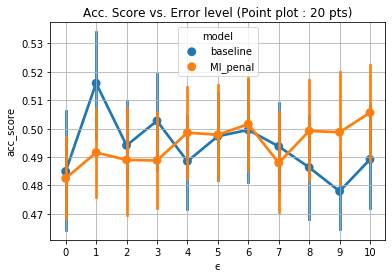

In [56]:
import seaborn as sns
ax = sns.pointplot(x="ϵ", y="acc_score", hue="model",
                   data=df)
plt.grid()
plt.title("Acc. Score vs. Error level (Point plot : 20 pts)")
plt.show()